<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/dashboard_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting with SARIMAX for dashboard

In [10]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [11]:
!pip install parse

  Created wheel for parse: filename=parse-1.19.0-cp37-none-any.whl size=24581 sha256=7882b12a6f8c87128f2ae54a8751ebcf39a36e6bfc5bf81e7e18105c70c3c7c1
  Stored in directory: /root/.cache/pip/wheels/c0/39/ea/e2fd678bd130953f5438470b8dfa529f00787e9b8b92b27467
Successfully built parse


In [12]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=0cf0607d87be2f034f56c5d7830ed3af2ba19bdb4107221b38774d7fb86e0e5c
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [13]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from parse import *
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

import wget

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
file_path = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'

## Daily Cases Dataset

In [16]:
!wget 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'


--2021-04-23 03:36:57--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5982468 (5.7M) [text/plain]
Saving to: ‘time_series_covid19_confirmed_US.csv’

time_series_covid19 100%[===================>]   5.71M  30.8MB/s    in 0.2s    

2021-04-23 03:36:57 (30.8 MB/s) - ‘time_series_covid19_confirmed_US.csv’ saved [5982468/5982468]



In [17]:
US_population_filename = wget.download('https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv')
county_population_US = pd.read_csv(US_population_filename,low_memory=False)
county_population_US.head()

,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869
2,1003,Baldwin County,AL,223234
3,1005,Barbour County,AL,24686
4,1007,Bibb County,AL,22394


## Data exploration

Let's load the data and have a peek:

In [18]:
df = pd.read_csv('time_series_covid19_confirmed_US.csv')
df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6416,6426,6471,6474,6483,6495,6498,6510,6513,6517,6525,6533,6540,6543,6562,6570,6577,6580,6589,6595,6606,6617,6619,6620,6644,6675,6702,6710,6715,6723,6727,6734,6740,6748,6750,6760,6763,6763,6773,6793
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20091,20103,20210,20227,20263,20287,20317,20329,20347,20361,20354,20395,20417,20423,20453,20473,20487,20492,20505,20523,20519,20526,20541,20542,20551,20573,20588,20600,20617,20631,20638,20652,20670,20674,20701,20714,20723,20730,20764,20787
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2181,2184,2195,2198,2199,2202,2206,2212,2212,2213,2213,2216,2218,2221,2224,2226,2226,2227,2227,2227,2228,2231,2232,2232,2238,2239,2244,2245,2247,2247,2249,2252,2257,2262,2264,2271,2271,2271,2275,2284
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2479,2481,2499,2508,2512,2519,2521,2528,2529,2529,2530,2535,2534,2535,2535,2536,2536,2537,2542,2543,2544,2545,2546,2546,2549,2557,2560,2561,2562,2562,2564,2564,2559,2560,2560,2563,2563,2567,2569,2569
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6288,6291,6353,6361,6371,6376,6380,6382,6383,6387,6388,6402,6408,6415,6420,6424,6426,6443,6444,6446,6455,6458,6459,6460,6462,6469,6472,6475,6480,6483,6488,6497,6507,6511,6519,6529,6532,6532,6548,6556


Two things to note here:

- The data contains a province, country, latitude, and longitude. We won't be needing those.
- The number of cases is cumulative. We'll undo the accumulation.

Let's start by getting rid of the first four columns:

In [19]:
df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21,3/25/21,3/26/21,3/27/21,3/28/21,3/29/21,3/30/21,3/31/21,4/1/21,4/2/21,4/3/21,4/4/21,4/5/21,4/6/21,4/7/21,4/8/21,4/9/21,4/10/21,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21,4/21/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6416,6426,6471,6474,6483,6495,6498,6510,6513,6517,6525,6533,6540,6543,6562,6570,6577,6580,6589,6595,6606,6617,6619,6620,6644,6675,6702,6710,6715,6723,6727,6734,6740,6748,6750,6760,6763,6763,6773,6793
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20091,20103,20210,20227,20263,20287,20317,20329,20347,20361,20354,20395,20417,20423,20453,20473,20487,20492,20505,20523,20519,20526,20541,20542,20551,20573,20588,20600,20617,20631,20638,20652,20670,20674,20701,20714,20723,20730,20764,20787
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2181,2184,2195,2198,2199,2202,2206,2212,2212,2213,2213,2216,2218,2221,2224,2226,2226,2227,2227,2227,2228,2231,2232,2232,2238,2239,2244,2245,2247,2247,2249,2252,2257,2262,2264,2271,2271,2271,2275,2284
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2479,2481,2499,2508,2512,2519,2521,2528,2529,2529,2530,2535,2534,2535,2535,2536,2536,2537,2542,2543,2544,2545,2546,2546,2549,2557,2560,2561,2562,2562,2564,2564,2559,2560,2560,2563,2563,2567,2569,2569
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6288,6291,6353,6361,6371,6376,6380,6382,6383,6387,6388,6402,6408,6415,6420,6424,6426,6443,6444,6446,6455,6458,6459,6460,6462,6469,6472,6475,6480,6483,6488,6497,6507,6511,6519,6529,6532,6532,6548,6556


Let's check for missing values:

In [20]:
df.isnull().sum().sum()

16

Everything seems to be in place. Let's sum all rows, so we get the cumulative daily cases:

In [21]:
df.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_',
       ...
       '4/12/21', '4/13/21', '4/14/21', '4/15/21', '4/16/21', '4/17/21',
       '4/18/21', '4/19/21', '4/20/21', '4/21/21'],
      dtype='object', length=467)

In [22]:
df.columns[:11]

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'],
      dtype='object')

In [23]:
print(df.columns[:11])
confirmed_dates = df.columns[11:]
confirmed_dates

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'],
      dtype='object')


Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '4/12/21', '4/13/21', '4/14/21', '4/15/21', '4/16/21', '4/17/21',
       '4/18/21', '4/19/21', '4/20/21', '4/21/21'],
      dtype='object', length=456)

In [24]:
confirmed_df_long = df.melt(
    id_vars=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'],
       value_vars=confirmed_dates,
       var_name = 'Date',
       value_name = 'Confirmed'
)

confirmed_df_long

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Date,Confirmed
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",1/22/20,0
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",1/22/20,0
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",1/22/20,0
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",1/22/20,0
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",1/22/20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523947,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",4/21/21,3711
1523948,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",4/21/21,2154
1523949,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,"Unassigned, Wyoming, US",4/21/21,0
1523950,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",4/21/21,898


In [25]:
full_table = confirmed_df_long

In [26]:
ship_data = full_table['Province_State'].str.contains('Grand Princess') | full_table['Province_State'].str.contains('Diamond Princess') | full_table['Province_State'].str.contains('Northern Mariana Islands') | full_table['Province_State'].str.contains('American Samoa') |full_table['Province_State'].str.contains('Guam') | full_table['Province_State'].str.contains('Virgin Islands')

full_ship = full_table[ship_data]


In [27]:
full_table = full_table[~(ship_data)]

In [28]:
full_grouped = full_table.groupby(['Date', 'Province_State','FIPS'])['Confirmed'].sum().reset_index()

full_grouped.tail(5)

,Date,Province_State,FIPS,Confirmed
1516651,9/9/20,Wyoming,56041.0,308
1516652,9/9/20,Wyoming,56043.0,111
1516653,9/9/20,Wyoming,56045.0,21
1516654,9/9/20,Wyoming,80056.0,0
1516655,9/9/20,Wyoming,90056.0,0


In [29]:
def fixDate(x):
  arr = x.split('/')
  m = arr[0]
  d = arr[1]
  y = arr[2]

  if int(m) < 10:
    m = '0'+str(m)
  if int(d) < 10:
    d = '0'+str(d)
  return '20'+str(y)+'-'+m+'-'+d

In [30]:
full_grouped['Date'] = full_grouped['Date'].apply(lambda x: fixDate(x))

full_grouped.head(2)

,Date,Province_State,FIPS,Confirmed
0,2021-01-01,Alabama,1001.0,4239
1,2021-01-01,Alabama,1003.0,13823


In [ ]:
# full_grouped['Date'] =  pd.to_datetime(full_grouped['Date'], format='%Y-%m-%d')
# full_grouped = full_grouped.set_index('Date')

In [31]:
full_grouped.tail()

,Date,Province_State,FIPS,Confirmed
1516651,2020-09-09,Wyoming,56041.0,308
1516652,2020-09-09,Wyoming,56043.0,111
1516653,2020-09-09,Wyoming,56045.0,21
1516654,2020-09-09,Wyoming,80056.0,0
1516655,2020-09-09,Wyoming,90056.0,0


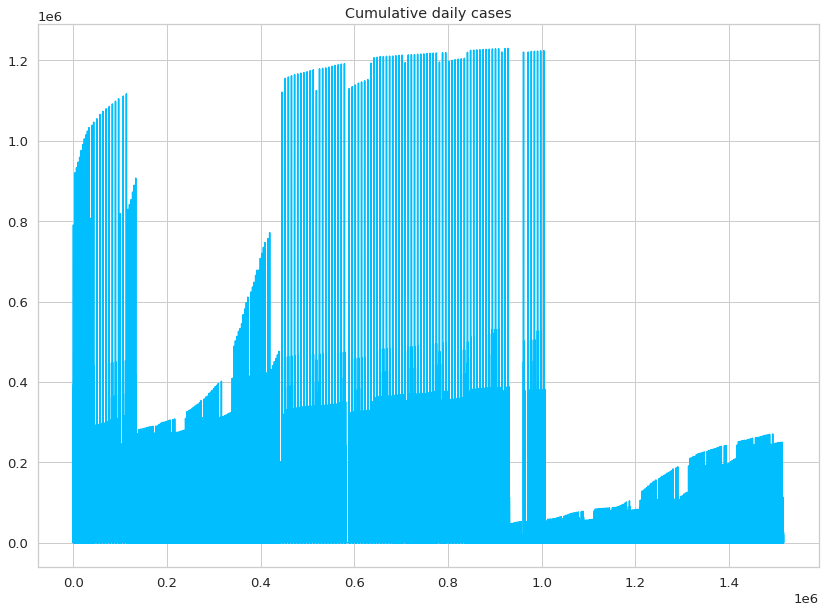

In [32]:
plt.plot(full_grouped['Confirmed'])
plt.title("Cumulative daily cases");

We'll undo the accumulation by subtracting the current value from the previous. We'll preserve the first value of the sequence:

## Include population

In [34]:
county_population_US.head()

,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869
2,1003,Baldwin County,AL,223234
3,1005,Barbour County,AL,24686
4,1007,Bibb County,AL,22394


In [35]:
full_grouped.shape

(1516656, 4)

In [36]:
full_grouped_filtered = full_grouped[full_grouped['Date'] >= '2020-08-01']

In [37]:
def computeNewCases(FIPS):


  countyData = full_grouped_filtered[full_grouped_filtered['FIPS'] == FIPS]
  countyData = countyData.sort_values(by=['Date'])

  if countyData.Confirmed.max() > 0:
    temp = countyData.groupby(['Date'])['Confirmed']
    temp = temp.sum().diff().reset_index()
    #print(temp)
    mask = temp['Date'] != temp['Date'].shift(1)

    #temp.loc[mask, 'Confirmed'] = np.nan
    #temp.loc[mask, 'Deaths'] = np.nan
    temp.columns = ['Date', 'New cases']
    print(temp)
    countyData = pd.merge(countyData, temp, on=[ 'Date'])
    print(countyData)
    #print('********')
    # filling na with 0
    countyData = countyData.fillna(0)
    # fixing data types
    cols = ['New cases']
    countyData[cols] = countyData[cols].astype('int') 
    return countyData


In [38]:
df = pd.DataFrame(columns=['Date','Province_State','FIPS','Confirmed','New cases'])

for fips in tqdm(full_grouped_filtered.FIPS.unique()):
  

  countyData = full_grouped_filtered[full_grouped_filtered['FIPS'] == fips]
  countyData = countyData.sort_values(by=['Date'])
  #print(fips,' , ',countyData.Confirmed.min())
  
  if countyData.Confirmed.max() > 0:
    temp = countyData.groupby(['Date'])['Confirmed']
    temp = temp.sum().diff().reset_index()
    #print(temp)
    mask = temp['Date'] != temp['Date'].shift(1)

    # temp.loc[mask, 'Confirmed'] = np.nan
    # temp.loc[mask, 'Deaths'] = np.nan
    temp.columns = ['Date', 'New cases']
    countyData = pd.merge(countyData, temp, on=[ 'Date'])
    #print(countyData)
    #print('********')
    # filling na with 0
    countyData = countyData.fillna(0)
    # fixing data types
    cols = ['New cases']
    countyData[cols] = countyData[cols].astype('int')
    df = df.append(countyData)
    #break

100%|██████████| 3326/3326 [06:21<00:00,  8.72it/s]


In [39]:
df.head()

,Date,Province_State,FIPS,Confirmed,New cases
0,2020-08-01,Alabama,1001.0,1064,0
1,2020-08-02,Alabama,1001.0,1078,14
2,2020-08-03,Alabama,1001.0,1086,8
3,2020-08-04,Alabama,1001.0,1086,0
4,2020-08-05,Alabama,1001.0,1109,23


In [40]:
df['FIPS'] = df['FIPS'].apply(lambda x:int(x))

df.head()

,Date,Province_State,FIPS,Confirmed,New cases
0,2020-08-01,Alabama,1001,1064,0
1,2020-08-02,Alabama,1001,1078,14
2,2020-08-03,Alabama,1001,1086,8
3,2020-08-04,Alabama,1001,1086,0
4,2020-08-05,Alabama,1001,1109,23


In [41]:
df.shape

(854304, 5)

In [ ]:
county_population_US[county_population_US['countyFIPS'] == 90056]

,countyFIPS,County Name,State,population


# Merge with Population 

## Load Maryland Dataset

In [42]:
df_maryland_all_states = pd.read_csv(file_path+'maryland_inertia_data_allstates_Feb12.csv',low_memory=False)
df_maryland_all_states.head()

,State_Name,PopDensity,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,Alabama,35.853419,1001,Autauga County,AL,55869,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,Alabama,35.853419,1001,Autauga County,AL,55869,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
2,Alabama,35.853419,1001,Autauga County,AL,55869,1001,Autauga County,1,15,15,3.18,42.2,1.0,40.3,0.62,2.57,0,55601,-0.4,2020-01-03,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
3,Alabama,35.853419,1001,Autauga County,AL,55869,1001,Autauga County,1,33,20,2.85,43.9,1.2,29.5,0.33,2.52,0,55601,-2.3,2020-01-04,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
4,Alabama,35.853419,1001,Autauga County,AL,55869,1001,Autauga County,1,40,22,2.56,42.8,1.2,30.9,0.23,2.33,0,55601,-9.7,2020-01-05,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [43]:
df.head(2)

,Date,Province_State,FIPS,Confirmed,New cases
0,2020-08-01,Alabama,1001,1064,0
1,2020-08-02,Alabama,1001,1078,14


In [44]:
print(df['FIPS'].nunique())
df['FIPS'].dtypes

3236


dtype('int64')

In [45]:
df_maryland_all_states = df_maryland_all_states.astype({"countyFIPS": float})
df_maryland_all_states.head(2)

,State_Name,PopDensity,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,Alabama,35.853419,1001.0,Autauga County,AL,55869,1001,Autauga County,1,54,27,2.25,38.8,1.2,24.7,0.25,2.00,0,55601,-22.5,2020-01-01,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0
1,Alabama,35.853419,1001.0,Autauga County,AL,55869,1001,Autauga County,1,25,18,2.83,43.5,0.9,37.6,0.62,2.21,0,55601,-14.3,2020-01-02,0.11,19,58786,19.0,2.8,48.68,91,19,101,3.79,0.33,0.025,0.0,0.0,0,47.1,0.0,0.0,0.0,0,0,0.0,0,0.9,2.7,3.2,0.3,0.0


In [46]:
df_maryland_filter  = df_maryland_all_states[['countyFIPS','population']].drop_duplicates()
len(df_maryland_filter)

3142

In [47]:
print(df_maryland_all_states['countyFIPS'].nunique())
df_maryland_all_states['countyFIPS'].dtypes

3142


dtype('float64')

In [48]:
print(county_population_US['countyFIPS'].nunique())
county_population_US['countyFIPS'].dtypes

3145


dtype('int64')

## Extract Population

In [ ]:
# print(county_population_US.shape)
# print(df.shape)

# merged = pd.merge(df, county_population_US[['countyFIPS','population']], how='left',left_on='FIPS', right_on='countyFIPS')
# merged.shape

In [49]:
print(df_maryland_all_states.shape)
print(df.shape)

#merged = pd.merge(df, df_maryland_all_states[['countyFIPS','population']], how='left',left_on='FIPS', right_on='countyFIPS')

merged = pd.merge(df, df_maryland_filter, how='left',left_on='FIPS', right_on='countyFIPS')
merged.shape

(1140546, 49)
(854304, 5)


(854304, 7)

In [50]:
merged.reset_index(drop=True, inplace=True)

In [51]:
merged.nunique()

Date                264
Province_State       52
FIPS               3236
Confirmed         49568
New cases          2758
countyFIPS         3115
population         3062
dtype: int64

In [52]:
merged.head(2)

,Date,Province_State,FIPS,Confirmed,New cases,countyFIPS,population
0,2020-08-01,Alabama,1001,1064,0,1001.0,55869.0
1,2020-08-02,Alabama,1001,1078,14,1001.0,55869.0


In [53]:
merged.tail(2)

,Date,Province_State,FIPS,Confirmed,New cases,countyFIPS,population
854302,2021-04-20,Wyoming,90056,0,0,NaN,NaN
854303,2021-04-21,Wyoming,90056,0,0,NaN,NaN


## Other Computation

In [54]:


merged['New Cases/100k population'] = merged['New cases']*100000/ merged['population']
merged.tail(2)

,Date,Province_State,FIPS,Confirmed,New cases,countyFIPS,population,New Cases/100k population
854302,2021-04-20,Wyoming,90056,0,0,NaN,NaN,NaN
854303,2021-04-21,Wyoming,90056,0,0,NaN,NaN,NaN


In [55]:
merged.head(2)

,Date,Province_State,FIPS,Confirmed,New cases,countyFIPS,population,New Cases/100k population
0,2020-08-01,Alabama,1001,1064,0,1001.0,55869.0,0
1,2020-08-02,Alabama,1001,1078,14,1001.0,55869.0,25.0586


In [56]:
df.FIPS.nunique()

3236

In [ ]:
# df_filtered = df[(df['Province_State'] != 'Alaska') & (df['Province_State'] != 'Hawaii') ]
# df_filtered.head()



In [57]:
df_filtered = merged[(merged['Province_State'] != 'Alaska') & (merged['Province_State'] != 'Hawaii') ]
df_filtered.head()

,Date,Province_State,FIPS,Confirmed,New cases,countyFIPS,population,New Cases/100k population
0,2020-08-01,Alabama,1001,1064,0,1001.0,55869.0,0
1,2020-08-02,Alabama,1001,1078,14,1001.0,55869.0,25.0586
2,2020-08-03,Alabama,1001,1086,8,1001.0,55869.0,14.3192
3,2020-08-04,Alabama,1001,1086,0,1001.0,55869.0,0
4,2020-08-05,Alabama,1001,1109,23,1001.0,55869.0,41.1677


In [58]:
print(df_filtered.shape)
df_filtered.tail()

(844800, 8)


,Date,Province_State,FIPS,Confirmed,New cases,countyFIPS,population,New Cases/100k population
854299,2021-04-17,Wyoming,90056,0,0,NaN,NaN,NaN
854300,2021-04-18,Wyoming,90056,0,0,NaN,NaN,NaN
854301,2021-04-19,Wyoming,90056,0,0,NaN,NaN,NaN
854302,2021-04-20,Wyoming,90056,0,0,NaN,NaN,NaN
854303,2021-04-21,Wyoming,90056,0,0,NaN,NaN,NaN


In [59]:
print(df['Date'].min())
print(df['Date'].max())

2020-08-01
2021-04-21


In [60]:
df_filtered = df_filtered[df_filtered['Date'] >= '2021-02-01']
df_filtered.shape

(256000, 8)

In [61]:
df_filtered['FIPS'].unique()

array([ 1001,  1003,  1005, ..., 56043, 56045, 90056])

In [62]:
df_filtered['Province_State']

184       Alabama
185       Alabama
186       Alabama
187       Alabama
188       Alabama
           ...   
854299    Wyoming
854300    Wyoming
854301    Wyoming
854302    Wyoming
854303    Wyoming
Name: Province_State, Length: 256000, dtype: object

In [63]:
df_filtered.head(2)

,Date,Province_State,FIPS,Confirmed,New cases,countyFIPS,population,New Cases/100k population
184,2021-02-01,Alabama,1001,5683,14,1001.0,55869.0,25.0586
185,2021-02-02,Alabama,1001,5723,40,1001.0,55869.0,71.5961


# SARIMAX Prediction

In [67]:
prediction = 'New Cases/100k population'

# one-step sarima forecast
def sarima_forecast(train, n_test, state_name, fips, config):
	order, sorder = config
	# define model
	#print(order, sorder)
	#print(train)
	cbrt_train =  np.cbrt(train)
  
	#print(' 1 : ',cbrt_train.shape)
	try:
		model = SARIMAX(cbrt_train, order=order, seasonal_order=sorder, freq = 'D')
	except Exception as e:
		print(e)
	#print(' 2 : ')
	# fit model
	model_fit = model.fit(maxiter = 200, disp = False)
	# make one step forecast
	#print(' 3 : ')
	yhat = model_fit.forecast(n_test)
	#print(' yhat : ',yhat)

	lst = []

	for y in train.keys():
        #print(y)
		row = {}
		row['Date'] = y
		row['Province_State'] = state_name
		row['FIPS'] = fips
		row[prediction] = train[y]
		lst.append(row)
	for y in yhat.keys():
    #print(y)
		row = {}
		row['Date'] = y
		row['Province_State'] = state_name
		row['FIPS'] = fips
		row[prediction] = yhat[y]
		lst.append(row)

	df_estimates = pd.DataFrame(lst)
	return df_estimates

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
  #print("scs:I am hereeee:",data[prediction])
  true_value = data[prediction]
  true_value.index.freq = 'd'
  true_value = true_value.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0.0)

  train = true_value[true_value.index >= '2020-01-09']
	#train = train[prediction]
	#test = test_df[prediction]
  train.index.freq = 'D'
	#test.index.freq = 'D'
	#print('train shp : ',train.shape)

  return train

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, fips, cfg):

	#print("walk forward validation: ",fips)
	county_data = data[data['FIPS'] == fips] 
	county_data['Date'] =  pd.to_datetime(county_data['Date'], format='%Y-%m-%d')
	county_data = county_data.set_index('Date')
	state_name = county_data['Province_State'].tolist()[0]
	#print(state_name)
	# split dataset
	train = train_test_split(county_data, n_test)
	# seed history with training dataset
	#history = [x for x in train]
	# step over each time-step in the test set
	#for i in range(len(test)):
		# fit model and make forecast for history
	#yhat = []
	try:   
		result_df = sarima_forecast(train, n_test, state_name, fips, cfg)
		#error = mean_percent_error(test, yhat)
	except Exception as e:
		#error = None
		result_df = None

		# store forecast in list of predictions
	#predictions.append(yhat)
		# add actual observation to history for the next loop
		#history.append(test[i])
	# estimate prediction error
	
	#print("error : ",error)
	return result_df

# score a model, return None on failure
def score_model(data, n_test, fips, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(fips)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, fips, cfg)
    
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, fips,cfg)
		except:
			result = None
	# check for an interesting result
	#if result is not None:
		#print(result)
	
	#print(result)
	return (key, result)

# grid search configs
def grid_search(data, FIPS, n_test,cfg, parallel=True): 
	forecast_df = None
	if parallel:
		# execute configs in parallel
		print(' has parallel : ',cpu_count())
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, fips, cfg, debug=True) for fips in tqdm(FIPS))
		#a,b = executor(tasks)
		forecast_df = executor(tasks)
	else:
		forecast_df = [score_model(data, n_test, fips, cfg) for fips in FIPS]
	# remove empty results
	#scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	#scores.sort(key=lambda tup: tup[1])
	return forecast_df

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m = 7
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
									cfg = [(p,d,q), (P,D,Q,m)]
									models.append(cfg)
	return models


In [65]:
df_filtered['Province_State'].unique()

array(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida',
       'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island',
       'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
       'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin',
       'Wyoming'], dtype=object)

In [68]:
# true_value = WC_OR_SuperSet_Data_PCA[prediction]
# true_value.index.freq = 'D'
# true_value = true_value.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0.0)

# print(len(cfg_list))
n_test = 14

FIPS = df_filtered.FIPS.unique()
#print(FIPS)
cfg = [ (0,1,1),  (0,1,3,7)]
fips_minimal = []
fips_minimal.append(FIPS[0])
fips_minimal.append(FIPS[100])
#print(fips_minimal)
# grid search
# JS's code
#forecasts_df = grid_search(df_filtered,fips_minimal, n_test,cfg )

forecasts_df = grid_search(df_filtered,FIPS, n_test,cfg )





  0%|          | 0/3200 [00:00<?, ?it/s]

 has parallel :  40



100%|██████████| 3200/3200 [41:02<00:00,  1.30it/s]


# Below code changes the list to dataframe 

In [ ]:
forecasts_df

In [69]:
final_lst = []
for fips, df1 in forecasts_df:
		#print(fips, df1);
		final_lst.append(df1)
		#break
print('done')

done


In [ ]:
final_lst

In [71]:
final_df = pd.concat(final_lst)
final_df.shape

(289426, 4)

In [72]:
final_df.tail()

,Date,Province_State,FIPS,New Cases/100k population
89,2021-05-01,Wyoming,56045,0.295701
90,2021-05-02,Wyoming,56045,0.297334
91,2021-05-03,Wyoming,56045,1.180997
92,2021-05-04,Wyoming,56045,1.341487
93,2021-05-05,Wyoming,56045,2.279992


In [73]:
final_df['Province_State'].unique()

array(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida',
       'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [74]:
from datetime import datetime

location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
final_df.to_csv(location+'dashboard-data/data_'+datetime.now().strftime("%b%d")+'.csv')

## Util method for Identify ranges and label data


In [75]:
import scipy

In [76]:
def identify_ranges(data):
    avg_col_idx = data.columns.get_loc("New Cases/100k population")
    print(avg_col_idx)
    data['daily_growth_range'] = data.iloc[:,avg_col_idx].diff().fillna(0)
    mean = data['daily_growth_range'].mean()
    x_values = data['daily_growth_range'].values
    standard_deviation = np.std(x_values)
    x_values = np.sort(x_values)
    y_values = scipy.stats.norm(mean, standard_deviation)

    print('min : ',x_values.min(), 'max: ',x_values.max())
    median = np.median(x_values)
    st_dev = np.std(x_values)
    mini = x_values.min()
    maxi = x_values.max()
    alpha = 0.5
    while (mean+alpha*st_dev) < 7.0:
        alpha += 0.5

    range1 = mini, mean-alpha*st_dev
    points =  mean-alpha*st_dev, mean+alpha*st_dev
    range4 =  mean+alpha*st_dev,maxi

    return range1,points,range4

In [77]:
def label_result(data,county_name, range1,points,range4):
    data['growth_label_estimate'] = ""
    for index, row in tqdm(data.iterrows()):
        i = row['daily_growth_range']


        if i > range4[1] :
            label = 'widespread'
            date = row['Date']
            #JS: df_index = (data['County Name'] == county_name) & (data['Date'] == date)
            df_index = (data['FIPS'] == county_name) & (data['Date'] == date)
            data.loc[df_index,'growth_label_estimate'] = label
            #print(df_index,label)
            continue
        elif i >= range4[0] and i <= range4[1] :
            label = 'widespread'
            date = row['Date']
            #JS: df_index = (data['County Name'] == county_name) & (data['Date'] == date)
            df_index = (data['FIPS'] == county_name) & (data['Date'] == date)
            data.loc[df_index,'growth_label_estimate'] = label
            #print(df_index,label)
            continue

        elif i <= points[1] and i >= points[0]:
            label = 'nochange'
            date = row['Date']
            #JS: df_index = (data['County Name'] == county_name) & (data['Date'] == date)
            df_index = (data['FIPS'] == county_name) & (data['Date'] == date)
            data.loc[df_index,'growth_label_estimate'] = label
            #print(df_index,label)
            continue

        elif i <= range1[1] and i > range1[0] :
            label = 'minimal'
            date = row['Date']
            #JS: df_index = (data['County Name'] == county_name) & (data['Date'] == date)
            df_index = (data['FIPS'] == county_name) & (data['Date'] == date)
            data.loc[df_index,'growth_label_estimate'] = label
            #print(df_index,label)
            continue
        elif i < range1[1] :
            label = 'minimal'
            date = row['Date']
            #JS: df_index = (data['County Name'] == county_name) & (data['Date'] == date)
            df_index = (data['FIPS'] == county_name) & (data['Date'] == date)
            data.loc[df_index,'growth_label_estimate'] = label
            #print(df_index,label)
            continue

    return data

In [78]:

print(len(final_df))
final_df.head(2)

289426


,Date,Province_State,FIPS,New Cases/100k population
0,2021-02-01,Alabama,1001,25.058619
1,2021-02-02,Alabama,1001,71.596055


### Identify range and label data


In [ ]:
# Write for loop to loop through all FIPS COde 
#labeled_df = label_result(<< filtered each county data frame >>,<< FIPS code >>, range1,points,range4)


In [80]:
#final_df['New Cases/100k population'] = final_df['New cases']
fips_list = final_df.FIPS.unique()
final_labeled_data = pd.DataFrame()

i= 0
for fips in fips_list:
  #print("fips=", fips)
  df_county = final_df[(final_df['FIPS'] == fips)]
  #print(df_county)
  range1,points,range4 = identify_ranges(df_county)

  labeled_df = label_result(df_county,fips, range1,points,range4)
  #print(labeled_df['Province_State'].unique())

  final_labeled_data = final_labeled_data.append(labeled_df, ignore_index=True)
  #print("#########################")


print(final_labeled_data.head(2))


0it [00:00, ?it/s]
94it [00:00, 861.70it/s]

0it [00:00, ?it/s]

3
min :  -80.54556193953712 max:  62.64654817519555
3
min :  -40.31643925208526 max:  42.55624143275666



94it [00:00, 874.79it/s]

0it [00:00, ?it/s]
94it [00:00, 816.57it/s]

0it [00:00, ?it/s]

3
min :  -52.66142752977396 max:  44.55966944827028
3
min :  -44.654818254889705 max:  71.44770920782352



94it [00:00, 810.41it/s]

0it [00:00, ?it/s]
94it [00:00, 845.21it/s]

0it [00:00, ?it/s]


3
min :  -200.60180541624874 max:  205.78978314253104
3
min :  -79.2000792000792 max:  79.2000792000792


94it [00:00, 847.19it/s]

0it [00:00, ?it/s]
94it [00:00, 882.33it/s]

0it [00:00, ?it/s]

3
min :  -169.68325791855202 max:  149.11559029206086
3
min :  -326.57013335680654 max:  388.1871396505436



94it [00:00, 876.14it/s]

0it [00:00, ?it/s]
94it [00:00, 895.98it/s]

0it [00:00, ?it/s]

3
min :  -42.10019847236423 max:  45.107355506104525
3
min :  -19.086883493663155 max:  19.086883493663155


94it [00:00, 932.11it/s]

0it [00:00, ?it/s]
94it [00:00, 773.37it/s]

0it [00:00, ?it/s]


3
min :  -45.01665616278022 max:  56.27082020347528
3
min :  -31.773770752244022 max:  31.773770752244022


94it [00:00, 867.77it/s]

0it [00:00, ?it/s]
94it [00:00, 862.31it/s]

0it [00:00, ?it/s]

3
min :  -46.56675980018627 max:  105.83354500042334
3
min :  -83.1129580657348 max:  98.22440498677749



94it [00:00, 823.84it/s]

0it [00:00, ?it/s]
94it [00:00, 879.43it/s]

0it [00:00, ?it/s]


3
min :  -160.96579476861166 max:  154.25888665325283
3
min :  -78.33097703565015 max:  76.4204654006343


94it [00:00, 808.00it/s]

0it [00:00, ?it/s]
94it [00:00, 836.98it/s]

0it [00:00, ?it/s]

3
min :  -104.99447873861806 max:  104.99447873861806
3
min :  -41.43531946631308 max:  66.29651114610094



94it [00:00, 811.00it/s]

0it [00:00, ?it/s]
94it [00:00, 854.39it/s]

0it [00:00, ?it/s]

3
min :  -328.23783175466565 max:  262.59026540373253
3
min :  -67.47820453993361 max:  102.56687090069909



94it [00:00, 855.91it/s]

0it [00:00, ?it/s]
94it [00:00, 826.54it/s]

0it [00:00, ?it/s]

3
min :  -72.61109497531223 max:  79.87220447284345
3
min :  -175.48467195110305 max:  179.06599178683985



94it [00:00, 847.08it/s]

0it [00:00, ?it/s]
94it [00:00, 861.86it/s]

0it [00:00, ?it/s]

3
min :  -34.57252094688034 max:  32.538843244122674
3
min :  -139.799978492311 max:  147.8653618668674



94it [00:00, 844.95it/s]

0it [00:00, ?it/s]
94it [00:00, 872.99it/s]

0it [00:00, ?it/s]


3
min :  -135.63967390544377 max:  118.85950806147135
3
min :  -73.88343656491276 max:  75.11482717432796


94it [00:00, 893.83it/s]

0it [00:00, ?it/s]
94it [00:00, 877.49it/s]

0it [00:00, ?it/s]

3
min :  -49.13602489558595 max:  57.325362378183605
3
min :  -172.09684358743692 max:  175.0303125122228



94it [00:00, 867.21it/s]

0it [00:00, ?it/s]
94it [00:00, 792.65it/s]

0it [00:00, ?it/s]

3
min :  -159.4896331738437 max:  184.02649981597352
3
min :  -389.00580320132644 max:  392.19437535871435



94it [00:00, 872.89it/s]

0it [00:00, ?it/s]
94it [00:00, 876.91it/s]

94it [00:00, 946.44it/s]

3
min :  -45.67774351947014 max:  30.45182901298009
3
min :  -110.96042411539884 max:  160.27616816668723




0it [00:00, ?it/s]
94it [00:00, 902.46it/s]

0it [00:00, ?it/s]


3
min :  -68.25472663981981 max:  95.55661729574773
3
min :  -52.31037489102006 max:  29.061319383900027


94it [00:00, 878.03it/s]

0it [00:00, ?it/s]
94it [00:00, 874.43it/s]

94it [00:00, 954.83it/s]


3
min :  -21.722294629870987 max:  23.61118981507716
3
min :  -131.7165769186069 max:  137.52760237089836



0it [00:00, ?it/s]
94it [00:00, 828.77it/s]

0it [00:00, ?it/s]

3
min :  -104.46829736414945 max:  109.47913139469732
3
min :  -86.925027164071 max:  86.925027164071



94it [00:00, 863.81it/s]

0it [00:00, ?it/s]
94it [00:00, 885.18it/s]

0it [00:00, ?it/s]


3
min :  -279.3085226843814 max:  281.46534525337273
3
min :  -85.04434455108735 max:  88.08164257076903


94it [00:00, 858.60it/s]

0it [00:00, ?it/s]
94it [00:00, 896.13it/s]

0it [00:00, ?it/s]


3
min :  -32.21062099646291 max:  24.917650204810933
3
min :  -138.5027548905626 max:  144.56856897336098


94it [00:00, 848.87it/s]

0it [00:00, ?it/s]
94it [00:00, 858.45it/s]

0it [00:00, ?it/s]


3
min :  -154.22578655151142 max:  154.22578655151142
3
min :  -243.52446313925174 max:  254.59375691830863


94it [00:00, 879.09it/s]

0it [00:00, ?it/s]
94it [00:00, 847.31it/s]

0it [00:00, ?it/s]

3
min :  -19.575821447055446 max:  22.525602760995312
3
min :  -519.5355987912845 max:  339.2885543126756



94it [00:00, 867.41it/s]

0it [00:00, ?it/s]
94it [00:00, 903.60it/s]

0it [00:00, ?it/s]

3
min :  -188.49506883435996 max:  212.05695243865495
3
min :  -259.3671854010375 max:  257.3005146010292



94it [00:00, 890.02it/s]

0it [00:00, ?it/s]
94it [00:00, 879.25it/s]

0it [00:00, ?it/s]

3
min :  -278.55085791728175 max:  279.0348733089712
3
min :  -62.70197270052573 max:  62.70197270052573



94it [00:00, 866.11it/s]

0it [00:00, ?it/s]
94it [00:00, 899.70it/s]

0it [00:00, ?it/s]


3
min :  -98.46083201610696 max:  92.2794344904321
3
min :  -105.2816283558519 max:  103.6104913978225


94it [00:00, 854.19it/s]

0it [00:00, ?it/s]
94it [00:00, 855.98it/s]

0it [00:00, ?it/s]

3
min :  -381.03776756696175 max:  291.38182225708846
3
min :  -170.59708981435023 max:  185.64977420973406



94it [00:00, 848.32it/s]

0it [00:00, ?it/s]
94it [00:00, 857.64it/s]

0it [00:00, ?it/s]


3
min :  -90.59612248595761 max:  93.61599323548953
3
min :  -118.82756799577503 max:  132.0306311064167


94it [00:00, 849.48it/s]

0it [00:00, ?it/s]
94it [00:00, 845.89it/s]

0it [00:00, ?it/s]


3
min :  -34.505960904746296 max:  39.68185504045824
3
min :  -161.98945392796497 max:  169.80963446241844


94it [00:00, 884.49it/s]

0it [00:00, ?it/s]
94it [00:00, 861.96it/s]

0it [00:00, ?it/s]


3
min :  -28.938640894433675 max:  39.04419803217242
3
min :  -56.32896113301682 max:  56.328961133016826


94it [00:00, 789.33it/s]

0it [00:00, ?it/s]
94it [00:00, 838.77it/s]

0it [00:00, ?it/s]


3
min :  -233.81429893220636 max:  212.55845357473305
3
min :  -336.90886119850376 max:  336.90886119850376


94it [00:00, 864.27it/s]

0it [00:00, ?it/s]
94it [00:00, 876.06it/s]

0it [00:00, ?it/s]


3
min :  -39.64557808507081 max:  52.54233240190108
3
min :  -437.6505407660459 max:  447.0962358904929


94it [00:00, 857.45it/s]

0it [00:00, ?it/s]
94it [00:00, 856.87it/s]

0it [00:00, ?it/s]


3
min :  -257.25836089672913 max:  263.3835599656989
3
min :  -77.12330087727756 max:  77.12330087727754


94it [00:00, 886.35it/s]

0it [00:00, ?it/s]
94it [00:00, 762.71it/s]

0it [00:00, ?it/s]


3
min :  -490.92217190740195 max:  457.06547039654663
3
min :  -166.9286519120286 max:  203.0965264929681


94it [00:00, 863.09it/s]

0it [00:00, ?it/s]
94it [00:00, 845.36it/s]

0it [00:00, ?it/s]


3
min :  -51.619256365051385 max:  44.471974714505805
3
min :  -53.667512336558026 max:  71.78901000864255


94it [00:00, 867.56it/s]

0it [00:00, ?it/s]
94it [00:00, 879.82it/s]

0it [00:00, ?it/s]


3
min :  -496.1309193231886 max:  497.98215409678255
3
min :  -360.48098462806087 max:  363.0558488039756


94it [00:00, 892.84it/s]

0it [00:00, ?it/s]
94it [00:00, 894.27it/s]

0it [00:00, ?it/s]


3
min :  -42.11412929037692 max:  42.11412929037692
3
min :  -345.840439643737 max:  184.76407049459922


94it [00:00, 837.77it/s]

0it [00:00, ?it/s]
94it [00:00, 869.25it/s]

0it [00:00, ?it/s]


3
min :  -29.852316865288245 max:  35.871828107728746
3
min :  -80.1202746711534 max:  40.060137335576705


94it [00:00, 901.09it/s]

0it [00:00, ?it/s]
94it [00:00, 797.18it/s]

0it [00:00, ?it/s]

3
min :  -187.51577656774006 max:  185.7127402545887
3
min :  -44.114319106942844 max:  41.91815170551496



94it [00:00, 847.36it/s]

0it [00:00, ?it/s]
94it [00:00, 867.95it/s]

94it [00:00, 947.36it/s]

3
min :  -60.50273450751855 max:  73.46760618770108
3
min :  -51.615123231106715 max:  53.76575336573617




0it [00:00, ?it/s]
94it [00:00, 889.87it/s]

0it [00:00, ?it/s]

3
min :  -110.16635545025711 max:  204.5946601219061
3
min :  -64.08247461258169 max:  42.565731312006804



94it [00:00, 871.07it/s]

0it [00:00, ?it/s]
94it [00:00, 854.11it/s]

0it [00:00, ?it/s]


3
min :  -194.4412672995539 max:  188.72240649662587
3
min :  -254.36231367960525 max:  223.83883603805262


94it [00:00, 882.25it/s]

94it [00:00, 940.60it/s]

0it [00:00, ?it/s]

3
min :  -150.24325097777353 max:  126.39511590193646
3
min :  -36.898914885308855 max:  53.37804192146621



94it [00:00, 843.51it/s]

0it [00:00, ?it/s]
94it [00:00, 846.42it/s]

0it [00:00, ?it/s]

3
min :  -45.415687112630906 max:  48.08719811925625
3
min :  -111.49307813806558 max:  92.91089844838798



94it [00:00, 862.74it/s]

0it [00:00, ?it/s]
94it [00:00, 900.04it/s]

0it [00:00, ?it/s]


3
min :  -115.62921564848719 max:  115.62921564848719
3
min :  -59.90133897110641 max:  38.75968992248062


94it [00:00, 898.61it/s]

0it [00:00, ?it/s]
94it [00:00, 860.16it/s]

0it [00:00, ?it/s]

3
min :  -49.41688080648349 max:  49.4168808064835
3
min :  -58.2437275985663 max:  53.763440860215056



94it [00:00, 811.78it/s]

0it [00:00, ?it/s]
94it [00:00, 856.84it/s]

0it [00:00, ?it/s]


3
min :  -89.34093876709504 max:  82.46855886193389
3
min :  -52.16902764958465 max:  52.169027649584656


94it [00:00, 848.00it/s]

0it [00:00, ?it/s]
94it [00:00, 843.56it/s]

0it [00:00, ?it/s]


3
min :  -138.26043237807943 max:  100.5530417295123
3
min :  -456.1538133606173 max:  409.2594960992454


94it [00:00, 871.00it/s]

0it [00:00, ?it/s]
94it [00:00, 878.32it/s]

0it [00:00, ?it/s]


3
min :  -33.579583613163194 max:  38.37666698647222
3
min :  -56.19403255628467 max:  60.725809375339885


94it [00:00, 864.34it/s]

0it [00:00, ?it/s]
94it [00:00, 877.98it/s]

0it [00:00, ?it/s]

3
min :  -88.52775186935833 max:  52.168139494443295
3
min :  -162.65248670628714 max:  154.31133354186215



94it [00:00, 872.39it/s]

0it [00:00, ?it/s]
94it [00:00, 864.63it/s]

0it [00:00, ?it/s]


3
min :  -60.90504902856447 max:  66.99555393142091
3
min :  -128.4063347125125 max:  128.4063347125125


94it [00:00, 834.94it/s]

0it [00:00, ?it/s]
94it [00:00, 829.12it/s]

0it [00:00, ?it/s]

3
min :  -70.4163365900889 max:  88.02042073761112
3
min :  -54.88775454196169 max:  38.42142817937318



94it [00:00, 841.63it/s]

94it [00:00, 948.26it/s]

0it [00:00, ?it/s]

3
min :  -42.85476203702969 max:  78.56706373455442
3
min :  -62.0942703923229 max:  62.0942703923229



94it [00:00, 861.25it/s]

0it [00:00, ?it/s]
94it [00:00, 864.50it/s]

0it [00:00, ?it/s]

3
min :  -88.16221848200689 max:  80.147471347279
3
min :  -117.72281810315336 max:  137.84637675326505



94it [00:00, 866.38it/s]

0it [00:00, ?it/s]
94it [00:00, 785.43it/s]

0it [00:00, ?it/s]

3
min :  -93.07418560087598 max:  93.07418560087598
3
min :  -185.32818532818533 max:  185.32818532818533



94it [00:00, 846.72it/s]

0it [00:00, ?it/s]
94it [00:00, 836.47it/s]

0it [00:00, ?it/s]


3
min :  -394.7612855285157 max:  315.80902842281256
3
min :  -162.86162683959608 max:  148.0560243996328


94it [00:00, 843.97it/s]

0it [00:00, ?it/s]
94it [00:00, 892.94it/s]

0it [00:00, ?it/s]

3
min :  -249.96212695046205 max:  318.1336161187699
3
min :  -23.793787177792463 max:  39.656311962987445



94it [00:00, 852.63it/s]

0it [00:00, ?it/s]
94it [00:00, 863.82it/s]

0it [00:00, ?it/s]

3
min :  -139.4086139848852 max:  168.75779587643996
3
min :  -203.36144506250372 max:  215.3238830073569



94it [00:00, 827.38it/s]

0it [00:00, ?it/s]
94it [00:00, 811.53it/s]

0it [00:00, ?it/s]

3
min :  -29.929366694600745 max:  37.41170836825092
3
min :  -41.387613815937996 max:  48.9126345097449



94it [00:00, 873.82it/s]

0it [00:00, ?it/s]
94it [00:00, 852.50it/s]

0it [00:00, ?it/s]


3
min :  -452.8985507246377 max:  452.8985507246377
3
min :  -219.43191515299281 max:  207.24125320004876


94it [00:00, 847.23it/s]

0it [00:00, ?it/s]
94it [00:00, 877.90it/s]

0it [00:00, ?it/s]

3
min :  -67.74302811335667 max:  56.45252342779723
3
min :  -115.17199017199016 max:  99.8157248157248



94it [00:00, 871.66it/s]

0it [00:00, ?it/s]
94it [00:00, 881.95it/s]

0it [00:00, ?it/s]

3
min :  -269.18998286972834 max:  293.6617994942491
3
min :  -65.21941675207304 max:  51.243827448057395



94it [00:00, 865.00it/s]

0it [00:00, ?it/s]
94it [00:00, 842.23it/s]

0it [00:00, ?it/s]


3
min :  -35.46631382231377 max:  55.927648719802484
3
min :  -36.1969111969112 max:  36.1969111969112


94it [00:00, 838.66it/s]

0it [00:00, ?it/s]
94it [00:00, 841.29it/s]

94it [00:00, 943.94it/s]

3
min :  -107.82317000119804 max:  95.8428177788427
3
min :  -513.2117345169568 max:  492.40585338789094




0it [00:00, ?it/s]
94it [00:00, 877.98it/s]

0it [00:00, ?it/s]

3
min :  -265.67612112863156 max:  250.91633662148536
3
min :  -194.00089538874795 max:  179.07774958961352



94it [00:00, 845.11it/s]

0it [00:00, ?it/s]
94it [00:00, 874.11it/s]

0it [00:00, ?it/s]


3
min :  -89.02737591809482 max:  89.0273759180948
3
min :  -109.06446921958313 max:  72.70964614638875


94it [00:00, 847.80it/s]

0it [00:00, ?it/s]
94it [00:00, 855.30it/s]

0it [00:00, ?it/s]

3
min :  -77.38939765252161 max:  77.38939765252161
3
min :  -260.8844410230091 max:  260.8844410230091



94it [00:00, 866.08it/s]

0it [00:00, ?it/s]
94it [00:00, 827.10it/s]

0it [00:00, ?it/s]

3
min :  -258.2496413199426 max:  219.99043519846964
3
min :  -33.74198627825892 max:  44.98931503767855



94it [00:00, 864.62it/s]

0it [00:00, ?it/s]
94it [00:00, 850.04it/s]

0it [00:00, ?it/s]

3
min :  -74.64079119238664 max:  65.3106922933383
3
min :  -42.50255015300918 max:  38.25229513770826



94it [00:00, 856.65it/s]

0it [00:00, ?it/s]
94it [00:00, 905.30it/s]

0it [00:00, ?it/s]

3
min :  -60.10819475055099 max:  125.22540573031456
3
min :  -24.9719066050693 max:  21.85041827943563



94it [00:00, 812.97it/s]

0it [00:00, ?it/s]
94it [00:00, 874.72it/s]

0it [00:00, ?it/s]


3
min :  -62.01935003721161 max:  37.211610022326965
3
min :  -60.72807346565929 max:  50.7768345364126


94it [00:00, 868.63it/s]

0it [00:00, ?it/s]
94it [00:00, 845.00it/s]

0it [00:00, ?it/s]


3
min :  -361.95567435126407 max:  306.2701859895311
3
min :  -28.006721613187167 max:  32.00768184364247


94it [00:00, 868.13it/s]

0it [00:00, ?it/s]
94it [00:00, 857.71it/s]

0it [00:00, ?it/s]


3
min :  -31.036369724838078 max:  44.921061443844586
3
min :  -87.54012255617158 max:  87.54012255617158


94it [00:00, 860.54it/s]

0it [00:00, ?it/s]
94it [00:00, 870.97it/s]

0it [00:00, ?it/s]


3
min :  -139.5761959142241 max:  139.5761959142241
3
min :  -33.6392155022022 max:  39.897674200286325


94it [00:00, 872.48it/s]

0it [00:00, ?it/s]
94it [00:00, 879.38it/s]

0it [00:00, ?it/s]

3
min :  -446.8748162521315 max:  440.9948844593403
3
min :  -80.26602453847036 max:  108.93246187363835



94it [00:00, 827.54it/s]

0it [00:00, ?it/s]
94it [00:00, 839.79it/s]

94it [00:00, 941.11it/s]

3
min :  -47.97697105389413 max:  39.980809211578446
3
min :  -95.65172431621943 max:  116.33317822242903




0it [00:00, ?it/s]
94it [00:00, 869.12it/s]

0it [00:00, ?it/s]

3
min :  -229.67663946811726 max:  205.50015110305227
3
min :  -24.24880950887799 max:  29.265804579680328



94it [00:00, 908.18it/s]

0it [00:00, ?it/s]
94it [00:00, 883.00it/s]

0it [00:00, ?it/s]


3
min :  -535.8526024405419 max:  538.392188234099
3
min :  -126.58227848101266 max:  63.29113924050633


94it [00:00, 865.44it/s]

0it [00:00, ?it/s]
94it [00:00, 903.06it/s]

0it [00:00, ?it/s]

3
min :  -56.22979241834965 max:  65.6014244880746
3
min :  -331.23340766539684 max:  174.71126271368473



94it [00:00, 830.65it/s]

0it [00:00, ?it/s]
94it [00:00, 854.89it/s]

0it [00:00, ?it/s]


3
min :  -531.4437555358725 max:  1062.887511071745
3
min :  -90.5614811833367 max:  85.53028778426241


94it [00:00, 899.21it/s]

0it [00:00, ?it/s]
94it [00:00, 880.89it/s]

0it [00:00, ?it/s]


3
min :  -11.86207148266769 max:  14.59947259405254
3
min :  -67.53077006861997 max:  50.10347456704063


94it [00:00, 900.07it/s]

0it [00:00, ?it/s]
94it [00:00, 855.46it/s]

94it [00:00, 945.81it/s]

3
min :  -111.38441546386969 max:  78.8972942869077
3
min :  -32.422329449011116 max:  33.63599953533774




0it [00:00, ?it/s]
94it [00:00, 878.37it/s]

0it [00:00, ?it/s]

3
min :  -64.72026463397094 max:  71.9114051488566
3
min :  -56.522663513842865 max:  61.18967242782989



94it [00:00, 868.27it/s]

94it [00:00, 943.86it/s]

0it [00:00, ?it/s]

3
min :  -24.221775376063082 max:  24.221775376063082
3
min :  -31.69795372098757 max:  56.35191772620012



94it [00:00, 884.47it/s]

94it [00:00, 939.09it/s]

0it [00:00, ?it/s]


3
min :  -31.720739462075272 max:  35.40919753906077
3
min :  -35.86899539221367 max:  41.38730237563116


94it [00:00, 875.16it/s]

0it [00:00, ?it/s]
94it [00:00, 909.77it/s]

94it [00:00, 951.75it/s]

3
min :  -182.93696989855314 max:  188.48051444093355
3
min :  -25.105476326424515 max:  43.545781946718634




0it [00:00, ?it/s]
94it [00:00, 885.81it/s]

0it [00:00, ?it/s]

3
min :  -77.15443964953577 max:  80.42369556688898
3
min :  -45.04084738918399 max:  52.80651073214674



94it [00:00, 894.73it/s]

94it [00:00, 951.07it/s]

0it [00:00, ?it/s]

3
min :  -166.81385536257483 max:  176.6264350897851
3
min :  -20.051584269397665 max:  15.798217909222403



94it [00:00, 851.32it/s]

0it [00:00, ?it/s]
94it [00:00, 893.80it/s]

0it [00:00, ?it/s]

3
min :  -43.22207885486915 max:  57.84131140872196
3
min :  -25.113396644850212 max:  36.70419509631954


94it [00:00, 929.87it/s]

0it [00:00, ?it/s]
94it [00:00, 902.66it/s]

0it [00:00, ?it/s]

3
min :  -29.064698017787595 max:  29.064698017787595
3
min :  -25.360522887871905 max:  29.971527049303162



94it [00:00, 895.59it/s]

0it [00:00, ?it/s]
94it [00:00, 836.41it/s]

0it [00:00, ?it/s]


3
min :  -142.25007202535295 max:  180.06338231057333
3
min :  -67.8656260604004 max:  56.554688383667006


94it [00:00, 897.64it/s]

0it [00:00, ?it/s]
94it [00:00, 905.73it/s]

0it [00:00, ?it/s]

3
min :  -69.23289947382996 max:  69.23289947382996
3
min :  -92.84409334171926 max:  124.63685979620377



94it [00:00, 863.72it/s]

0it [00:00, ?it/s]
94it [00:00, 889.46it/s]

0it [00:00, ?it/s]


3
min :  -31.943315135323495 max:  23.957486351492623
3
min :  -34.08350458623628 max:  49.12034484486993


94it [00:00, 880.50it/s]

0it [00:00, ?it/s]
94it [00:00, 896.06it/s]

0it [00:00, ?it/s]


3
min :  -27.616028254629228 max:  39.55043499180651
3
min :  -37.15521591448275 max:  38.1594109391985


94it [00:00, 901.34it/s]

0it [00:00, ?it/s]
94it [00:00, 840.21it/s]

0it [00:00, ?it/s]

3
min :  -42.53735311320253 max:  42.53735311320253
3
min :  -117.50438971790042 max:  103.86368033624956



94it [00:00, 866.85it/s]

0it [00:00, ?it/s]
94it [00:00, 887.35it/s]

0it [00:00, ?it/s]

3
min :  -30.28237346800184 max:  28.34945601259747
3
min :  -54.133231435485925 max:  54.133231435485925



94it [00:00, 845.73it/s]

0it [00:00, ?it/s]
94it [00:00, 906.32it/s]

0it [00:00, ?it/s]

3
min :  -40.50300791024203 max:  40.3653985968437
3
min :  -16.415393325405216 max:  22.34650259261367



94it [00:00, 852.10it/s]

0it [00:00, ?it/s]
94it [00:00, 856.41it/s]

0it [00:00, ?it/s]


3
min :  -11.57054230678045 max:  12.47803582103774
3
min :  -57.4691529729134 max:  68.09701002954807


94it [00:00, 867.50it/s]

0it [00:00, ?it/s]
94it [00:00, 844.10it/s]

0it [00:00, ?it/s]


3
min :  -99.96079276326246 max:  113.3830900247606
3
min :  -32.0908771897784 max:  12.914621308081554


94it [00:00, 888.19it/s]

0it [00:00, ?it/s]
94it [00:00, 894.87it/s]

0it [00:00, ?it/s]

3
min :  -46.58465080548893 max:  59.79856617819973
3
min :  -11.930376398188242 max:  17.37685257996983



94it [00:00, 855.09it/s]

0it [00:00, ?it/s]
94it [00:00, 905.13it/s]

0it [00:00, ?it/s]


3
min :  -66.24867777155552 max:  45.75184928974829
3
min :  -59.97334517992004 max:  76.0772989782319


94it [00:00, 895.38it/s]

0it [00:00, ?it/s]
94it [00:00, 883.45it/s]

0it [00:00, ?it/s]

3
min :  -66.55574043261231 max:  66.55574043261231
3
min :  -55.1229931785296 max:  71.20053285560073



94it [00:00, 851.47it/s]

0it [00:00, ?it/s]
94it [00:00, 870.74it/s]

0it [00:00, ?it/s]


3
min :  -86.22942836143982 max:  73.4960671785329
3
min :  -22.656654583117557 max:  25.89331952356292


94it [00:00, 894.38it/s]

0it [00:00, ?it/s]
94it [00:00, 817.14it/s]

0it [00:00, ?it/s]

3
min :  -46.852867468129155 max:  38.86245596193659
3
min :  -93.84248899155418 max:  75.28023842179621



94it [00:00, 899.59it/s]

0it [00:00, ?it/s]
94it [00:00, 876.30it/s]

0it [00:00, ?it/s]

3
min :  -185.91358859320263 max:  185.91358859320263
3
min :  -97.68009768009769 max:  122.1001221001221



94it [00:00, 866.16it/s]

0it [00:00, ?it/s]
94it [00:00, 863.59it/s]

0it [00:00, ?it/s]

3
min :  -122.26643357393365 max:  64.13625199755467
3
min :  -106.46499504387091 max:  121.1498219464738



94it [00:00, 860.98it/s]

0it [00:00, ?it/s]
94it [00:00, 855.65it/s]

0it [00:00, ?it/s]


3
min :  -53.78212447665856 max:  26.24094864575428
3
min :  -18.140589569160998 max:  25.3968253968254


94it [00:00, 846.36it/s]

0it [00:00, ?it/s]
94it [00:00, 825.93it/s]

0it [00:00, ?it/s]

3
min :  -82.62571820816596 max:  104.23552143184014
3
min :  -21.574447562069338 max:  20.292952933877828



94it [00:00, 882.65it/s]

0it [00:00, ?it/s]
94it [00:00, 900.44it/s]

0it [00:00, ?it/s]

3
min :  -55.442616891517275 max:  61.602907657241424
3
min :  -21.619391453270026 max:  23.759119084969313



94it [00:00, 910.44it/s]

0it [00:00, ?it/s]
94it [00:00, 896.11it/s]

0it [00:00, ?it/s]


3
min :  -82.69125623794937 max:  106.92137714733765
3
min :  -55.85032113934655 max:  27.925160569673274


94it [00:00, 897.71it/s]

0it [00:00, ?it/s]
94it [00:00, 874.33it/s]

0it [00:00, ?it/s]

3
min :  -932.4009324009323 max:  1111.7088040164963
3
min :  -24.525132129149345 max:  31.269543464665418


94it [00:00, 940.25it/s]

0it [00:00, ?it/s]
94it [00:00, 841.44it/s]

94it [00:00, 940.27it/s]

3
min :  -39.73603916838147 max:  38.31689491236784
3
min :  -110.39203687110158 max:  93.33857339359403




0it [00:00, ?it/s]
94it [00:00, 854.06it/s]

0it [00:00, ?it/s]

3
min :  -109.22992900054615 max:  109.22992900054615
3
min :  -72.16494845360825 max:  82.47422680412372



94it [00:00, 853.32it/s]

94it [00:00, 941.15it/s]

0it [00:00, ?it/s]

3
min :  -73.12614259597805 max:  60.93845216331505
3
min :  -102.90712631849756 max:  102.90712631849756



94it [00:00, 892.40it/s]

0it [00:00, ?it/s]
94it [00:00, 869.54it/s]

0it [00:00, ?it/s]


3
min :  -1138.4260023098498 max:  1171.4238574492656
3
min :  -115.98582466970522 max:  98.65824782951854


94it [00:00, 885.48it/s]

0it [00:00, ?it/s]
94it [00:00, 867.32it/s]

94it [00:00, 954.64it/s]

3
min :  -51.344586355176176 max:  41.71747641358064
3
min :  -42.21608309005227 max:  44.96631651611431




0it [00:00, ?it/s]
94it [00:00, 865.94it/s]

0it [00:00, ?it/s]

3
min :  -243.30900243309003 max:  243.30900243309003
3
min :  -54.67686542086947 max:  47.84225724326079



94it [00:00, 869.35it/s]

94it [00:00, 949.07it/s]

94it [00:00, 942.95it/s]

3
min :  -30.837883432800623 max:  48.97781486385981
3
min :  -26.597715934619295 max:  33.67129335179019




0it [00:00, ?it/s]
94it [00:00, 896.96it/s]

0it [00:00, ?it/s]

3
min :  -27.837327461243987 max:  35.952099033457664
3
min :  -77.34275382010493 max:  89.88482200714898



94it [00:00, 869.49it/s]

0it [00:00, ?it/s]
94it [00:00, 875.41it/s]

0it [00:00, ?it/s]

3
min :  -36.62942674947137 max:  31.634504919998
3
min :  -64.07176037161621 max:  80.08970046452026



94it [00:00, 865.58it/s]

0it [00:00, ?it/s]
94it [00:00, 851.11it/s]

0it [00:00, ?it/s]


3
min :  -203.3812126604805 max:  152.53590949536036
3
min :  -97.35425495361355 max:  171.8016263887298


94it [00:00, 879.09it/s]

0it [00:00, ?it/s]
94it [00:00, 888.52it/s]

0it [00:00, ?it/s]

3
min :  -365.8536585365854 max:  243.90243902439025
3
min :  -57.99623024503408 max:  72.4952878062926



94it [00:00, 899.84it/s]

94it [00:00, 948.60it/s]

0it [00:00, ?it/s]

3
min :  -287.35632183908046 max:  143.67816091954023
3
min :  -18.534567283826192 max:  22.989255096666383



94it [00:00, 850.77it/s]

0it [00:00, ?it/s]
94it [00:00, 887.92it/s]

0it [00:00, ?it/s]


3
min :  -71.12375533428165 max:  71.12375533428165
3
min :  -98.63322530646752 max:  98.63322530646752


94it [00:00, 888.52it/s]

0it [00:00, ?it/s]
94it [00:00, 873.10it/s]

0it [00:00, ?it/s]


3
min :  -123.04663467454165 max:  221.48394241417498
3
min :  -32.0165062876861 max:  35.57389587520677


94it [00:00, 906.38it/s]

0it [00:00, ?it/s]
94it [00:00, 899.16it/s]

0it [00:00, ?it/s]


3
min :  -35.19539147702464 max:  32.50219249703698
3
min :  -34.46849579484352 max:  55.14959327174962


94it [00:00, 903.31it/s]

94it [00:00, 957.76it/s]

0it [00:00, ?it/s]

3
min :  -122.78547623223996 max:  192.94860550780564
3
min :  -116.02481145968139 max:  120.48730420813067



94it [00:00, 789.52it/s]

0it [00:00, ?it/s]
94it [00:00, 908.86it/s]

0it [00:00, ?it/s]

3
min :  -31.77485247389923 max:  40.85338175215615
3
min :  -1690.5071521456437 max:  1430.4291287386216



94it [00:00, 831.49it/s]

0it [00:00, ?it/s]
94it [00:00, 883.49it/s]

0it [00:00, ?it/s]

3
min :  -52.698938492810356 max:  45.17051870812316
3
min :  -38.1927204674789 max:  34.37344842073101



94it [00:00, 822.48it/s]

0it [00:00, ?it/s]
94it [00:00, 874.61it/s]

94it [00:00, 942.73it/s]

3
min :  -37.419898030777865 max:  32.74241077693063
3
min :  -41.28250997660658 max:  34.40209164717215




0it [00:00, ?it/s]
94it [00:00, 895.39it/s]

0it [00:00, ?it/s]

3
min :  -65.6526972316446 max:  82.06587153955574
3
min :  -141.35702746365104 max:  80.77544426494345



94it [00:00, 873.41it/s]

0it [00:00, ?it/s]
94it [00:00, 899.18it/s]

0it [00:00, ?it/s]

3
min :  -31.83868400106129 max:  37.1451313345715
3
min :  -93.78663540445487 max:  93.78663540445487



94it [00:00, 835.88it/s]

0it [00:00, ?it/s]
94it [00:00, 904.79it/s]

0it [00:00, ?it/s]


3
min :  -174.48077897225195 max:  180.10919119716328
3
min :  -41.077883667433454 max:  57.50903713440683


94it [00:00, 861.76it/s]

0it [00:00, ?it/s]
94it [00:00, 885.48it/s]

0it [00:00, ?it/s]


3
min :  -122.31035956870755 max:  151.9973400465492
3
min :  -126.5022137887413 max:  94.87666034155598


94it [00:00, 880.65it/s]

0it [00:00, ?it/s]
94it [00:00, 869.08it/s]

0it [00:00, ?it/s]

3
min :  -124.25667879648532 max:  106.5057246827017
3
min :  -50.70598330603011 max:  58.50690381465013



94it [00:00, 900.37it/s]

0it [00:00, ?it/s]
94it [00:00, 903.46it/s]

0it [00:00, ?it/s]

3
min :  -146.54161781946073 max:  131.88745603751465
3
min :  -274.72527472527474 max:  274.72527472527474



94it [00:00, 826.08it/s]

0it [00:00, ?it/s]
94it [00:00, 886.98it/s]

0it [00:00, ?it/s]

3
min :  -183.3965032400049 max:  232.30223743733953
3
min :  -88.96797153024912 max:  133.45195729537366



94it [00:00, 823.63it/s]

0it [00:00, ?it/s]
94it [00:00, 888.09it/s]

0it [00:00, ?it/s]


3
min :  -67.71790654928895 max:  74.16723098255457
3
min :  -63.02190011028833 max:  55.144162596502284


94it [00:00, 891.89it/s]

0it [00:00, ?it/s]
94it [00:00, 880.57it/s]

0it [00:00, ?it/s]

3
min :  -183.37408312958436 max:  142.6242868785656
3
min :  -34.565258313765234 max:  26.194790626579394



94it [00:00, 892.31it/s]

0it [00:00, ?it/s]
94it [00:00, 897.11it/s]

0it [00:00, ?it/s]

3
min :  -109.79139634694081 max:  69.86725222078051
3
min :  -83.32167253946649 max:  113.10970050841061



94it [00:00, 867.14it/s]

0it [00:00, ?it/s]
94it [00:00, 871.83it/s]

0it [00:00, ?it/s]

3
min :  -97.00354371327323 max:  119.43210873368322
3
min :  -89.83380745620602 max:  112.56952415808531



94it [00:00, 858.84it/s]

0it [00:00, ?it/s]
94it [00:00, 879.71it/s]

0it [00:00, ?it/s]

3
min :  -79.41589302863898 max:  105.27223029377724
3
min :  -107.86691422240474 max:  132.3183080103468



94it [00:00, 869.19it/s]

0it [00:00, ?it/s]
94it [00:00, 902.82it/s]

0it [00:00, ?it/s]


3
min :  -113.87374342963584 max:  136.12060058973026
3
min :  -103.50249799298041 max:  114.78161636401032


94it [00:00, 883.83it/s]

0it [00:00, ?it/s]
94it [00:00, 836.93it/s]

0it [00:00, ?it/s]


3
min :  -135.2948228322858 max:  158.41482420235997
3
min :  -40.379232905202834 max:  33.188410607016024


94it [00:00, 891.92it/s]

0it [00:00, ?it/s]
94it [00:00, 876.65it/s]

0it [00:00, ?it/s]

3
min :  -97.18068627819447 max:  102.72875492391091
3
min :  -33.30131284021773 max:  49.098089443910766



94it [00:00, 821.05it/s]

0it [00:00, ?it/s]
94it [00:00, 870.98it/s]

0it [00:00, ?it/s]

3
min :  -33.29795720574879 max:  27.06344606935327
3
min :  -20.071141044368375 max:  32.708526146378084



94it [00:00, 853.74it/s]

0it [00:00, ?it/s]
94it [00:00, 890.55it/s]

0it [00:00, ?it/s]

3
min :  -51.352276617596715 max:  41.08182129407737
3
min :  -63.53567442259809 max:  72.69396983486448



94it [00:00, 846.55it/s]

0it [00:00, ?it/s]
94it [00:00, 873.45it/s]

0it [00:00, ?it/s]

3
min :  -46.09765611148541 max:  35.459735470373396
3
min :  -40.203208947041404 max:  29.73708430380336



94it [00:00, 881.46it/s]

0it [00:00, ?it/s]
94it [00:00, 858.54it/s]

0it [00:00, ?it/s]

3
min :  -30.69795602562494 max:  50.49217064100476
3
min :  -49.62779156327543 max:  42.538107054236086



94it [00:00, 856.33it/s]

0it [00:00, ?it/s]
94it [00:00, 856.30it/s]

0it [00:00, ?it/s]


3
min :  -16.409930654809166 max:  22.76216187602562
3
min :  -27.39597880486713 max:  26.72778419987037


94it [00:00, 899.46it/s]

94it [00:00, 941.98it/s]

0it [00:00, ?it/s]

3
min :  -21.892616715012863 max:  36.48769452502144
3
min :  -27.53947758130641 max:  31.956186250006496



94it [00:00, 889.01it/s]

0it [00:00, ?it/s]
94it [00:00, 883.11it/s]

0it [00:00, ?it/s]

3
min :  -25.10950534274475 max:  36.26928549507575
3
min :  -44.73566485092498 max:  65.78774242783085



94it [00:00, 831.10it/s]

0it [00:00, ?it/s]
94it [00:00, 878.82it/s]

0it [00:00, ?it/s]

3
min :  -83.20456436467371 max:  59.43183168905265
3
min :  -31.010018219690842 max:  24.327724731272614



94it [00:00, 845.48it/s]

0it [00:00, ?it/s]
94it [00:00, 865.07it/s]

94it [00:00, 939.56it/s]

3
min :  -28.273790824212412 max:  24.8181052790309
3
min :  -28.675454679747308 max:  26.9375483355202




0it [00:00, ?it/s]
94it [00:00, 886.57it/s]

0it [00:00, ?it/s]

3
min :  -41.23711340206185 max:  57.73195876288659
3
min :  -35.04161191414805 max:  48.18221638195357



94it [00:00, 875.68it/s]

0it [00:00, ?it/s]
94it [00:00, 875.23it/s]

0it [00:00, ?it/s]


3
min :  -301.3669142180605 max:  220.64363362393718
3
min :  -28.962421258417205 max:  50.68423720223011


94it [00:00, 901.97it/s]

0it [00:00, ?it/s]
94it [00:00, 893.73it/s]

0it [00:00, ?it/s]

3
min :  -65.9872424664565 max:  58.655326636850205
3
min :  -34.65483781535902 max:  41.585805378430834



94it [00:00, 855.43it/s]

0it [00:00, ?it/s]
94it [00:00, 890.51it/s]

0it [00:00, ?it/s]

3
min :  -22.274195344693176 max:  33.41129301703975
3
min :  -28.556470420256055 max:  30.936176288610728



94it [00:00, 866.69it/s]

94it [00:00, 940.89it/s]

0it [00:00, ?it/s]


3
min :  -22.68976897689769 max:  25.26815181518152
3
min :  -37.00628397139867 max:  27.301569369522035


94it [00:00, 894.48it/s]

0it [00:00, ?it/s]
94it [00:00, 819.29it/s]

0it [00:00, ?it/s]


3
min :  -24.072240241163684 max:  37.364942716146004
3
min :  -45.87857470561248 max:  35.68333588214304


94it [00:00, 900.57it/s]

0it [00:00, ?it/s]
94it [00:00, 889.30it/s]

0it [00:00, ?it/s]

3
min :  -35.016851859957605 max:  27.51324074710955
3
min :  -19.390701081570214 max:  36.62687982074374



94it [00:00, 852.47it/s]

0it [00:00, ?it/s]
94it [00:00, 906.65it/s]

0it [00:00, ?it/s]

3
min :  -56.15611399691141 max:  63.17562824652534
3
min :  -83.11564948943244 max:  83.11564948943244



94it [00:00, 893.59it/s]

0it [00:00, ?it/s]
94it [00:00, 890.41it/s]

0it [00:00, ?it/s]

3
min :  -20.974182687855127 max:  41.94836537571027
3
min :  -27.901170162099312 max:  50.35187917625364



94it [00:00, 869.30it/s]

0it [00:00, ?it/s]
94it [00:00, 822.88it/s]

0it [00:00, ?it/s]

3
min :  -31.677691411598808 max:  60.63042012112459
3
min :  -43.3703587692456 max:  43.3703587692456



94it [00:00, 830.13it/s]

0it [00:00, ?it/s]
94it [00:00, 876.24it/s]

0it [00:00, ?it/s]

3
min :  -35.910940866650705 max:  35.910940866650705
3
min :  -59.48196614935381 max:  43.25961174498459



94it [00:00, 853.06it/s]

0it [00:00, ?it/s]
94it [00:00, 881.58it/s]

0it [00:00, ?it/s]

3
min :  -44.14102312940015 max:  35.46160846912484
3
min :  -23.797865851156665 max:  26.533252730599955



94it [00:00, 879.74it/s]

0it [00:00, ?it/s]
94it [00:00, 879.10it/s]

94it [00:00, 939.00it/s]

3
min :  -26.708074534161494 max:  23.60248447204969
3
min :  -46.596538753156125 max:  71.25663430182485




0it [00:00, ?it/s]
94it [00:00, 880.22it/s]

0it [00:00, ?it/s]


3
min :  -41.76321603707496 max:  36.37441396777497
3
min :  -32.72214386459803 max:  46.26234132581101


94it [00:00, 894.99it/s]

0it [00:00, ?it/s]
94it [00:00, 881.51it/s]

0it [00:00, ?it/s]


3
min :  -42.707058053127575 max:  63.111541345177415
3
min :  -30.829064693606526 max:  33.200531208499335


94it [00:00, 901.12it/s]

0it [00:00, ?it/s]
94it [00:00, 893.23it/s]

0it [00:00, ?it/s]

3
min :  -24.54336424936058 max:  38.035038164213766
3
min :  -31.641231093196243 max:  53.2267379195265



94it [00:00, 886.36it/s]

0it [00:00, ?it/s]
94it [00:00, 903.83it/s]

0it [00:00, ?it/s]

3
min :  -23.91817046039138 max:  26.256539080820698
3
min :  -24.12790311403768 max:  31.230424571303754



94it [00:00, 884.90it/s]

0it [00:00, ?it/s]
94it [00:00, 904.31it/s]

0it [00:00, ?it/s]


3
min :  -22.769324181842794 max:  26.564211545483264
3
min :  -24.895099529663888 max:  32.423766206709104


94it [00:00, 895.95it/s]

0it [00:00, ?it/s]
94it [00:00, 851.84it/s]

0it [00:00, ?it/s]

3
min :  -40.257108734450696 max:  30.863783363078863
3
min :  -124.68262604280015 max:  61.58566074235281



94it [00:00, 874.66it/s]

0it [00:00, ?it/s]
94it [00:00, 884.49it/s]

0it [00:00, ?it/s]

3
min :  -20.54251182769253 max:  21.01755422681292
3
min :  -29.840542989371336 max:  28.212877008132907



94it [00:00, 880.93it/s]

0it [00:00, ?it/s]
94it [00:00, 882.33it/s]

0it [00:00, ?it/s]

3
min :  -30.663389757044506 max:  24.899594689930876
3
min :  -20.134541123210678 max:  39.84519717014324



94it [00:00, 861.89it/s]

0it [00:00, ?it/s]
94it [00:00, 903.06it/s]

0it [00:00, ?it/s]

3
min :  -45.31037607612143 max:  46.820721945325474
3
min :  -72.04448747101335 max:  56.28475583672918



94it [00:00, 850.10it/s]

0it [00:00, ?it/s]
94it [00:00, 888.09it/s]

0it [00:00, ?it/s]

3
min :  -41.72655199592007 max:  50.999119106124525
3
min :  -52.50377370873532 max:  39.37783028155149



94it [00:00, 894.00it/s]

0it [00:00, ?it/s]
94it [00:00, 858.21it/s]

0it [00:00, ?it/s]

3
min :  -46.992141468034504 max:  75.72964336579406
3
min :  -50.386792732446125 max:  56.31465070096921



94it [00:00, 897.02it/s]

0it [00:00, ?it/s]
94it [00:00, 886.48it/s]

0it [00:00, ?it/s]

3
min :  -121.50504245926206 max:  122.85509848658718
3
min :  -58.885879166175954 max:  43.182978055195704



94it [00:00, 895.89it/s]

0it [00:00, ?it/s]
94it [00:00, 880.68it/s]

0it [00:00, ?it/s]

3
min :  -103.33949744370717 max:  103.33949744370717
3
min :  -48.98958971218616 max:  61.2369871402327



94it [00:00, 822.73it/s]

0it [00:00, ?it/s]
94it [00:00, 880.86it/s]

0it [00:00, ?it/s]

3
min :  -1074.8835542816196 max:  1003.2246506628449
3
min :  -65.83278472679395 max:  98.74917709019091



94it [00:00, 869.92it/s]

0it [00:00, ?it/s]
94it [00:00, 819.07it/s]

0it [00:00, ?it/s]


3
min :  -22.276676319893074 max:  31.187346847850304
3
min :  -31.194759280440884 max:  25.995632733700738


94it [00:00, 851.79it/s]

0it [00:00, ?it/s]
94it [00:00, 841.69it/s]

0it [00:00, ?it/s]

3
min :  -37.241710716001926 max:  64.87265737626142
3
min :  -51.049768883773595 max:  51.977946499842204



94it [00:00, 866.63it/s]

0it [00:00, ?it/s]
94it [00:00, 825.71it/s]

0it [00:00, ?it/s]

3
min :  -65.86826347305389 max:  59.88023952095808
3
min :  -56.70980048461102 max:  41.24349126153529



94it [00:00, 880.04it/s]

0it [00:00, ?it/s]
94it [00:00, 829.41it/s]

0it [00:00, ?it/s]

3
min :  -55.49788128676735 max:  49.62163503287433
3
min :  -93.2183640177115 max:  62.14557601180766



94it [00:00, 867.43it/s]

0it [00:00, ?it/s]
94it [00:00, 862.02it/s]

0it [00:00, ?it/s]

3
min :  -41.86508974828614 max:  62.797634622429214
3
min :  -71.1651678851006 max:  77.63472860192793



94it [00:00, 880.79it/s]

0it [00:00, ?it/s]
94it [00:00, 869.86it/s]

0it [00:00, ?it/s]

3
min :  -98.417745476569 max:  63.08829838241603
3
min :  -37.68465480856196 max:  40.19696512913276



94it [00:00, 890.64it/s]

0it [00:00, ?it/s]
94it [00:00, 901.04it/s]

0it [00:00, ?it/s]


3
min :  -35.74141089219496 max:  44.67676361524371
3
min :  -136.34905357715752 max:  128.3285210137953


94it [00:00, 899.11it/s]

0it [00:00, ?it/s]
94it [00:00, 837.50it/s]

0it [00:00, ?it/s]

3
min :  -161.57699143641943 max:  177.7346905800614
3
min :  -54.87871803314675 max:  56.708008634251634



94it [00:00, 863.62it/s]

0it [00:00, ?it/s]
94it [00:00, 875.08it/s]

0it [00:00, ?it/s]

3
min :  -55.540127742293805 max:  27.770063871146903
3
min :  -28.33522234815654 max:  24.16827788519235



94it [00:00, 863.61it/s]

0it [00:00, ?it/s]
94it [00:00, 846.39it/s]

0it [00:00, ?it/s]


3
min :  -45.871559633027516 max:  57.70938147380882
3
min :  -37.335722819593784 max:  52.2700119474313


94it [00:00, 874.94it/s]

0it [00:00, ?it/s]
94it [00:00, 883.12it/s]

0it [00:00, ?it/s]


3
min :  -30.40458832878416 max:  35.241681926545276
3
min :  -476.75804529201434 max:  504.2633171357844


94it [00:00, 869.66it/s]

0it [00:00, ?it/s]
94it [00:00, 813.88it/s]

0it [00:00, ?it/s]

3
min :  -64.54475775545605 max:  60.51071039574005
3
min :  -29.369370065656 max:  41.34898153980516



94it [00:00, 855.46it/s]

0it [00:00, ?it/s]
94it [00:00, 837.87it/s]

0it [00:00, ?it/s]


3
min :  -35.0655726208009 max:  24.156283360996174
3
min :  -105.85744530698659 max:  105.85744530698659


94it [00:00, 888.34it/s]

94it [00:00, 948.27it/s]

0it [00:00, ?it/s]

3
min :  -111.20387605387057 max:  52.00919741596408
3
min :  -105.77213659715926 max:  105.77213659715926



94it [00:00, 870.09it/s]

0it [00:00, ?it/s]
94it [00:00, 899.72it/s]

0it [00:00, ?it/s]


3
min :  -20.390953783574364 max:  21.443390107887883
3
min :  -41.59637649342545 max:  64.7054745453285


94it [00:00, 871.63it/s]

0it [00:00, ?it/s]
94it [00:00, 882.78it/s]

94it [00:00, 942.12it/s]

3
min :  -61.40350877192983 max:  54.82456140350877
3
min :  -38.92441007185063 max:  50.410301568462295




0it [00:00, ?it/s]
94it [00:00, 880.29it/s]

0it [00:00, ?it/s]

3
min :  -52.11349160393746 max:  57.90387955993051
3
min :  -56.56222855180494 max:  39.05487209529389



94it [00:00, 885.09it/s]

0it [00:00, ?it/s]
94it [00:00, 893.34it/s]

0it [00:00, ?it/s]


3
min :  -80.61915511125443 max:  96.74298613350533
3
min :  -116.21669944573576 max:  143.0359377793671


94it [00:00, 862.55it/s]

0it [00:00, ?it/s]
94it [00:00, 896.87it/s]

0it [00:00, ?it/s]

3
min :  -80.66517746339042 max:  74.46016381236039
3
min :  -38.30243603493182 max:  68.94438486287727



94it [00:00, 853.62it/s]

0it [00:00, ?it/s]
94it [00:00, 893.06it/s]

0it [00:00, ?it/s]


3
min :  -75.74609907589759 max:  71.9587941221027
3
min :  -12.774974746377243 max:  17.64790325788196


94it [00:00, 896.70it/s]

0it [00:00, ?it/s]
94it [00:00, 822.63it/s]

0it [00:00, ?it/s]


3
min :  -33.97233681145353 max:  29.11914583838874
3
min :  -149.36519790888724 max:  141.89693801344288


94it [00:00, 872.51it/s]

0it [00:00, ?it/s]
94it [00:00, 876.75it/s]

0it [00:00, ?it/s]

3
min :  -32.97103097003047 max:  27.286370457956252
3
min :  -47.149504930198226 max:  28.69969865316414



94it [00:00, 860.76it/s]

0it [00:00, ?it/s]
94it [00:00, 878.34it/s]

0it [00:00, ?it/s]


3
min :  -98.13542688910697 max:  117.76251226692835
3
min :  -149.77533699450825 max:  124.81278082875687


94it [00:00, 864.76it/s]

0it [00:00, ?it/s]
94it [00:00, 869.72it/s]

0it [00:00, ?it/s]

3
min :  -111.98208286674131 max:  130.64576334453153
3
min :  -88.56934458685006 max:  98.98926747942066



94it [00:00, 855.59it/s]

0it [00:00, ?it/s]
94it [00:00, 851.05it/s]

94it [00:00, 949.60it/s]

3
min :  -35.326326945155884 max:  57.4052812858783
3
min :  -84.47531443589261 max:  84.47531443589261




0it [00:00, ?it/s]
94it [00:00, 869.77it/s]

0it [00:00, ?it/s]

3
min :  -42.003971284557814 max:  57.27814266076065
3
min :  -91.76637155766862 max:  52.43792660438207



94it [00:00, 888.92it/s]

0it [00:00, ?it/s]
94it [00:00, 874.70it/s]

0it [00:00, ?it/s]


3
min :  -38.579463542406955 max:  63.96068955714836
3
min :  -34.390711232661346 max:  45.85428164354846


94it [00:00, 883.98it/s]

0it [00:00, ?it/s]
94it [00:00, 846.76it/s]

0it [00:00, ?it/s]

3
min :  -47.11122532014218 max:  85.65677330934943
3
min :  -23.873594019194748 max:  10.620929622712623



94it [00:00, 866.77it/s]

0it [00:00, ?it/s]
94it [00:00, 823.20it/s]

0it [00:00, ?it/s]

3
min :  -38.25432752080079 max:  41.442188147534196
3
min :  -100.97610232245036 max:  100.97610232245036



94it [00:00, 844.93it/s]

0it [00:00, ?it/s]
94it [00:00, 888.64it/s]

0it [00:00, ?it/s]

3
min :  -49.24260188528819 max:  50.415044787318855
3
min :  -70.73477908320825 max:  93.16287976812794



94it [00:00, 877.71it/s]

0it [00:00, ?it/s]
94it [00:00, 897.05it/s]

0it [00:00, ?it/s]


3
min :  -48.715138229204726 max:  56.83432793407218
3
min :  -54.573237284435706 max:  54.573237284435706


94it [00:00, 878.21it/s]

0it [00:00, ?it/s]
94it [00:00, 803.03it/s]

0it [00:00, ?it/s]

3
min :  -23.711615487316422 max:  24.56608811748999
3
min :  -55.153547476173664 max:  48.53512177903282



94it [00:00, 883.75it/s]

0it [00:00, ?it/s]
94it [00:00, 846.70it/s]

0it [00:00, ?it/s]


3
min :  -22.01124040676772 max:  46.4681741920652
3
min :  -59.12262031453234 max:  82.77166844034528


94it [00:00, 885.88it/s]

0it [00:00, ?it/s]
94it [00:00, 869.43it/s]

0it [00:00, ?it/s]

3
min :  -33.56605800214823 max:  33.56605800214823
3
min :  -28.380065841752753 max:  36.89408559427858



94it [00:00, 881.22it/s]

0it [00:00, ?it/s]
94it [00:00, 893.07it/s]

0it [00:00, ?it/s]


3
min :  -57.240984544934165 max:  38.160656363289455
3
min :  -33.54860353937768 max:  58.71005619391093


94it [00:00, 898.57it/s]

0it [00:00, ?it/s]
94it [00:00, 822.16it/s]

0it [00:00, ?it/s]

3
min :  -24.300714952613603 max:  24.300714952613603
3
min :  -38.64110019447242 max:  51.943774031913755



94it [00:00, 880.66it/s]

0it [00:00, ?it/s]
94it [00:00, 857.08it/s]

0it [00:00, ?it/s]


3
min :  -74.34154630416313 max:  63.7213254035684
3
min :  -30.14648450881785 max:  95.92063252805679


94it [00:00, 855.61it/s]

0it [00:00, ?it/s]
94it [00:00, 887.34it/s]

0it [00:00, ?it/s]

3
min :  -56.26274702862367 max:  56.26274702862367
3
min :  -92.62322196493548 max:  119.08699966920277



94it [00:00, 850.54it/s]

0it [00:00, ?it/s]
94it [00:00, 878.04it/s]

0it [00:00, ?it/s]


3
min :  -58.58612159875016 max:  45.56698346569457
3
min :  -46.10419548178884 max:  57.630244352236055


94it [00:00, 894.06it/s]

0it [00:00, ?it/s]
94it [00:00, 848.40it/s]

0it [00:00, ?it/s]

3
min :  -207.40433475059632 max:  238.51498496318575
3
min :  -24.3605359317905 max:  52.20114842526536



94it [00:00, 840.52it/s]

0it [00:00, ?it/s]
94it [00:00, 822.48it/s]

0it [00:00, ?it/s]


3
min :  -41.935314776956545 max:  36.69340042983698
3
min :  -95.94166746618056 max:  86.3475007195625


94it [00:00, 866.31it/s]

0it [00:00, ?it/s]
94it [00:00, 856.63it/s]

94it [00:00, 942.06it/s]

3
min :  -27.34194253985614 max:  63.09679047659109
3
min :  -50.01333688983729 max:  43.34489197119232




0it [00:00, ?it/s]
94it [00:00, 882.52it/s]

0it [00:00, ?it/s]

3
min :  -133.47440384145847 max:  89.52551477170994
3
min :  -126.24668602449185 max:  100.99734881959348



94it [00:00, 798.22it/s]

0it [00:00, ?it/s]
94it [00:00, 872.90it/s]

0it [00:00, ?it/s]


3
min :  -86.91650902397873 max:  107.36745232373843
3
min :  -40.88377084646441 max:  59.62216581776059


94it [00:00, 897.57it/s]

0it [00:00, ?it/s]
94it [00:00, 856.77it/s]

0it [00:00, ?it/s]

3
min :  -29.753049687592977 max:  41.65426956263017
3
min :  -56.30630630630631 max:  60.9984984984985



94it [00:00, 836.66it/s]

0it [00:00, ?it/s]
94it [00:00, 869.29it/s]

0it [00:00, ?it/s]

3
min :  -229.51731812491306 max:  208.6521073862846
3
min :  -61.79037614891481 max:  54.066579130300454



94it [00:00, 883.12it/s]

0it [00:00, ?it/s]
94it [00:00, 893.90it/s]

0it [00:00, ?it/s]

3
min :  -30.120481927710845 max:  80.32128514056225
3
min :  -71.77892092355546 max:  95.70522789807393



94it [00:00, 880.91it/s]

0it [00:00, ?it/s]
94it [00:00, 869.94it/s]

0it [00:00, ?it/s]


3
min :  -33.07034534889215 max:  56.69202059810081
3
min :  -104.93179433368311 max:  87.44316194473592


94it [00:00, 887.88it/s]

0it [00:00, ?it/s]
94it [00:00, 849.58it/s]

94it [00:00, 941.89it/s]

3
min :  -77.75694095046426 max:  59.46119013859031
3
min :  -87.0258902023352 max:  105.15628399448836




0it [00:00, ?it/s]
94it [00:00, 883.58it/s]

0it [00:00, ?it/s]


3
min :  -76.31923244657654 max:  54.51373746184038
3
min :  -119.31936086324964 max:  103.75596596804317


94it [00:00, 863.51it/s]

0it [00:00, ?it/s]
94it [00:00, 858.65it/s]

0it [00:00, ?it/s]


3
min :  -47.386272944932166 max:  72.32641660015962
3
min :  -21.453856330675436 max:  21.964662433786756


94it [00:00, 876.62it/s]

0it [00:00, ?it/s]
94it [00:00, 840.54it/s]

0it [00:00, ?it/s]

3
min :  -41.16552119129439 max:  23.267468499427267
3
min :  -62.06554121151936 max:  57.10029791459782



94it [00:00, 890.41it/s]

0it [00:00, ?it/s]
94it [00:00, 871.28it/s]

0it [00:00, ?it/s]


3
min :  -58.981584638573956 max:  78.64211285143195
3
min :  -30.829978596880245 max:  37.351704838527986


94it [00:00, 864.22it/s]

0it [00:00, ?it/s]
94it [00:00, 897.65it/s]

94it [00:00, 940.90it/s]

3
min :  -76.23611413635373 max:  61.714949538953036
3
min :  -46.024976220428954 max:  58.298303212543345




0it [00:00, ?it/s]
94it [00:00, 899.62it/s]

0it [00:00, ?it/s]

3
min :  -51.37426149499101 max:  46.23683534549191
3
min :  -163.48486446577363 max:  174.03227507646872



94it [00:00, 852.81it/s]

0it [00:00, ?it/s]
94it [00:00, 827.46it/s]

0it [00:00, ?it/s]

3
min :  -58.66754276863868 max:  63.360946190129766
3
min :  -170.60249618389153 max:  134.6861811978091



94it [00:00, 869.07it/s]

0it [00:00, ?it/s]
94it [00:00, 880.05it/s]

0it [00:00, ?it/s]


3
min :  -203.44500203445003 max:  167.27700167277
3
min :  -173.9886907351022 max:  173.9886907351022


94it [00:00, 893.04it/s]

0it [00:00, ?it/s]
94it [00:00, 880.28it/s]

0it [00:00, ?it/s]

3
min :  -40.847289490575946 max:  64.18859777090506
3
min :  -103.27530244910002 max:  118.02891708468574



94it [00:00, 877.46it/s]

0it [00:00, ?it/s]
94it [00:00, 905.65it/s]

0it [00:00, ?it/s]


3
min :  -54.31615955124976 max:  50.36589340206797
3
min :  -27.50396057032213 max:  24.20348530188347


94it [00:00, 889.09it/s]

0it [00:00, ?it/s]
94it [00:00, 856.79it/s]

0it [00:00, ?it/s]


3
min :  -133.15579227696406 max:  114.13353623739776
3
min :  -150.36517256193613 max:  150.36517256193613


94it [00:00, 874.10it/s]

0it [00:00, ?it/s]
94it [00:00, 851.95it/s]

0it [00:00, ?it/s]


3
min :  -74.16563658838072 max:  74.16563658838072
3
min :  -29.983658905896284 max:  38.97875657766517


94it [00:00, 904.19it/s]

0it [00:00, ?it/s]
94it [00:00, 849.18it/s]

0it [00:00, ?it/s]

3
min :  -54.00192864030858 max:  38.572806171648985
3
min :  -589.0348889895786 max:  589.0348889895786



94it [00:00, 867.72it/s]

0it [00:00, ?it/s]
94it [00:00, 868.69it/s]

0it [00:00, ?it/s]

3
min :  -91.45102289662647 max:  77.90272320823738
3
min :  -48.426150121065376 max:  48.426150121065376



94it [00:00, 809.44it/s]

0it [00:00, ?it/s]
94it [00:00, 881.91it/s]

0it [00:00, ?it/s]


3
min :  -195.1854261548471 max:  195.1854261548471
3
min :  -43.50233330696828 max:  47.457090880329034


94it [00:00, 867.14it/s]

0it [00:00, ?it/s]
94it [00:00, 833.45it/s]

0it [00:00, ?it/s]


3
min :  -174.5635910224439 max:  249.37655860349128
3
min :  -69.35687263556116 max:  132.40857503152586


94it [00:00, 898.91it/s]

0it [00:00, ?it/s]
94it [00:00, 881.24it/s]

0it [00:00, ?it/s]


3
min :  -70.3317313327863 max:  117.21955222131051
3
min :  -20.24701356549909 max:  31.495354435220804


94it [00:00, 851.10it/s]

0it [00:00, ?it/s]
94it [00:00, 860.25it/s]

0it [00:00, ?it/s]

3
min :  -31.98504084243677 max:  29.524653085326246
3
min :  -59.634737234439065 max:  52.18039508013418



94it [00:00, 864.95it/s]

0it [00:00, ?it/s]
94it [00:00, 867.23it/s]

0it [00:00, ?it/s]

3
min :  -199.38522887762733 max:  174.4620752679239
3
min :  -130.4158817562672 max:  159.39718881321548



94it [00:00, 864.50it/s]

0it [00:00, ?it/s]
94it [00:00, 842.67it/s]

0it [00:00, ?it/s]

3
min :  -24.31280569777752 max:  28.603300820914733
3
min :  -150.28177833437695 max:  162.8052598622417



94it [00:00, 869.38it/s]

0it [00:00, ?it/s]
94it [00:00, 885.21it/s]

0it [00:00, ?it/s]


3
min :  -270.935960591133 max:  160.0985221674877
3
min :  -73.43641630288442 max:  57.11721268002121


94it [00:00, 902.20it/s]

0it [00:00, ?it/s]
94it [00:00, 896.90it/s]

0it [00:00, ?it/s]

3
min :  -72.18844984802432 max:  98.78419452887539
3
min :  -45.87090207995872 max:  96.04220122991356



94it [00:00, 888.37it/s]

0it [00:00, ?it/s]
94it [00:00, 849.79it/s]

0it [00:00, ?it/s]

3
min :  -37.00062372479993 max:  43.3435877919085
3
min :  -44.77528404320815 max:  47.57373929590866



94it [00:00, 897.86it/s]

0it [00:00, ?it/s]
94it [00:00, 858.38it/s]

0it [00:00, ?it/s]


3
min :  -76.13247049866769 max:  76.13247049866769
3
min :  -73.62324531265338 max:  49.082163541768914


94it [00:00, 878.94it/s]

0it [00:00, ?it/s]
94it [00:00, 875.04it/s]

0it [00:00, ?it/s]

3
min :  -76.8536772813847 max:  103.58539111838807
3
min :  -76.71653241273495 max:  76.71653241273495



94it [00:00, 866.67it/s]

0it [00:00, ?it/s]
94it [00:00, 859.98it/s]

0it [00:00, ?it/s]


3
min :  -50.92297899427116 max:  89.11521323997454
3
min :  -22.728748620040264 max:  35.71660497434898


94it [00:00, 879.11it/s]

0it [00:00, ?it/s]
94it [00:00, 806.70it/s]

0it [00:00, ?it/s]


3
min :  -29.62878005887525 max:  34.407615552242234
3
min :  -81.0654313839027 max:  104.22698320787492


94it [00:00, 903.76it/s]

0it [00:00, ?it/s]
94it [00:00, 872.24it/s]

0it [00:00, ?it/s]


3
min :  -204.56172650097167 max:  194.33364017592308
3
min :  -78.17735090462364 max:  78.17735090462364


94it [00:00, 898.44it/s]

0it [00:00, ?it/s]
94it [00:00, 889.16it/s]

0it [00:00, ?it/s]

3
min :  -59.2680397095866 max:  59.2680397095866
3
min :  -25.95585013715071 max:  46.30523664467687



94it [00:00, 880.00it/s]

0it [00:00, ?it/s]
94it [00:00, 876.41it/s]

0it [00:00, ?it/s]

3
min :  -93.15323707498835 max:  93.15323707498835
3
min :  -42.137390670553934 max:  36.44314868804665



94it [00:00, 876.84it/s]

0it [00:00, ?it/s]
94it [00:00, 841.05it/s]

0it [00:00, ?it/s]

3
min :  -81.63265306122449 max:  65.3061224489796
3
min :  -161.32501613250162 max:  129.06001290600128



94it [00:00, 890.98it/s]

0it [00:00, ?it/s]
94it [00:00, 873.74it/s]

0it [00:00, ?it/s]


3
min :  -76.90500096131251 max:  85.450001068125
3
min :  -52.126319447461015 max:  99.90877894096694


94it [00:00, 866.53it/s]

0it [00:00, ?it/s]
94it [00:00, 885.25it/s]

0it [00:00, ?it/s]

3
min :  -51.079044821861835 max:  89.38832843825821
3
min :  -30.60845230547235 max:  30.608452305472355



94it [00:00, 891.44it/s]

94it [00:00, 942.63it/s]

0it [00:00, ?it/s]

3
min :  -62.992390519225275 max:  95.74843358922242
3
min :  -81.66598611678236 max:  65.33278889342589



94it [00:00, 859.35it/s]

0it [00:00, ?it/s]
94it [00:00, 906.83it/s]

0it [00:00, ?it/s]


3
min :  -115.51790527531767 max:  154.02387370042356
3
min :  -90.41591320072332 max:  90.41591320072332


94it [00:00, 902.98it/s]

0it [00:00, ?it/s]
94it [00:00, 856.19it/s]

0it [00:00, ?it/s]


3
min :  -16.09752489678006 max:  30.45477683174606
3
min :  -55.90496156533892 max:  69.88120195667365


94it [00:00, 889.53it/s]

0it [00:00, ?it/s]
94it [00:00, 865.17it/s]

0it [00:00, ?it/s]


3
min :  -33.29171868497711 max:  33.29171868497711
3
min :  -236.68639053254438 max:  236.68639053254438


94it [00:00, 885.46it/s]

0it [00:00, ?it/s]
94it [00:00, 893.48it/s]

0it [00:00, ?it/s]

3
min :  -68.52444038373686 max:  57.103700319780714
3
min :  -69.52491309385863 max:  69.52491309385863



94it [00:00, 824.27it/s]

0it [00:00, ?it/s]
94it [00:00, 877.86it/s]

0it [00:00, ?it/s]


3
min :  -123.5869288648177 max:  105.4123805023445
3
min :  -187.37388296339003 max:  180.1671951571058


94it [00:00, 889.53it/s]

0it [00:00, ?it/s]
94it [00:00, 799.44it/s]

0it [00:00, ?it/s]


3
min :  -38.170852736850144 max:  45.80502328422017
3
min :  -33.12720848056537 max:  22.084805653710248


94it [00:00, 873.65it/s]

0it [00:00, ?it/s]
94it [00:00, 881.49it/s]

0it [00:00, ?it/s]


3
min :  -46.11634495026023 max:  39.52829567165163
3
min :  -17.999640007199858 max:  23.99952000959981


94it [00:00, 885.81it/s]

0it [00:00, ?it/s]
94it [00:00, 894.23it/s]

0it [00:00, ?it/s]


3
min :  -50.215928492517826 max:  70.30229988952496
3
min :  -94.2159593642471 max:  77.83057512698673


94it [00:00, 841.02it/s]

0it [00:00, ?it/s]
94it [00:00, 879.99it/s]

0it [00:00, ?it/s]

3
min :  -29.572050187993746 max:  44.05631966782742
3
min :  -47.37209534257505 max:  62.33170439812506



94it [00:00, 864.06it/s]

0it [00:00, ?it/s]
94it [00:00, 871.28it/s]

0it [00:00, ?it/s]


3
min :  -49.83181761554753 max:  37.37386321166065
3
min :  -52.11047420531527 max:  52.11047420531527


94it [00:00, 901.83it/s]

0it [00:00, ?it/s]
94it [00:00, 887.67it/s]

0it [00:00, ?it/s]


3
min :  -37.27171077152441 max:  37.27171077152441
3
min :  -130.3029543689077 max:  170.39617109780238


94it [00:00, 880.79it/s]

0it [00:00, ?it/s]
94it [00:00, 890.95it/s]

0it [00:00, ?it/s]

3
min :  -19.01231047102999 max:  28.518465706544987
3
min :  -32.171847158978416 max:  32.17184715897842



94it [00:00, 826.80it/s]

0it [00:00, ?it/s]
94it [00:00, 847.40it/s]

0it [00:00, ?it/s]

3
min :  -132.42109909512249 max:  132.42109909512249
3
min :  -59.20663114268798 max:  50.748540979446844



94it [00:00, 876.82it/s]

0it [00:00, ?it/s]
94it [00:00, 849.24it/s]

0it [00:00, ?it/s]

3
min :  -37.57671913490042 max:  25.051146089933614
3
min :  -78.11482879833355 max:  78.11482879833355



94it [00:00, 872.61it/s]

0it [00:00, ?it/s]
94it [00:00, 897.10it/s]

0it [00:00, ?it/s]


3
min :  -85.39046731873933 max:  85.39046731873933
3
min :  -115.30225662987974 max:  90.59463020919124


94it [00:00, 895.59it/s]

0it [00:00, ?it/s]
94it [00:00, 832.97it/s]

0it [00:00, ?it/s]


3
min :  -36.833260434172054 max:  36.833260434172054
3
min :  -175.56179775280899 max:  166.78370786516854


94it [00:00, 901.53it/s]

0it [00:00, ?it/s]
94it [00:00, 857.06it/s]

0it [00:00, ?it/s]


3
min :  -49.04845987835982 max:  49.04845987835982
3
min :  -29.03644838389241 max:  27.50821425842439


94it [00:00, 872.02it/s]

0it [00:00, ?it/s]
94it [00:00, 844.28it/s]

0it [00:00, ?it/s]


3
min :  -69.43239021003299 max:  86.79048776254123
3
min :  -70.82514962147593 max:  60.87909411907951


94it [00:00, 882.30it/s]

0it [00:00, ?it/s]
94it [00:00, 909.34it/s]

0it [00:00, ?it/s]

3
min :  -35.81163202842398 max:  28.01434334379202
3
min :  -76.01094557616297 max:  60.80875646093038



94it [00:00, 892.48it/s]

0it [00:00, ?it/s]
94it [00:00, 816.96it/s]

0it [00:00, ?it/s]

3
min :  -39.843079563565034 max:  30.648522741203877
3
min :  -147.71048744460856 max:  126.6089892382359



94it [00:00, 858.29it/s]

0it [00:00, ?it/s]
94it [00:00, 859.65it/s]

0it [00:00, ?it/s]


3
min :  -48.93393918210417 max:  62.91506466270535
3
min :  -57.62739771136906 max:  82.32485387338437


94it [00:00, 876.25it/s]

0it [00:00, ?it/s]
94it [00:00, 886.31it/s]

0it [00:00, ?it/s]

3
min :  -25.907746066061957 max:  40.05932595415115
3
min :  -52.62506191183755 max:  65.0074294205052



94it [00:00, 874.45it/s]

0it [00:00, ?it/s]
94it [00:00, 886.18it/s]

0it [00:00, ?it/s]

3
min :  -38.85758694385079 max:  38.85758694385079
3
min :  -45.50970873786408 max:  45.50970873786408



94it [00:00, 864.25it/s]

0it [00:00, ?it/s]
94it [00:00, 829.83it/s]

0it [00:00, ?it/s]


3
min :  -50.58303604706885 max:  45.25850593685107
3
min :  -37.533829833468324 max:  35.55836510539104


94it [00:00, 896.96it/s]

0it [00:00, ?it/s]
94it [00:00, 883.28it/s]

0it [00:00, ?it/s]

3
min :  -16.4064528782582 max:  11.08687704032031
3
min :  -74.99866073820111 max:  58.92751915144372



94it [00:00, 881.29it/s]

0it [00:00, ?it/s]
94it [00:00, 872.27it/s]

0it [00:00, ?it/s]

3
min :  -83.59650752368567 max:  92.88500835965074
3
min :  -34.790682143379584 max:  38.13264440355777



94it [00:00, 881.64it/s]

0it [00:00, ?it/s]
94it [00:00, 898.16it/s]

0it [00:00, ?it/s]


3
min :  -76.73615551860851 max:  83.13083514515922
3
min :  -71.92396609298743 max:  97.61109684048292


94it [00:00, 875.98it/s]

0it [00:00, ?it/s]
94it [00:00, 807.83it/s]

0it [00:00, ?it/s]

3
min :  -22.103733689015634 max:  20.586810788789073
3
min :  -40.7901637433716 max:  64.09882873958395



94it [00:00, 871.67it/s]

0it [00:00, ?it/s]
94it [00:00, 853.60it/s]

0it [00:00, ?it/s]

3
min :  -62.54886630179828 max:  125.09773260359655
3
min :  -49.98823806163256 max:  44.10726887791108



94it [00:00, 878.44it/s]

0it [00:00, ?it/s]
94it [00:00, 867.39it/s]

0it [00:00, ?it/s]

3
min :  -37.49531308586427 max:  32.808398950131235
3
min :  -77.15454054471107 max:  92.58544865365327



94it [00:00, 887.94it/s]

0it [00:00, ?it/s]
94it [00:00, 890.64it/s]

0it [00:00, ?it/s]

3
min :  -23.39546128051158 max:  20.79596558267696
3
min :  -128.13046010483401 max:  125.21840419336053



94it [00:00, 831.62it/s]

0it [00:00, ?it/s]
94it [00:00, 849.43it/s]

0it [00:00, ?it/s]


3
min :  -62.13753106876553 max:  62.13753106876553
3
min :  -38.553473667977485 max:  38.553473667977485


94it [00:00, 875.75it/s]

0it [00:00, ?it/s]
94it [00:00, 812.98it/s]

0it [00:00, ?it/s]

3
min :  -37.21549731656677 max:  50.926470012144
3
min :  -61.60670280926565 max:  61.60670280926565



94it [00:00, 853.61it/s]

0it [00:00, ?it/s]
94it [00:00, 859.12it/s]

0it [00:00, ?it/s]


3
min :  -39.5301558617574 max:  45.1773209848656
3
min :  -104.68463752944255 max:  104.68463752944255


94it [00:00, 891.83it/s]

94it [00:00, 941.89it/s]

0it [00:00, ?it/s]


3
min :  -45.13993379476377 max:  60.18657839301836
3
min :  -33.644332712789044 max:  34.755586449410174


94it [00:00, 905.29it/s]

0it [00:00, ?it/s]
94it [00:00, 872.35it/s]

0it [00:00, ?it/s]

3
min :  -33.193184332817 max:  25.816921147746555
3
min :  -19.383259911894275 max:  26.431718061674008



94it [00:00, 808.83it/s]

0it [00:00, ?it/s]
94it [00:00, 867.30it/s]

0it [00:00, ?it/s]

3
min :  -62.434963579604585 max:  52.02913631633715
3
min :  -82.2630294023989 max:  76.9557371828893



94it [00:00, 842.13it/s]

0it [00:00, ?it/s]
94it [00:00, 882.64it/s]

0it [00:00, ?it/s]

3
min :  -36.74275478804023 max:  36.74275478804023
3
min :  -51.80127148575465 max:  51.80127148575465



94it [00:00, 828.40it/s]

0it [00:00, ?it/s]
94it [00:00, 862.40it/s]

0it [00:00, ?it/s]


3
min :  -32.21390029797858 max:  32.21390029797858
3
min :  -16.877777498017764 max:  11.081830868721624


94it [00:00, 871.30it/s]

0it [00:00, ?it/s]
94it [00:00, 833.24it/s]

0it [00:00, ?it/s]


3
min :  -28.552274495161136 max:  20.02512242631665
3
min :  -22.413525117078755 max:  20.931855182572292


94it [00:00, 859.68it/s]

0it [00:00, ?it/s]
94it [00:00, 852.29it/s]

0it [00:00, ?it/s]

3
min :  -70.42395219219704 max:  40.24225839554116
3
min :  -14.78748375889223 max:  16.366729597220527



94it [00:00, 848.06it/s]

0it [00:00, ?it/s]
94it [00:00, 869.34it/s]

0it [00:00, ?it/s]

3
min :  -29.04339536679614 max:  25.76631790114936
3
min :  -82.91873963515755 max:  70.16201046051793



94it [00:00, 850.73it/s]

94it [00:00, 943.51it/s]

0it [00:00, ?it/s]

3
min :  -61.590802440168936 max:  58.65790708587517
3
min :  -47.68850987432675 max:  30.857271095152605



94it [00:00, 852.28it/s]

0it [00:00, ?it/s]
94it [00:00, 849.69it/s]

0it [00:00, ?it/s]

3
min :  -41.93165140820462 max:  48.92025997623873
3
min :  -40.42854255104103 max:  40.42854255104103



94it [00:00, 857.27it/s]

0it [00:00, ?it/s]
94it [00:00, 877.99it/s]

0it [00:00, ?it/s]


3
min :  -27.292753773873038 max:  25.343271361453535
3
min :  -46.475854577758305 max:  36.14802031285528


94it [00:00, 806.31it/s]

0it [00:00, ?it/s]
94it [00:00, 844.96it/s]

0it [00:00, ?it/s]


3
min :  -30.766568277745193 max:  30.766568277745193
3
min :  -33.388238436540085 max:  35.61412099897609


94it [00:00, 848.11it/s]

0it [00:00, ?it/s]
94it [00:00, 843.91it/s]

0it [00:00, ?it/s]


3
min :  -15.591369226439921 max:  12.929428138998956
3
min :  -69.88308023115172 max:  56.444026340545626


94it [00:00, 861.64it/s]

0it [00:00, ?it/s]
94it [00:00, 879.75it/s]

0it [00:00, ?it/s]

3
min :  -227.312467214548 max:  166.11295681063123
3
min :  -44.91354143274198 max:  67.37031214911296



94it [00:00, 806.06it/s]

0it [00:00, ?it/s]
94it [00:00, 902.14it/s]

0it [00:00, ?it/s]

3
min :  -72.61109497531223 max:  87.13331397037469
3
min :  -65.59527714004592 max:  57.39586749754018



94it [00:00, 866.52it/s]

0it [00:00, ?it/s]
94it [00:00, 859.16it/s]

0it [00:00, ?it/s]


3
min :  -45.34559823799961 max:  51.82354084342813
3
min :  -46.1933770245691 max:  37.5321188324624


94it [00:00, 876.89it/s]

0it [00:00, ?it/s]
94it [00:00, 851.74it/s]

0it [00:00, ?it/s]

3
min :  -56.31026958541564 max:  38.713310339973255
3
min :  -35.65274229009448 max:  44.565927862618096



94it [00:00, 818.80it/s]

0it [00:00, ?it/s]
94it [00:00, 864.91it/s]

0it [00:00, ?it/s]

3
min :  -34.48038066340252 max:  34.48038066340252
3
min :  -34.00777829606566 max:  37.51752463321683



94it [00:00, 840.08it/s]

0it [00:00, ?it/s]
94it [00:00, 858.94it/s]

0it [00:00, ?it/s]

3
min :  -62.507325077157475 max:  56.3682127927938
3
min :  -66.93440428380187 max:  81.27749091604514



94it [00:00, 851.69it/s]

0it [00:00, ?it/s]
94it [00:00, 877.54it/s]

0it [00:00, ?it/s]


3
min :  -42.82917278511992 max:  36.71071953010279
3
min :  -32.1316110789795 max:  38.5579332947754


94it [00:00, 883.76it/s]

0it [00:00, ?it/s]
94it [00:00, 863.80it/s]

0it [00:00, ?it/s]

3
min :  -71.82188173330141 max:  71.82188173330141
3
min :  -74.97656982193065 max:  93.72071227741331



94it [00:00, 859.10it/s]

0it [00:00, ?it/s]
94it [00:00, 838.73it/s]

0it [00:00, ?it/s]

3
min :  -69.69855375500958 max:  52.27391531625719
3
min :  -25.171480712352903 max:  37.75722106852936



94it [00:00, 851.03it/s]

0it [00:00, ?it/s]
94it [00:00, 818.77it/s]

0it [00:00, ?it/s]


3
min :  -32.231032037645846 max:  38.677238445175014
3
min :  -22.55443018346619 max:  24.66890801316615


94it [00:00, 892.38it/s]

0it [00:00, ?it/s]
94it [00:00, 883.61it/s]

0it [00:00, ?it/s]


3
min :  -20.02418305183953 max:  33.88707901080536
3
min :  -34.05559576007833 max:  55.340343110127286


94it [00:00, 893.87it/s]

0it [00:00, ?it/s]
94it [00:00, 888.77it/s]

0it [00:00, ?it/s]

3
min :  -29.878265612500385 max:  23.629489603024577
3
min :  -116.30212410956507 max:  103.42789598108747



94it [00:00, 832.92it/s]

0it [00:00, ?it/s]
94it [00:00, 877.52it/s]

0it [00:00, ?it/s]


3
min :  -141.38557867097555 max:  121.18763886083619
3
min :  -36.978829620042525 max:  23.11176851252658


94it [00:00, 884.58it/s]

0it [00:00, ?it/s]
94it [00:00, 854.07it/s]

0it [00:00, ?it/s]

3
min :  -131.03706476974915 max:  112.31748408835642
3
min :  -33.70938019686278 max:  80.90251247247068



94it [00:00, 856.30it/s]

0it [00:00, ?it/s]
94it [00:00, 889.19it/s]

0it [00:00, ?it/s]

3
min :  -44.77171680801288 max:  52.35085696076721
3
min :  -36.029544226265536 max:  66.05416441482015



94it [00:00, 861.20it/s]

0it [00:00, ?it/s]
94it [00:00, 881.22it/s]

0it [00:00, ?it/s]

3
min :  -27.719844768869297 max:  26.399852160827898
3
min :  -78.125 max:  104.16666666666667



94it [00:00, 822.20it/s]

0it [00:00, ?it/s]
94it [00:00, 876.95it/s]

0it [00:00, ?it/s]


3
min :  -35.62099263832819 max:  23.747328425552126
3
min :  -43.205875999135884 max:  50.4068553323252


94it [00:00, 895.25it/s]

0it [00:00, ?it/s]
94it [00:00, 846.56it/s]

0it [00:00, ?it/s]

3
min :  -43.16990440949738 max:  49.33703361085415
3
min :  -73.87161113983896 max:  73.87161113983896



94it [00:00, 878.89it/s]

0it [00:00, ?it/s]
94it [00:00, 895.54it/s]

0it [00:00, ?it/s]


3
min :  -54.372451291345726 max:  56.18486633439057
3
min :  -28.375242311539896 max:  20.41280186697513


94it [00:00, 891.24it/s]

0it [00:00, ?it/s]
94it [00:00, 894.59it/s]

0it [00:00, ?it/s]


3
min :  -27.02824451551872 max:  27.02824451551872
3
min :  -35.88581317346288 max:  29.01915264074289


94it [00:00, 868.89it/s]

0it [00:00, ?it/s]
94it [00:00, 858.54it/s]

0it [00:00, ?it/s]

3
min :  -54.6036038378533 max:  54.6036038378533
3
min :  -25.155826368896218 max:  33.54110182519496



94it [00:00, 888.04it/s]

0it [00:00, ?it/s]
94it [00:00, 879.35it/s]

0it [00:00, ?it/s]

3
min :  -17.400520433747523 max:  25.57349215262893
3
min :  -38.19572924002435 max:  28.646796930018258



94it [00:00, 859.17it/s]

0it [00:00, ?it/s]
94it [00:00, 906.47it/s]

0it [00:00, ?it/s]


3
min :  -114.31184270690443 max:  102.88065843621399
3
min :  -76.54362986902534 max:  102.05817315870046


94it [00:00, 878.79it/s]

0it [00:00, ?it/s]
94it [00:00, 862.02it/s]

0it [00:00, ?it/s]

3
min :  -39.79776837698805 max:  54.537682590687325
3
min :  -79.5123244102836 max:  79.5123244102836



94it [00:00, 889.04it/s]

0it [00:00, ?it/s]
94it [00:00, 846.27it/s]

0it [00:00, ?it/s]


3
min :  -34.55595596583897 max:  34.55595596583897
3
min :  -167.1575260686142 max:  143.2778794873836


94it [00:00, 902.73it/s]

0it [00:00, ?it/s]
94it [00:00, 862.39it/s]

0it [00:00, ?it/s]


3
min :  -16.060590691619755 max:  18.596473432401822
3
min :  -70.76980265060922 max:  72.44995233555767


94it [00:00, 893.86it/s]

94it [00:00, 954.37it/s]

0it [00:00, ?it/s]


3
min :  -43.21121022253773 max:  49.38424025432884
3
min :  -56.72686016828968 max:  66.18133686300463


94it [00:00, 905.32it/s]

0it [00:00, ?it/s]
94it [00:00, 872.72it/s]

0it [00:00, ?it/s]

3
min :  -26.985697580282455 max:  35.980930107043264
3
min :  -44.482186906061706 max:  34.372598972865866



94it [00:00, 887.71it/s]

0it [00:00, ?it/s]
94it [00:00, 879.88it/s]

0it [00:00, ?it/s]

3
min :  -165.66888813584848 max:  169.43409013893594
3
min :  -36.802760207015524 max:  32.20241518113859



94it [00:00, 904.30it/s]

0it [00:00, ?it/s]
94it [00:00, 854.05it/s]

0it [00:00, ?it/s]

3
min :  -27.160818329171594 max:  34.17006176895781
3
min :  -46.79895170348184 max:  42.11905653313366



94it [00:00, 880.66it/s]

0it [00:00, ?it/s]
94it [00:00, 904.90it/s]

94it [00:00, 938.09it/s]

3
min :  -45.46850031028932 max:  39.255407311198454
3
min :  -47.61492511470868 max:  73.58670245000432




0it [00:00, ?it/s]
94it [00:00, 875.72it/s]

0it [00:00, ?it/s]


3
min :  -28.0176256335804 max:  31.83821094725046
3
min :  -48.94163709776092 max:  55.05934173498103


94it [00:00, 892.37it/s]

0it [00:00, ?it/s]
94it [00:00, 876.83it/s]

0it [00:00, ?it/s]

3
min :  -17.576236927673786 max:  17.576236927673786
3
min :  -35.045559226995096 max:  55.07159307099229



94it [00:00, 875.65it/s]

0it [00:00, ?it/s]
94it [00:00, 848.88it/s]

0it [00:00, ?it/s]

3
min :  -80.21628687720967 max:  77.24531328916486
3
min :  -89.7079171038027 max:  97.31028296005717



94it [00:00, 871.24it/s]

0it [00:00, ?it/s]
94it [00:00, 897.69it/s]

0it [00:00, ?it/s]


3
min :  -31.326357997619198 max:  28.193722197857277
3
min :  -50.29422119398481 max:  48.81497939416173


94it [00:00, 892.96it/s]

0it [00:00, ?it/s]
94it [00:00, 888.21it/s]

0it [00:00, ?it/s]

3
min :  -37.09958039095282 max:  40.937468017603116
3
min :  -51.83265457238059 max:  61.705541157595945



94it [00:00, 877.32it/s]

0it [00:00, ?it/s]
94it [00:00, 882.65it/s]

94it [00:00, 946.80it/s]

3
min :  -36.991151481701124 max:  28.183734462248474
3
min :  -29.183690486116898 max:  22.930042524806137




0it [00:00, ?it/s]
94it [00:00, 871.18it/s]

0it [00:00, ?it/s]

3
min :  -30.286877301802676 max:  30.286877301802676
3
min :  -82.14676889375684 max:  109.5290251916758



94it [00:00, 855.44it/s]

0it [00:00, ?it/s]
94it [00:00, 896.08it/s]

0it [00:00, ?it/s]


3
min :  -36.173724311003596 max:  58.78230200538084
3
min :  -65.55032477206365 max:  35.754722602943815


94it [00:00, 891.03it/s]

0it [00:00, ?it/s]
94it [00:00, 907.50it/s]

0it [00:00, ?it/s]


3
min :  -24.466627520062637 max:  24.466627520062634
3
min :  -145.6912191264194 max:  145.47480500185713


94it [00:00, 898.92it/s]

0it [00:00, ?it/s]
94it [00:00, 877.05it/s]

94it [00:00, 942.41it/s]

3
min :  -28.844420407427435 max:  28.844420407427435
3
min :  -22.76075287512566 max:  20.864023468865184




0it [00:00, ?it/s]
94it [00:00, 895.72it/s]

0it [00:00, ?it/s]


3
min :  -57.3864567961961 max:  87.4460294037274
3
min :  -30.205396697543296 max:  44.04953685058397


94it [00:00, 888.57it/s]

0it [00:00, ?it/s]
94it [00:00, 885.45it/s]

0it [00:00, ?it/s]


3
min :  -28.83883004509841 max:  22.719240672489526
3
min :  -41.19523865431633 max:  39.34145291487209


94it [00:00, 878.93it/s]

0it [00:00, ?it/s]
94it [00:00, 883.01it/s]

0it [00:00, ?it/s]

3
min :  -232.05445544554456 max:  214.76412347117065
3
min :  -26.449195503636766 max:  30.85739475424289



94it [00:00, 813.93it/s]

0it [00:00, ?it/s]
94it [00:00, 888.58it/s]

94it [00:00, 941.73it/s]

3
min :  -16.20758051694464 max:  13.892211871666834
3
min :  -13.87179335447747 max:  12.44062194815993




0it [00:00, ?it/s]
94it [00:00, 877.46it/s]

0it [00:00, ?it/s]

3
min :  -34.588611699597905 max:  32.42682346837304
3
min :  -39.005363237445145 max:  48.75670404680643



94it [00:00, 879.13it/s]

94it [00:00, 943.62it/s]

0it [00:00, ?it/s]

3
min :  -53.49701542966551 max:  36.60322108345535
3
min :  -25.601121059616926 max:  28.295975907997658



94it [00:00, 891.91it/s]

0it [00:00, ?it/s]
94it [00:00, 906.58it/s]

0it [00:00, ?it/s]

3
min :  -26.08378110490897 max:  33.90891543638166
3
min :  -26.95456028600207 max:  26.95456028600207



94it [00:00, 834.28it/s]

0it [00:00, ?it/s]
94it [00:00, 884.73it/s]

0it [00:00, ?it/s]


3
min :  -28.60411899313501 max:  28.60411899313501
3
min :  -50.26809651474531 max:  46.079088471849865


94it [00:00, 899.95it/s]

0it [00:00, ?it/s]
94it [00:00, 899.49it/s]

94it [00:00, 943.87it/s]

3
min :  -68.08510638297872 max:  51.06382978723404
3
min :  -55.99104143337066 max:  40.720757406087756




0it [00:00, ?it/s]
94it [00:00, 885.35it/s]

94it [00:00, 943.40it/s]

3
min :  -81.73469878359538 max:  76.92677532573683
3
min :  -41.329633347109876 max:  35.42540001180846




0it [00:00, ?it/s]
94it [00:00, 904.39it/s]

0it [00:00, ?it/s]

3
min :  -57.38431843079972 max:  57.38431843079972
3
min :  -56.50173541044475 max:  48.430058923238356



94it [00:00, 891.67it/s]

94it [00:00, 948.21it/s]

0it [00:00, ?it/s]

3
min :  -416.6935658992071 max:  393.80476439206757
3
min :  -39.32827309552838 max:  51.12675502418689



94it [00:00, 850.68it/s]

0it [00:00, ?it/s]
94it [00:00, 891.46it/s]

0it [00:00, ?it/s]


3
min :  -48.571197280012946 max:  48.57119728001295
3
min :  -34.59655098999362 max:  55.886736214605065


94it [00:00, 859.07it/s]

0it [00:00, ?it/s]
94it [00:00, 890.08it/s]

0it [00:00, ?it/s]


3
min :  -64.8692479221569 max:  36.488951956213256
3
min :  -38.83632255331168 max:  42.366897330885465


94it [00:00, 893.82it/s]

0it [00:00, ?it/s]
94it [00:00, 878.58it/s]

0it [00:00, ?it/s]


3
min :  -78.40299137567095 max:  72.37199203908088
3
min :  -32.76658509478327 max:  29.430591628468214


94it [00:00, 893.40it/s]

0it [00:00, ?it/s]
94it [00:00, 901.55it/s]

0it [00:00, ?it/s]

3
min :  -50.265990868344986 max:  71.2101537301554
3
min :  -30.63774761707451 max:  31.299604283574418



94it [00:00, 831.57it/s]

94it [00:00, 946.77it/s]

0it [00:00, ?it/s]

3
min :  -49.31696010257928 max:  49.31696010257928
3
min :  -39.13894324853229 max:  52.185257664709724



94it [00:00, 855.02it/s]

0it [00:00, ?it/s]
94it [00:00, 879.48it/s]

0it [00:00, ?it/s]


3
min :  -26.0160721512401 max:  23.125397467768977
3
min :  -19.352653732643088 max:  24.190817165803857


94it [00:00, 902.95it/s]

0it [00:00, ?it/s]
94it [00:00, 873.13it/s]

0it [00:00, ?it/s]

3
min :  -46.50730164635848 max:  65.11022230490187
3
min :  -72.0372754582797 max:  41.89401835162366



94it [00:00, 863.18it/s]

94it [00:00, 946.80it/s]

0it [00:00, ?it/s]


3
min :  -52.81225244256668 max:  99.02297332981252
3
min :  -85.05812305075135 max:  56.70541536716757


94it [00:00, 886.70it/s]

0it [00:00, ?it/s]
94it [00:00, 892.87it/s]

0it [00:00, ?it/s]

3
min :  -37.4756821400819 max:  56.21352321012285
3
min :  -32.2622273841786 max:  64.5244547683572



94it [00:00, 853.44it/s]

0it [00:00, ?it/s]
94it [00:00, 907.58it/s]

0it [00:00, ?it/s]

3
min :  -23.35619125917898 max:  24.290438909546143
3
min :  -96.78668215253582 max:  122.5964640598787



94it [00:00, 885.63it/s]

0it [00:00, ?it/s]
94it [00:00, 889.06it/s]

94it [00:00, 944.20it/s]

3
min :  -96.79370840895342 max:  84.69449485783424
3
min :  -28.57233562970253 max:  47.620559382837556




0it [00:00, ?it/s]
94it [00:00, 863.91it/s]

0it [00:00, ?it/s]


3
min :  -42.802111570837496 max:  32.10158367812812
3
min :  -19.73164956590371 max:  18.2138303685265


94it [00:00, 892.46it/s]

0it [00:00, ?it/s]
94it [00:00, 906.02it/s]

0it [00:00, ?it/s]

3
min :  -60.07916313259825 max:  56.54509471303364
3
min :  -103.72583188117169 max:  107.87486515641855



94it [00:00, 854.84it/s]

94it [00:00, 939.45it/s]

0it [00:00, ?it/s]

3
min :  -47.10870333294076 max:  85.38452479095514
3
min :  -279.64205816554806 max:  279.64205816554806



94it [00:00, 908.48it/s]

0it [00:00, ?it/s]
94it [00:00, 906.46it/s]

94it [00:00, 947.64it/s]

3
min :  -138.811771238201 max:  138.811771238201
3
min :  -65.75582669686564 max:  87.67443559582085




0it [00:00, ?it/s]
94it [00:00, 845.86it/s]

0it [00:00, ?it/s]

3
min :  -104.61934653146628 max:  112.66698857234829
3
min :  -145.5604075691412 max:  127.36535662299855



94it [00:00, 881.87it/s]

0it [00:00, ?it/s]
94it [00:00, 892.00it/s]

0it [00:00, ?it/s]


3
min :  -50.692142717878724 max:  50.692142717878724
3
min :  -22.098942298899622 max:  25.14707227116164


94it [00:00, 868.16it/s]

94it [00:00, 926.67it/s]

0it [00:00, ?it/s]

3
min :  -45.74216665396051 max:  49.554013875123886
3
min :  -47.88125448886761 max:  47.88125448886761



94it [00:00, 873.78it/s]

0it [00:00, ?it/s]
94it [00:00, 903.06it/s]

0it [00:00, ?it/s]

3
min :  -37.78040141676505 max:  33.05785123966942
3
min :  -86.64627930682977 max:  76.45259938837921



94it [00:00, 886.96it/s]

0it [00:00, ?it/s]
94it [00:00, 850.49it/s]

0it [00:00, ?it/s]


3
min :  -34.62843687235958 max:  34.62843687235958
3
min :  -41.37360364087712 max:  31.03020273065784


94it [00:00, 879.11it/s]

0it [00:00, ?it/s]
94it [00:00, 888.82it/s]

0it [00:00, ?it/s]

3
min :  -99.18175055789735 max:  104.14083808579223
3
min :  -62.324711748208166 max:  62.32471174820816



94it [00:00, 868.39it/s]

0it [00:00, ?it/s]
94it [00:00, 885.67it/s]

0it [00:00, ?it/s]

3
min :  -37.579857196542655 max:  69.79116336500779
3
min :  -30.624263839811544 max:  40.04711425206125



94it [00:00, 893.58it/s]

0it [00:00, ?it/s]
94it [00:00, 888.08it/s]

0it [00:00, ?it/s]

3
min :  -80.10680907877169 max:  53.4045393858478
3
min :  -58.66085644850415 max:  50.28073409871784



94it [00:00, 886.56it/s]

0it [00:00, ?it/s]
94it [00:00, 910.27it/s]

0it [00:00, ?it/s]

3
min :  -95.79563597658328 max:  85.1516764236296
3
min :  -131.11888111888112 max:  87.41258741258741



94it [00:00, 847.36it/s]

0it [00:00, ?it/s]
94it [00:00, 892.83it/s]

0it [00:00, ?it/s]

3
min :  -39.88831272437176 max:  34.18998233517579
3
min :  -32.30739408559305 max:  38.76887290271167



94it [00:00, 854.56it/s]

0it [00:00, ?it/s]
94it [00:00, 883.16it/s]

0it [00:00, ?it/s]

3
min :  -77.28894173602853 max:  59.45303210463734
3
min :  -36.38192460381154 max:  34.24181139182263



94it [00:00, 874.58it/s]

0it [00:00, ?it/s]
94it [00:00, 899.25it/s]

94it [00:00, 945.70it/s]

3
min :  -88.88888888888889 max:  77.77777777777777
3
min :  -63.53240152477764 max:  76.23888182973316




94it [00:00, 943.02it/s]

0it [00:00, ?it/s]

3
min :  -58.78549174063841 max:  64.66404091470226
3
min :  -35.927836374368056 max:  56.458028588292656



94it [00:00, 826.04it/s]

0it [00:00, ?it/s]
94it [00:00, 884.20it/s]

0it [00:00, ?it/s]

3
min :  -110.09386950979257 max:  156.44918298759995
3
min :  -29.80135853089579 max:  38.022422953211866



94it [00:00, 865.77it/s]

0it [00:00, ?it/s]
94it [00:00, 887.47it/s]

0it [00:00, ?it/s]

3
min :  -97.74109470026065 max:  108.60121633362293
3
min :  -30.534351145038173 max:  35.6234096692112



94it [00:00, 884.86it/s]

0it [00:00, ?it/s]
94it [00:00, 891.90it/s]

94it [00:00, 942.00it/s]

3
min :  -31.965221838639565 max:  31.965221838639565
3
min :  -69.51340615690168 max:  99.30486593843098




0it [00:00, ?it/s]
94it [00:00, 856.88it/s]

0it [00:00, ?it/s]


3
min :  -172.41379310344826 max:  158.04597701149424
3
min :  -33.753375337533754 max:  45.00450045004501


94it [00:00, 905.17it/s]

0it [00:00, ?it/s]
94it [00:00, 898.35it/s]

0it [00:00, ?it/s]

3
min :  -49.05166775670373 max:  65.40222367560497
3
min :  -65.48788474132286 max:  65.48788474132286



94it [00:00, 848.46it/s]

0it [00:00, ?it/s]
94it [00:00, 893.50it/s]

0it [00:00, ?it/s]

3
min :  -47.383740607865704 max:  60.92195221011305
3
min :  -37.62935089369709 max:  47.03668861712136



94it [00:00, 874.52it/s]

94it [00:00, 941.69it/s]

94it [00:00, 943.96it/s]

3
min :  -80.16277931921972 max:  59.36127270568681
3
min :  -49.82561036372696 max:  64.06149903907752




0it [00:00, ?it/s]
94it [00:00, 861.73it/s]

94it [00:00, 940.73it/s]

3
min :  -70.1613711536534 max:  60.13831813170292
3
min :  -65.51648831622624 max:  54.59707359685521




0it [00:00, ?it/s]
94it [00:00, 902.42it/s]

0it [00:00, ?it/s]

3
min :  -52.31219920485457 max:  52.31219920485457
3
min :  -145.7725947521866 max:  131.1953352769679



94it [00:00, 865.42it/s]

94it [00:00, 950.85it/s]

0it [00:00, ?it/s]

3
min :  -67.96836381611469 max:  74.14730598121602
3
min :  -25.721487730850352 max:  41.15438036936056



94it [00:00, 872.82it/s]

94it [00:00, 942.92it/s]

0it [00:00, ?it/s]


3
min :  -193.6264622831787 max:  199.00497512437812
3
min :  -38.2618201694452 max:  43.72779447936595


94it [00:00, 903.32it/s]

0it [00:00, ?it/s]
94it [00:00, 888.25it/s]

94it [00:00, 950.50it/s]

3
min :  -24.6542296803901 max:  25.803890432711395
3
min :  -33.84749286784972 max:  38.68284899182825




0it [00:00, ?it/s]
94it [00:00, 851.13it/s]

0it [00:00, ?it/s]

3
min :  -48.79953152449737 max:  58.55943782939684
3
min :  -67.50826976304596 max:  81.00992371565516



94it [00:00, 862.53it/s]

0it [00:00, ?it/s]
94it [00:00, 888.26it/s]

0it [00:00, ?it/s]


3
min :  -210.95165938734885 max:  216.8939596517812
3
min :  -22.937196192425432 max:  22.05499633887061


94it [00:00, 866.21it/s]

0it [00:00, ?it/s]
94it [00:00, 906.57it/s]

0it [00:00, ?it/s]


3
min :  -54.37245129134572 max:  36.248300860897146
3
min :  -80.36577874400466 max:  69.76744186046511


94it [00:00, 898.76it/s]

0it [00:00, ?it/s]
94it [00:00, 857.57it/s]

0it [00:00, ?it/s]


3
min :  -59.54912803062527 max:  59.54912803062527
3
min :  -122.41400416207614 max:  146.89680499449136


94it [00:00, 868.20it/s]

0it [00:00, ?it/s]
94it [00:00, 852.32it/s]

0it [00:00, ?it/s]

3
min :  -45.2591083955646 max:  72.41457343290337
3
min :  -45.10871199591014 max:  51.12320692869817



94it [00:00, 866.70it/s]

0it [00:00, ?it/s]
94it [00:00, 881.59it/s]

0it [00:00, ?it/s]


3
min :  -38.10104396860474 max:  43.181183164418705
3
min :  -52.948573697796014 max:  72.80428883446952


94it [00:00, 902.73it/s]

0it [00:00, ?it/s]
94it [00:00, 865.76it/s]

0it [00:00, ?it/s]

3
min :  -56.678632155677306 max:  66.12507084829019
3
min :  -58.03830528148578 max:  81.2536273940801



94it [00:00, 879.03it/s]

0it [00:00, ?it/s]
94it [00:00, 903.24it/s]

0it [00:00, ?it/s]


3
min :  -77.85130400934216 max:  51.90086933956144
3
min :  -68.2114283519365 max:  60.50216799435313


94it [00:00, 859.58it/s]

0it [00:00, ?it/s]
94it [00:00, 905.28it/s]

0it [00:00, ?it/s]

3
min :  -37.50234389649353 max:  35.15844740296268
3
min :  -58.16912673598487 max:  58.16912673598487



94it [00:00, 828.41it/s]

0it [00:00, ?it/s]
94it [00:00, 868.56it/s]

0it [00:00, ?it/s]

3
min :  -129.9736156296398 max:  83.92077878482712
3
min :  -383.92798040643413 max:  390.5474283444761



94it [00:00, 849.94it/s]

0it [00:00, ?it/s]
94it [00:00, 874.77it/s]

0it [00:00, ?it/s]


3
min :  -112.53657438667568 max:  112.53657438667568
3
min :  -43.69067005600349 max:  55.60630734400445


94it [00:00, 886.59it/s]

94it [00:00, 938.91it/s]

0it [00:00, ?it/s]

3
min :  -43.387462494800175 max:  45.324067079619276
3
min :  -25.297810311305877 max:  41.006934456229686



94it [00:00, 846.51it/s]

0it [00:00, ?it/s]
94it [00:00, 854.05it/s]

0it [00:00, ?it/s]

3
min :  -45.06147672896594 max:  53.644615153530886
3
min :  -75.65931690445309 max:  81.06355382619974



94it [00:00, 851.59it/s]

0it [00:00, ?it/s]
94it [00:00, 872.96it/s]

0it [00:00, ?it/s]

3
min :  -102.1659174499387 max:  81.73273395995096
3
min :  -72.00905256660837 max:  82.29606007612385



94it [00:00, 870.74it/s]

0it [00:00, ?it/s]
94it [00:00, 872.00it/s]

0it [00:00, ?it/s]

3
min :  -47.99269123352781 max:  38.16286290858837
3
min :  -69.84459577440195 max:  87.30574471800244



94it [00:00, 861.92it/s]

0it [00:00, ?it/s]
94it [00:00, 849.71it/s]

0it [00:00, ?it/s]

3
min :  -34.42834600487735 max:  28.690288337397796
3
min :  -24.712460228384323 max:  38.09837618542583



94it [00:00, 847.30it/s]

0it [00:00, ?it/s]
94it [00:00, 863.17it/s]

0it [00:00, ?it/s]

3
min :  -29.666548000474666 max:  23.733238400379733
3
min :  -81.685999019768 max:  65.34879921581441



94it [00:00, 828.68it/s]

0it [00:00, ?it/s]
94it [00:00, 840.45it/s]

0it [00:00, ?it/s]


3
min :  -81.6926721673066 max:  73.52340495057594
3
min :  -70.9823963657013 max:  56.78591709256104


94it [00:00, 853.37it/s]

0it [00:00, ?it/s]
94it [00:00, 863.99it/s]

0it [00:00, ?it/s]


3
min :  -117.24670422374103 max:  111.5273527981927
3
min :  -38.860607002681384 max:  38.86060700268138


94it [00:00, 898.66it/s]

0it [00:00, ?it/s]
94it [00:00, 901.58it/s]

0it [00:00, ?it/s]

3
min :  -40.97427725927612 max:  54.63236967903483
3
min :  -155.2553951249806 max:  93.15323707498835



94it [00:00, 866.32it/s]

0it [00:00, ?it/s]
94it [00:00, 906.74it/s]

0it [00:00, ?it/s]


3
min :  -47.348484848484844 max:  52.91889483065954
3
min :  -67.60672203979138 max:  57.94861889124975


94it [00:00, 846.75it/s]

0it [00:00, ?it/s]
94it [00:00, 857.97it/s]

0it [00:00, ?it/s]


3
min :  -70.03151418138162 max:  65.0292631684258
3
min :  -27.156255152414484 max:  30.065853918744605


94it [00:00, 854.67it/s]

0it [00:00, ?it/s]
94it [00:00, 872.44it/s]

0it [00:00, ?it/s]

3
min :  -67.74149844194554 max:  81.28979813033465
3
min :  -87.56567425569177 max:  71.64464257283872



94it [00:00, 846.47it/s]

0it [00:00, ?it/s]
94it [00:00, 859.90it/s]

0it [00:00, ?it/s]

3
min :  -169.7792869269949 max:  169.7792869269949
3
min :  -152.71061338763045 max:  152.71061338763045



94it [00:00, 833.92it/s]

0it [00:00, ?it/s]
94it [00:00, 877.35it/s]

94it [00:00, 947.24it/s]

3
min :  -111.98904995955951 max:  111.98904995955951
3
min :  -67.7659814772984 max:  67.7659814772984




0it [00:00, ?it/s]
94it [00:00, 858.92it/s]

0it [00:00, ?it/s]

3
min :  -50.42864346949067 max:  50.42864346949067
3
min :  -89.44543828264759 max:  89.44543828264759



94it [00:00, 841.26it/s]

0it [00:00, ?it/s]
94it [00:00, 904.64it/s]

0it [00:00, ?it/s]

3
min :  -83.6470096194061 max:  83.6470096194061
3
min :  -107.60562538297141 max:  107.60562538297141



94it [00:00, 855.18it/s]

0it [00:00, ?it/s]
94it [00:00, 880.74it/s]

0it [00:00, ?it/s]

3
min :  -151.05740181268882 max:  151.05740181268882
3
min :  -215.3846153846154 max:  215.3846153846154



94it [00:00, 832.36it/s]

0it [00:00, ?it/s]
94it [00:00, 865.65it/s]

0it [00:00, ?it/s]


3
min :  -140.42830633431967 max:  140.42830633431967
3
min :  -150.54572826496047 max:  150.54572826496047


94it [00:00, 886.06it/s]

0it [00:00, ?it/s]
94it [00:00, 869.82it/s]

0it [00:00, ?it/s]

3
min :  -200.60180541624874 max:  200.60180541624874
3
min :  -112.47188202949263 max:  112.47188202949263



94it [00:00, 847.78it/s]

0it [00:00, ?it/s]
94it [00:00, 903.15it/s]

0it [00:00, ?it/s]

3
min :  -34.14523104939677 max:  34.14523104939677
3
min :  -244.52867098667318 max:  244.52867098667318



94it [00:00, 874.70it/s]

0it [00:00, ?it/s]
94it [00:00, 884.51it/s]

0it [00:00, ?it/s]


3
min :  -235.2941176470588 max:  235.2941176470588
3
min :  -295.0613039990833 max:  295.0613039990833


94it [00:00, 836.82it/s]

0it [00:00, ?it/s]
94it [00:00, 863.29it/s]

0it [00:00, ?it/s]

3
min :  -157.14359317842238 max:  157.14359317842238
3
min :  -141.49274849663954 max:  141.49274849663954



94it [00:00, 847.44it/s]

0it [00:00, ?it/s]
94it [00:00, 875.34it/s]

0it [00:00, ?it/s]

3
min :  -102.89180114805589 max:  70.39965341709087
3
min :  -105.26315789473684 max:  105.26315789473684



94it [00:00, 839.45it/s]

0it [00:00, ?it/s]
94it [00:00, 884.07it/s]

0it [00:00, ?it/s]

3
min :  -116.14686853319591 max:  53.98375579711923
3
min :  -142.9592566118656 max:  142.9592566118656



94it [00:00, 811.12it/s]

0it [00:00, ?it/s]
94it [00:00, 872.21it/s]

0it [00:00, ?it/s]


3
min :  -118.57707509881423 max:  118.57707509881423
3
min :  -112.07228662487304 max:  112.07228662487304


94it [00:00, 898.95it/s]

0it [00:00, ?it/s]
94it [00:00, 867.00it/s]

0it [00:00, ?it/s]


3
min :  -229.43297279580466 max:  229.43297279580466
3
min :  -30.164258096361095 max:  32.90646337784847


94it [00:00, 886.07it/s]

0it [00:00, ?it/s]
94it [00:00, 821.24it/s]

0it [00:00, ?it/s]


3
min :  -50.566643862101785 max:  50.566643862101785
3
min :  -125.2740369558409 max:  90.04071406201065


94it [00:00, 904.03it/s]

0it [00:00, ?it/s]
94it [00:00, 830.48it/s]

0it [00:00, ?it/s]

3
min :  -132.61761919797917 max:  132.61761919797917
3
min :  -341.4264036418816 max:  341.4264036418816



94it [00:00, 868.69it/s]

0it [00:00, ?it/s]
94it [00:00, 883.54it/s]

0it [00:00, ?it/s]

3
min :  -402.90088638195004 max:  402.90088638195004
3
min :  -55.94405594405595 max:  55.94405594405595



94it [00:00, 847.33it/s]

0it [00:00, ?it/s]
94it [00:00, 848.88it/s]

0it [00:00, ?it/s]

3
min :  -50.100200400801604 max:  50.100200400801604
3
min :  -162.33766233766235 max:  162.33766233766235



94it [00:00, 884.41it/s]

0it [00:00, ?it/s]
94it [00:00, 868.67it/s]

0it [00:00, ?it/s]


3
min :  -83.58408559010364 max:  83.58408559010364
3
min :  -78.77116975187081 max:  78.77116975187081


94it [00:00, 900.15it/s]

0it [00:00, ?it/s]
94it [00:00, 876.86it/s]

0it [00:00, ?it/s]

3
min :  -165.56291390728478 max:  165.56291390728478
3
min :  -72.61320398501263 max:  72.61320398501263



94it [00:00, 860.87it/s]

0it [00:00, ?it/s]
94it [00:00, 825.32it/s]

0it [00:00, ?it/s]


3
min :  -75.60483870967742 max:  75.60483870967742
3
min :  -222.9654403567447 max:  222.9654403567447


94it [00:00, 873.48it/s]

0it [00:00, ?it/s]
94it [00:00, 858.68it/s]

0it [00:00, ?it/s]


3
min :  -98.70169311365879 max:  98.70169311365879
3
min :  -73.51782807330778 max:  73.51782807330778


94it [00:00, 886.01it/s]

0it [00:00, ?it/s]
94it [00:00, 816.26it/s]

0it [00:00, ?it/s]

3
min :  -138.9371309482459 max:  138.9371309482459
3
min :  -177.62254710732552 max:  177.62254710732552



94it [00:00, 856.19it/s]

0it [00:00, ?it/s]
94it [00:00, 857.42it/s]

0it [00:00, ?it/s]

3
min :  -78.1657113079729 max:  78.1657113079729
3
min :  -307.6062639821029 max:  307.6062639821029



94it [00:00, 835.83it/s]

0it [00:00, ?it/s]
94it [00:00, 854.81it/s]

0it [00:00, ?it/s]

3
min :  -121.21212121212122 max:  121.21212121212122
3
min :  -147.82342746457334 max:  147.82342746457334



94it [00:00, 849.81it/s]

0it [00:00, ?it/s]
94it [00:00, 856.65it/s]

0it [00:00, ?it/s]

3
min :  -65.14657980456026 max:  65.14657980456026
3
min :  -90.51102032828592 max:  90.51102032828592



94it [00:00, 861.40it/s]

0it [00:00, ?it/s]
94it [00:00, 842.67it/s]

0it [00:00, ?it/s]


3
min :  -135.0438892640108 max:  135.0438892640108
3
min :  -61.836545398330415 max:  61.836545398330415


94it [00:00, 873.46it/s]

94it [00:00, 964.49it/s]

0it [00:00, ?it/s]


3
min :  -107.37294201861131 max:  107.37294201861131
3
min :  -102.42506401566501 max:  102.42506401566501


94it [00:00, 901.50it/s]

94it [00:00, 942.15it/s]

0it [00:00, ?it/s]

3
min :  -143.647957396118 max:  143.647957396118
3
min :  -117.80545270952541 max:  117.80545270952541



94it [00:00, 837.74it/s]

0it [00:00, ?it/s]
94it [00:00, 879.33it/s]

0it [00:00, ?it/s]


3
min :  -679.9217059853714 max:  319.35716493252295
3
min :  -99.18175055789735 max:  99.18175055789735


94it [00:00, 881.39it/s]

0it [00:00, ?it/s]
94it [00:00, 869.24it/s]

0it [00:00, ?it/s]

3
min :  -58.41633320676461 max:  58.41633320676461
3
min :  -117.07643418631878 max:  117.07643418631878



94it [00:00, 860.75it/s]

0it [00:00, ?it/s]
94it [00:00, 817.94it/s]

0it [00:00, ?it/s]


3
min :  -144.52229099249112 max:  144.52229099249112
3
min :  -249.1103202846975 max:  249.1103202846975


94it [00:00, 854.07it/s]

0it [00:00, ?it/s]
94it [00:00, 865.84it/s]

0it [00:00, ?it/s]

3
min :  -386.5481252415926 max:  386.5481252415926
3
min :  -97.74215619196559 max:  97.74215619196559



94it [00:00, 856.48it/s]

0it [00:00, ?it/s]
94it [00:00, 886.18it/s]

0it [00:00, ?it/s]

3
min :  -137.43987005685014 max:  137.43987005685014
3
min :  -363.6363636363636 max:  363.6363636363636



94it [00:00, 886.04it/s]

0it [00:00, ?it/s]
94it [00:00, 866.01it/s]

0it [00:00, ?it/s]


3
min :  -111.9194180190263 max:  111.9194180190263
3
min :  -144.20966831776286 max:  119.1297260016302


94it [00:00, 838.15it/s]

0it [00:00, ?it/s]
94it [00:00, 884.26it/s]

0it [00:00, ?it/s]

3
min :  -146.15609470914936 max:  146.15609470914936
3
min :  -105.18934081346424 max:  70.12622720897616



94it [00:00, 833.61it/s]

0it [00:00, ?it/s]
94it [00:00, 887.16it/s]

0it [00:00, ?it/s]

3
min :  -109.14266161964417 max:  109.13626442157779
3
min :  -152.84677111196027 max:  152.84677111196027



94it [00:00, 857.99it/s]

0it [00:00, ?it/s]
94it [00:00, 875.14it/s]

0it [00:00, ?it/s]

3
min :  -299.38891850879713 max:  299.38891850879713
3
min :  -54.56132693147097 max:  54.56132693147097



94it [00:00, 865.56it/s]

0it [00:00, ?it/s]
94it [00:00, 864.55it/s]

0it [00:00, ?it/s]

3
min :  -237.15415019762847 max:  237.15415019762847
3
min :  -64.51821026484726 max:  56.45343398174135



94it [00:00, 872.31it/s]

0it [00:00, ?it/s]
94it [00:00, 864.02it/s]

0it [00:00, ?it/s]


3
min :  -86.28127696289906 max:  86.28127696289906
3
min :  -104.85477613505296 max:  94.36929852154766


94it [00:00, 888.74it/s]

0it [00:00, ?it/s]
94it [00:00, 858.78it/s]

0it [00:00, ?it/s]

3
min :  -91.60469878219635 max:  51.19086108416855
3
min :  -121.95121951219512 max:  121.95121951219512



94it [00:00, 848.26it/s]

0it [00:00, ?it/s]
94it [00:00, 861.65it/s]

0it [00:00, ?it/s]

3
min :  -131.75230566534916 max:  131.75230566534916
3
min :  -116.68611435239207 max:  116.68611435239207



94it [00:00, 849.48it/s]

0it [00:00, ?it/s]
94it [00:00, 890.26it/s]

0it [00:00, ?it/s]


3
min :  -121.71732074358218 max:  121.71732074358218
3
min :  -103.66991499066971 max:  103.66991499066971


94it [00:00, 881.55it/s]

0it [00:00, ?it/s]
94it [00:00, 809.75it/s]

0it [00:00, ?it/s]

3
min :  -139.13596180155878 max:  139.13596180155878
3
min :  -65.33507560201605 max:  65.33507560201605



94it [00:00, 851.91it/s]

0it [00:00, ?it/s]
94it [00:00, 803.01it/s]

0it [00:00, ?it/s]

3
min :  -113.63957597173145 max:  113.63957597173145
3
min :  -79.33359777865927 max:  79.33359777865927



94it [00:00, 858.49it/s]

0it [00:00, ?it/s]
94it [00:00, 887.74it/s]

0it [00:00, ?it/s]


3
min :  -101.40273787392259 max:  101.40273787392259
3
min :  -111.6382919341334 max:  111.6382919341334


94it [00:00, 832.20it/s]

0it [00:00, ?it/s]
94it [00:00, 860.92it/s]

0it [00:00, ?it/s]

3
min :  -72.18479307025987 max:  72.18479307025987
3
min :  -99.70089730807577 max:  99.70089730807577



94it [00:00, 797.72it/s]

0it [00:00, ?it/s]
94it [00:00, 875.49it/s]

0it [00:00, ?it/s]


3
min :  -54.69462169553327 max:  54.69462169553327
3
min :  -192.67822736030828 max:  179.5410754948327


94it [00:00, 893.37it/s]

0it [00:00, ?it/s]
94it [00:00, 850.67it/s]

94it [00:00, 945.62it/s]

3
min :  -115.72585830011573 max:  115.72585830011573
3
min :  -178.38030681412772 max:  178.38030681412772




0it [00:00, ?it/s]
94it [00:00, 888.18it/s]

0it [00:00, ?it/s]

3
min :  -115.42345981820804 max:  115.42345981820804
3
min :  -131.75230566534916 max:  131.75230566534916



94it [00:00, 894.50it/s]

0it [00:00, ?it/s]
94it [00:00, 864.25it/s]

0it [00:00, ?it/s]

3
min :  -147.98372179060303 max:  147.98372179060303
3
min :  -47.192071731949035 max:  47.192071731949035



94it [00:00, 859.87it/s]

0it [00:00, ?it/s]
94it [00:00, 826.86it/s]

0it [00:00, ?it/s]


3
min :  -175.95307917888562 max:  175.95307917888562
3
min :  -223.07202039515616 max:  223.07202039515616


94it [00:00, 853.73it/s]

0it [00:00, ?it/s]
94it [00:00, 864.52it/s]

0it [00:00, ?it/s]


3
min :  -86.44191768069686 max:  86.44191768069686
3
min :  -255.18175190084366 max:  171.85709821893553


94it [00:00, 899.12it/s]

94it [00:00, 940.46it/s]

0it [00:00, ?it/s]


3
min :  -197.04433497536945 max:  150.12901712409104
3
min :  -65.94276168285927 max:  109.90460280476546


94it [00:00, 856.56it/s]

0it [00:00, ?it/s]
94it [00:00, 811.34it/s]

0it [00:00, ?it/s]

3
min :  -63.38742393509128 max:  63.38742393509128
3
min :  -65.53820425320346 max:  63.27826617550679



94it [00:00, 851.97it/s]

0it [00:00, ?it/s]
94it [00:00, 865.76it/s]

94it [00:00, 951.70it/s]

3
min :  -80.0 max:  96.0
3
min :  -76.82851874615858 max:  130.60848186846957




94it [00:00, 941.93it/s]

0it [00:00, ?it/s]

3
min :  -41.92212964418592 max:  69.6206795876659
3
min :  -55.589246007681425 max:  40.42854255104103



94it [00:00, 886.90it/s]

0it [00:00, ?it/s]
94it [00:00, 879.23it/s]

0it [00:00, ?it/s]


3
min :  -36.38854403013828 max:  40.66954921015455
3
min :  -29.940119760479043 max:  29.940119760479043


94it [00:00, 899.72it/s]

0it [00:00, ?it/s]
94it [00:00, 875.86it/s]

0it [00:00, ?it/s]

3
min :  -96.35071660845477 max:  120.43839576056848
3
min :  -55.423594615993665 max:  63.34125098970705



94it [00:00, 893.47it/s]

0it [00:00, ?it/s]
94it [00:00, 873.87it/s]

0it [00:00, ?it/s]

3
min :  -73.25291790789666 max:  68.36939004737022
3
min :  -318.3309662569176 max:  315.8822665164798



94it [00:00, 871.01it/s]

94it [00:00, 938.98it/s]

0it [00:00, ?it/s]

3
min :  -85.41035794704558 max:  85.41035794704558
3
min :  -1412.0969639915274 max:  1725.896289322978



94it [00:00, 877.31it/s]

0it [00:00, ?it/s]
94it [00:00, 880.40it/s]

0it [00:00, ?it/s]

3
min :  -43.58862593266839 max:  43.58862593266839
3
min :  -35.26243802359377 max:  54.4964951273722



94it [00:00, 838.85it/s]

0it [00:00, ?it/s]
94it [00:00, 893.79it/s]

0it [00:00, ?it/s]


3
min :  -105.04201680672269 max:  84.03361344537815
3
min :  -75.2516226131126 max:  94.06452826639074


94it [00:00, 843.69it/s]

0it [00:00, ?it/s]
94it [00:00, 882.25it/s]

0it [00:00, ?it/s]

3
min :  -63.4399373064149 max:  85.83050341456133
3
min :  -136.14703880190606 max:  123.77003527446006



94it [00:00, 827.14it/s]

0it [00:00, ?it/s]
94it [00:00, 864.56it/s]

0it [00:00, ?it/s]


3
min :  -46.83441904032017 max:  56.768992776145666
3
min :  -68.83917952852144 max:  63.42553015470314


94it [00:00, 881.78it/s]

0it [00:00, ?it/s]
94it [00:00, 892.33it/s]

0it [00:00, ?it/s]


3
min :  -80.39796995125874 max:  100.49746243907342
3
min :  -176.15971814445098 max:  176.15971814445098


94it [00:00, 841.76it/s]

0it [00:00, ?it/s]
94it [00:00, 888.19it/s]

0it [00:00, ?it/s]

3
min :  -136.27072450601864 max:  147.62661821485352
3
min :  -90.71666162685213 max:  90.71666162685213



94it [00:00, 889.39it/s]

0it [00:00, ?it/s]
94it [00:00, 871.89it/s]

0it [00:00, ?it/s]

3
min :  -47.28551585542453 max:  41.37482637349647
3
min :  -57.61316872427983 max:  65.84362139917695



94it [00:00, 805.61it/s]

0it [00:00, ?it/s]
94it [00:00, 868.61it/s]

0it [00:00, ?it/s]

3
min :  -212.8508713582546 max:  212.8508713582546
3
min :  -49.62427335885439 max:  77.98100099248546



94it [00:00, 886.66it/s]

0it [00:00, ?it/s]
94it [00:00, 899.17it/s]

0it [00:00, ?it/s]

3
min :  -32.49244937366936 max:  36.82477595682527
3
min :  -61.724161580138535 max:  54.86592140456759



94it [00:00, 891.45it/s]

0it [00:00, ?it/s]
94it [00:00, 842.80it/s]

0it [00:00, ?it/s]

3
min :  -44.95771165247689 max:  50.577425609036496
3
min :  -62.75617265792002 max:  60.79504226236003



94it [00:00, 856.85it/s]

0it [00:00, ?it/s]
94it [00:00, 899.24it/s]

0it [00:00, ?it/s]

3
min :  -100.51934997487017 max:  50.25967498743508
3
min :  -78.92659826361485 max:  124.02751155710904



94it [00:00, 859.60it/s]

0it [00:00, ?it/s]
94it [00:00, 905.92it/s]

0it [00:00, ?it/s]

3
min :  -50.94531869127137 max:  56.60590965696819
3
min :  -63.8238461845307 max:  87.75778850372971



94it [00:00, 862.56it/s]

0it [00:00, ?it/s]
94it [00:00, 877.20it/s]

0it [00:00, ?it/s]


3
min :  -64.40186765416198 max:  42.934578436107984
3
min :  -45.408105346804405 max:  75.68017557800734


94it [00:00, 873.75it/s]

0it [00:00, ?it/s]
94it [00:00, 882.22it/s]

0it [00:00, ?it/s]

3
min :  -127.95905310300702 max:  137.09898546750753
3
min :  -34.1899823351758 max:  45.586643113567725



94it [00:00, 868.49it/s]

0it [00:00, ?it/s]
94it [00:00, 883.41it/s]

0it [00:00, ?it/s]

3
min :  -91.72208209126347 max:  80.25682182985554
3
min :  -29.740983074676905 max:  37.85216027686151



94it [00:00, 845.47it/s]

0it [00:00, ?it/s]
94it [00:00, 904.92it/s]

0it [00:00, ?it/s]

3
min :  -103.80622837370242 max:  111.4955786236063
3
min :  -68.83405697341946 max:  47.65434713544425



94it [00:00, 880.68it/s]

94it [00:00, 946.55it/s]

0it [00:00, ?it/s]

3
min :  -84.05568689256633 max:  63.04176516942475
3
min :  -48.661800486618006 max:  35.390400353904006



94it [00:00, 854.77it/s]

0it [00:00, ?it/s]
94it [00:00, 897.55it/s]

0it [00:00, ?it/s]

3
min :  -74.41398983008806 max:  68.21282401091405
3
min :  -159.8173515981735 max:  91.32420091324201



94it [00:00, 819.42it/s]

0it [00:00, ?it/s]
94it [00:00, 865.75it/s]

0it [00:00, ?it/s]

3
min :  -46.99458443360337 max:  60.421608557490046
3
min :  -127.54145097156577 max:  97.53169780178558



94it [00:00, 845.63it/s]

94it [00:00, 940.05it/s]

0it [00:00, ?it/s]

3
min :  -32.735273365616486 max:  37.82163058178797
3
min :  -40.65416243185808 max:  40.65416243185808



94it [00:00, 904.52it/s]

0it [00:00, ?it/s]
94it [00:00, 900.69it/s]

0it [00:00, ?it/s]


3
min :  -72.11105101856859 max:  112.67351721651343
3
min :  -37.126193128061416 max:  50.89881315943904


94it [00:00, 899.49it/s]

0it [00:00, ?it/s]
94it [00:00, 904.73it/s]

0it [00:00, ?it/s]

3
min :  -94.5562609752803 max:  67.5401864109145
3
min :  -105.95601220099535 max:  115.58837694654038



94it [00:00, 846.38it/s]

0it [00:00, ?it/s]
94it [00:00, 907.69it/s]

0it [00:00, ?it/s]


3
min :  -69.45409084595083 max:  76.39949993054591
3
min :  -78.93049183562725 max:  113.46258201371418


94it [00:00, 893.88it/s]

0it [00:00, ?it/s]
94it [00:00, 905.24it/s]

0it [00:00, ?it/s]


3
min :  -78.34432330090749 max:  110.98779134295228
3
min :  -229.63663379710928 max:  175.6044846683777


94it [00:00, 879.98it/s]

0it [00:00, ?it/s]
94it [00:00, 907.14it/s]

0it [00:00, ?it/s]

3
min :  -121.49438088488407 max:  80.99625392325603
3
min :  -129.91230919129586 max:  115.99313320651416



94it [00:00, 900.58it/s]

0it [00:00, ?it/s]
94it [00:00, 886.57it/s]

0it [00:00, ?it/s]


3
min :  -112.99435028248588 max:  143.1261770244821
3
min :  -65.17577090716526 max:  69.24925658886309


94it [00:00, 902.00it/s]

0it [00:00, ?it/s]
94it [00:00, 905.31it/s]

0it [00:00, ?it/s]

3
min :  -130.51990428540353 max:  130.51990428540353
3
min :  -55.34646889528449 max:  59.036233488303445



94it [00:00, 884.31it/s]

0it [00:00, ?it/s]
94it [00:00, 889.91it/s]

0it [00:00, ?it/s]

3
min :  -3081.6077953714985 max:  2192.4482338611447
3
min :  -35.15851906203186 max:  30.572625271332047



94it [00:00, 890.69it/s]

0it [00:00, ?it/s]
94it [00:00, 910.64it/s]

0it [00:00, ?it/s]

3
min :  -150.89083628344264 max:  162.4978236898613
3
min :  -54.30650591940914 max:  65.16780710329098



94it [00:00, 879.77it/s]

0it [00:00, ?it/s]
94it [00:00, 855.46it/s]

0it [00:00, ?it/s]


3
min :  -87.10895071354061 max:  59.148052953638675
3
min :  -115.12211166844833 max:  115.12211166844833


94it [00:00, 881.66it/s]

0it [00:00, ?it/s]
94it [00:00, 875.28it/s]

0it [00:00, ?it/s]

3
min :  -46.697452394541585 max:  57.07466403777305
3
min :  -73.95498392282957 max:  96.46302250803859



94it [00:00, 897.95it/s]

0it [00:00, ?it/s]
94it [00:00, 908.22it/s]

0it [00:00, ?it/s]


3
min :  -71.46047342563645 max:  80.393032603841
3
min :  -111.30638547158757 max:  128.88107791446984


94it [00:00, 906.23it/s]

94it [00:00, 947.12it/s]

0it [00:00, ?it/s]

3
min :  -62.998740025199496 max:  62.998740025199496
3
min :  -200.3390352904916 max:  246.57112035752814



94it [00:00, 826.28it/s]

94it [00:00, 930.38it/s]

94it [00:00, 939.02it/s]

3
min :  -54.71207769115032 max:  104.86481557470478
3
min :  -99.2950054612253 max:  99.29500546122529




0it [00:00, ?it/s]
94it [00:00, 873.36it/s]

0it [00:00, ?it/s]


3
min :  -112.67605633802816 max:  159.6244131455399
3
min :  -85.23635330468446 max:  120.75150051496963


94it [00:00, 906.73it/s]

0it [00:00, ?it/s]
94it [00:00, 900.29it/s]

0it [00:00, ?it/s]


3
min :  -131.51627705063248 max:  105.1919753550229
3
min :  -45.71876428711384 max:  35.921886225589446


94it [00:00, 891.00it/s]

0it [00:00, ?it/s]
94it [00:00, 878.33it/s]

0it [00:00, ?it/s]


3
min :  -75.70350182769883 max:  71.3775874375446
3
min :  -82.54230293025176 max:  82.54230293025176


94it [00:00, 849.68it/s]

0it [00:00, ?it/s]
94it [00:00, 875.49it/s]

0it [00:00, ?it/s]


3
min :  -95.85729765774776 max:  83.3541718763024
3
min :  -46.407880357490384 max:  62.87519274240633


94it [00:00, 882.11it/s]

0it [00:00, ?it/s]
94it [00:00, 879.87it/s]

0it [00:00, ?it/s]


3
min :  -110.08164388588203 max:  110.08164388588203
3
min :  -158.55039637599094 max:  181.2004530011325


94it [00:00, 891.96it/s]

0it [00:00, ?it/s]
94it [00:00, 896.01it/s]

0it [00:00, ?it/s]

3
min :  -82.2481151473612 max:  95.95613433858807
3
min :  -62.116623961487704 max:  108.70409193260346



94it [00:00, 886.58it/s]

0it [00:00, ?it/s]
94it [00:00, 864.62it/s]

0it [00:00, ?it/s]

3
min :  -76.02460432649112 max:  76.02460432649112
3
min :  -97.09523424225262 max:  129.46031232300348



94it [00:00, 879.30it/s]

0it [00:00, ?it/s]
94it [00:00, 894.06it/s]

94it [00:00, 944.28it/s]

3
min :  -64.63626710167901 max:  98.49335939303468
3
min :  -237.19165085388994 max:  189.75332068311195




0it [00:00, ?it/s]
94it [00:00, 874.07it/s]

94it [00:00, 940.36it/s]

3
min :  -59.898173105720275 max:  41.928721174004195
3
min :  -94.03107113654947 max:  94.03107113654947




0it [00:00, ?it/s]
94it [00:00, 902.69it/s]

0it [00:00, ?it/s]


3
min :  -167.3826926295821 max:  178.54153880488758
3
min :  -49.11936004490913 max:  57.890674338642896


94it [00:00, 885.95it/s]

0it [00:00, ?it/s]
94it [00:00, 888.09it/s]

0it [00:00, ?it/s]

3
min :  -69.3537859007833 max:  77.51305483028722
3
min :  -150.76459185871204 max:  102.3045444755546



94it [00:00, 825.44it/s]

0it [00:00, ?it/s]
94it [00:00, 796.32it/s]

0it [00:00, ?it/s]

3
min :  -232.54612164746007 max:  232.54612164746007
3
min :  -108.65768947184603 max:  147.46400714036247



94it [00:00, 894.36it/s]

0it [00:00, ?it/s]
94it [00:00, 820.25it/s]

0it [00:00, ?it/s]


3
min :  -56.9383439075972 max:  89.47454042622418
3
min :  -129.68398061565765 max:  129.68398061565765


94it [00:00, 867.59it/s]

94it [00:00, 952.11it/s]

0it [00:00, ?it/s]


3
min :  -82.63487191594854 max:  106.24483532050526
3
min :  -41.72171615325777 max:  41.72171615325777


94it [00:00, 873.99it/s]

0it [00:00, ?it/s]
94it [00:00, 901.18it/s]

0it [00:00, ?it/s]

3
min :  -34.61353238622682 max:  31.603660004815794
3
min :  -148.82182720132283 max:  173.62546506821



94it [00:00, 839.85it/s]

0it [00:00, ?it/s]
94it [00:00, 867.96it/s]

0it [00:00, ?it/s]

3
min :  -83.60792799881965 max:  73.7717011754291
3
min :  -332.25158399010974 max:  332.25158399010974



94it [00:00, 868.74it/s]

0it [00:00, ?it/s]
94it [00:00, 886.78it/s]

0it [00:00, ?it/s]


3
min :  -129.60511802338405 max:  113.0597838076329
3
min :  -97.80634343998882 max:  83.83400866284757


94it [00:00, 841.13it/s]

0it [00:00, ?it/s]
94it [00:00, 893.01it/s]

0it [00:00, ?it/s]


3
min :  -22.443330590259595 max:  26.183885688636195
3
min :  -106.37440567330164 max:  112.82133935047143


94it [00:00, 887.22it/s]

0it [00:00, ?it/s]
94it [00:00, 750.68it/s]

0it [00:00, ?it/s]


3
min :  -97.5533616888438 max:  93.65122722129004
3
min :  -47.391867555527476 max:  52.13105431108022


94it [00:00, 856.17it/s]

0it [00:00, ?it/s]
94it [00:00, 908.47it/s]

0it [00:00, ?it/s]

3
min :  -127.90644557123932 max:  159.88305696404916
3
min :  -498.20645675567954 max:  530.5898764447987



94it [00:00, 878.22it/s]

0it [00:00, ?it/s]
94it [00:00, 909.12it/s]

94it [00:00, 948.35it/s]

3
min :  -72.00576046083687 max:  72.00576046083687
3
min :  -166.1505928555245 max:  166.1505928555245




0it [00:00, ?it/s]
94it [00:00, 872.86it/s]

0it [00:00, ?it/s]


3
min :  -191.27984319775817 max:  125.94557576807124
3
min :  -264.35862849910905 max:  241.46142445587913


94it [00:00, 889.40it/s]

0it [00:00, ?it/s]
94it [00:00, 845.35it/s]

0it [00:00, ?it/s]

3
min :  -75.69948288405199 max:  84.54747438998015
3
min :  -100.8267795926598 max:  90.74410163339383



94it [00:00, 907.59it/s]

0it [00:00, ?it/s]
94it [00:00, 907.66it/s]

0it [00:00, ?it/s]

3
min :  -215.11544528897176 max:  229.45647497490322
3
min :  -168.52749104697705 max:  136.92858647566885



94it [00:00, 888.29it/s]

94it [00:00, 944.98it/s]

0it [00:00, ?it/s]

3
min :  -134.01403956604977 max:  146.77728142948308
3
min :  -83.07804143517316 max:  62.308531076379865



94it [00:00, 887.00it/s]

0it [00:00, ?it/s]
94it [00:00, 906.52it/s]

94it [00:00, 944.75it/s]

3
min :  -218.47576739613297 max:  258.529658085424
3
min :  -62.4916204418044 max:  69.30888812636488




0it [00:00, ?it/s]
94it [00:00, 891.66it/s]

0it [00:00, ?it/s]

3
min :  -116.60107855997668 max:  145.75134819997086
3
min :  -130.65064018813692 max:  130.65064018813692



94it [00:00, 894.77it/s]

0it [00:00, ?it/s]
94it [00:00, 877.76it/s]

0it [00:00, ?it/s]

3
min :  -74.86150621350502 max:  104.80610869890702
3
min :  -99.92505620784412 max:  79.9400449662753



94it [00:00, 892.05it/s]

0it [00:00, ?it/s]
94it [00:00, 860.05it/s]

0it [00:00, ?it/s]

3
min :  -125.06141408727501 max:  98.26253964000179
3
min :  -97.37934984963482 max:  101.67549763711871



94it [00:00, 867.21it/s]

94it [00:00, 939.71it/s]

0it [00:00, ?it/s]

3
min :  -92.27646027498385 max:  101.50410630248224
3
min :  -228.65853658536585 max:  177.84552845528455



94it [00:00, 855.79it/s]

94it [00:00, 939.60it/s]

0it [00:00, ?it/s]

3
min :  -27.7461138099345 max:  48.786916782468154
3
min :  -73.32313185411884 max:  95.63886763580719



94it [00:00, 760.70it/s]

0it [00:00, ?it/s]
94it [00:00, 910.80it/s]

0it [00:00, ?it/s]


3
min :  -36.82638405826752 max:  60.14976062850362
3
min :  -55.31993361607966 max:  82.97990042411949


94it [00:00, 863.43it/s]

0it [00:00, ?it/s]
94it [00:00, 814.50it/s]

0it [00:00, ?it/s]

3
min :  -107.44023636852 max:  107.44023636852
3
min :  -42.78807068589277 max:  59.903298960249884



94it [00:00, 879.16it/s]

0it [00:00, ?it/s]
94it [00:00, 851.83it/s]

0it [00:00, ?it/s]

3
min :  -53.981490031181416 max:  81.6825178103403
3
min :  -63.921103095607705 max:  73.05268925212309



94it [00:00, 873.93it/s]

0it [00:00, ?it/s]
94it [00:00, 849.78it/s]

0it [00:00, ?it/s]


3
min :  -64.32419393744472 max:  68.34445605853502
3
min :  -47.17228366266576 max:  55.034330939776716


94it [00:00, 898.48it/s]

0it [00:00, ?it/s]
94it [00:00, 865.03it/s]

0it [00:00, ?it/s]


3
min :  -24.86261482939632 max:  35.37155511811024
3
min :  -39.79671057352932 max:  67.1977244110413


94it [00:00, 894.78it/s]

0it [00:00, ?it/s]
94it [00:00, 857.45it/s]

94it [00:00, 939.52it/s]

3
min :  -99.15075225244644 max:  112.08345906798293
3
min :  -96.64058904739991 max:  92.03865623561896




0it [00:00, ?it/s]
94it [00:00, 882.17it/s]

0it [00:00, ?it/s]


3
min :  -52.449709983956566 max:  64.79081821547575
3
min :  -142.14641080312722 max:  130.30087656953327


94it [00:00, 878.24it/s]

0it [00:00, ?it/s]
94it [00:00, 818.74it/s]

94it [00:00, 952.04it/s]

3
min :  -64.6059039856873 max:  79.51495875161515
3
min :  -133.98090772064978 max:  154.91542455200133




0it [00:00, ?it/s]
94it [00:00, 907.29it/s]

0it [00:00, ?it/s]

3
min :  -91.01684870036408 max:  120.6502413004826
3
min :  -67.79661016949152 max:  60.263653483992464



94it [00:00, 878.53it/s]

0it [00:00, ?it/s]
94it [00:00, 848.48it/s]

0it [00:00, ?it/s]

3
min :  -157.91551519936834 max:  108.56691669956574
3
min :  -90.06446719757301 max:  66.36329161926432



94it [00:00, 889.84it/s]

94it [00:00, 938.56it/s]

0it [00:00, ?it/s]

3
min :  -77.03620701729812 max:  39.685318766486915
3
min :  -79.14860454921826 max:  91.32531294140568



94it [00:00, 857.86it/s]

0it [00:00, ?it/s]
94it [00:00, 882.14it/s]

0it [00:00, ?it/s]

3
min :  -86.09234339615578 max:  91.70706144373116
3
min :  -103.34765340034043 max:  103.34765340034043



94it [00:00, 796.88it/s]

0it [00:00, ?it/s]
94it [00:00, 856.96it/s]

0it [00:00, ?it/s]


3
min :  -55.679501111670035 max:  72.19135316547563
3
min :  -59.36567773341842 max:  123.92585226851097


94it [00:00, 856.88it/s]

0it [00:00, ?it/s]
94it [00:00, 858.00it/s]

0it [00:00, ?it/s]


3
min :  -138.4402399630826 max:  92.29349330872174
3
min :  -57.03370420329348 max:  62.46548555598809


94it [00:00, 899.72it/s]

0it [00:00, ?it/s]
94it [00:00, 883.49it/s]

94it [00:00, 941.75it/s]

3
min :  -72.37199203908088 max:  81.41849104396599
3
min :  -67.21446455277176 max:  70.57518778041035




0it [00:00, ?it/s]
94it [00:00, 865.43it/s]

0it [00:00, ?it/s]


3
min :  -59.035611123995864 max:  59.03561112399587
3
min :  -119.06308178551328 max:  116.89829848032213


94it [00:00, 872.52it/s]

0it [00:00, ?it/s]
94it [00:00, 854.94it/s]

0it [00:00, ?it/s]

3
min :  -59.989567031820556 max:  75.63901930099112
3
min :  -79.35008501794823 max:  105.80011335726432



94it [00:00, 854.97it/s]

0it [00:00, ?it/s]
94it [00:00, 864.20it/s]

0it [00:00, ?it/s]


3
min :  -147.73776546629733 max:  101.5697137580794
3
min :  -154.16238437821173 max:  134.89208633093526


94it [00:00, 866.01it/s]

0it [00:00, ?it/s]
94it [00:00, 877.21it/s]

0it [00:00, ?it/s]

3
min :  -129.45914844649022 max:  136.6513233601841
3
min :  -83.12014555261044 max:  69.26678796050871



94it [00:00, 843.15it/s]

0it [00:00, ?it/s]
94it [00:00, 897.10it/s]

0it [00:00, ?it/s]

3
min :  -19.38707031541272 max:  25.352322720155094
3
min :  -36.260547912301774 max:  30.169184720155386



94it [00:00, 855.34it/s]

0it [00:00, ?it/s]
94it [00:00, 856.04it/s]

94it [00:00, 940.07it/s]

3
min :  -46.35915096526375 max:  46.35915096526375
3
min :  -14.548893374797679 max:  23.641951734046224




0it [00:00, ?it/s]
94it [00:00, 897.73it/s]

0it [00:00, ?it/s]


3
min :  -82.17285549972593 max:  59.68831253781622
3
min :  -26.99750729190043 max:  30.171980287639546


94it [00:00, 889.46it/s]

0it [00:00, ?it/s]
94it [00:00, 811.53it/s]

0it [00:00, ?it/s]

3
min :  -37.535369867760004 max:  31.760697580412312
3
min :  -58.64596808969383 max:  55.19620526088831



94it [00:00, 860.86it/s]

0it [00:00, ?it/s]
94it [00:00, 886.30it/s]

0it [00:00, ?it/s]

3
min :  -24.9211722120125 max:  21.032152903751612
3
min :  -53.61930294906166 max:  59.577003276735184



94it [00:00, 863.84it/s]

0it [00:00, ?it/s]
94it [00:00, 878.07it/s]

0it [00:00, ?it/s]

3
min :  -52.98973672467648 max:  30.67826863007586
3
min :  -53.48229141906347 max:  61.40559385151732



94it [00:00, 852.93it/s]

0it [00:00, ?it/s]
94it [00:00, 903.02it/s]

0it [00:00, ?it/s]


3
min :  -35.25116454740022 max:  37.76910487221453
3
min :  -19.121068230345138 max:  22.307912935402655


94it [00:00, 892.40it/s]

0it [00:00, ?it/s]
94it [00:00, 890.67it/s]

0it [00:00, ?it/s]


3
min :  -35.05209703099099 max:  47.196844553821265
3
min :  -52.54487616450806 max:  55.38513974096796


94it [00:00, 856.65it/s]

0it [00:00, ?it/s]
94it [00:00, 834.39it/s]

0it [00:00, ?it/s]

3
min :  -22.329066766087557 max:  14.674552944060604
3
min :  -31.71422639060447 max:  19.942710032996125



94it [00:00, 844.30it/s]

0it [00:00, ?it/s]
94it [00:00, 850.45it/s]

0it [00:00, ?it/s]


3
min :  -15.131045663334236 max:  15.131045663334234
3
min :  -62.86295874992517 max:  29.934742261869133


94it [00:00, 900.64it/s]

0it [00:00, ?it/s]
94it [00:00, 908.37it/s]

0it [00:00, ?it/s]


3
min :  -18.997073263400356 max:  17.216097644956573
3
min :  -33.71537609565417 max:  24.3060619318458


94it [00:00, 904.74it/s]

94it [00:00, 945.77it/s]

0it [00:00, ?it/s]


3
min :  -17.00853148684876 max:  17.15087255064101
3
min :  -75.16677628488208 max:  68.90287826114191


94it [00:00, 901.12it/s]

0it [00:00, ?it/s]
94it [00:00, 893.86it/s]

94it [00:00, 945.83it/s]

3
min :  -18.879046954886785 max:  18.879046954886782
3
min :  -34.466119804232434 max:  37.91273178465568




0it [00:00, ?it/s]
94it [00:00, 903.13it/s]

0it [00:00, ?it/s]


3
min :  -21.139910977485997 max:  24.663229473733658
3
min :  -28.2477202247536 max:  25.177315852497777


94it [00:00, 877.38it/s]

0it [00:00, ?it/s]
94it [00:00, 872.73it/s]

0it [00:00, ?it/s]


3
min :  -180.20801153331274 max:  190.5056121923592
3
min :  -9.612748979716148 max:  18.654443564597678


94it [00:00, 898.85it/s]

0it [00:00, ?it/s]
94it [00:00, 880.99it/s]

0it [00:00, ?it/s]

3
min :  -17.00939641607719 max:  11.107115482109297
3
min :  -27.788253508267005 max:  21.833627756495506



94it [00:00, 814.31it/s]

0it [00:00, ?it/s]
94it [00:00, 884.17it/s]

0it [00:00, ?it/s]


3
min :  -30.834287727953487 max:  20.26253193551229
3
min :  -27.326670830730798 max:  46.84572142410993


94it [00:00, 878.39it/s]

0it [00:00, ?it/s]
94it [00:00, 889.67it/s]

0it [00:00, ?it/s]


3
min :  -34.964094564428066 max:  24.205911621527125
3
min :  -68.85182953875895 max:  70.83794000622314


94it [00:00, 897.02it/s]

0it [00:00, ?it/s]
94it [00:00, 875.26it/s]

0it [00:00, ?it/s]

3
min :  -20.268509492418612 max:  17.37300813635881
3
min :  -21.042160838625755 max:  22.955084551228097



94it [00:00, 884.17it/s]

0it [00:00, ?it/s]
94it [00:00, 872.13it/s]

0it [00:00, ?it/s]

3
min :  -29.823585907091946 max:  24.431751166826736
3
min :  -39.90797690032396 max:  55.871167660453544



94it [00:00, 883.22it/s]

0it [00:00, ?it/s]
94it [00:00, 907.28it/s]

0it [00:00, ?it/s]

3
min :  -28.01254962223076 max:  35.21577666794724
3
min :  -37.68464147398256 max:  49.18464943552653



94it [00:00, 841.97it/s]

0it [00:00, ?it/s]
94it [00:00, 890.22it/s]

0it [00:00, ?it/s]

3
min :  -35.99337924601475 max:  42.330241789327204
3
min :  -39.897406668566546 max:  42.74722143060701



94it [00:00, 882.23it/s]

0it [00:00, ?it/s]
94it [00:00, 886.87it/s]

0it [00:00, ?it/s]

3
min :  -49.74569656840462 max:  54.67738200406542
3
min :  -41.65889448485979 max:  51.60728719766213



94it [00:00, 848.77it/s]

0it [00:00, ?it/s]
94it [00:00, 901.96it/s]

0it [00:00, ?it/s]

3
min :  -29.285865412834532 max:  38.22053621675015
3
min :  -28.1560609812175 max:  34.381521700682676



94it [00:00, 861.18it/s]

0it [00:00, ?it/s]
94it [00:00, 860.27it/s]

0it [00:00, ?it/s]

3
min :  -30.890134727034816 max:  46.4311341859778
3
min :  -41.04952438528337 max:  50.75213923998672



94it [00:00, 828.97it/s]

0it [00:00, ?it/s]
94it [00:00, 880.61it/s]

94it [00:00, 941.58it/s]

3
min :  -32.866935862522304 max:  32.144585623785545
3
min :  -144.16146083613648 max:  163.38298894762133




0it [00:00, ?it/s]
94it [00:00, 897.54it/s]

0it [00:00, ?it/s]

3
min :  -54.89679402722881 max:  32.93807641633729
3
min :  -81.30012449081562 max:  110.94079487809216



94it [00:00, 875.02it/s]

94it [00:00, 941.85it/s]

0it [00:00, ?it/s]

3
min :  -88.01267382503082 max:  116.17672944904066
3
min :  -94.32344366317956 max:  94.32344366317956



94it [00:00, 871.48it/s]

0it [00:00, ?it/s]
94it [00:00, 863.18it/s]

0it [00:00, ?it/s]

3
min :  -107.50520728347779 max:  161.2578109252167
3
min :  -73.09051041539773 max:  85.27226215129735



94it [00:00, 822.41it/s]

94it [00:00, 929.36it/s]

94it [00:00, 940.25it/s]

3
min :  -81.48118957846513 max:  94.23233143785541
3
min :  -101.81719449993213 max:  148.3621976999011




0it [00:00, ?it/s]
94it [00:00, 899.39it/s]

0it [00:00, ?it/s]


3
min :  -78.80220646178093 max:  67.54474839581222
3
min :  -49.54335369391334 max:  66.49239574709422


94it [00:00, 841.75it/s]

0it [00:00, ?it/s]
94it [00:00, 875.95it/s]

0it [00:00, ?it/s]

3
min :  -64.34267068042374 max:  91.91810097203391
3
min :  -70.8114997875655 max:  87.2099523699491



94it [00:00, 874.89it/s]

0it [00:00, ?it/s]
94it [00:00, 884.54it/s]

0it [00:00, ?it/s]


3
min :  -55.99860968969046 max:  94.61834051016665
3
min :  -114.7534712925066 max:  91.80277703400527


94it [00:00, 881.24it/s]

0it [00:00, ?it/s]
94it [00:00, 871.08it/s]

0it [00:00, ?it/s]


3
min :  -102.86437727488526 max:  122.64598828928628
3
min :  -69.61364427427776 max:  74.96853998768374


94it [00:00, 867.12it/s]

0it [00:00, ?it/s]
94it [00:00, 886.34it/s]

0it [00:00, ?it/s]


3
min :  -109.85460420032311 max:  138.93376413570275
3
min :  -116.84151014510962 max:  164.58320246246623


94it [00:00, 886.06it/s]

0it [00:00, ?it/s]
94it [00:00, 866.58it/s]

0it [00:00, ?it/s]


3
min :  -114.04946895716017 max:  128.3056525768052
3
min :  -64.27453610552202 max:  67.0690811535882


94it [00:00, 903.74it/s]

0it [00:00, ?it/s]
94it [00:00, 862.26it/s]

0it [00:00, ?it/s]


3
min :  -71.31819802686319 max:  71.31819802686319
3
min :  -101.57071861283418 max:  123.33587260129866


94it [00:00, 826.73it/s]

0it [00:00, ?it/s]
94it [00:00, 889.48it/s]

94it [00:00, 942.53it/s]

3
min :  -86.78737094119407 max:  122.69938650306749
3
min :  -94.1320263273971 max:  137.74817465187166




0it [00:00, ?it/s]
94it [00:00, 875.57it/s]

0it [00:00, ?it/s]

3
min :  -149.31824433180088 max:  149.31824433180088
3
min :  -85.86762075134168 max:  93.02325581395348



94it [00:00, 827.35it/s]

0it [00:00, ?it/s]
94it [00:00, 901.48it/s]

0it [00:00, ?it/s]


3
min :  -51.564111378480575 max:  73.04915778618081
3
min :  -108.07889759524453 max:  140.01129915747586


94it [00:00, 884.28it/s]

0it [00:00, ?it/s]
94it [00:00, 863.42it/s]

94it [00:00, 939.81it/s]

3
min :  -52.62580857362132 max:  87.70968095603553
3
min :  -50.442775473601614 max:  42.03564622800135




0it [00:00, ?it/s]
94it [00:00, 897.76it/s]

0it [00:00, ?it/s]


3
min :  -142.02252993770378 max:  232.40050353442433
3
min :  -67.37207854831979 max:  108.06891787446222


94it [00:00, 882.56it/s]

94it [00:00, 943.93it/s]

0it [00:00, ?it/s]

3
min :  -109.18345743203929 max:  81.920336337079
3
min :  -119.39348111593107 max:  179.0902216738966



94it [00:00, 806.43it/s]

0it [00:00, ?it/s]
94it [00:00, 850.26it/s]

0it [00:00, ?it/s]


3
min :  -45.183444785830474 max:  63.25682270016266
3
min :  -74.42179986260591 max:  133.10052667735286


94it [00:00, 890.15it/s]

0it [00:00, ?it/s]
94it [00:00, 860.54it/s]

0it [00:00, ?it/s]


3
min :  -108.5105040691439 max:  145.10125544129707
3
min :  -140.71966981808305 max:  96.20245523756347


94it [00:00, 892.86it/s]

0it [00:00, ?it/s]
94it [00:00, 858.92it/s]

0it [00:00, ?it/s]

3
min :  -105.33318549728351 max:  99.78933362900543
3
min :  -72.45549542967174 max:  116.90298422266365



94it [00:00, 879.36it/s]

0it [00:00, ?it/s]
94it [00:00, 859.19it/s]

0it [00:00, ?it/s]

3
min :  -472.5897920604915 max:  378.0718336483932
3
min :  -75.9301442672741 max:  84.36682696363789



94it [00:00, 867.72it/s]

0it [00:00, ?it/s]
94it [00:00, 875.02it/s]

0it [00:00, ?it/s]


3
min :  -128.98512675927722 max:  167.79481091693586
3
min :  -59.73990165893112 max:  91.90754101374017


94it [00:00, 899.68it/s]

0it [00:00, ?it/s]
94it [00:00, 877.23it/s]

0it [00:00, ?it/s]

3
min :  -88.36883322668129 max:  100.55763780967182
3
min :  -87.50227870517462 max:  127.60748977837964



94it [00:00, 872.74it/s]

0it [00:00, ?it/s]
94it [00:00, 880.93it/s]

0it [00:00, ?it/s]

3
min :  -192.64729491090063 max:  80.26970621287526
3
min :  -120.38151680711177 max:  83.34105009723123



94it [00:00, 899.35it/s]

0it [00:00, ?it/s]
94it [00:00, 882.65it/s]

94it [00:00, 944.25it/s]

3
min :  -158.81515654963775 max:  172.54557354240183
3
min :  -150.6637348318267 max:  89.5838423324375




0it [00:00, ?it/s]
94it [00:00, 850.69it/s]

0it [00:00, ?it/s]

3
min :  -50.97527699065953 max:  55.473095548658904
3
min :  -137.24951962668132 max:  168.1306615426846



94it [00:00, 885.61it/s]

0it [00:00, ?it/s]
94it [00:00, 888.68it/s]

0it [00:00, ?it/s]


3
min :  -89.75214599682415 max:  121.97086507260718
3
min :  -36.66165220559818 max:  39.50834064969271


94it [00:00, 895.69it/s]

94it [00:00, 946.59it/s]

0it [00:00, ?it/s]

3
min :  -90.19192842368561 max:  107.02775506277358
3
min :  -145.52189443048022 max:  178.59505225558937



94it [00:00, 888.21it/s]

0it [00:00, ?it/s]
94it [00:00, 870.28it/s]

0it [00:00, ?it/s]


3
min :  -110.96345514950166 max:  119.60132890365449
3
min :  -123.65389431505135 max:  126.78437265214124


94it [00:00, 888.83it/s]

0it [00:00, ?it/s]
94it [00:00, 883.46it/s]

94it [00:00, 944.88it/s]

3
min :  -117.9245283018868 max:  117.9245283018868
3
min :  -85.84630630423008 max:  72.01871334247491




0it [00:00, ?it/s]
94it [00:00, 882.98it/s]

0it [00:00, ?it/s]


3
min :  -116.37403021641487 max:  161.29032258064515
3
min :  -101.86198297688266 max:  130.01119607119682


94it [00:00, 907.32it/s]

0it [00:00, ?it/s]
94it [00:00, 896.87it/s]

0it [00:00, ?it/s]


3
min :  -136.01843805493633 max:  147.3533078928477
3
min :  -90.48911749297518 max:  109.53945801781207


94it [00:00, 875.34it/s]

0it [00:00, ?it/s]
94it [00:00, 906.65it/s]

0it [00:00, ?it/s]

3
min :  -104.8951048951049 max:  104.8951048951049
3
min :  -102.30179028132993 max:  136.40238704177324



94it [00:00, 835.97it/s]

0it [00:00, ?it/s]
94it [00:00, 898.56it/s]

0it [00:00, ?it/s]

3
min :  -169.88229583788376 max:  157.74784613517778
3
min :  -133.77655261877737 max:  158.0995621858278



94it [00:00, 865.91it/s]

0it [00:00, ?it/s]
94it [00:00, 904.87it/s]

0it [00:00, ?it/s]


3
min :  -77.0996813213172 max:  113.42219785491554
3
min :  -127.06480304955528 max:  103.24015247776367


94it [00:00, 887.24it/s]

0it [00:00, ?it/s]
94it [00:00, 867.03it/s]

0it [00:00, ?it/s]


3
min :  -83.2674132978059 max:  99.92089595736708
3
min :  -76.62473299429513 max:  97.09298358866164


94it [00:00, 896.75it/s]

94it [00:00, 945.25it/s]

0it [00:00, ?it/s]

3
min :  -258.2826403901262 max:  216.80659594791615
3
min :  -63.514394316314494 max:  75.45436651138377



94it [00:00, 870.94it/s]

0it [00:00, ?it/s]
94it [00:00, 891.77it/s]

0it [00:00, ?it/s]


3
min :  -179.74253096915228 max:  174.88462472674277
3
min :  -111.1934766493699 max:  74.12898443291327


94it [00:00, 861.27it/s]

0it [00:00, ?it/s]
94it [00:00, 888.33it/s]

0it [00:00, ?it/s]

3
min :  -105.69272775314876 max:  187.89818267226445
3
min :  -135.89817207388268 max:  162.6949947363384



94it [00:00, 875.27it/s]

0it [00:00, ?it/s]
94it [00:00, 893.85it/s]

0it [00:00, ?it/s]


3
min :  -137.4261664706582 max:  103.06962485299364
3
min :  -54.950884246778436 max:  66.10428154439188


94it [00:00, 873.08it/s]

0it [00:00, ?it/s]
94it [00:00, 856.35it/s]

0it [00:00, ?it/s]

3
min :  -105.52533151017268 max:  136.79421359904833
3
min :  -110.01754333799174 max:  142.72546162766494



94it [00:00, 876.79it/s]

0it [00:00, ?it/s]
94it [00:00, 906.70it/s]

0it [00:00, ?it/s]

3
min :  -81.8330605564648 max:  75.53820974442905
3
min :  -45.66836919094141 max:  46.50889132329003



94it [00:00, 852.26it/s]

0it [00:00, ?it/s]
94it [00:00, 896.28it/s]

0it [00:00, ?it/s]

3
min :  -66.81579176713245 max:  49.38558521918485
3
min :  -25.430194117148424 max:  36.02610833262694


94it [00:00, 929.84it/s]

0it [00:00, ?it/s]
94it [00:00, 909.65it/s]

0it [00:00, ?it/s]


3
min :  -114.94533982244613 max:  144.29308616009195
3
min :  -120.21638950110199 max:  140.25245441795232


94it [00:00, 872.91it/s]

0it [00:00, ?it/s]
94it [00:00, 886.19it/s]

0it [00:00, ?it/s]

3
min :  -43.71241331714403 max:  39.90953837967274
3
min :  -91.97056941778632 max:  83.97312859884838



94it [00:00, 868.54it/s]

0it [00:00, ?it/s]
94it [00:00, 888.96it/s]

0it [00:00, ?it/s]


3
min :  -33.45320732625241 max:  44.60427643500321
3
min :  -65.65863220698645 max:  43.77242147132431


94it [00:00, 858.18it/s]

0it [00:00, ?it/s]
94it [00:00, 905.69it/s]

94it [00:00, 940.13it/s]

3
min :  -47.012995735249675 max:  43.654924611303265
3
min :  -56.116015186236886 max:  50.847457627118644




0it [00:00, ?it/s]
94it [00:00, 888.35it/s]

0it [00:00, ?it/s]


3
min :  -28.27904346135492 max:  22.97672281235087
3
min :  -80.96913830151661 max:  52.94135965868394


94it [00:00, 880.98it/s]

0it [00:00, ?it/s]
94it [00:00, 877.78it/s]

0it [00:00, ?it/s]

3
min :  -56.70220004536176 max:  79.38308006350647
3
min :  -36.60992128866923 max:  54.91488193300384



94it [00:00, 880.77it/s]

0it [00:00, ?it/s]
94it [00:00, 899.80it/s]

0it [00:00, ?it/s]

3
min :  -62.52232940335834 max:  107.18113612004288
3
min :  -63.02359541926063 max:  69.17223887479824



94it [00:00, 821.53it/s]

0it [00:00, ?it/s]
94it [00:00, 905.06it/s]

0it [00:00, ?it/s]

3
min :  -38.69274464420157 max:  49.41483050946224
3
min :  -38.21534346039935 max:  28.661507595299515



94it [00:00, 864.21it/s]

0it [00:00, ?it/s]
94it [00:00, 882.25it/s]

0it [00:00, ?it/s]


3
min :  -57.680711045856164 max:  44.57145853543431
3
min :  -73.24397568300009 max:  73.24397568300009


94it [00:00, 891.20it/s]

0it [00:00, ?it/s]
94it [00:00, 858.72it/s]

0it [00:00, ?it/s]

3
min :  -28.48056201642379 max:  37.974082688565055
3
min :  -52.83841352663387 max:  56.14081437204848



94it [00:00, 864.45it/s]

0it [00:00, ?it/s]
94it [00:00, 876.55it/s]

0it [00:00, ?it/s]

3
min :  -43.703017130440465 max:  41.001294777729825
3
min :  -167.44809109176157 max:  184.19290020093771



94it [00:00, 905.17it/s]

0it [00:00, ?it/s]
94it [00:00, 895.71it/s]

0it [00:00, ?it/s]


3
min :  -34.996441106835526 max:  31.520496617669018
3
min :  -64.51612903225806 max:  80.64516129032259


94it [00:00, 878.65it/s]

0it [00:00, ?it/s]
94it [00:00, 896.30it/s]

0it [00:00, ?it/s]

3
min :  -46.53110604439067 max:  51.18421664882974
3
min :  -49.26593753079121 max:  51.72923440733077



94it [00:00, 859.58it/s]

0it [00:00, ?it/s]
94it [00:00, 886.96it/s]

0it [00:00, ?it/s]

3
min :  -50.96388211832483 max:  57.611345003323734
3
min :  -91.40767824497257 max:  121.8769043266301



94it [00:00, 872.33it/s]

0it [00:00, ?it/s]
94it [00:00, 845.55it/s]

0it [00:00, ?it/s]


3
min :  -48.96859888596438 max:  55.08967374670992
3
min :  -39.35276279543508 max:  37.0378943957036


94it [00:00, 908.90it/s]

0it [00:00, ?it/s]
94it [00:00, 894.59it/s]

0it [00:00, ?it/s]

3
min :  -209.39972080037228 max:  186.13308515588648
3
min :  -57.24098454493418 max:  98.12740207703001



94it [00:00, 905.33it/s]

0it [00:00, ?it/s]
94it [00:00, 908.82it/s]

0it [00:00, ?it/s]

3
min :  -75.49448890231014 max:  90.59338668277216
3
min :  -37.590452025185606 max:  46.98806503148201



94it [00:00, 876.85it/s]

0it [00:00, ?it/s]
94it [00:00, 876.34it/s]

0it [00:00, ?it/s]


3
min :  -347.5935828877005 max:  294.1176470588235
3
min :  -51.97582657068141 max:  48.46470730778551


94it [00:00, 883.09it/s]

0it [00:00, ?it/s]
94it [00:00, 824.47it/s]

0it [00:00, ?it/s]

3
min :  -88.66820358219543 max:  106.40184429863451
3
min :  -62.80913872968517 max:  82.43699458271179



94it [00:00, 841.52it/s]

0it [00:00, ?it/s]
94it [00:00, 881.27it/s]

0it [00:00, ?it/s]

3
min :  -64.07934694787285 max:  72.43752263672583
3
min :  -103.64098830120017 max:  90.46499004885109



94it [00:00, 801.59it/s]

0it [00:00, ?it/s]
94it [00:00, 835.86it/s]

0it [00:00, ?it/s]

3
min :  -64.26735218508998 max:  53.55612682090832
3
min :  -47.5188280052875 max:  40.64421074023269



94it [00:00, 854.46it/s]

0it [00:00, ?it/s]
94it [00:00, 804.88it/s]

0it [00:00, ?it/s]

3
min :  -47.368874343295154 max:  86.12522607871846
3
min :  -57.08414202534536 max:  57.08414202534536



94it [00:00, 853.37it/s]

0it [00:00, ?it/s]
94it [00:00, 863.96it/s]

0it [00:00, ?it/s]


3
min :  -68.89115197987181 max:  77.876954412029
3
min :  -32.449702960411365 max:  39.93809595127552


94it [00:00, 874.32it/s]

0it [00:00, ?it/s]
94it [00:00, 873.37it/s]

0it [00:00, ?it/s]


3
min :  -61.020258725896994 max:  85.42836221625579
3
min :  -70.02392484098733 max:  87.52990605123416


94it [00:00, 843.15it/s]

0it [00:00, ?it/s]
94it [00:00, 861.54it/s]

0it [00:00, ?it/s]

3
min :  -32.36395580008322 max:  32.363955800083225
3
min :  -141.1764705882353 max:  141.1764705882353



94it [00:00, 755.49it/s]

0it [00:00, ?it/s]
94it [00:00, 845.28it/s]

0it [00:00, ?it/s]

3
min :  -19.500977619430994 max:  21.47915574283133
3
min :  -40.85384536819528 max:  27.235896912130183



94it [00:00, 851.10it/s]

0it [00:00, ?it/s]
94it [00:00, 904.77it/s]

0it [00:00, ?it/s]


3
min :  -141.65309157872372 max:  177.06636447340463
3
min :  -37.18854592785422 max:  40.569322830386426


94it [00:00, 878.24it/s]

0it [00:00, ?it/s]
94it [00:00, 824.55it/s]

0it [00:00, ?it/s]

3
min :  -98.61932938856015 max:  98.61932938856015
3
min :  -38.33621296908325 max:  70.14411427113889



94it [00:00, 845.90it/s]

0it [00:00, ?it/s]
94it [00:00, 787.60it/s]

0it [00:00, ?it/s]

3
min :  -177.79358165170237 max:  186.6832607342875
3
min :  -25.62141004977095 max:  23.986000897657913



94it [00:00, 863.39it/s]

0it [00:00, ?it/s]
94it [00:00, 828.09it/s]

0it [00:00, ?it/s]

3
min :  -98.64364981504315 max:  98.64364981504316
3
min :  -118.65524060646013 max:  118.65524060646013



94it [00:00, 860.01it/s]

0it [00:00, ?it/s]
94it [00:00, 836.32it/s]

0it [00:00, ?it/s]

3
min :  -89.35936211163046 max:  82.48556502612043
3
min :  -65.69909813056204 max:  70.17858209400944



94it [00:00, 817.75it/s]

0it [00:00, ?it/s]
94it [00:00, 838.50it/s]

0it [00:00, ?it/s]

3
min :  -75.14761137949543 max:  75.14761137949544
3
min :  -98.91196834817012 max:  92.3178371249588



94it [00:00, 816.51it/s]

0it [00:00, ?it/s]
94it [00:00, 895.00it/s]

0it [00:00, ?it/s]


3
min :  -50.233586175717086 max:  55.256944793288795
3
min :  -58.38416782428379 max:  41.60710810466201


94it [00:00, 849.68it/s]

0it [00:00, ?it/s]
94it [00:00, 823.30it/s]

0it [00:00, ?it/s]


3
min :  -74.04512639091713 max:  68.90310372488122
3
min :  -60.54490413723512 max:  87.45375042045072


94it [00:00, 874.42it/s]

0it [00:00, ?it/s]
94it [00:00, 886.43it/s]

0it [00:00, ?it/s]


3
min :  -51.52879093589942 max:  38.49138600031041
3
min :  -54.571748205953774 max:  62.75751043684684


94it [00:00, 859.81it/s]

0it [00:00, ?it/s]
94it [00:00, 787.13it/s]

0it [00:00, ?it/s]


3
min :  -101.98878123406425 max:  101.98878123406425
3
min :  -97.12928987696957 max:  97.12928987696957


94it [00:00, 884.46it/s]

0it [00:00, ?it/s]
94it [00:00, 867.67it/s]

0it [00:00, ?it/s]

3
min :  -36.49043139798897 max:  32.43593902043464
3
min :  -214.78981282602024 max:  184.1055538508745



94it [00:00, 835.79it/s]

0it [00:00, ?it/s]
94it [00:00, 908.54it/s]

0it [00:00, ?it/s]

3
min :  -41.614648356221394 max:  36.99079853886346
3
min :  -80.39760268966525 max:  80.39760268966525



94it [00:00, 815.82it/s]

0it [00:00, ?it/s]
94it [00:00, 878.99it/s]

0it [00:00, ?it/s]

3
min :  -75.22028798624544 max:  85.96604341285193
3
min :  -33.150434385002285 max:  34.674592287761016



94it [00:00, 849.31it/s]

0it [00:00, ?it/s]
94it [00:00, 839.03it/s]

0it [00:00, ?it/s]


3
min :  -73.41470129393412 max:  64.23786363219236
3
min :  -112.77589817947478 max:  80.55421298533912


94it [00:00, 887.27it/s]

0it [00:00, ?it/s]
94it [00:00, 849.16it/s]

0it [00:00, ?it/s]


3
min :  -39.61651216226923 max:  41.597337770382694
3
min :  -56.367748975624565 max:  43.35980690432659


94it [00:00, 880.94it/s]

0it [00:00, ?it/s]
94it [00:00, 849.57it/s]

0it [00:00, ?it/s]


3
min :  -102.99721907508497 max:  72.09805335255948
3
min :  -52.12914996904832 max:  45.61300622291728


94it [00:00, 878.33it/s]

0it [00:00, ?it/s]
94it [00:00, 867.75it/s]

0it [00:00, ?it/s]

3
min :  -43.29824371498931 max:  37.885963250615646
3
min :  -65.05651784988208 max:  56.924453118646824



94it [00:00, 854.01it/s]

0it [00:00, ?it/s]
94it [00:00, 871.05it/s]

0it [00:00, ?it/s]

3
min :  -198.08517662594915 max:  192.58281060856166
3
min :  -72.6480203414457 max:  72.6480203414457



94it [00:00, 795.13it/s]

0it [00:00, ?it/s]
94it [00:00, 852.75it/s]

0it [00:00, ?it/s]


3
min :  -52.23978059292151 max:  65.29972574115189
3
min :  -69.63303391128751 max:  90.52294408467377


94it [00:00, 881.03it/s]

0it [00:00, ?it/s]
94it [00:00, 875.73it/s]

0it [00:00, ?it/s]


3
min :  -60.31969438021514 max:  80.4262591736202
3
min :  -40.92849207741332 max:  29.234637198152374


94it [00:00, 861.88it/s]

0it [00:00, ?it/s]
94it [00:00, 896.08it/s]

0it [00:00, ?it/s]

3
min :  -60.90133982947625 max:  97.44214372716199
3
min :  -89.00756564307966 max:  144.63729417000445



94it [00:00, 883.97it/s]

0it [00:00, ?it/s]
94it [00:00, 848.95it/s]

0it [00:00, ?it/s]

3
min :  -45.042146580014155 max:  51.4767389485876
3
min :  -31.062331745703045 max:  36.239387036653554



94it [00:00, 848.91it/s]

0it [00:00, ?it/s]
94it [00:00, 864.48it/s]

0it [00:00, ?it/s]

3
min :  -117.51943590670766 max:  158.1992406436449
3
min :  -49.884197398895424 max:  64.13682522715126



94it [00:00, 882.64it/s]

0it [00:00, ?it/s]
94it [00:00, 856.18it/s]

0it [00:00, ?it/s]


3
min :  -64.39150032195751 max:  53.659583601631255
3
min :  -25.95366189948363 max:  34.60488253264484


94it [00:00, 895.28it/s]

0it [00:00, ?it/s]
94it [00:00, 891.10it/s]

0it [00:00, ?it/s]

3
min :  -57.4121793930331 max:  44.06050976674633
3
min :  -64.82561908466226 max:  51.86049526772981



94it [00:00, 832.52it/s]

0it [00:00, ?it/s]
94it [00:00, 870.72it/s]

0it [00:00, ?it/s]


3
min :  -57.14285714285714 max:  57.14285714285714
3
min :  -51.523627263359344 max:  66.24466362431916


94it [00:00, 890.33it/s]

0it [00:00, ?it/s]
94it [00:00, 843.03it/s]

0it [00:00, ?it/s]

3
min :  -86.71355621928895 max:  154.1574332787359
3
min :  -56.684581793752095 max:  37.78972119583473



94it [00:00, 809.69it/s]

0it [00:00, ?it/s]
94it [00:00, 882.47it/s]

0it [00:00, ?it/s]

3
min :  -29.315647827758553 max:  29.796232218377547
3
min :  -31.05590062111801 max:  26.742581090407178



94it [00:00, 890.05it/s]

0it [00:00, ?it/s]
94it [00:00, 825.92it/s]

0it [00:00, ?it/s]

3
min :  -35.27336860670194 max:  35.27336860670194
3
min :  -86.80555555555556 max:  62.00396825396825



94it [00:00, 880.62it/s]

0it [00:00, ?it/s]
94it [00:00, 859.94it/s]

0it [00:00, ?it/s]


3
min :  -150.71590052750565 max:  75.35795026375283
3
min :  -25.651988029072253 max:  25.651988029072253


94it [00:00, 851.89it/s]

0it [00:00, ?it/s]
94it [00:00, 875.45it/s]

0it [00:00, ?it/s]

3
min :  -87.73334633086613 max:  83.55556793415822
3
min :  -91.55832265152901 max:  67.14276994445461



94it [00:00, 887.20it/s]

0it [00:00, ?it/s]
94it [00:00, 856.76it/s]

0it [00:00, ?it/s]

3
min :  -71.5307582260372 max:  71.5307582260372
3
min :  -53.91804457225018 max:  44.93170381020849



94it [00:00, 828.08it/s]

0it [00:00, ?it/s]
94it [00:00, 869.65it/s]

0it [00:00, ?it/s]


3
min :  -63.14429204969309 max:  29.36943816264795
3
min :  -71.85382878259084 max:  71.85382878259084


94it [00:00, 862.82it/s]

0it [00:00, ?it/s]
94it [00:00, 830.99it/s]

0it [00:00, ?it/s]

3
min :  -40.72641107758381 max:  53.68481460226957
3
min :  -29.995421751416888 max:  25.259302527508957



94it [00:00, 835.08it/s]

0it [00:00, ?it/s]
94it [00:00, 885.81it/s]

0it [00:00, ?it/s]


3
min :  -45.86846543001686 max:  37.77403035413153
3
min :  -39.72668043858255 max:  39.72668043858255


94it [00:00, 816.27it/s]

0it [00:00, ?it/s]
94it [00:00, 857.09it/s]

0it [00:00, ?it/s]

3
min :  -30.720617923286234 max:  30.720617923286227
3
min :  -17.55700173229084 max:  30.432136335970785



94it [00:00, 879.37it/s]

0it [00:00, ?it/s]
94it [00:00, 831.94it/s]

0it [00:00, ?it/s]

3
min :  -49.6753361955789 max:  63.868289394315724
3
min :  -84.91201358592218 max:  70.2720112435218



94it [00:00, 875.74it/s]

0it [00:00, ?it/s]
94it [00:00, 865.75it/s]

0it [00:00, ?it/s]

3
min :  -73.38510111784282 max:  97.2779247376056
3
min :  -24.46552243300211 max:  26.347485697079197



94it [00:00, 864.45it/s]

0it [00:00, ?it/s]
94it [00:00, 874.67it/s]

0it [00:00, ?it/s]


3
min :  -244.17043096081065 max:  240.10092377813046
3
min :  -107.66702555675185 max:  56.66685555618519


94it [00:00, 861.74it/s]

0it [00:00, ?it/s]
94it [00:00, 866.32it/s]

0it [00:00, ?it/s]

3
min :  -45.38749574492227 max:  39.714058776806986
3
min :  -92.07161125319693 max:  81.84143222506394



94it [00:00, 846.81it/s]

0it [00:00, ?it/s]
94it [00:00, 877.73it/s]

0it [00:00, ?it/s]

3
min :  -48.080225290198506 max:  44.64592348375575
3
min :  -80.88305262156247 max:  47.57826624797793



94it [00:00, 870.65it/s]

0it [00:00, ?it/s]
94it [00:00, 841.44it/s]

94it [00:00, 944.01it/s]

3
min :  -76.79754247864068 max:  38.39877123932034
3
min :  -20.166575917075043 max:  22.183233508782546




0it [00:00, ?it/s]
94it [00:00, 862.58it/s]

0it [00:00, ?it/s]


3
min :  -49.719232569022 max:  70.19185774450165
3
min :  -36.01332493022418 max:  52.21932114882507


94it [00:00, 888.91it/s]

0it [00:00, ?it/s]
94it [00:00, 867.84it/s]

0it [00:00, ?it/s]

3
min :  -141.9861354714775 max:  116.92975862356968
3
min :  -35.63429036856037 max:  27.998371003868865



94it [00:00, 786.57it/s]

0it [00:00, ?it/s]
94it [00:00, 875.49it/s]

0it [00:00, ?it/s]


3
min :  -27.97289737054765 max:  34.1890967862249
3
min :  -31.839528774974134 max:  19.899705484358833


94it [00:00, 899.41it/s]

0it [00:00, ?it/s]
94it [00:00, 873.03it/s]

0it [00:00, ?it/s]

3
min :  -58.89281507656066 max:  73.61601884570082
3
min :  -27.049481229592132 max:  37.99808077490323



94it [00:00, 885.99it/s]

0it [00:00, ?it/s]
94it [00:00, 874.20it/s]

0it [00:00, ?it/s]

3
min :  -35.55681979803726 max:  39.11250177784099
3
min :  -46.28558204119417 max:  46.28558204119417



94it [00:00, 857.33it/s]

0it [00:00, ?it/s]
94it [00:00, 860.61it/s]

0it [00:00, ?it/s]

3
min :  -63.77072548578288 max:  78.77560207067297
3
min :  -75.39582809751194 max:  62.82985674792661



94it [00:00, 881.29it/s]

0it [00:00, ?it/s]
94it [00:00, 873.77it/s]

0it [00:00, ?it/s]


3
min :  -43.63001745200698 max:  43.63001745200698
3
min :  -31.859816806053367 max:  31.859816806053367


94it [00:00, 847.80it/s]

0it [00:00, ?it/s]
94it [00:00, 867.03it/s]

0it [00:00, ?it/s]

3
min :  -36.20826996886089 max:  43.449923962633065
3
min :  -70.61897531866812 max:  91.80466791426856



94it [00:00, 856.11it/s]

0it [00:00, ?it/s]
94it [00:00, 855.54it/s]

0it [00:00, ?it/s]

3
min :  -72.67771973654327 max:  54.508289802407454
3
min :  -30.954960532425325 max:  41.27328070990043



94it [00:00, 825.84it/s]

0it [00:00, ?it/s]
94it [00:00, 864.05it/s]

0it [00:00, ?it/s]


3
min :  -83.05647840531562 max:  93.43853820598007
3
min :  -65.93787957660942 max:  55.52663543293424


94it [00:00, 823.99it/s]

0it [00:00, ?it/s]
94it [00:00, 859.72it/s]

0it [00:00, ?it/s]

3
min :  -55.998880022399554 max:  62.998740025199496
3
min :  -28.64634979396664 max:  39.66417663779996



94it [00:00, 833.09it/s]

0it [00:00, ?it/s]
94it [00:00, 842.98it/s]

0it [00:00, ?it/s]

3
min :  -47.82618597554033 max:  40.99387369332028
3
min :  -123.86662042312838 max:  113.9572907892781



94it [00:00, 825.25it/s]

0it [00:00, ?it/s]
94it [00:00, 868.35it/s]

0it [00:00, ?it/s]


3
min :  -72.24687790277635 max:  61.92589534523687
3
min :  -34.762456546929315 max:  46.349942062572424


94it [00:00, 870.40it/s]

0it [00:00, ?it/s]
94it [00:00, 864.44it/s]

0it [00:00, ?it/s]

3
min :  -55.6947925368978 max:  61.26427179058758
3
min :  -90.84902543772712 max:  90.84902543772712



94it [00:00, 868.44it/s]

0it [00:00, ?it/s]
94it [00:00, 827.29it/s]

0it [00:00, ?it/s]


3
min :  -74.0990232401482 max:  63.99461098012799
3
min :  -1037.761906640887 max:  1033.816043877994


94it [00:00, 869.36it/s]

0it [00:00, ?it/s]
94it [00:00, 895.59it/s]

0it [00:00, ?it/s]

3
min :  -3116.5311653116532 max:  3116.5311653116532
3
min :  -2683.2587983667117 max:  2702.7027027027025



94it [00:00, 873.40it/s]

0it [00:00, ?it/s]
94it [00:00, 883.40it/s]

0it [00:00, ?it/s]


3
min :  -2516.93713565464 max:  2532.692610682212
3
min :  -1844.1420548213136 max:  1849.730364078348


94it [00:00, 895.76it/s]

0it [00:00, ?it/s]
94it [00:00, 908.14it/s]

0it [00:00, ?it/s]

3
min :  -1480.3471158754467 max:  1480.3471158754467
3
min :  -1211.971308434331 max:  1218.1548355181794



94it [00:00, 868.63it/s]

0it [00:00, ?it/s]
94it [00:00, 862.91it/s]

0it [00:00, ?it/s]

3
min :  -730.3399681119168 max:  699.4805328395823
3
min :  -535.7290035440534 max:  552.2129728838705



94it [00:00, 876.20it/s]

0it [00:00, ?it/s]
94it [00:00, 900.36it/s]

0it [00:00, ?it/s]


3
min :  -694.8792827338568 max:  677.7012462388411
3
min :  -2451.8108145231445 max:  2465.5464493384


94it [00:00, 899.15it/s]

0it [00:00, ?it/s]
94it [00:00, 897.67it/s]

0it [00:00, ?it/s]


3
min :  -1085.2676679693018 max:  1078.2051885682001
3
min :  -1297.1175166297116 max:  1297.1175166297116


94it [00:00, 864.52it/s]

0it [00:00, ?it/s]
94it [00:00, 874.41it/s]

0it [00:00, ?it/s]

3
min :  -634.7361598462329 max:  607.9163221062512
3
min :  -470.79149119965444 max:  483.7490551776266



94it [00:00, 889.99it/s]

0it [00:00, ?it/s]
94it [00:00, 834.34it/s]

0it [00:00, ?it/s]

3
min :  -1620.3674354325417 max:  1630.5105805682697
3
min :  -2419.6335983408226 max:  2419.6335983408226



94it [00:00, 882.89it/s]

0it [00:00, ?it/s]
94it [00:00, 867.82it/s]

0it [00:00, ?it/s]


3
min :  -1554.6639919759277 max:  1571.3808090939485
3
min :  -1333.9005483078088 max:  1351.8623558328607


94it [00:00, 860.76it/s]

0it [00:00, ?it/s]
94it [00:00, 909.03it/s]

0it [00:00, ?it/s]

3
min :  -2648.2681719980487 max:  2634.3299184612165
3
min :  -3097.2259628332886 max:  3097.2259628332886



94it [00:00, 840.01it/s]

0it [00:00, ?it/s]
94it [00:00, 843.21it/s]

94it [00:00, 943.59it/s]

3
min :  -1391.726395394774 max:  1398.49878661324
3
min :  -2383.404443136678 max:  2383.404443136678




0it [00:00, ?it/s]
94it [00:00, 868.66it/s]

0it [00:00, ?it/s]

3
min :  -646.9345623889769 max:  649.7351449101413
3
min :  -2403.492421641242 max:  2403.492421641242



94it [00:00, 860.62it/s]

0it [00:00, ?it/s]
94it [00:00, 852.05it/s]

0it [00:00, ?it/s]


3
min :  -453.44973613916216 max:  459.9648185549547
3
min :  -1061.607092438873 max:  1061.607092438873


94it [00:00, 875.07it/s]

0it [00:00, ?it/s]
94it [00:00, 875.76it/s]

0it [00:00, ?it/s]

3
min :  -1229.0969899665552 max:  1245.819397993311
3
min :  -1759.0265837852137 max:  1759.0265837852137



94it [00:00, 823.96it/s]

0it [00:00, ?it/s]
94it [00:00, 884.91it/s]

0it [00:00, ?it/s]

3
min :  -2464.7470079393293 max:  2464.7470079393293
3
min :  -1715.3901908673593 max:  1715.3901908673593



94it [00:00, 835.36it/s]

94it [00:00, 945.44it/s]

94it [00:00, 942.77it/s]

3
min :  -1705.586992906671 max:  1721.527058260939
3
min :  -520.1309959545367 max:  520.1309959545367




0it [00:00, ?it/s]
94it [00:00, 863.74it/s]

0it [00:00, ?it/s]

3
min :  -879.7876374668184 max:  902.5407660219947
3
min :  -1002.3686107582988 max:  1009.2341491881501



94it [00:00, 898.71it/s]

0it [00:00, ?it/s]
94it [00:00, 886.74it/s]

0it [00:00, ?it/s]


3
min :  -1547.6064520472842 max:  1562.995950638183
3
min :  -4256.765945872433 max:  4290.765673874609


94it [00:00, 887.84it/s]

94it [00:00, 952.08it/s]

0it [00:00, ?it/s]

3
min :  -1445.7464617257647 max:  1430.528077918125
3
min :  -1250.1450086322786 max:  1254.921763577926



94it [00:00, 845.68it/s]

0it [00:00, ?it/s]
94it [00:00, 882.74it/s]

94it [00:00, 939.50it/s]

3
min :  -1756.3451776649747 max:  1756.3451776649747
3
min :  -1221.2643678160919 max:  1221.2643678160919




94it [00:00, 943.79it/s]

0it [00:00, ?it/s]

3
min :  -1049.3035190615835 max:  1030.975073313783
3
min :  -1812.6571668063705 max:  1812.6571668063705



94it [00:00, 900.58it/s]

0it [00:00, ?it/s]
94it [00:00, 801.38it/s]

0it [00:00, ?it/s]


3
min :  -1135.5893708834885 max:  1158.3011583011582
3
min :  -3229.6770322967704 max:  3229.6770322967704


94it [00:00, 835.60it/s]

0it [00:00, ?it/s]
94it [00:00, 812.63it/s]

0it [00:00, ?it/s]

3
min :  -1430.8148665154424 max:  1440.7857018221703
3
min :  -4276.543209876543 max:  4276.543209876543



94it [00:00, 802.84it/s]

0it [00:00, ?it/s]
94it [00:00, 801.15it/s]

0it [00:00, ?it/s]


3
min :  -869.1186908881938 max:  873.1015588660775
3
min :  -2323.453778188052 max:  2322.6295661347754


94it [00:00, 864.45it/s]

0it [00:00, ?it/s]
94it [00:00, 874.71it/s]

0it [00:00, ?it/s]

3
min :  -1023.6314926626413 max:  1031.1843291970445
3
min :  -1718.3973955828494 max:  1733.1952203026156



94it [00:00, 733.11it/s]

0it [00:00, ?it/s]
94it [00:00, 865.83it/s]

0it [00:00, ?it/s]


3
min :  -4521.3437736802225 max:  4521.3437736802225
3
min :  -822.9991881980797 max:  825.7985051647398


94it [00:00, 872.45it/s]

0it [00:00, ?it/s]
94it [00:00, 838.09it/s]

0it [00:00, ?it/s]


3
min :  -1296.3189433777668 max:  1302.4336553748317
3
min :  -1535.6537609177421 max:  1548.6898709425107


94it [00:00, 884.51it/s]

0it [00:00, ?it/s]
94it [00:00, 851.79it/s]

0it [00:00, ?it/s]


3
min :  -2056.0556464811784 max:  2056.0556464811784
3
min :  -1757.2399301848745 max:  1769.1017233490925


94it [00:00, 843.98it/s]

0it [00:00, ?it/s]
94it [00:00, 830.91it/s]

0it [00:00, ?it/s]


3
min :  -5352.3489932885905 max:  5352.3489932885905
3
min :  -2488.999802981546 max:  2488.999802981546


94it [00:00, 874.89it/s]

0it [00:00, ?it/s]
94it [00:00, 767.89it/s]

0it [00:00, ?it/s]

3
min :  -1488.8120155887375 max:  1488.8120155887375
3
min :  -1805.9138717999604 max:  1838.9892174373222



94it [00:00, 832.85it/s]

0it [00:00, ?it/s]
94it [00:00, 850.50it/s]

0it [00:00, ?it/s]

3
min :  -2150.8934480476505 max:  2142.6207809397747
3
min :  -770.3805910083937 max:  770.3805910083937



94it [00:00, 791.47it/s]

0it [00:00, ?it/s]
94it [00:00, 831.64it/s]

0it [00:00, ?it/s]


3
min :  -1647.3887136347705 max:  1640.3785488958993
3
min :  -3345.3137959635055 max:  3317.666574509262


94it [00:00, 877.08it/s]

0it [00:00, ?it/s]
94it [00:00, 866.95it/s]

0it [00:00, ?it/s]

3
min :  -647.9565947148601 max:  647.9565947148601
3
min :  -811.836115326252 max:  827.01062215478



94it [00:00, 718.31it/s]

0it [00:00, ?it/s]
94it [00:00, 872.04it/s]

0it [00:00, ?it/s]

3
min :  -508.3064716092239 max:  508.3064716092239
3
min :  -4477.093937991671 max:  4477.093937991671



94it [00:00, 782.89it/s]

0it [00:00, ?it/s]
94it [00:00, 854.28it/s]

0it [00:00, ?it/s]


3
min :  -3514.847199376677 max:  3592.7625313825642
3
min :  -286.0328695399234 max:  295.728899015853


94it [00:00, 851.46it/s]

0it [00:00, ?it/s]
94it [00:00, 862.91it/s]

0it [00:00, ?it/s]

3
min :  -1797.8449285546967 max:  1791.988756148981
3
min :  -1811.5942028985507 max:  1811.5942028985507



94it [00:00, 810.38it/s]

0it [00:00, ?it/s]
94it [00:00, 830.68it/s]

0it [00:00, ?it/s]

3
min :  -104.11008509867825 max:  104.11008509867825
3
min :  -1567.1003894007029 max:  1576.5979675182828



94it [00:00, 873.28it/s]

0it [00:00, ?it/s]
94it [00:00, 768.47it/s]

0it [00:00, ?it/s]


3
min :  -1300.0367242012485 max:  1336.7609254498714
3
min :  -1264.4429910616961 max:  1264.4429910616961


94it [00:00, 879.78it/s]

0it [00:00, ?it/s]
94it [00:00, 845.21it/s]

0it [00:00, ?it/s]


3
min :  -771.9076241695666 max:  771.9076241695666
3
min :  -402.3829431438127 max:  402.3829431438127


94it [00:00, 862.86it/s]

0it [00:00, ?it/s]
94it [00:00, 784.39it/s]

0it [00:00, ?it/s]

3
min :  -470.0158246533928 max:  462.9301589551005
3
min :  -1231.687344356449 max:  1229.443833710991



94it [00:00, 835.66it/s]

0it [00:00, ?it/s]
94it [00:00, 880.47it/s]

0it [00:00, ?it/s]

3
min :  -1415.1458856955524 max:  1426.0736531526609
3
min :  -761.3629833936678 max:  761.3629833936678



94it [00:00, 859.99it/s]

94it [00:00, 939.50it/s]

0it [00:00, ?it/s]


3
min :  -2836.791191016828 max:  2830.5701577031946
3
min :  -815.4808295473986 max:  811.6790541182731


94it [00:00, 864.43it/s]

0it [00:00, ?it/s]
94it [00:00, 853.35it/s]

94it [00:00, 939.77it/s]

3
min :  -1448.0408858603066 max:  1448.0408858603066
3
min :  -2289.261810068872 max:  2298.962071975943




0it [00:00, ?it/s]
94it [00:00, 883.78it/s]

0it [00:00, ?it/s]


3
min :  -3180.0549539356716 max:  3171.9734928074995
3
min :  -1516.2047093578938 max:  1529.23798766183


94it [00:00, 900.92it/s]

0it [00:00, ?it/s]
94it [00:00, 806.88it/s]

0it [00:00, ?it/s]

3
min :  -1850.079744816587 max:  1866.0287081339713
3
min :  -1264.298615291993 max:  1286.87537627935



94it [00:00, 838.98it/s]

0it [00:00, ?it/s]
94it [00:00, 872.60it/s]

0it [00:00, ?it/s]


3
min :  -1700.1557128714348 max:  1711.3491301471063
3
min :  -1798.4463126529743 max:  1755.8795360221347


94it [00:00, 880.66it/s]

0it [00:00, ?it/s]
94it [00:00, 873.48it/s]

0it [00:00, ?it/s]

3
min :  -804.7390186654744 max:  782.3851570358779
3
min :  -1603.8086736591536 max:  1608.271963103474



94it [00:00, 842.87it/s]

0it [00:00, ?it/s]
94it [00:00, 895.27it/s]

0it [00:00, ?it/s]

3
min :  -16.867521371853737 max:  32.287103766325856
3
min :  -1919.9507930231537 max:  1919.9507930231537



94it [00:00, 815.59it/s]

0it [00:00, ?it/s]
94it [00:00, 860.39it/s]

0it [00:00, ?it/s]

3
min :  -729.6137339055794 max:  772.5321888412017
3
min :  -836.3933088535292 max:  836.3933088535292



94it [00:00, 810.77it/s]

0it [00:00, ?it/s]
94it [00:00, 871.80it/s]

0it [00:00, ?it/s]

3
min :  -2021.9435736677117 max:  2032.3928944618601
3
min :  -1212.3438648052902 max:  1224.589762429586



94it [00:00, 878.20it/s]

0it [00:00, ?it/s]
94it [00:00, 894.52it/s]

0it [00:00, ?it/s]

3
min :  -2445.193929173693 max:  2462.0573355817874
3
min :  -492.67872523686475 max:  485.78811369509043



94it [00:00, 874.90it/s]

0it [00:00, ?it/s]
94it [00:00, 856.69it/s]

0it [00:00, ?it/s]


3
min :  -841.8878317476214 max:  860.6659989984977
3
min :  -1658.7288553128592 max:  1675.1519132862538


94it [00:00, 868.76it/s]

0it [00:00, ?it/s]
94it [00:00, 860.70it/s]

0it [00:00, ?it/s]

3
min :  -904.734658847089 max:  911.8867114861965
3
min :  -1004.0160642570281 max:  1019.7653358532168



94it [00:00, 898.09it/s]

0it [00:00, ?it/s]
94it [00:00, 872.06it/s]

0it [00:00, ?it/s]

3
min :  -2451.0042309001606 max:  2455.867334532899
3
min :  -2331.0611798367413 max:  2339.476563157452



94it [00:00, 848.55it/s]

94it [00:00, 940.33it/s]

0it [00:00, ?it/s]

3
min :  -2373.6352608168218 max:  2365.547917509098
3
min :  -1522.5666122892876 max:  1530.3348092907636



94it [00:00, 867.63it/s]

0it [00:00, ?it/s]
94it [00:00, 868.79it/s]

0it [00:00, ?it/s]


3
min :  -1159.3251161850878 max:  1161.8508789654475
3
min :  -993.5419771485346 max:  993.5419771485346


94it [00:00, 884.07it/s]

0it [00:00, ?it/s]
94it [00:00, 863.28it/s]

0it [00:00, ?it/s]


3
min :  -885.7783367051233 max:  891.2461042156488
3
min :  -22.955924624720538 max:  39.257958053869906


94it [00:00, 899.17it/s]

0it [00:00, ?it/s]
94it [00:00, 855.04it/s]

0it [00:00, ?it/s]


3
min :  -63.4719136781974 max:  52.893261398497835
3
min :  -292.8147758840754 max:  525.5649823560327


94it [00:00, 904.61it/s]

0it [00:00, ?it/s]
94it [00:00, 899.66it/s]

0it [00:00, ?it/s]


3
min :  -254.4529262086514 max:  254.4529262086514
3
min :  -128.2667949334616 max:  112.2334455667789


94it [00:00, 876.77it/s]

0it [00:00, ?it/s]
94it [00:00, 875.04it/s]

0it [00:00, ?it/s]


3
min :  -27.972027972027973 max:  37.2960372960373
3
min :  -319.4888178913738 max:  319.4888178913738


94it [00:00, 856.08it/s]

0it [00:00, ?it/s]
94it [00:00, 830.15it/s]

0it [00:00, ?it/s]

3
min :  -377.30747486665194 max:  286.36039623429934
3
min :  -106.4773735581189 max:  106.4773735581189



94it [00:00, 875.87it/s]

0it [00:00, ?it/s]
94it [00:00, 882.67it/s]

0it [00:00, ?it/s]

3
min :  -35.08156463778285 max:  43.851955797228555
3
min :  -118.34319526627219 max:  118.34319526627219



94it [00:00, 898.79it/s]

0it [00:00, ?it/s]
94it [00:00, 902.45it/s]

0it [00:00, ?it/s]


3
min :  -81.27249506559852 max:  81.27249506559852
3
min :  -98.46827133479212 max:  87.527352297593


94it [00:00, 874.53it/s]

0it [00:00, ?it/s]
94it [00:00, 836.40it/s]

0it [00:00, ?it/s]

3
min :  -70.27406886858749 max:  70.27406886858749
3
min :  -72.39819004524887 max:  72.39819004524887



94it [00:00, 873.76it/s]

0it [00:00, ?it/s]
94it [00:00, 871.37it/s]

0it [00:00, ?it/s]

3
min :  -60.690133518293734 max:  74.17682985569235
3
min :  -60.003560430202405 max:  72.5308911687086



94it [00:00, 863.44it/s]

0it [00:00, ?it/s]
94it [00:00, 872.54it/s]

0it [00:00, ?it/s]

3
min :  -158.9825119236884 max:  158.9825119236884
3
min :  -65.440267577983 max:  50.89798589398677



94it [00:00, 812.70it/s]

0it [00:00, ?it/s]
94it [00:00, 885.59it/s]

0it [00:00, ?it/s]


3
min :  -243.605359317905 max:  121.8026796589525
3
min :  -29.59455460195324 max:  29.59455460195324


94it [00:00, 895.64it/s]

0it [00:00, ?it/s]
94it [00:00, 891.77it/s]

0it [00:00, ?it/s]

3
min :  -36.39893229798593 max:  48.531909730647904
3
min :  -40.91318222731364 max:  49.09581867277637



94it [00:00, 836.80it/s]

0it [00:00, ?it/s]
94it [00:00, 860.91it/s]

0it [00:00, ?it/s]

3
min :  -99.65122072745392 max:  99.65122072745392
3
min :  -42.68172565500033 max:  42.68172565500033



94it [00:00, 896.32it/s]

0it [00:00, ?it/s]
94it [00:00, 879.91it/s]

0it [00:00, ?it/s]


3
min :  -40.327226639013716 max:  30.245419979260284
3
min :  -85.57980316645272 max:  42.78990158322636


94it [00:00, 895.85it/s]

0it [00:00, ?it/s]
94it [00:00, 898.72it/s]

0it [00:00, ?it/s]

3
min :  -40.04004004004004 max:  65.06506506506507
3
min :  -240.3846153846154 max:  180.28846153846155



94it [00:00, 851.64it/s]

0it [00:00, ?it/s]
94it [00:00, 881.76it/s]

0it [00:00, ?it/s]

3
min :  -81.3953488372093 max:  104.65116279069767
3
min :  -319.30930421139624 max:  214.8227712137487



94it [00:00, 860.02it/s]

0it [00:00, ?it/s]
94it [00:00, 905.47it/s]

0it [00:00, ?it/s]


3
min :  -90.97111667045712 max:  113.71389583807141
3
min :  -16.722408026755854 max:  23.411371237458194


94it [00:00, 874.11it/s]

0it [00:00, ?it/s]
94it [00:00, 879.48it/s]

0it [00:00, ?it/s]

3
min :  -129.50571983595944 max:  172.67429311461257
3
min :  -84.30687703239794 max:  84.30687703239794



94it [00:00, 903.52it/s]

0it [00:00, ?it/s]
94it [00:00, 849.31it/s]

0it [00:00, ?it/s]

3
min :  -101.16337885685383 max:  101.16337885685383
3
min :  -84.5880561664693 max:  67.67044493317545



94it [00:00, 882.24it/s]

0it [00:00, ?it/s]
94it [00:00, 861.95it/s]

0it [00:00, ?it/s]

3
min :  -297.2651605231867 max:  297.2651605231867
3
min :  -101.59651669085632 max:  87.08272859216257



94it [00:00, 835.94it/s]

0it [00:00, ?it/s]
94it [00:00, 885.24it/s]

0it [00:00, ?it/s]


3
min :  -278.55153203342616 max:  278.55153203342616
3
min :  -38.80746929644341 max:  41.090261607998904


94it [00:00, 884.96it/s]

0it [00:00, ?it/s]
94it [00:00, 850.14it/s]

0it [00:00, ?it/s]

3
min :  -138.8503193557345 max:  194.39044709802832
3
min :  -54.525627044711015 max:  36.350418029807344



94it [00:00, 842.94it/s]

0it [00:00, ?it/s]
94it [00:00, 872.96it/s]

0it [00:00, ?it/s]


3
min :  -67.1366230278617 max:  100.70493454179255
3
min :  -49.53355898621316 max:  49.53355898621316


94it [00:00, 878.15it/s]

0it [00:00, ?it/s]
94it [00:00, 843.40it/s]

0it [00:00, ?it/s]

3
min :  -151.1030522816561 max:  120.88244182532488
3
min :  -71.60246312473149 max:  80.19475869969926



94it [00:00, 894.24it/s]

0it [00:00, ?it/s]
94it [00:00, 867.79it/s]

94it [00:00, 945.99it/s]

3
min :  -197.0545529973035 max:  197.0545529973035
3
min :  -133.7971635001338 max:  107.03773080010704




0it [00:00, ?it/s]
94it [00:00, 887.97it/s]

0it [00:00, ?it/s]

3
min :  -81.34049129656742 max:  97.60858955588091
3
min :  -105.57432432432432 max:  84.45945945945945



94it [00:00, 889.83it/s]

0it [00:00, ?it/s]
94it [00:00, 877.05it/s]

0it [00:00, ?it/s]

3
min :  -287.35632183908046 max:  287.35632183908046
3
min :  -135.2082206598161 max:  135.2082206598161



94it [00:00, 867.34it/s]

0it [00:00, ?it/s]
94it [00:00, 880.30it/s]

0it [00:00, ?it/s]

3
min :  -141.11006585136408 max:  188.14675446848543
3
min :  -206.39834881320948 max:  206.39834881320948



94it [00:00, 872.86it/s]

0it [00:00, ?it/s]
94it [00:00, 898.96it/s]

94it [00:00, 943.01it/s]

3
min :  -22.938623682579045 max:  25.41847489150651
3
min :  -41.45011637917291 max:  47.82705736058413




94it [00:00, 944.75it/s]

0it [00:00, ?it/s]


3
min :  -79.39028262940616 max:  79.39028262940616
3
min :  -268.4563758389262 max:  268.4563758389262


94it [00:00, 870.55it/s]

0it [00:00, ?it/s]
94it [00:00, 826.77it/s]

0it [00:00, ?it/s]

3
min :  -215.05376344086022 max:  215.05376344086022
3
min :  -308.1664098613251 max:  308.1664098613251



94it [00:00, 877.68it/s]

0it [00:00, ?it/s]
94it [00:00, 870.09it/s]

0it [00:00, ?it/s]

3
min :  -92.73856997125104 max:  92.73856997125104
3
min :  -104.22094841063054 max:  104.22094841063054



94it [00:00, 864.65it/s]

0it [00:00, ?it/s]
94it [00:00, 877.10it/s]

0it [00:00, ?it/s]

3
min :  -67.68189509306261 max:  67.68189509306261
3
min :  -70.4806782254979 max:  90.61801486135444



94it [00:00, 853.37it/s]

0it [00:00, ?it/s]
94it [00:00, 868.51it/s]

0it [00:00, ?it/s]

3
min :  -77.41136398823348 max:  77.41136398823348
3
min :  -286.92614770459085 max:  299.40119760479047



94it [00:00, 847.04it/s]

0it [00:00, ?it/s]
94it [00:00, 890.15it/s]

0it [00:00, ?it/s]

3
min :  -87.62572386467541 max:  60.9570252971655
3
min :  -333.2539871459176 max:  202.3327779100214



94it [00:00, 828.36it/s]

0it [00:00, ?it/s]
94it [00:00, 900.25it/s]

0it [00:00, ?it/s]

3
min :  -127.420998980632 max:  127.420998980632
3
min :  -158.20003515556337 max:  246.0889435753208



94it [00:00, 868.20it/s]

0it [00:00, ?it/s]
94it [00:00, 874.43it/s]

0it [00:00, ?it/s]


3
min :  -157.12682379349047 max:  202.02020202020202
3
min :  -80.60615831049492 max:  96.72738997259391


94it [00:00, 888.03it/s]

0it [00:00, ?it/s]
94it [00:00, 825.31it/s]

0it [00:00, ?it/s]


3
min :  -65.36558035297413 max:  93.37940050424876
3
min :  -124.34998869545558 max:  90.43635541487679


94it [00:00, 875.07it/s]

94it [00:00, 945.48it/s]

0it [00:00, ?it/s]

3
min :  -83.51118121926325 max:  74.23216108378955
3
min :  -44.94157595126336 max:  74.90262658543894



94it [00:00, 870.54it/s]

94it [00:00, 939.46it/s]

0it [00:00, ?it/s]

3
min :  -116.427989288625 max:  128.0707882174875
3
min :  -55.09641873278237 max:  38.14367450731088



94it [00:00, 869.87it/s]

0it [00:00, ?it/s]
94it [00:00, 859.73it/s]

0it [00:00, ?it/s]

3
min :  -167.22408026755852 max:  167.22408026755852
3
min :  -53.2292405961675 max:  70.97232079489



94it [00:00, 823.47it/s]

0it [00:00, ?it/s]
94it [00:00, 905.21it/s]

0it [00:00, ?it/s]

3
min :  -73.84110488171748 max:  65.63653767263776
3
min :  -49.533804633773656 max:  44.10784016858997



94it [00:00, 874.99it/s]

0it [00:00, ?it/s]
94it [00:00, 839.29it/s]

0it [00:00, ?it/s]


3
min :  -236.2669816893089 max:  236.2669816893089
3
min :  -91.54155986818014 max:  109.84987184181618


94it [00:00, 863.13it/s]

0it [00:00, ?it/s]
94it [00:00, 852.28it/s]

0it [00:00, ?it/s]


3
min :  -100.70493454179255 max:  134.2732460557234
3
min :  -76.13247049866769 max:  76.13247049866769


94it [00:00, 873.50it/s]

0it [00:00, ?it/s]
94it [00:00, 875.65it/s]

0it [00:00, ?it/s]

3
min :  -85.5431993156544 max:  85.5431993156544
3
min :  -32.538465114117045 max:  32.538465114117045



94it [00:00, 871.02it/s]

0it [00:00, ?it/s]
94it [00:00, 890.49it/s]

0it [00:00, ?it/s]

3
min :  -163.3097441480675 max:  163.3097441480675
3
min :  -101.57440325038091 max:  152.36160487557137



94it [00:00, 825.42it/s]

0it [00:00, ?it/s]
94it [00:00, 855.77it/s]

0it [00:00, ?it/s]

3
min :  -100.50251256281408 max:  100.50251256281408
3
min :  -481.54093097913324 max:  481.54093097913324



94it [00:00, 868.96it/s]

0it [00:00, ?it/s]
94it [00:00, 899.01it/s]

0it [00:00, ?it/s]


3
min :  -84.88964346349745 max:  127.33446519524617
3
min :  -60.306749466203776 max:  66.82639805714471


94it [00:00, 891.13it/s]

0it [00:00, ?it/s]
94it [00:00, 830.42it/s]

0it [00:00, ?it/s]


3
min :  -85.8000858000858 max:  42.9000429000429
3
min :  -88.75739644970415 max:  88.75739644970415


94it [00:00, 882.51it/s]

0it [00:00, ?it/s]
94it [00:00, 859.39it/s]

0it [00:00, ?it/s]

3
min :  -216.91973969631238 max:  216.91973969631238
3
min :  -1122.3750905141203 max:  1049.963794351919



94it [00:00, 837.11it/s]

0it [00:00, ?it/s]
94it [00:00, 872.90it/s]

0it [00:00, ?it/s]

3
min :  -119.20135094864409 max:  119.20135094864409
3
min :  -146.6275659824047 max:  146.6275659824047



94it [00:00, 862.67it/s]

0it [00:00, ?it/s]
94it [00:00, 863.07it/s]

0it [00:00, ?it/s]

3
min :  -46.54771140418929 max:  46.54771140418929
3
min :  -70.96224808401931 max:  70.96224808401931



94it [00:00, 889.89it/s]

94it [00:00, 940.54it/s]

0it [00:00, ?it/s]

3
min :  -177.47978702425556 max:  177.47978702425556
3
min :  -76.98229407236336 max:  123.17167051578137



94it [00:00, 820.30it/s]

0it [00:00, ?it/s]
94it [00:00, 858.15it/s]

0it [00:00, ?it/s]

3
min :  -49.78839930296241 max:  62.23549912870301
3
min :  -372.20843672456573 max:  372.20843672456573



94it [00:00, 857.33it/s]

0it [00:00, ?it/s]
94it [00:00, 864.48it/s]

0it [00:00, ?it/s]

3
min :  -192.73127753303964 max:  192.73127753303964
3
min :  -84.01344215074413 max:  132.02112337974077



94it [00:00, 889.26it/s]

0it [00:00, ?it/s]
94it [00:00, 850.23it/s]

0it [00:00, ?it/s]


3
min :  -20.05703719953618 max:  26.324861324391236
3
min :  -37.234347253250846 max:  31.505986137366097


94it [00:00, 892.02it/s]

0it [00:00, ?it/s]
94it [00:00, 852.72it/s]

0it [00:00, ?it/s]

3
min :  -267.379679144385 max:  267.379679144385
3
min :  -404.8582995951417 max:  404.8582995951417



94it [00:00, 855.05it/s]

0it [00:00, ?it/s]
94it [00:00, 868.51it/s]

0it [00:00, ?it/s]

3
min :  -65.5289324482179 max:  62.67984842873016
3
min :  -38.684719535783366 max:  38.684719535783366



94it [00:00, 879.64it/s]

0it [00:00, ?it/s]
94it [00:00, 888.72it/s]

0it [00:00, ?it/s]

3
min :  -193.88194743644982 max:  150.79707022834984
3
min :  -113.66865586814436 max:  113.66865586814436



94it [00:00, 883.39it/s]

0it [00:00, ?it/s]
94it [00:00, 861.53it/s]

0it [00:00, ?it/s]

3
min :  -114.74469305794607 max:  157.77395295467585
3
min :  -482.1600771456123 max:  458.0520732883317



94it [00:00, 823.90it/s]

0it [00:00, ?it/s]
94it [00:00, 891.29it/s]

0it [00:00, ?it/s]

3
min :  -81.18910816887335 max:  87.4344241818636
3
min :  -191.35093761959433 max:  153.08075009567546



94it [00:00, 856.02it/s]

0it [00:00, ?it/s]
94it [00:00, 840.60it/s]

0it [00:00, ?it/s]


3
min :  -138.36042891732964 max:  138.36042891732964
3
min :  -77.48505645339827 max:  66.41576267434138


94it [00:00, 833.08it/s]

0it [00:00, ?it/s]
94it [00:00, 871.80it/s]

0it [00:00, ?it/s]

3
min :  -125.90934527140459 max:  167.87912702853944
3
min :  -158.35076187630716 max:  185.24051389303855



94it [00:00, 881.34it/s]

0it [00:00, ?it/s]
94it [00:00, 800.67it/s]

0it [00:00, ?it/s]


3
min :  -1975.8296566276615 max:  1975.8296566276615
3
min :  -111.89854531891086 max:  111.89854531891086


94it [00:00, 889.61it/s]

0it [00:00, ?it/s]
94it [00:00, 874.68it/s]

0it [00:00, ?it/s]


3
min :  -101.71646535282899 max:  178.00381436745073
3
min :  -73.69196757553426 max:  73.69196757553426


94it [00:00, 841.49it/s]

0it [00:00, ?it/s]
94it [00:00, 836.36it/s]

0it [00:00, ?it/s]

3
min :  -147.63779527559055 max:  140.607424071991
3
min :  -179.49101476527275 max:  167.73862689373703



94it [00:00, 814.82it/s]

0it [00:00, ?it/s]
94it [00:00, 870.03it/s]

0it [00:00, ?it/s]

3
min :  -92.68699601445917 max:  69.51524701084438
3
min :  -514.8225276245706 max:  457.6337806726936



94it [00:00, 841.46it/s]

0it [00:00, ?it/s]
94it [00:00, 861.48it/s]

0it [00:00, ?it/s]


3
min :  -607.4982642906734 max:  468.64151816709096
3
min :  -266.8699961875715 max:  133.43499809378574


94it [00:00, 878.82it/s]

0it [00:00, ?it/s]
94it [00:00, 892.24it/s]

0it [00:00, ?it/s]

3
min :  -233.25558147284238 max:  133.2889036987671
3
min :  -171.52658662092625 max:  171.52658662092625



94it [00:00, 856.44it/s]

0it [00:00, ?it/s]
94it [00:00, 882.96it/s]

0it [00:00, ?it/s]

3
min :  -50.67567567567568 max:  67.56756756756756
3
min :  -79.95202878273037 max:  59.964021587047775



94it [00:00, 882.34it/s]

0it [00:00, ?it/s]
94it [00:00, 888.79it/s]

0it [00:00, ?it/s]


3
min :  -138.50415512465375 max:  138.50415512465375
3
min :  -55.370985603543744 max:  41.52823920265781


94it [00:00, 856.24it/s]

0it [00:00, ?it/s]
94it [00:00, 890.37it/s]

0it [00:00, ?it/s]

3
min :  -72.15007215007215 max:  96.2000962000962
3
min :  -120.60398475565631 max:  110.95566597520381



94it [00:00, 814.49it/s]

0it [00:00, ?it/s]
94it [00:00, 846.39it/s]

0it [00:00, ?it/s]

3
min :  -95.89770911028236 max:  95.89770911028236
3
min :  -1233.1517063378262 max:  1204.473759678807



94it [00:00, 865.59it/s]

0it [00:00, ?it/s]
94it [00:00, 893.40it/s]

0it [00:00, ?it/s]

3
min :  -255.4278416347382 max:  255.4278416347382
3
min :  -1074.6399590613348 max:  1030.7771035894436



94it [00:00, 877.85it/s]

0it [00:00, ?it/s]
94it [00:00, 839.87it/s]

0it [00:00, ?it/s]

3
min :  -80.29226384037898 max:  48.17535830422739
3
min :  -20.07310138239699 max:  24.661238841230592



94it [00:00, 847.07it/s]

0it [00:00, ?it/s]
94it [00:00, 823.09it/s]

0it [00:00, ?it/s]

3
min :  -40.89561394540436 max:  36.806052550863924
3
min :  -26.52620410019326 max:  35.99984842169086



94it [00:00, 870.55it/s]

0it [00:00, ?it/s]
94it [00:00, 891.19it/s]

0it [00:00, ?it/s]

3
min :  -114.5475372279496 max:  114.5475372279496
3
min :  -147.85608674223755 max:  147.85608674223755



94it [00:00, 853.67it/s]

0it [00:00, ?it/s]
94it [00:00, 906.45it/s]

0it [00:00, ?it/s]


3
min :  -77.23842908918068 max:  77.23842908918068
3
min :  -108.45986984815619 max:  108.45986984815619


94it [00:00, 878.97it/s]

0it [00:00, ?it/s]
94it [00:00, 847.70it/s]

0it [00:00, ?it/s]


3
min :  -96.46922631680494 max:  115.76307158016593
3
min :  -71.29194922622153 max:  71.29194922622153


94it [00:00, 812.63it/s]

0it [00:00, ?it/s]
94it [00:00, 836.45it/s]

0it [00:00, ?it/s]


3
min :  -199.7780244173141 max:  199.7780244173141
3
min :  -25.79369344195344 max:  27.943167895449562


94it [00:00, 874.57it/s]

0it [00:00, ?it/s]
94it [00:00, 820.56it/s]

0it [00:00, ?it/s]

3
min :  -133.82899628252787 max:  104.089219330855
3
min :  -48.50836769342712 max:  48.50836769342712



94it [00:00, 847.28it/s]

0it [00:00, ?it/s]
94it [00:00, 841.37it/s]

0it [00:00, ?it/s]

3
min :  -20.571811528273514 max:  22.268455778028034
3
min :  -323.59081419624215 max:  323.59081419624215



94it [00:00, 849.06it/s]

0it [00:00, ?it/s]
94it [00:00, 741.81it/s]

0it [00:00, ?it/s]

3
min :  -173.47449746047644 max:  160.95571929322557
3
min :  -29.362347682821394 max:  50.56848767597018



94it [00:00, 787.26it/s]

0it [00:00, ?it/s]
94it [00:00, 822.87it/s]

0it [00:00, ?it/s]

3
min :  -51.11429155591903 max:  49.06971989368227
3
min :  -47.31550239863311 max:  24.972070710389694



94it [00:00, 821.01it/s]

0it [00:00, ?it/s]
94it [00:00, 855.02it/s]

0it [00:00, ?it/s]

3
min :  -44.35573297848747 max:  44.35573297848747
3
min :  -63.41365729924571 max:  40.0507309258394



94it [00:00, 799.11it/s]

0it [00:00, ?it/s]
94it [00:00, 863.83it/s]

0it [00:00, ?it/s]

3
min :  -28.775253282177328 max:  54.9127750134884
3
min :  -21.7978611674406 max:  40.9535573448884



94it [00:00, 845.93it/s]

0it [00:00, ?it/s]
94it [00:00, 866.56it/s]

0it [00:00, ?it/s]

3
min :  -72.63476978006192 max:  84.90197534291681
3
min :  -35.97865776641431 max:  55.11624168471979



94it [00:00, 873.24it/s]

0it [00:00, ?it/s]
94it [00:00, 826.09it/s]

0it [00:00, ?it/s]

3
min :  -25.49483150234089 max:  60.26051082371483
3
min :  -44.37364887928092 max:  37.167671710850684



94it [00:00, 852.73it/s]

0it [00:00, ?it/s]
94it [00:00, 860.09it/s]

0it [00:00, ?it/s]

3
min :  -31.28597199242408 max:  40.65642425139616
3
min :  -35.70233681898915 max:  32.558734834927215



94it [00:00, 838.78it/s]

0it [00:00, ?it/s]
94it [00:00, 841.60it/s]

0it [00:00, ?it/s]

3
min :  -30.789548731900346 max:  30.20903467325869
3
min :  -49.97881332913221 max:  42.373341735568616



94it [00:00, 835.30it/s]

0it [00:00, ?it/s]
94it [00:00, 823.22it/s]

0it [00:00, ?it/s]

3
min :  -46.81428772061233 max:  40.12653233195342
3
min :  -46.1229166614293 max:  46.18417347226134



94it [00:00, 832.06it/s]

0it [00:00, ?it/s]
94it [00:00, 861.92it/s]

0it [00:00, ?it/s]

3
min :  -31.041598943628703 max:  25.374096476429518
3
min :  -41.49371422282571 max:  40.30393030245794



94it [00:00, 841.42it/s]

0it [00:00, ?it/s]
94it [00:00, 867.43it/s]

0it [00:00, ?it/s]

3
min :  -28.945654533613144 max:  43.41848180041971
3
min :  -26.722972406699306 max:  22.861497428081538



94it [00:00, 833.20it/s]

0it [00:00, ?it/s]
94it [00:00, 870.55it/s]

0it [00:00, ?it/s]

3
min :  -34.75619964719325 max:  29.573535079787945
3
min :  -37.67569933112538 max:  51.22859751614024



94it [00:00, 818.15it/s]

0it [00:00, ?it/s]
94it [00:00, 860.80it/s]

0it [00:00, ?it/s]

3
min :  -59.368296922811055 max:  48.59254439915014
3
min :  -36.89149618074198 max:  49.57294799287204



94it [00:00, 809.42it/s]

0it [00:00, ?it/s]
94it [00:00, 841.71it/s]

0it [00:00, ?it/s]


3
min :  -79.56163122691089 max:  52.408603778999094
3
min :  -79.96066020820247 max:  75.33862306644225


94it [00:00, 857.63it/s]

0it [00:00, ?it/s]
94it [00:00, 895.13it/s]

0it [00:00, ?it/s]


3
min :  -26.753087245465657 max:  33.745371411894176
3
min :  -41.996469449347984 max:  40.572860315471786


94it [00:00, 878.18it/s]

0it [00:00, ?it/s]
94it [00:00, 895.92it/s]

0it [00:00, ?it/s]

3
min :  -36.26008953445934 max:  33.9719704282086
3
min :  -42.10416103223687 max:  32.29882109303011



94it [00:00, 883.66it/s]

0it [00:00, ?it/s]
94it [00:00, 824.10it/s]

0it [00:00, ?it/s]


3
min :  -28.713587122177053 max:  31.953068746217536
3
min :  -56.70541536716757 max:  85.05812305075135


94it [00:00, 866.63it/s]

0it [00:00, ?it/s]
94it [00:00, 877.36it/s]

0it [00:00, ?it/s]


3
min :  -139.28654337228198 max:  134.6436585932059
3
min :  -56.232427366447986 max:  44.98594189315839


94it [00:00, 892.45it/s]

0it [00:00, ?it/s]
94it [00:00, 892.71it/s]

0it [00:00, ?it/s]


3
min :  -150.74114395779247 max:  108.8686039695168
3
min :  -36.76921191322466 max:  38.81194590840381


94it [00:00, 889.38it/s]

0it [00:00, ?it/s]
94it [00:00, 866.86it/s]

0it [00:00, ?it/s]


3
min :  -114.41647597254004 max:  114.41647597254004
3
min :  -31.623089438346433 max:  37.58106281078852


94it [00:00, 861.41it/s]

0it [00:00, ?it/s]
94it [00:00, 845.14it/s]

0it [00:00, ?it/s]


3
min :  -150.53027711255558 max:  167.63599042080054
3
min :  -66.6716053040966 max:  62.96762723164679


94it [00:00, 828.27it/s]

0it [00:00, ?it/s]
94it [00:00, 885.83it/s]

0it [00:00, ?it/s]


3
min :  -116.27906976744185 max:  139.53488372093022
3
min :  -160.0 max:  160.0


94it [00:00, 852.73it/s]

0it [00:00, ?it/s]
94it [00:00, 893.40it/s]

0it [00:00, ?it/s]


3
min :  -95.28346831824679 max:  47.641734159123395
3
min :  -74.574363303785 max:  64.72491909385114


94it [00:00, 878.33it/s]

0it [00:00, ?it/s]
94it [00:00, 836.06it/s]

0it [00:00, ?it/s]

3
min :  -71.5307582260372 max:  71.5307582260372
3
min :  -20.65155661107956 max:  25.81444576384945



94it [00:00, 853.83it/s]

0it [00:00, ?it/s]
94it [00:00, 860.06it/s]

0it [00:00, ?it/s]

3
min :  -54.83149858703446 max:  42.178075836180355
3
min :  -39.23381955245422 max:  35.03019602897698



94it [00:00, 863.92it/s]

0it [00:00, ?it/s]
94it [00:00, 838.07it/s]

0it [00:00, ?it/s]

3
min :  -154.83300154833 max:  154.83300154833
3
min :  -35.56082382575197 max:  32.59742184027263



94it [00:00, 877.63it/s]

0it [00:00, ?it/s]
94it [00:00, 877.80it/s]

0it [00:00, ?it/s]

3
min :  -48.46722403974312 max:  60.5840300496789
3
min :  -53.95544821561625 max:  61.663369389275715



94it [00:00, 788.91it/s]

0it [00:00, ?it/s]
94it [00:00, 900.97it/s]

0it [00:00, ?it/s]

3
min :  -32.432432432432435 max:  27.027027027027028
3
min :  -30.664813149071875 max:  44.97505928530542



94it [00:00, 796.33it/s]

0it [00:00, ?it/s]
94it [00:00, 878.11it/s]

0it [00:00, ?it/s]

3
min :  -54.05056551412575 max:  68.57161296568192
3
min :  -29.328738497635367 max:  40.32701543424863



94it [00:00, 885.74it/s]

0it [00:00, ?it/s]
94it [00:00, 876.98it/s]

0it [00:00, ?it/s]


3
min :  -13.301586879314701 max:  13.966666223280438
3
min :  -120.47076267259753 max:  120.47076267259753


94it [00:00, 890.47it/s]

0it [00:00, ?it/s]
94it [00:00, 840.34it/s]

0it [00:00, ?it/s]


3
min :  -96.17118470878164 max:  108.19258279737934
3
min :  -24.44763621917306 max:  27.503590746569692


94it [00:00, 886.99it/s]

0it [00:00, ?it/s]
94it [00:00, 884.13it/s]

0it [00:00, ?it/s]

3
min :  -38.80732164801759 max:  38.80732164801759
3
min :  -295.6393200295639 max:  295.6393200295639



94it [00:00, 898.85it/s]

0it [00:00, ?it/s]
94it [00:00, 888.31it/s]

0it [00:00, ?it/s]


3
min :  -33.903609430419365 max:  43.03150427707073
3
min :  -21.276177881940125 max:  27.1680425261697


94it [00:00, 896.62it/s]

0it [00:00, ?it/s]
94it [00:00, 882.28it/s]

0it [00:00, ?it/s]


3
min :  -23.865830639387298 max:  43.39241934434054
3
min :  -210.61805505120196 max:  262.0209884734739


94it [00:00, 888.75it/s]

0it [00:00, ?it/s]
94it [00:00, 908.33it/s]

0it [00:00, ?it/s]

3
min :  -41.472428709420015 max:  61.946159338121035
3
min :  -26.27533928031846 max:  34.15794106441399


94it [00:00, 931.76it/s]

0it [00:00, ?it/s]
94it [00:00, 825.80it/s]

0it [00:00, ?it/s]


3
min :  -52.235687421646475 max:  43.09444212285834
3
min :  -32.30814086349417 max:  29.944130556409227


94it [00:00, 899.50it/s]

0it [00:00, ?it/s]
94it [00:00, 882.97it/s]

0it [00:00, ?it/s]

3
min :  -33.55061349693251 max:  39.541794478527606
3
min :  -29.656618721799735 max:  48.721587900099564



94it [00:00, 900.92it/s]

94it [00:00, 939.95it/s]

0it [00:00, ?it/s]


3
min :  -63.365844567310674 max:  62.123377026775174
3
min :  -25.226619128504396 max:  30.271942954205276


94it [00:00, 845.69it/s]

94it [00:00, 933.41it/s]

0it [00:00, ?it/s]

3
min :  -44.13526407599672 max:  50.440301801139114
3
min :  -90.63101846607002 max:  115.55454854423927



94it [00:00, 866.38it/s]

0it [00:00, ?it/s]
94it [00:00, 876.90it/s]

0it [00:00, ?it/s]

3
min :  -68.99645840839106 max:  90.74903642877051
3
min :  -31.641661811381947 max:  53.98921521886314



94it [00:00, 875.31it/s]

0it [00:00, ?it/s]
94it [00:00, 873.30it/s]

0it [00:00, ?it/s]


3
min :  -32.53355022366816 max:  35.24467940897384
3
min :  -45.979768901683265 max:  49.97800967574267


94it [00:00, 886.38it/s]

0it [00:00, ?it/s]
94it [00:00, 827.25it/s]

0it [00:00, ?it/s]

3
min :  -65.56394357754341 max:  74.93022123147819
3
min :  -54.12011173184358 max:  47.13687150837989



94it [00:00, 887.26it/s]

0it [00:00, ?it/s]
94it [00:00, 884.07it/s]

0it [00:00, ?it/s]

3
min :  -82.6481308807324 max:  99.60159362549801
3
min :  -158.5144927536232 max:  339.67391304347825



94it [00:00, 872.44it/s]

0it [00:00, ?it/s]
94it [00:00, 910.11it/s]

0it [00:00, ?it/s]


3
min :  -22.83142256070712 max:  21.200606663513756
3
min :  -30.0453411511918 max:  36.41859533477794


94it [00:00, 880.66it/s]

0it [00:00, ?it/s]
94it [00:00, 876.87it/s]

0it [00:00, ?it/s]

3
min :  -207.5859905629237 max:  265.12723333657567
3
min :  -87.46577426224522 max:  79.86005476118041


94it [00:00, 935.09it/s]

94it [00:00, 947.82it/s]

0it [00:00, ?it/s]


3
min :  -55.63149696410973 max:  39.73678354579266
3
min :  -23.963575365444527 max:  19.734709124483725


94it [00:00, 882.76it/s]

0it [00:00, ?it/s]
94it [00:00, 865.69it/s]

0it [00:00, ?it/s]


3
min :  -26.60816474782143 max:  29.92841446809658
3
min :  -46.728022591983105 max:  69.07620730988806


94it [00:00, 866.56it/s]

0it [00:00, ?it/s]
94it [00:00, 900.10it/s]

0it [00:00, ?it/s]

3
min :  -68.46367224693498 max:  106.26976897748142
3
min :  -284.33615397745206 max:  320.8682229942052



94it [00:00, 868.72it/s]

0it [00:00, ?it/s]
94it [00:00, 883.19it/s]

0it [00:00, ?it/s]

3
min :  -24.846976075229 max:  36.31481118687315
3
min :  -34.1101407699271 max:  26.238569823020846



94it [00:00, 855.58it/s]

94it [00:00, 939.74it/s]

0it [00:00, ?it/s]

3
min :  -17.371365041864987 max:  23.66848486954105
3
min :  -26.417191214917512 max:  22.7734407025151



94it [00:00, 837.50it/s]

0it [00:00, ?it/s]
94it [00:00, 883.31it/s]

0it [00:00, ?it/s]


3
min :  -66.24408998805009 max:  111.44593962695485
3
min :  -44.607454401268825 max:  37.17287866772402


94it [00:00, 885.55it/s]

94it [00:00, 939.23it/s]

0it [00:00, ?it/s]


3
min :  -17.92971551518049 max:  25.613879307400705
3
min :  -60.51132065957339 max:  72.27741078782378


94it [00:00, 901.02it/s]

0it [00:00, ?it/s]
94it [00:00, 886.74it/s]

0it [00:00, ?it/s]


3
min :  -50.85435313262815 max:  78.31570382424735
3
min :  -241.1864456412072 max:  300.3294794969337


94it [00:00, 883.45it/s]

0it [00:00, ?it/s]
94it [00:00, 849.96it/s]

0it [00:00, ?it/s]

3
min :  -26.462693902239245 max:  41.58423327494739
3
min :  -272.8171998748275 max:  350.94498921542476



94it [00:00, 875.19it/s]

0it [00:00, ?it/s]
94it [00:00, 898.37it/s]

0it [00:00, ?it/s]


3
min :  -73.3603651443112 max:  107.7384442077541
3
min :  -43.62353814739187 max:  34.341934286244665


94it [00:00, 893.33it/s]

94it [00:00, 941.49it/s]

0it [00:00, ?it/s]


3
min :  -29.14779673109635 max:  40.893923771985925
3
min :  -25.112846830951906 max:  43.14258301727635


94it [00:00, 871.97it/s]

0it [00:00, ?it/s]
94it [00:00, 873.31it/s]

0it [00:00, ?it/s]


3
min :  -41.93683667215071 max:  51.6145682118778
3
min :  -28.07884539787724 max:  39.31038355702813


94it [00:00, 882.08it/s]

0it [00:00, ?it/s]
94it [00:00, 877.77it/s]

0it [00:00, ?it/s]

3
min :  -26.458137347130762 max:  35.27751646284102
3
min :  -25.469988424417302 max:  25.162771679300477



94it [00:00, 881.37it/s]

0it [00:00, ?it/s]
94it [00:00, 838.14it/s]

0it [00:00, ?it/s]


3
min :  -64.33694681230745 max:  99.01117498904578
3
min :  -46.39940608760208 max:  75.56474705695196


94it [00:00, 899.63it/s]

0it [00:00, ?it/s]
94it [00:00, 792.62it/s]

0it [00:00, ?it/s]

3
min :  -45.64031284359894 max:  68.46046926539842
3
min :  -18.5946369152476 max:  29.359953024075164



94it [00:00, 844.45it/s]

0it [00:00, ?it/s]
94it [00:00, 868.45it/s]

0it [00:00, ?it/s]

3
min :  -61.9463544570402 max:  94.04582903932467
3
min :  -31.277367696734643 max:  35.96897285124484



94it [00:00, 818.81it/s]

0it [00:00, ?it/s]
94it [00:00, 861.29it/s]

0it [00:00, ?it/s]

3
min :  -34.31148290961375 max:  40.84700346382589
3
min :  -27.803109499766453 max:  36.70010453969172



94it [00:00, 869.85it/s]

0it [00:00, ?it/s]
94it [00:00, 877.70it/s]

0it [00:00, ?it/s]


3
min :  -58.60428772534743 max:  88.2681864505233
3
min :  -50.17687347901352 max:  50.17687347901352


94it [00:00, 890.90it/s]

0it [00:00, ?it/s]
94it [00:00, 822.96it/s]

0it [00:00, ?it/s]


3
min :  -28.097780275358243 max:  32.11174888612371
3
min :  -100.87959931331079 max:  135.09607159501854


94it [00:00, 901.89it/s]

0it [00:00, ?it/s]
94it [00:00, 774.93it/s]

0it [00:00, ?it/s]

3
min :  -146.67840093874176 max:  157.3459210070139
3
min :  -107.74894495824728 max:  107.74894495824728



94it [00:00, 775.90it/s]

0it [00:00, ?it/s]
94it [00:00, 904.85it/s]

0it [00:00, ?it/s]

3
min :  -139.08205841446454 max:  155.4446535220486
3
min :  -55.14097709811418 max:  55.14097709811418



94it [00:00, 849.61it/s]

0it [00:00, ?it/s]
94it [00:00, 884.22it/s]

0it [00:00, ?it/s]

3
min :  -170.87201685937234 max:  176.56775075468474
3
min :  -70.22173043367238 max:  76.60552410946079



94it [00:00, 827.32it/s]

0it [00:00, ?it/s]
94it [00:00, 849.09it/s]

0it [00:00, ?it/s]


3
min :  -95.00184725814113 max:  95.00184725814113
3
min :  -122.2419167532547 max:  61.12095837662735


94it [00:00, 897.89it/s]

0it [00:00, ?it/s]
94it [00:00, 832.03it/s]

0it [00:00, ?it/s]


3
min :  -39.21019465060916 max:  51.11328945525836
3
min :  -84.22954849133393 max:  91.12105700426125


94it [00:00, 893.22it/s]

0it [00:00, ?it/s]
94it [00:00, 877.98it/s]

0it [00:00, ?it/s]


3
min :  -45.31137757639388 max:  65.20417748798144
3
min :  -158.0019680946903 max:  184.79762350256175


94it [00:00, 884.36it/s]

0it [00:00, ?it/s]
94it [00:00, 896.32it/s]

0it [00:00, ?it/s]

3
min :  -104.65087979751272 max:  113.16897466475211
3
min :  -110.42606055028986 max:  82.81954541271739



94it [00:00, 871.97it/s]

0it [00:00, ?it/s]
94it [00:00, 897.22it/s]

0it [00:00, ?it/s]

3
min :  -63.33395707684999 max:  138.18317907676362
3
min :  -44.239957529640776 max:  57.511944788533



94it [00:00, 856.88it/s]

0it [00:00, ?it/s]
94it [00:00, 909.40it/s]

0it [00:00, ?it/s]


3
min :  -59.54208999003453 max:  63.92940188403708
3
min :  -71.16959849603867 max:  87.28346985363234


94it [00:00, 903.40it/s]

0it [00:00, ?it/s]
94it [00:00, 830.92it/s]

0it [00:00, ?it/s]

3
min :  -111.84118551656647 max:  104.85111142178107
3
min :  -136.26909560352865 max:  121.92498027684144



94it [00:00, 875.43it/s]

0it [00:00, ?it/s]
94it [00:00, 878.17it/s]

0it [00:00, ?it/s]


3
min :  -71.23141305315644 max:  71.23141305315644
3
min :  -51.04801576362727 max:  56.152817339989994


94it [00:00, 867.78it/s]

0it [00:00, ?it/s]
94it [00:00, 878.65it/s]

0it [00:00, ?it/s]


3
min :  -54.046263601643005 max:  64.8555163219716
3
min :  -45.03666572024398 max:  49.931955472444415


94it [00:00, 867.58it/s]

0it [00:00, ?it/s]
94it [00:00, 891.14it/s]

0it [00:00, ?it/s]

3
min :  -78.98446837491691 max:  103.12689078385378
3
min :  -54.02874329143104 max:  72.03832438857472



94it [00:00, 852.85it/s]

0it [00:00, ?it/s]
94it [00:00, 895.31it/s]

0it [00:00, ?it/s]

3
min :  -51.3388635196844 max:  56.74295441649328
3
min :  -56.67953391524321 max:  76.96484079017237



94it [00:00, 865.29it/s]

94it [00:00, 934.37it/s]

0it [00:00, ?it/s]

3
min :  -98.0254866265229 max:  91.02366615319983
3
min :  -47.666876627908955 max:  56.1788188828927



94it [00:00, 857.28it/s]

0it [00:00, ?it/s]
94it [00:00, 876.45it/s]

94it [00:00, 941.50it/s]

3
min :  -51.945951326332555 max:  59.722291345244614
3
min :  -163.19552377991917 max:  182.62356232514765




0it [00:00, ?it/s]
94it [00:00, 894.99it/s]

0it [00:00, ?it/s]

3
min :  -80.30447690919316 max:  107.77017748074131
3
min :  -123.41249910310682 max:  132.02267345913754



94it [00:00, 846.78it/s]

0it [00:00, ?it/s]
94it [00:00, 838.19it/s]

0it [00:00, ?it/s]


3
min :  -56.1174725759256 max:  67.25189173781561
3
min :  -155.68240788790865 max:  77.84120394395433


94it [00:00, 848.77it/s]

0it [00:00, ?it/s]
94it [00:00, 903.62it/s]

0it [00:00, ?it/s]


3
min :  -35.54081269991707 max:  23.69387513327805
3
min :  -87.68591896497526 max:  72.79585725394173


94it [00:00, 889.94it/s]

0it [00:00, ?it/s]
94it [00:00, 875.00it/s]

0it [00:00, ?it/s]

3
min :  -80.68726565095638 max:  80.68726565095639
3
min :  -83.21326050776844 max:  96.0582604519206



94it [00:00, 837.43it/s]

0it [00:00, ?it/s]
94it [00:00, 879.70it/s]

0it [00:00, ?it/s]


3
min :  -491.90161967606474 max:  517.8964207158568
3
min :  -110.31358475025003 max:  135.31799729364005


94it [00:00, 854.14it/s]

0it [00:00, ?it/s]
94it [00:00, 869.98it/s]

0it [00:00, ?it/s]


3
min :  -40.11746393439992 max:  43.326861049151915
3
min :  -132.85980735327934 max:  143.93145796605262


94it [00:00, 885.30it/s]

0it [00:00, ?it/s]
94it [00:00, 878.26it/s]

0it [00:00, ?it/s]


3
min :  -46.4585885036111 max:  54.905604595176754
3
min :  -48.882934424448706 max:  54.31437158272079


94it [00:00, 873.88it/s]

0it [00:00, ?it/s]
94it [00:00, 846.28it/s]

0it [00:00, ?it/s]

3
min :  -162.04172574437916 max:  182.2969414624266
3
min :  -165.56109259320374 max:  200.213414298758



94it [00:00, 892.49it/s]

0it [00:00, ?it/s]
94it [00:00, 815.26it/s]

0it [00:00, ?it/s]


3
min :  -125.17638490600392 max:  120.62451636396742
3
min :  -159.0721270284085 max:  181.04605448578621


94it [00:00, 896.75it/s]

0it [00:00, ?it/s]
94it [00:00, 866.65it/s]

0it [00:00, ?it/s]

3
min :  -84.93470644442085 max:  159.2525745832891
3
min :  -80.93365059324366 max:  121.40047588986548



94it [00:00, 857.94it/s]

0it [00:00, ?it/s]
94it [00:00, 873.07it/s]

0it [00:00, ?it/s]


3
min :  -194.82028275751134 max:  225.2050974995085
3
min :  -60.38717469312864 max:  82.45171929254103


94it [00:00, 838.35it/s]

0it [00:00, ?it/s]
94it [00:00, 882.75it/s]

0it [00:00, ?it/s]

3
min :  -50.26663169857505 max:  59.00865460267506
3
min :  -164.53789949244242 max:  161.74912153494338



94it [00:00, 867.64it/s]

0it [00:00, ?it/s]
94it [00:00, 884.72it/s]

0it [00:00, ?it/s]


3
min :  -73.54631119282924 max:  68.94966674327742
3
min :  -49.01960784313726 max:  62.38859180035651


94it [00:00, 824.50it/s]

0it [00:00, ?it/s]
94it [00:00, 832.75it/s]

0it [00:00, ?it/s]

3
min :  -74.66073943852241 max:  88.25998148341613
3
min :  -80.1924619085806 max:  66.82705159048383



94it [00:00, 859.70it/s]

0it [00:00, ?it/s]
94it [00:00, 835.84it/s]

0it [00:00, ?it/s]

3
min :  -55.20185478232068 max:  69.92234939093953
3
min :  -74.34575733544806 max:  92.18873909595558



94it [00:00, 850.20it/s]

0it [00:00, ?it/s]
94it [00:00, 887.87it/s]

0it [00:00, ?it/s]

3
min :  -372.2242253282148 max:  353.1358035165115
3
min :  -51.60508885884516 max:  67.81164569054859



94it [00:00, 824.16it/s]

0it [00:00, ?it/s]
94it [00:00, 900.00it/s]

0it [00:00, ?it/s]


3
min :  -318.2261458707591 max:  338.7568649591952
3
min :  -35.86981782174216 max:  85.38027058978064


94it [00:00, 864.49it/s]

0it [00:00, ?it/s]
94it [00:00, 876.90it/s]

0it [00:00, ?it/s]

3
min :  -39.06355235863035 max:  51.18672378027426
3
min :  -165.016501650165 max:  180.73235895018072



94it [00:00, 863.95it/s]

0it [00:00, ?it/s]
94it [00:00, 901.00it/s]

0it [00:00, ?it/s]

3
min :  -57.7541181197268 max:  75.33145841703495
3
min :  -47.57373929590866 max:  60.26006977481764



94it [00:00, 865.63it/s]

0it [00:00, ?it/s]
94it [00:00, 887.55it/s]

94it [00:00, 944.96it/s]

3
min :  -148.55529971031717 max:  126.2720047537696
3
min :  -65.83945302608254 max:  174.72777918460372




0it [00:00, ?it/s]
94it [00:00, 861.32it/s]

0it [00:00, ?it/s]

3
min :  -76.90520188998681 max:  115.08116541810978
3
min :  -82.03049604323489 max:  115.80775911986103



94it [00:00, 878.17it/s]

0it [00:00, ?it/s]
94it [00:00, 857.03it/s]

0it [00:00, ?it/s]

3
min :  -54.292217419449145 max:  75.17383950385266
3
min :  -118.2270405317986 max:  194.07080238238638



94it [00:00, 896.68it/s]

0it [00:00, ?it/s]
94it [00:00, 886.68it/s]

0it [00:00, ?it/s]


3
min :  -373.58851674641147 max:  417.99043062200957
3
min :  -43.95121415229096 max:  54.9390176903637


94it [00:00, 883.95it/s]

0it [00:00, ?it/s]
94it [00:00, 873.99it/s]

0it [00:00, ?it/s]


3
min :  -171.72456505827375 max:  185.80034907944372
3
min :  -68.62701218875412 max:  49.23242178758448


94it [00:00, 863.58it/s]

0it [00:00, ?it/s]
94it [00:00, 848.85it/s]

0it [00:00, ?it/s]

3
min :  -157.4034723205994 max:  127.49681257968552
3
min :  -51.68997501651207 max:  57.4333055739023



94it [00:00, 836.08it/s]

0it [00:00, ?it/s]
94it [00:00, 889.03it/s]

0it [00:00, ?it/s]

3
min :  -82.79463745502022 max:  92.3478648536764
3
min :  -70.18929174617796 max:  92.12344541685859



94it [00:00, 850.20it/s]

0it [00:00, ?it/s]
94it [00:00, 880.68it/s]

0it [00:00, ?it/s]

3
min :  -135.12948748310882 max:  147.6672749815416
3
min :  -56.05773947165581 max:  42.04330460374186



94it [00:00, 871.89it/s]

0it [00:00, ?it/s]
94it [00:00, 861.98it/s]

0it [00:00, ?it/s]


3
min :  -101.78857059764432 max:  104.69681547186273
3
min :  -149.402390438247 max:  99.60159362549801


94it [00:00, 892.04it/s]

0it [00:00, ?it/s]
94it [00:00, 882.03it/s]

0it [00:00, ?it/s]


3
min :  -74.62717679970316 max:  89.63599448009039
3
min :  -170.65229594700796 max:  186.37027057370605


94it [00:00, 861.08it/s]

0it [00:00, ?it/s]
94it [00:00, 835.76it/s]

0it [00:00, ?it/s]

3
min :  -65.39175236404228 max:  98.13260224094927
3
min :  -141.90867163347016 max:  177.38583954183773



94it [00:00, 823.21it/s]

0it [00:00, ?it/s]
94it [00:00, 863.24it/s]

0it [00:00, ?it/s]

3
min :  -155.440414507772 max:  77.72020725388602
3
min :  -140.62694697118036 max:  147.7472987165566



94it [00:00, 809.45it/s]

0it [00:00, ?it/s]
94it [00:00, 876.71it/s]

0it [00:00, ?it/s]


3
min :  -92.5843207640643 max:  153.49505810884344
3
min :  -70.1631292755657 max:  84.78044787464188


94it [00:00, 889.77it/s]

0it [00:00, ?it/s]
94it [00:00, 877.83it/s]

0it [00:00, ?it/s]

3
min :  -179.70440459163092 max:  205.37646239043534
3
min :  -55.75171901133619 max:  69.02593782355909



94it [00:00, 816.45it/s]

0it [00:00, ?it/s]
94it [00:00, 877.84it/s]

0it [00:00, ?it/s]


3
min :  -94.08378991643147 max:  132.82417399966795
3
min :  -135.37906137184115 max:  180.50541516245488


94it [00:00, 882.67it/s]

0it [00:00, ?it/s]
94it [00:00, 876.33it/s]

0it [00:00, ?it/s]

3
min :  -73.64577686890122 max:  48.00768122899664
3
min :  -58.5480093676815 max:  58.5480093676815



94it [00:00, 880.18it/s]

0it [00:00, ?it/s]
94it [00:00, 856.80it/s]

0it [00:00, ?it/s]

3
min :  -63.67398917542184 max:  47.75549188156638
3
min :  -99.20634920634922 max:  132.27513227513228



94it [00:00, 873.26it/s]

0it [00:00, ?it/s]
94it [00:00, 849.18it/s]

0it [00:00, ?it/s]

3
min :  -141.84397163120568 max:  141.84397163120568
3
min :  -25.201508200340193 max:  30.326480245958212



94it [00:00, 880.48it/s]

0it [00:00, ?it/s]
94it [00:00, 889.84it/s]

0it [00:00, ?it/s]


3
min :  -42.87528239969658 max:  53.86894455346493
3
min :  -53.1632110579479 max:  53.1632110579479


94it [00:00, 883.98it/s]

0it [00:00, ?it/s]
94it [00:00, 852.69it/s]

0it [00:00, ?it/s]

3
min :  -82.10180623973727 max:  123.15270935960591
3
min :  -88.33922261484099 max:  88.33922261484099



94it [00:00, 851.82it/s]

0it [00:00, ?it/s]
94it [00:00, 874.94it/s]

0it [00:00, ?it/s]

3
min :  -45.20795660036167 max:  67.8119349005425
3
min :  -131.17621337997377 max:  131.17621337997377



94it [00:00, 862.26it/s]

0it [00:00, ?it/s]
94it [00:00, 889.60it/s]

0it [00:00, ?it/s]

3
min :  -61.7093489663684 max:  61.7093489663684
3
min :  -93.45794392523365 max:  93.45794392523365



94it [00:00, 865.74it/s]

0it [00:00, ?it/s]
94it [00:00, 871.79it/s]

0it [00:00, ?it/s]

3
min :  -113.57183418512209 max:  113.57183418512209
3
min :  -31.677009690285235 max:  41.756058228103264



94it [00:00, 863.09it/s]

0it [00:00, ?it/s]
94it [00:00, 854.23it/s]

0it [00:00, ?it/s]


3
min :  -87.95074758135443 max:  87.95074758135443
3
min :  -134.4688480502017 max:  134.4688480502017


94it [00:00, 886.31it/s]

0it [00:00, ?it/s]
94it [00:00, 887.74it/s]

0it [00:00, ?it/s]


3
min :  -160.0640256102441 max:  120.04801920768308
3
min :  -161.29032258064515 max:  80.64516129032258


94it [00:00, 892.91it/s]

0it [00:00, ?it/s]
94it [00:00, 905.07it/s]

0it [00:00, ?it/s]


3
min :  -74.14730598121602 max:  74.14730598121602
3
min :  -270.27027027027026 max:  324.3243243243243


94it [00:00, 860.96it/s]

0it [00:00, ?it/s]
94it [00:00, 857.73it/s]

0it [00:00, ?it/s]

3
min :  -52.21932114882507 max:  52.21932114882507
3
min :  -80.0961153384061 max:  120.14417300760913



94it [00:00, 851.17it/s]

0it [00:00, ?it/s]
94it [00:00, 899.57it/s]

0it [00:00, ?it/s]

3
min :  -33.2800851970181 max:  26.624068157614484
3
min :  -74.07407407407408 max:  63.492063492063494



94it [00:00, 849.73it/s]

0it [00:00, ?it/s]
94it [00:00, 873.50it/s]

0it [00:00, ?it/s]

3
min :  -36.64345914254306 max:  61.07243190423843
3
min :  -35.072057135569445 max:  41.44879479658207



94it [00:00, 857.21it/s]

0it [00:00, ?it/s]
94it [00:00, 884.72it/s]

0it [00:00, ?it/s]

3
min :  -94.8316737790422 max:  66.38217164532954
3
min :  -173.67141368530739 max:  173.67141368530739



94it [00:00, 875.17it/s]

0it [00:00, ?it/s]
94it [00:00, 827.62it/s]

0it [00:00, ?it/s]

3
min :  -51.04645227156713 max:  102.09290454313425
3
min :  -58.81488016468167 max:  73.51860020585208



94it [00:00, 890.20it/s]

0it [00:00, ?it/s]
94it [00:00, 853.47it/s]

0it [00:00, ?it/s]


3
min :  -50.314465408805034 max:  75.47169811320755
3
min :  -60.76916398992968 max:  52.08785484851116


94it [00:00, 892.86it/s]

0it [00:00, ?it/s]
94it [00:00, 871.54it/s]

0it [00:00, ?it/s]

3
min :  -95.82215408202376 max:  95.82215408202376
3
min :  -85.94757198109153 max:  85.94757198109153



94it [00:00, 840.45it/s]

0it [00:00, ?it/s]
94it [00:00, 859.21it/s]

0it [00:00, ?it/s]


3
min :  -49.45292699511652 max:  55.63454286950609
3
min :  -49.379232505643344 max:  49.379232505643344


94it [00:00, 890.50it/s]

0it [00:00, ?it/s]
94it [00:00, 854.73it/s]

0it [00:00, ?it/s]

3
min :  -282.19599794766543 max:  256.5418163160595
3
min :  -304.1825095057034 max:  304.1825095057034



94it [00:00, 832.91it/s]

0it [00:00, ?it/s]
94it [00:00, 874.10it/s]

0it [00:00, ?it/s]

3
min :  -47.28132387706856 max:  47.28132387706856
3
min :  -133.33333333333334 max:  133.33333333333334



94it [00:00, 795.78it/s]

0it [00:00, ?it/s]
94it [00:00, 850.48it/s]

0it [00:00, ?it/s]


3
min :  -34.93283368795452 max:  31.757121534504112
3
min :  -105.82010582010582 max:  105.82010582010582


94it [00:00, 857.92it/s]

0it [00:00, ?it/s]
94it [00:00, 863.34it/s]

0it [00:00, ?it/s]

3
min :  -48.29984544049459 max:  67.61978361669243
3
min :  -91.36592051164915 max:  91.36592051164915



94it [00:00, 841.48it/s]

0it [00:00, ?it/s]
94it [00:00, 900.62it/s]

0it [00:00, ?it/s]


3
min :  -49.77600796416127 max:  62.22000995520159
3
min :  -131.5665820881496 max:  84.57851705666761


94it [00:00, 886.17it/s]

0it [00:00, ?it/s]
94it [00:00, 882.01it/s]

0it [00:00, ?it/s]


3
min :  -20.697505950532964 max:  26.611079079256665
3
min :  -104.32968179447053 max:  104.32968179447053


94it [00:00, 898.92it/s]

0it [00:00, ?it/s]
94it [00:00, 857.27it/s]

0it [00:00, ?it/s]

3
min :  -50.54670249275053 max:  42.5656442044215
3
min :  -64.98664163477507 max:  61.37627265506534



94it [00:00, 848.62it/s]

0it [00:00, ?it/s]
94it [00:00, 862.82it/s]

0it [00:00, ?it/s]

3
min :  -24.42575060331604 max:  18.563570458520193
3
min :  -20.566898511704434 max:  28.045770697778774



94it [00:00, 853.73it/s]

0it [00:00, ?it/s]
94it [00:00, 881.07it/s]

0it [00:00, ?it/s]

3
min :  -82.26982445676207 max:  110.03589021091926
3
min :  -50.515100953663875 max:  50.51510095366388



94it [00:00, 879.37it/s]

0it [00:00, ?it/s]
94it [00:00, 861.96it/s]

0it [00:00, ?it/s]

3
min :  -21.902926230944455 max:  30.664096723322235
3
min :  -47.756917290988866 max:  53.72653195236248



94it [00:00, 861.97it/s]

0it [00:00, ?it/s]
94it [00:00, 896.95it/s]

94it [00:00, 945.25it/s]

3
min :  -52.95634555166697 max:  50.65389574507276
3
min :  -35.23571387556312 max:  23.751481205009213




0it [00:00, ?it/s]
94it [00:00, 846.19it/s]

0it [00:00, ?it/s]


3
min :  -40.870922196626296 max:  26.00876867058037
3
min :  -48.86202906004886 max:  43.71865758004372


94it [00:00, 907.66it/s]

0it [00:00, ?it/s]
94it [00:00, 857.40it/s]

94it [00:00, 940.24it/s]

3
min :  -41.76517530186526 max:  30.578074774579925
3
min :  -37.30114131803825 max:  30.519115623849476




0it [00:00, ?it/s]
94it [00:00, 859.70it/s]

0it [00:00, ?it/s]

3
min :  -42.8898208158597 max:  76.24857033930613
3
min :  -18.64884229950041 max:  21.593396346789945



94it [00:00, 872.36it/s]

0it [00:00, ?it/s]
94it [00:00, 868.22it/s]

0it [00:00, ?it/s]


3
min :  -35.51912568306011 max:  38.25136612021858
3
min :  -19.2798958885622 max:  26.509856846773026


94it [00:00, 864.90it/s]

0it [00:00, ?it/s]
94it [00:00, 883.33it/s]

0it [00:00, ?it/s]

3
min :  -26.638123121567002 max:  34.087081562856255
3
min :  -31.30319096902941 max:  29.34674153346507



94it [00:00, 863.24it/s]

0it [00:00, ?it/s]
94it [00:00, 887.47it/s]

0it [00:00, ?it/s]

3
min :  -36.75794890645102 max:  44.63465224354766
3
min :  -27.249649818096636 max:  28.2057778818895



94it [00:00, 852.00it/s]

0it [00:00, ?it/s]
94it [00:00, 860.21it/s]

0it [00:00, ?it/s]

3
min :  -35.0092909272076 max:  45.78138044327148
3
min :  -26.65414345006156 max:  19.038673892901112



94it [00:00, 853.32it/s]

0it [00:00, ?it/s]
94it [00:00, 894.28it/s]

0it [00:00, ?it/s]

3
min :  -56.091148115687986 max:  66.60823838737949
3
min :  -22.09976639559645 max:  29.086634122039314



94it [00:00, 845.75it/s]

0it [00:00, ?it/s]
94it [00:00, 858.04it/s]

0it [00:00, ?it/s]


3
min :  -23.738308882875188 max:  26.112139771162703
3
min :  -43.48116930898388 max:  43.48116930898387


94it [00:00, 882.00it/s]

0it [00:00, ?it/s]
94it [00:00, 857.97it/s]

0it [00:00, ?it/s]

3
min :  -27.763243601106254 max:  27.763243601106257
3
min :  -25.45327548139247 max:  22.493592285881718



94it [00:00, 867.76it/s]

0it [00:00, ?it/s]
94it [00:00, 836.96it/s]

0it [00:00, ?it/s]

3
min :  -23.151125401929256 max:  25.723472668810288
3
min :  -35.59750597267433 max:  30.704378003921846



94it [00:00, 863.09it/s]

0it [00:00, ?it/s]
94it [00:00, 875.65it/s]

0it [00:00, ?it/s]

3
min :  -40.9062718551654 max:  56.74095773458427
3
min :  -28.694404591104735 max:  28.694404591104735



94it [00:00, 856.50it/s]

0it [00:00, ?it/s]
94it [00:00, 882.83it/s]

0it [00:00, ?it/s]

3
min :  -46.54255319148937 max:  53.19148936170213
3
min :  -29.62304673035622 max:  29.62304673035622



94it [00:00, 853.63it/s]

0it [00:00, ?it/s]
94it [00:00, 875.93it/s]

0it [00:00, ?it/s]

3
min :  -44.021222863233014 max:  25.48597113134543
3
min :  -31.84262666289273 max:  31.84262666289273



94it [00:00, 833.98it/s]

0it [00:00, ?it/s]
94it [00:00, 904.34it/s]

0it [00:00, ?it/s]

3
min :  -25.02274795268426 max:  25.02274795268426
3
min :  -32.609068753647065 max:  39.47413585967803



94it [00:00, 852.94it/s]

0it [00:00, ?it/s]
94it [00:00, 883.31it/s]

0it [00:00, ?it/s]


3
min :  -46.27772807206985 max:  37.02218245765589
3
min :  -24.492920015308073 max:  33.6777650210486


94it [00:00, 883.68it/s]

0it [00:00, ?it/s]
94it [00:00, 904.45it/s]

0it [00:00, ?it/s]

3
min :  -22.46397740765701 max:  20.85940759282437
3
min :  -25.63556652429513 max:  29.546076672068963



94it [00:00, 896.55it/s]

0it [00:00, ?it/s]
94it [00:00, 817.01it/s]

0it [00:00, ?it/s]

3
min :  -43.72466912197501 max:  30.27092477675193
3
min :  -24.878153588673655 max:  18.65861519150524



94it [00:00, 884.87it/s]

0it [00:00, ?it/s]
94it [00:00, 896.57it/s]

0it [00:00, ?it/s]


3
min :  -37.2219302855141 max:  21.895253109125942
3
min :  -20.6562890331243 max:  20.979043549266862


94it [00:00, 904.16it/s]

0it [00:00, ?it/s]
94it [00:00, 893.37it/s]

0it [00:00, ?it/s]

3
min :  -34.807687067571564 max:  41.55499733861253
3
min :  -35.769376942165394 max:  31.29820482439472



94it [00:00, 870.69it/s]

0it [00:00, ?it/s]
94it [00:00, 893.52it/s]

0it [00:00, ?it/s]

3
min :  -24.050760222666312 max:  21.427040925648168
3
min :  -23.043952498732583 max:  33.79779699814112



94it [00:00, 851.32it/s]

0it [00:00, ?it/s]
94it [00:00, 877.41it/s]

0it [00:00, ?it/s]


3
min :  -25.591668242965074 max:  25.03532762898757
3
min :  -43.65477801545379 max:  61.11668922163531


94it [00:00, 896.80it/s]

0it [00:00, ?it/s]
94it [00:00, 854.28it/s]

0it [00:00, ?it/s]

3
min :  -24.2883513067133 max:  31.574856698727288
3
min :  -16.824474001514204 max:  22.432632002018938



94it [00:00, 877.74it/s]

0it [00:00, ?it/s]
94it [00:00, 883.84it/s]

94it [00:00, 948.68it/s]

3
min :  -146.47722279185587 max:  124.50563937307749
3
min :  -19.56038044939974 max:  19.56038044939974




0it [00:00, ?it/s]
94it [00:00, 868.56it/s]

0it [00:00, ?it/s]

3
min :  -62.03473945409429 max:  82.71298593879239
3
min :  -28.306159420289855 max:  25.475543478260867



94it [00:00, 875.10it/s]

0it [00:00, ?it/s]
94it [00:00, 872.62it/s]

0it [00:00, ?it/s]

3
min :  -49.87531172069825 max:  40.59618395870788
3
min :  -34.66444814198558 max:  41.597337770382694



94it [00:00, 845.34it/s]

0it [00:00, ?it/s]
94it [00:00, 882.87it/s]

0it [00:00, ?it/s]

3
min :  -27.14373843306601 max:  44.417026526835286
3
min :  -42.84490145672665 max:  37.489288774635824



94it [00:00, 840.25it/s]

0it [00:00, ?it/s]
94it [00:00, 884.33it/s]

0it [00:00, ?it/s]

3
min :  -35.97719599269386 max:  30.442242763048654
3
min :  -30.79186410523975 max:  27.37054587132422



94it [00:00, 829.63it/s]

0it [00:00, ?it/s]
94it [00:00, 789.37it/s]

0it [00:00, ?it/s]

3
min :  -64.81348120409045 max:  50.41048538095924
3
min :  -32.006696785789025 max:  26.46707618824862



94it [00:00, 855.18it/s]

0it [00:00, ?it/s]
94it [00:00, 818.06it/s]

0it [00:00, ?it/s]

3
min :  -29.352771390832153 max:  48.92128565138692
3
min :  -26.57925046513688 max:  44.298750775228136



94it [00:00, 880.01it/s]

0it [00:00, ?it/s]
94it [00:00, 859.47it/s]

0it [00:00, ?it/s]


3
min :  -25.58726909553131 max:  31.365039536457733
3
min :  -37.82641588187723 max:  46.95693006026139


94it [00:00, 903.01it/s]

0it [00:00, ?it/s]
94it [00:00, 891.39it/s]

0it [00:00, ?it/s]

3
min :  -25.633138521480568 max:  32.468642127208724
3
min :  -19.91661576864859 max:  25.227713306954882



94it [00:00, 835.53it/s]

0it [00:00, ?it/s]
94it [00:00, 875.32it/s]

0it [00:00, ?it/s]

3
min :  -32.621697053173364 max:  38.05864656203559
3
min :  -18.522329697468614 max:  20.580366330520683



94it [00:00, 839.03it/s]

0it [00:00, ?it/s]
94it [00:00, 852.99it/s]

0it [00:00, ?it/s]


3
min :  -18.88798346491962 max:  19.69746847055903
3
min :  -24.398674338694263 max:  42.32800320879535


94it [00:00, 874.52it/s]

0it [00:00, ?it/s]
94it [00:00, 883.18it/s]

0it [00:00, ?it/s]

3
min :  -22.730257508561728 max:  31.317243678462827
3
min :  -15.219541891789053 max:  15.219541891789056



94it [00:00, 865.79it/s]

94it [00:00, 937.03it/s]

0it [00:00, ?it/s]

3
min :  -28.819420899165934 max:  33.90520105784228
3
min :  -31.83023872679045 max:  28.293545534924846



94it [00:00, 859.58it/s]

0it [00:00, ?it/s]
94it [00:00, 828.91it/s]

0it [00:00, ?it/s]

3
min :  -30.56935422239205 max:  38.211692777990066
3
min :  -33.247798398990625 max:  23.87021423517276



94it [00:00, 861.25it/s]

0it [00:00, ?it/s]
94it [00:00, 894.66it/s]

0it [00:00, ?it/s]

3
min :  -45.066849159586724 max:  56.75084708984995
3
min :  -17.28459078731311 max:  22.469968023507043



94it [00:00, 846.39it/s]

0it [00:00, ?it/s]
94it [00:00, 850.66it/s]

0it [00:00, ?it/s]

3
min :  -526.0002180311784 max:  299.79287038046436
3
min :  -32.870345597284754 max:  36.69247880627135



94it [00:00, 844.92it/s]

0it [00:00, ?it/s]
94it [00:00, 851.96it/s]

0it [00:00, ?it/s]

3
min :  -45.930553003858165 max:  41.33749770347235
3
min :  -162.20600162206003 max:  126.16022348382447



94it [00:00, 829.84it/s]

0it [00:00, ?it/s]
94it [00:00, 894.28it/s]

0it [00:00, ?it/s]

3
min :  -87.68853034023148 max:  70.1508242721852
3
min :  -159.90696322139848 max:  225.32344817560693



94it [00:00, 871.42it/s]

0it [00:00, ?it/s]
94it [00:00, 858.05it/s]

0it [00:00, ?it/s]

3
min :  -188.28845791752966 max:  188.28845791752966
3
min :  -196.71531177089528 max:  224.16395992497368



94it [00:00, 862.52it/s]

0it [00:00, ?it/s]
94it [00:00, 867.04it/s]

0it [00:00, ?it/s]


3
min :  -137.8725209460176 max:  137.8725209460176
3
min :  -75.00781331388686 max:  106.26106886133972


94it [00:00, 837.24it/s]

0it [00:00, ?it/s]
94it [00:00, 844.01it/s]

0it [00:00, ?it/s]

3
min :  -59.105764550448505 max:  59.105764550448505
3
min :  -215.09581540868206 max:  215.09581540868206



94it [00:00, 855.21it/s]

0it [00:00, ?it/s]
94it [00:00, 758.79it/s]

0it [00:00, ?it/s]

3
min :  -143.4183450770094 max:  143.4183450770094
3
min :  -76.04250159278213 max:  76.04250159278213



94it [00:00, 838.56it/s]

0it [00:00, ?it/s]
94it [00:00, 868.80it/s]

0it [00:00, ?it/s]

3
min :  -81.78844056706652 max:  61.341330425299894
3
min :  -655.1240056153487 max:  842.3022929340196



94it [00:00, 809.50it/s]

94it [00:00, 939.52it/s]

0it [00:00, ?it/s]

3
min :  -203.15899920426457 max:  203.15899920426457
3
min :  -108.9316134628307 max:  109.1901728844404



94it [00:00, 847.78it/s]

0it [00:00, ?it/s]
94it [00:00, 889.67it/s]

0it [00:00, ?it/s]

3
min :  -236.85496360218303 max:  236.85496360218303
3
min :  -123.54394634662901 max:  123.54394634662901



94it [00:00, 802.96it/s]

0it [00:00, ?it/s]
94it [00:00, 850.94it/s]

0it [00:00, ?it/s]

3
min :  -113.13816999010041 max:  113.13816999010041
3
min :  -62.70640025230115 max:  67.11221721987641



94it [00:00, 862.40it/s]

0it [00:00, ?it/s]
94it [00:00, 840.66it/s]

0it [00:00, ?it/s]


3
min :  -117.22925214632969 max:  127.5730096886529
3
min :  -69.75284242832896 max:  69.75284242832896


94it [00:00, 805.17it/s]

0it [00:00, ?it/s]
94it [00:00, 775.60it/s]

0it [00:00, ?it/s]

3
min :  -81.78286648947046 max:  61.33714986710285
3
min :  -51.82689816014511 max:  51.82689816014511



94it [00:00, 904.22it/s]

0it [00:00, ?it/s]
94it [00:00, 810.20it/s]

0it [00:00, ?it/s]

3
min :  -75.34067085953878 max:  78.61635220125785
3
min :  -111.868932914727 max:  111.868932914727



94it [00:00, 875.00it/s]

0it [00:00, ?it/s]
94it [00:00, 845.69it/s]

0it [00:00, ?it/s]

3
min :  -103.87935666439803 max:  103.87935666439803
3
min :  -115.39349180706208 max:  138.4721901684745



94it [00:00, 882.32it/s]

0it [00:00, ?it/s]
94it [00:00, 861.00it/s]

0it [00:00, ?it/s]

3
min :  -245.09803921568627 max:  297.6190476190476
3
min :  -527.7044854881267 max:  640.7840180927252



94it [00:00, 873.17it/s]

0it [00:00, ?it/s]
94it [00:00, 858.49it/s]

0it [00:00, ?it/s]

3
min :  -135.57483731019522 max:  135.57483731019522
3
min :  -71.27583749109051 max:  95.0344499881207



94it [00:00, 825.54it/s]

0it [00:00, ?it/s]
94it [00:00, 907.73it/s]

0it [00:00, ?it/s]


3
min :  -97.8989381730552 max:  97.8989381730552
3
min :  -167.14227476559316 max:  167.14227476559316


94it [00:00, 873.70it/s]

0it [00:00, ?it/s]
94it [00:00, 905.54it/s]

0it [00:00, ?it/s]


3
min :  -99.96667777407531 max:  66.64445184938354
3
min :  -216.5087956698241 max:  306.72079386558414


94it [00:00, 902.63it/s]

0it [00:00, ?it/s]
94it [00:00, 866.12it/s]

0it [00:00, ?it/s]


3
min :  -172.26331021176904 max:  172.26331021176904
3
min :  -88.80431335236283 max:  88.80431335236283


94it [00:00, 880.24it/s]

0it [00:00, ?it/s]
94it [00:00, 805.70it/s]

0it [00:00, ?it/s]


3
min :  -57.4184657785944 max:  80.38585209003215
3
min :  -79.42023230417949 max:  99.27529038022436


94it [00:00, 882.82it/s]

0it [00:00, ?it/s]
94it [00:00, 821.54it/s]

0it [00:00, ?it/s]

3
min :  -64.18871482157543 max:  62.182817483401195
3
min :  -65.94603893683517 max:  74.54769618946584



94it [00:00, 862.54it/s]

0it [00:00, ?it/s]
94it [00:00, 809.58it/s]

0it [00:00, ?it/s]

3
min :  -97.89423257170232 max:  68.73424840140801
3
min :  -146.2986442992295 max:  156.05188725251145



94it [00:00, 826.55it/s]

0it [00:00, ?it/s]
94it [00:00, 886.16it/s]

0it [00:00, ?it/s]

3
min :  -138.36042891732964 max:  138.36042891732964
3
min :  -137.06140350877195 max:  137.06140350877195



94it [00:00, 804.25it/s]

0it [00:00, ?it/s]
94it [00:00, 864.33it/s]

0it [00:00, ?it/s]

3
min :  -168.4017146356399 max:  163.29863237395386
3
min :  -91.75514484205007 max:  91.75514484205007



94it [00:00, 883.61it/s]

0it [00:00, ?it/s]
94it [00:00, 874.65it/s]

0it [00:00, ?it/s]

3
min :  -289.4099580650877 max:  289.4099580650877
3
min :  -172.74939172749393 max:  211.67883211678833



94it [00:00, 859.75it/s]

0it [00:00, ?it/s]
94it [00:00, 881.54it/s]

0it [00:00, ?it/s]

3
min :  -241.59738506359696 max:  241.59738506359696
3
min :  -70.59134961836551 max:  88.2391870229569



94it [00:00, 870.31it/s]

0it [00:00, ?it/s]
94it [00:00, 813.88it/s]

0it [00:00, ?it/s]


3
min :  -71.87135028299343 max:  80.85526906836762
3
min :  -129.01945216355696 max:  129.01945216355696


94it [00:00, 874.82it/s]

0it [00:00, ?it/s]
94it [00:00, 866.18it/s]

0it [00:00, ?it/s]

3
min :  -75.04377553572917 max:  83.38197281747685
3
min :  -143.33474619843147 max:  143.33474619843147



94it [00:00, 852.28it/s]

0it [00:00, ?it/s]
94it [00:00, 892.48it/s]

0it [00:00, ?it/s]

3
min :  -67.59391654751073 max:  41.59625633692968
3
min :  -85.17343440580883 max:  85.17343440580883



94it [00:00, 861.48it/s]

0it [00:00, ?it/s]
94it [00:00, 891.39it/s]

0it [00:00, ?it/s]


3
min :  -150.99431361840203 max:  150.99431361840203
3
min :  -341.96384953590615 max:  238.15339521250613


94it [00:00, 882.49it/s]

0it [00:00, ?it/s]
94it [00:00, 872.95it/s]

0it [00:00, ?it/s]

3
min :  -48.90932211679546 max:  48.90932211679546
3
min :  -68.7222247674898 max:  68.7222247674898



94it [00:00, 824.95it/s]

94it [00:00, 941.98it/s]

0it [00:00, ?it/s]

3
min :  -109.70640476439243 max:  169.78372165917875
3
min :  -96.42935860700904 max:  96.42935860700904



94it [00:00, 879.77it/s]

0it [00:00, ?it/s]
94it [00:00, 888.19it/s]

0it [00:00, ?it/s]


3
min :  -90.12256669069936 max:  63.08579668348955
3
min :  -167.45743790120014 max:  83.72871895060007


94it [00:00, 896.22it/s]

0it [00:00, ?it/s]
94it [00:00, 889.63it/s]

0it [00:00, ?it/s]

3
min :  -81.11703565904888 max:  81.11703565904888
3
min :  -78.32467639541595 max:  103.05878473081046



94it [00:00, 885.99it/s]

0it [00:00, ?it/s]
94it [00:00, 789.07it/s]

94it [00:00, 941.29it/s]

3
min :  -93.81991387813034 max:  98.63119151290624
3
min :  -108.94003662239528 max:  88.0791785457664




0it [00:00, ?it/s]
94it [00:00, 847.82it/s]

0it [00:00, ?it/s]

3
min :  -65.05529700245208 max:  75.06380423359856
3
min :  -179.31034482758622 max:  179.31034482758622



94it [00:00, 857.24it/s]

0it [00:00, ?it/s]
94it [00:00, 891.67it/s]

0it [00:00, ?it/s]


3
min :  -65.56405367264024 max:  65.68930799076666
3
min :  -92.26340587287334 max:  92.26340587287334


94it [00:00, 875.73it/s]

0it [00:00, ?it/s]
94it [00:00, 877.84it/s]

0it [00:00, ?it/s]

3
min :  -106.74015564655423 max:  106.74015564655423
3
min :  -73.28691828508612 max:  100.7695126419934



94it [00:00, 788.50it/s]

0it [00:00, ?it/s]
94it [00:00, 882.42it/s]

0it [00:00, ?it/s]

3
min :  -56.86341407938133 max:  56.86341407938133
3
min :  -113.79941615951711 max:  143.4862203750433



94it [00:00, 835.78it/s]

94it [00:00, 942.59it/s]

0it [00:00, ?it/s]


3
min :  -74.42322004465393 max:  55.81741503349045
3
min :  -22.693413312242676 max:  21.493127572458707


94it [00:00, 881.70it/s]

0it [00:00, ?it/s]
94it [00:00, 860.42it/s]

0it [00:00, ?it/s]


3
min :  -14.10852082919842 max:  20.08670762123165
3
min :  -17.402545743834526 max:  22.37470167064439


94it [00:00, 862.59it/s]

0it [00:00, ?it/s]
94it [00:00, 826.64it/s]

0it [00:00, ?it/s]

3
min :  -24.830958474997132 max:  19.10073728845933
3
min :  -51.17310465675253 max:  41.86890381007025



94it [00:00, 844.97it/s]

0it [00:00, ?it/s]
94it [00:00, 814.84it/s]

0it [00:00, ?it/s]

3
min :  -49.17226684150139 max:  40.97688903458449
3
min :  -43.62050163576881 max:  43.62050163576881



94it [00:00, 789.28it/s]

0it [00:00, ?it/s]
94it [00:00, 835.54it/s]

0it [00:00, ?it/s]

3
min :  -46.386882815263604 max:  28.326892337575625
3
min :  -27.031897639214275 max:  33.3393404216976



94it [00:00, 825.64it/s]

0it [00:00, ?it/s]
94it [00:00, 852.14it/s]

0it [00:00, ?it/s]

3
min :  -52.30125523012552 max:  52.30125523012552
3
min :  -430.61536324489515 max:  375.0520905681345



94it [00:00, 847.87it/s]

0it [00:00, ?it/s]
94it [00:00, 882.89it/s]

0it [00:00, ?it/s]


3
min :  -243.47355606654943 max:  243.47355606654943
3
min :  -29.937558805919082 max:  42.767941151312975


94it [00:00, 894.19it/s]

0it [00:00, ?it/s]
94it [00:00, 863.67it/s]

0it [00:00, ?it/s]


3
min :  -39.05540520494389 max:  28.514012600477948
3
min :  -40.55478952064239 max:  32.443831616513904


94it [00:00, 898.28it/s]

0it [00:00, ?it/s]
94it [00:00, 859.30it/s]

0it [00:00, ?it/s]

3
min :  -22.860539280121618 max:  24.0035662441277
3
min :  -55.687446877106595 max:  68.87657903221078



94it [00:00, 861.93it/s]

0it [00:00, ?it/s]
94it [00:00, 885.30it/s]

0it [00:00, ?it/s]


3
min :  -88.95666539585716 max:  165.20523573516328
3
min :  -19.106596487003586 max:  15.442317708674134


94it [00:00, 810.68it/s]

0it [00:00, ?it/s]
94it [00:00, 882.66it/s]

0it [00:00, ?it/s]

3
min :  -12.00912693647172 max:  16.012169248628958
3
min :  -24.18886653001205 max:  17.726533537830736



94it [00:00, 848.78it/s]

0it [00:00, ?it/s]
94it [00:00, 907.77it/s]

94it [00:00, 940.49it/s]

3
min :  -55.60825619050735 max:  65.4214778711851
3
min :  -29.011747617456077 max:  25.87560160773738




0it [00:00, ?it/s]
94it [00:00, 900.56it/s]

0it [00:00, ?it/s]

3
min :  -68.94768594329052 max:  60.32922520037921
3
min :  -17.680115518738084 max:  14.024641541234292



94it [00:00, 881.72it/s]

0it [00:00, ?it/s]
94it [00:00, 819.26it/s]

0it [00:00, ?it/s]

3
min :  -22.07120868908637 max:  16.2629958761689
3
min :  -168.53932584269663 max:  168.53932584269663



94it [00:00, 880.66it/s]

0it [00:00, ?it/s]
94it [00:00, 886.79it/s]

0it [00:00, ?it/s]

3
min :  -44.38526409232135 max:  33.28894806924101
3
min :  -91.08402822322002 max:  76.97241821680565



94it [00:00, 852.18it/s]

0it [00:00, ?it/s]
94it [00:00, 891.16it/s]

0it [00:00, ?it/s]


3
min :  -37.26476616359233 max:  44.71771939631079
3
min :  -124.86126526082131 max:  110.98779134295228


94it [00:00, 867.61it/s]

0it [00:00, ?it/s]
94it [00:00, 889.24it/s]

0it [00:00, ?it/s]

3
min :  -22.4870699347875 max:  22.4870699347875
3
min :  -19.812055495698093 max:  16.456335855529993



94it [00:00, 823.08it/s]

0it [00:00, ?it/s]
94it [00:00, 892.49it/s]

0it [00:00, ?it/s]


3
min :  -150.15015015015015 max:  150.15015015015015
3
min :  -21.47525676937442 max:  28.011204481792717


94it [00:00, 870.90it/s]

0it [00:00, ?it/s]
94it [00:00, 880.00it/s]

0it [00:00, ?it/s]

3
min :  -41.18441134147396 max:  33.00682464639012
3
min :  -75.49062740276881 max:  73.27031483209913



94it [00:00, 873.77it/s]

0it [00:00, ?it/s]
94it [00:00, 887.36it/s]

0it [00:00, ?it/s]

3
min :  -50.97706032285472 max:  33.98470688190315
3
min :  -33.55111054175893 max:  46.36153456679416



94it [00:00, 848.44it/s]

0it [00:00, ?it/s]
94it [00:00, 816.73it/s]

0it [00:00, ?it/s]

3
min :  -32.07429099639439 max:  41.7641162712997
3
min :  -94.73744194660512 max:  108.98367381827507



94it [00:00, 857.14it/s]

0it [00:00, ?it/s]
94it [00:00, 868.11it/s]

0it [00:00, ?it/s]


3
min :  -156.77712203170017 max:  85.36555335757497
3
min :  -53.047759561029785 max:  59.678729506158504


94it [00:00, 889.65it/s]

94it [00:00, 939.42it/s]

0it [00:00, ?it/s]


3
min :  -41.74256005806314 max:  37.245133461728244
3
min :  -124.03315358285468 max:  59.62108670077134


94it [00:00, 884.63it/s]

0it [00:00, ?it/s]
94it [00:00, 894.50it/s]

0it [00:00, ?it/s]

3
min :  -238.87796485191103 max:  128.27209045102617
3
min :  -89.94827973915 max:  89.94827973915



94it [00:00, 854.40it/s]

0it [00:00, ?it/s]
94it [00:00, 870.67it/s]

0it [00:00, ?it/s]


3
min :  -46.74207721791157 max:  59.20663114268798
3
min :  -119.46916279212982 max:  56.655479262247134


94it [00:00, 883.37it/s]

0it [00:00, ?it/s]
94it [00:00, 900.02it/s]

0it [00:00, ?it/s]

3
min :  -80.38263658857615 max:  95.24009074475846
3
min :  -85.8525417555544 max:  44.22706696498257



94it [00:00, 847.26it/s]

0it [00:00, ?it/s]
94it [00:00, 877.67it/s]

0it [00:00, ?it/s]


3
min :  -43.168895741562565 max:  40.376001514100054
3
min :  -51.77055290950508 max:  72.47877407330711


94it [00:00, 881.77it/s]

0it [00:00, ?it/s]
94it [00:00, 878.50it/s]

0it [00:00, ?it/s]

3
min :  -40.15807654032717 max:  49.258050612647004
3
min :  -145.34024979616916 max:  85.07721939287951



94it [00:00, 820.23it/s]

0it [00:00, ?it/s]
94it [00:00, 760.56it/s]

0it [00:00, ?it/s]

3
min :  -142.8740577021747 max:  131.03366617989502
3
min :  -129.35727401104566 max:  62.16335667753028



94it [00:00, 841.68it/s]

0it [00:00, ?it/s]
94it [00:00, 851.02it/s]

0it [00:00, ?it/s]


3
min :  -37.58925300270368 max:  46.22874051384481
3
min :  -46.80708793045804 max:  70.21063189568706


94it [00:00, 851.45it/s]

0it [00:00, ?it/s]
94it [00:00, 773.77it/s]

0it [00:00, ?it/s]


3
min :  -30.030252699015303 max:  47.45521414165381
3
min :  -113.7119606417377 max:  77.35507526648823


94it [00:00, 873.42it/s]

0it [00:00, ?it/s]
94it [00:00, 868.70it/s]

0it [00:00, ?it/s]

3
min :  -82.79287981233614 max:  110.39050641644819
3
min :  -126.42958968437756 max:  59.98955020738323



94it [00:00, 789.99it/s]

0it [00:00, ?it/s]
94it [00:00, 851.83it/s]

0it [00:00, ?it/s]


3
min :  -123.88162422573984 max:  137.64624913971093
3
min :  -57.95821488698148 max:  66.23795987083598


94it [00:00, 834.96it/s]

0it [00:00, ?it/s]
94it [00:00, 907.69it/s]

94it [00:00, 941.15it/s]

3
min :  -97.46588693957115 max:  126.26262626262627
3
min :  -24.54381189777255 max:  23.78885016592723




0it [00:00, ?it/s]
94it [00:00, 902.63it/s]

94it [00:00, 939.40it/s]

3
min :  -66.7818077144502 max:  52.96488198042602
3
min :  -48.459395065218274 max:  36.3445462989137




0it [00:00, ?it/s]
94it [00:00, 868.46it/s]

0it [00:00, ?it/s]


3
min :  -43.93638271366318 max:  48.64694716559993
3
min :  -44.52800316643578 max:  25.104265159677784


94it [00:00, 887.10it/s]

94it [00:00, 948.75it/s]

0it [00:00, ?it/s]


3
min :  -31.574515857423524 max:  36.252221910375155
3
min :  -110.72478895291023 max:  50.072993730296986


94it [00:00, 836.62it/s]

0it [00:00, ?it/s]
94it [00:00, 783.80it/s]

0it [00:00, ?it/s]

3
min :  -29.5138606837468 max:  43.86463697951359
3
min :  -44.50267807523234 max:  29.929083823487716



94it [00:00, 873.88it/s]

0it [00:00, ?it/s]
94it [00:00, 890.10it/s]

0it [00:00, ?it/s]

3
min :  -198.58957272350153 max:  97.08823555371187
3
min :  -73.84615384615384 max:  93.53846153846155



94it [00:00, 823.19it/s]

0it [00:00, ?it/s]
94it [00:00, 883.44it/s]

0it [00:00, ?it/s]

3
min :  -71.28235122093874 max:  61.22971194619097
3
min :  -54.185270276128136 max:  60.68750270926351



94it [00:00, 859.10it/s]

0it [00:00, ?it/s]
94it [00:00, 853.65it/s]

0it [00:00, ?it/s]


3
min :  -46.39662655414016 max:  55.20611260872374
3
min :  -25.623123826563976 max:  33.216393975316365


94it [00:00, 878.73it/s]

0it [00:00, ?it/s]
94it [00:00, 906.61it/s]

0it [00:00, ?it/s]

3
min :  -115.1947339550192 max:  120.68019747668677
3
min :  -88.76951045744141 max:  55.35810799744501



94it [00:00, 826.25it/s]

0it [00:00, ?it/s]
94it [00:00, 871.69it/s]

94it [00:00, 939.40it/s]

3
min :  -308.2240789053642 max:  297.21607608731546
3
min :  -48.51450623537188 max:  54.0283540802213




0it [00:00, ?it/s]
94it [00:00, 826.14it/s]

0it [00:00, ?it/s]


3
min :  -90.84228920043634 max:  101.06914872126379
3
min :  -55.546596427099566 max:  64.50572488308337


94it [00:00, 899.64it/s]

0it [00:00, ?it/s]
94it [00:00, 868.20it/s]

0it [00:00, ?it/s]

3
min :  -52.14369557183372 max:  66.56178143531405
3
min :  -110.35731718532247 max:  49.51930899341393



94it [00:00, 883.35it/s]

0it [00:00, ?it/s]
94it [00:00, 881.65it/s]

0it [00:00, ?it/s]

3
min :  -366.59070643019913 max:  383.9294560586545
3
min :  -34.03814995847346 max:  38.12272795349027



94it [00:00, 869.35it/s]

0it [00:00, ?it/s]
94it [00:00, 876.82it/s]

0it [00:00, ?it/s]

3
min :  -98.91196834817013 max:  197.82393669634027
3
min :  -73.00858911032238 max:  54.55266812140449



94it [00:00, 822.91it/s]

0it [00:00, ?it/s]
94it [00:00, 897.13it/s]

0it [00:00, ?it/s]


3
min :  -27.09960336035082 max:  27.09960336035082
3
min :  -1638.3589697927564 max:  1582.7081895688177


94it [00:00, 870.06it/s]

0it [00:00, ?it/s]
94it [00:00, 901.72it/s]

0it [00:00, ?it/s]

3
min :  -224.9940791031815 max:  116.4443040972606
3
min :  -43.3773060141359 max:  43.377306014135904



94it [00:00, 812.52it/s]

0it [00:00, ?it/s]
94it [00:00, 874.40it/s]

0it [00:00, ?it/s]


3
min :  -72.02765088342639 max:  48.3407052908902
3
min :  -83.7211113490781 max:  89.56211911761842


94it [00:00, 822.86it/s]

0it [00:00, ?it/s]
94it [00:00, 783.09it/s]

0it [00:00, ?it/s]


3
min :  -159.93167077005094 max:  90.28400769277069
3
min :  -67.17921922818542 max:  63.4470403821751


94it [00:00, 760.52it/s]

0it [00:00, ?it/s]
94it [00:00, 848.73it/s]

0it [00:00, ?it/s]

3
min :  -203.98255904582481 max:  91.74761389397361
3
min :  -360.98104333835266 max:  360.98104333835266



94it [00:00, 846.12it/s]

0it [00:00, ?it/s]
94it [00:00, 789.60it/s]

0it [00:00, ?it/s]

3
min :  -407.8104837727948 max:  407.8104837727948
3
min :  -359.3967008601155 max:  359.3967008601155



94it [00:00, 863.50it/s]

0it [00:00, ?it/s]
94it [00:00, 762.10it/s]

0it [00:00, ?it/s]


3
min :  -389.5569318126683 max:  389.5569318126683
3
min :  -371.8833862888905 max:  371.8833862888905


94it [00:00, 872.55it/s]

0it [00:00, ?it/s]
94it [00:00, 883.17it/s]

0it [00:00, ?it/s]


3
min :  -150.85416072083825 max:  191.625555510254
3
min :  -43.89250433072709 max:  37.454937028887116


94it [00:00, 807.84it/s]

0it [00:00, ?it/s]
94it [00:00, 876.07it/s]

0it [00:00, ?it/s]


3
min :  -172.65193370165744 max:  161.14180478821365
3
min :  -63.68546292913635 max:  47.393832877496806


94it [00:00, 836.42it/s]

0it [00:00, ?it/s]
94it [00:00, 894.28it/s]

0it [00:00, ?it/s]

3
min :  -63.98407507464809 max:  63.98407507464808
3
min :  -124.60461995590913 max:  110.22716380715039



94it [00:00, 823.36it/s]

0it [00:00, ?it/s]
94it [00:00, 811.15it/s]

0it [00:00, ?it/s]

3
min :  -109.8260480319797 max:  117.11308439429114
3
min :  -29.39795618388202 max:  33.78571083819278



94it [00:00, 885.96it/s]

0it [00:00, ?it/s]
94it [00:00, 836.89it/s]

0it [00:00, ?it/s]

3
min :  -41.22861265718409 max:  48.100048100048106
3
min :  -61.739498208582276 max:  39.86329805593501



94it [00:00, 880.03it/s]

0it [00:00, ?it/s]
94it [00:00, 854.11it/s]

0it [00:00, ?it/s]

3
min :  -303.6649214659686 max:  343.804537521815
3
min :  -77.53380473886614 max:  133.35814415084977



94it [00:00, 825.88it/s]

0it [00:00, ?it/s]
94it [00:00, 848.37it/s]

0it [00:00, ?it/s]

3
min :  -159.91237677984668 max:  118.29134720700986
3
min :  -112.60927544821455 max:  77.04845162246258



94it [00:00, 849.50it/s]

0it [00:00, ?it/s]
94it [00:00, 794.72it/s]

0it [00:00, ?it/s]

3
min :  -100.85728693898133 max:  111.47384345887413
3
min :  -87.06355639616922 max:  81.0591731964334



94it [00:00, 863.05it/s]

0it [00:00, ?it/s]
94it [00:00, 862.67it/s]

0it [00:00, ?it/s]

3
min :  -124.67600643065717 max:  131.2379015059549
3
min :  -50.97998267909023 max:  50.365766020306005



94it [00:00, 861.81it/s]

0it [00:00, ?it/s]
94it [00:00, 862.84it/s]

0it [00:00, ?it/s]

3
min :  -73.36757153338223 max:  66.03081438004402
3
min :  -116.34671320535193 max:  129.77133395981562



94it [00:00, 810.86it/s]

0it [00:00, ?it/s]
94it [00:00, 835.82it/s]

0it [00:00, ?it/s]

3
min :  -42.66304151330869 max:  51.34027029567657
3
min :  -70.19783024888322 max:  63.81620931716657



94it [00:00, 799.09it/s]

0it [00:00, ?it/s]
94it [00:00, 858.56it/s]

0it [00:00, ?it/s]


3
min :  -113.26693942415318 max:  100.85150761543487
3
min :  -108.74016748810213 max:  114.38900735761393


94it [00:00, 901.74it/s]

0it [00:00, ?it/s]
94it [00:00, 887.01it/s]

0it [00:00, ?it/s]

3
min :  -67.63083966288627 max:  62.4284673811258
3
min :  -62.69751836444204 max:  40.103818052931395



94it [00:00, 855.12it/s]

0it [00:00, ?it/s]
94it [00:00, 872.52it/s]

0it [00:00, ?it/s]

3
min :  -169.58733747880157 max:  182.88830512419779
3
min :  -46.58081771874202 max:  55.596459857853375



94it [00:00, 728.97it/s]

0it [00:00, ?it/s]
94it [00:00, 865.16it/s]

0it [00:00, ?it/s]

3
min :  -58.15614414561483 max:  59.17642737623965
3
min :  -53.338864771161454 max:  57.78377016875824



94it [00:00, 819.45it/s]

0it [00:00, ?it/s]
94it [00:00, 867.73it/s]

0it [00:00, ?it/s]

3
min :  -53.482291419063465 max:  41.597337770382694
3
min :  -57.57322175732218 max:  40.836820083682014



94it [00:00, 876.80it/s]

0it [00:00, ?it/s]
94it [00:00, 783.93it/s]

0it [00:00, ?it/s]

3
min :  -496.6712459051041 max:  422.69893268519496
3
min :  -61.97605767035261 max:  61.9760576703526



94it [00:00, 823.07it/s]

0it [00:00, ?it/s]
94it [00:00, 820.76it/s]

0it [00:00, ?it/s]


3
min :  -210.5827398728846 max:  137.83597518952448
3
min :  -70.23933402705515 max:  67.63787721123829


94it [00:00, 867.94it/s]

0it [00:00, ?it/s]
94it [00:00, 855.18it/s]

0it [00:00, ?it/s]


3
min :  -56.57104065572121 max:  33.94262439343273
3
min :  -53.37975050768784 max:  71.94662024949231


94it [00:00, 858.86it/s]

0it [00:00, ?it/s]
94it [00:00, 855.69it/s]

0it [00:00, ?it/s]

3
min :  -104.03202925506763 max:  112.70136502632326
3
min :  -46.180599818644936 max:  31.26811446054085



94it [00:00, 874.92it/s]

0it [00:00, ?it/s]
94it [00:00, 859.05it/s]

0it [00:00, ?it/s]

3
min :  -63.498266008889765 max:  83.03619401162506
3
min :  -324.90579608174244 max:  311.1465515893491



94it [00:00, 869.53it/s]

0it [00:00, ?it/s]
94it [00:00, 813.84it/s]

0it [00:00, ?it/s]


3
min :  -85.26906606947085 max:  85.26906606947085
3
min :  -197.68633767755162 max:  186.7037633621321


94it [00:00, 864.39it/s]

0it [00:00, ?it/s]
94it [00:00, 818.42it/s]

0it [00:00, ?it/s]

3
min :  -135.01053740779767 max:  161.3540569020021
3
min :  -109.97263140661757 max:  78.29766637364358



94it [00:00, 843.11it/s]

0it [00:00, ?it/s]
94it [00:00, 856.72it/s]

0it [00:00, ?it/s]

3
min :  -109.05125408942203 max:  109.05125408942203
3
min :  -65.03007641033979 max:  65.03007641033977



94it [00:00, 879.55it/s]

0it [00:00, ?it/s]
94it [00:00, 909.03it/s]

0it [00:00, ?it/s]

3
min :  -29.71768202080238 max:  29.71768202080238
3
min :  -86.94392117084482 max:  101.43457469931894



94it [00:00, 825.09it/s]

0it [00:00, ?it/s]
94it [00:00, 878.39it/s]

0it [00:00, ?it/s]

3
min :  -76.97351540895744 max:  57.01741882144995
3
min :  -36.046242179252815 max:  25.747315842323438



94it [00:00, 888.21it/s]

0it [00:00, ?it/s]
94it [00:00, 852.52it/s]

0it [00:00, ?it/s]


3
min :  -75.51444213705871 max:  56.635831602794035
3
min :  -50.9683995922528 max:  50.9683995922528


94it [00:00, 822.98it/s]

0it [00:00, ?it/s]
94it [00:00, 874.67it/s]

0it [00:00, ?it/s]

3
min :  -95.88647041902388 max:  105.47511746092626
3
min :  -72.67441860465117 max:  145.34883720930233



94it [00:00, 882.81it/s]

0it [00:00, ?it/s]
94it [00:00, 823.69it/s]

0it [00:00, ?it/s]

3
min :  -64.57167455876022 max:  75.33362031855359
3
min :  -214.13276231263384 max:  214.13276231263384



94it [00:00, 802.49it/s]

0it [00:00, ?it/s]
94it [00:00, 872.41it/s]

0it [00:00, ?it/s]

3
min :  -42.64392324093817 max:  35.536602700781806
3
min :  -353.4578171302081 max:  289.1927594701703



94it [00:00, 841.96it/s]

0it [00:00, ?it/s]
94it [00:00, 812.15it/s]

0it [00:00, ?it/s]

3
min :  -73.42143906020559 max:  48.94762604013706
3
min :  -55.72893446277307 max:  66.87472135532768



94it [00:00, 858.29it/s]

0it [00:00, ?it/s]
94it [00:00, 848.62it/s]

0it [00:00, ?it/s]

3
min :  -55.62579013906447 max:  60.68268015170669
3
min :  -110.61946902654867 max:  110.61946902654867



94it [00:00, 797.78it/s]

0it [00:00, ?it/s]
94it [00:00, 864.62it/s]

0it [00:00, ?it/s]

3
min :  -91.93288899103655 max:  91.93288899103655
3
min :  -152.74949083503054 max:  118.80515953835709



94it [00:00, 839.26it/s]

0it [00:00, ?it/s]
94it [00:00, 789.75it/s]

0it [00:00, ?it/s]

3
min :  -171.17425539198905 max:  136.93940431359124
3
min :  -104.46591799425437 max:  104.46591799425437



94it [00:00, 824.01it/s]

0it [00:00, ?it/s]
94it [00:00, 848.99it/s]

0it [00:00, ?it/s]


3
min :  -74.48234768359899 max:  89.3788172203188
3
min :  -173.98869073510224 max:  217.48586341887778


94it [00:00, 884.03it/s]

0it [00:00, ?it/s]
94it [00:00, 816.57it/s]

0it [00:00, ?it/s]

3
min :  -70.90187180941577 max:  85.08224617129892
3
min :  -143.36917562724014 max:  119.47431302270012



94it [00:00, 818.25it/s]

0it [00:00, ?it/s]
94it [00:00, 869.63it/s]

0it [00:00, ?it/s]

3
min :  -157.9778830963665 max:  105.318588730911
3
min :  -97.3393900064893 max:  81.11615833874109



94it [00:00, 789.14it/s]

0it [00:00, ?it/s]
94it [00:00, 865.35it/s]

0it [00:00, ?it/s]

3
min :  -94.01441554371671 max:  94.01441554371671
3
min :  -57.92064871126557 max:  86.88097306689835



94it [00:00, 849.43it/s]

0it [00:00, ?it/s]
94it [00:00, 821.51it/s]

0it [00:00, ?it/s]

3
min :  -154.08320493066256 max:  154.08320493066256
3
min :  -39.94065959146411 max:  28.52904256533151



94it [00:00, 867.09it/s]

0it [00:00, ?it/s]
94it [00:00, 788.59it/s]

0it [00:00, ?it/s]

3
min :  -68.57769853243725 max:  137.1553970648745
3
min :  -153.72790161414298 max:  153.72790161414298



94it [00:00, 886.82it/s]

0it [00:00, ?it/s]
94it [00:00, 843.12it/s]

0it [00:00, ?it/s]

3
min :  -89.71291866028709 max:  89.71291866028709
3
min :  -99.35419771485346 max:  49.67709885742673



94it [00:00, 865.98it/s]

0it [00:00, ?it/s]
94it [00:00, 875.21it/s]

0it [00:00, ?it/s]


3
min :  -221.48394241417498 max:  221.48394241417498
3
min :  -161.9761085239927 max:  161.9761085239927


94it [00:00, 874.94it/s]

0it [00:00, ?it/s]
94it [00:00, 852.86it/s]

0it [00:00, ?it/s]

3
min :  -78.14331483941548 max:  85.95764632335704
3
min :  -108.34236186348862 max:  119.95047206314813



94it [00:00, 831.25it/s]

0it [00:00, ?it/s]
94it [00:00, 883.30it/s]

0it [00:00, ?it/s]

3
min :  -34.354142127993725 max:  32.71823059808926
3
min :  -132.24014810896588 max:  132.24014810896588



94it [00:00, 848.43it/s]

94it [00:00, 940.94it/s]

0it [00:00, ?it/s]

3
min :  -143.21518080916576 max:  89.50948800572861
3
min :  -84.06893652795293 max:  84.06893652795293



94it [00:00, 866.78it/s]

0it [00:00, ?it/s]
94it [00:00, 881.70it/s]

0it [00:00, ?it/s]

3
min :  -162.10739614994932 max:  141.84397163120565
3
min :  -38.82535648736412 max:  42.35493434985176



94it [00:00, 873.60it/s]

0it [00:00, ?it/s]
94it [00:00, 836.70it/s]

0it [00:00, ?it/s]

3
min :  -97.04027171276081 max:  145.5604075691412
3
min :  -225.63176895306862 max:  135.37906137184115



94it [00:00, 870.90it/s]

0it [00:00, ?it/s]
94it [00:00, 908.31it/s]

0it [00:00, ?it/s]


3
min :  -44.01089399070076 max:  34.17316474572059
3
min :  -60.82725060827251 max:  45.62043795620438


94it [00:00, 901.02it/s]

0it [00:00, ?it/s]
94it [00:00, 884.63it/s]

0it [00:00, ?it/s]

3
min :  -35.26839246667137 max:  35.26839246667137
3
min :  -22.852120413096024 max:  21.973192704900022



94it [00:00, 885.46it/s]

0it [00:00, ?it/s]
94it [00:00, 888.37it/s]

0it [00:00, ?it/s]

3
min :  -69.80802792321117 max:  69.80802792321117
3
min :  -232.2340919647004 max:  185.78727357176035



94it [00:00, 833.41it/s]

0it [00:00, ?it/s]
94it [00:00, 892.19it/s]

0it [00:00, ?it/s]


3
min :  -96.20935154897056 max:  76.96748123917645
3
min :  -85.32423208191128 max:  127.9863481228669


94it [00:00, 893.76it/s]

0it [00:00, ?it/s]
94it [00:00, 850.89it/s]

0it [00:00, ?it/s]

3
min :  -109.78670012547052 max:  94.10288582183188
3
min :  -64.55777921239509 max:  64.55777921239509



94it [00:00, 875.13it/s]

0it [00:00, ?it/s]
94it [00:00, 899.53it/s]

0it [00:00, ?it/s]


3
min :  -71.89072609633357 max:  71.89072609633357
3
min :  -19.652156824211456 max:  19.652156824211456


94it [00:00, 895.78it/s]

0it [00:00, ?it/s]
94it [00:00, 831.85it/s]

0it [00:00, ?it/s]

3
min :  -147.03179562580408 max:  128.65282117257857
3
min :  -71.56488549618321 max:  59.63740458015267



94it [00:00, 891.76it/s]

0it [00:00, ?it/s]
94it [00:00, 870.38it/s]

0it [00:00, ?it/s]


3
min :  -81.5967863419533 max:  81.5967863419533
3
min :  -91.99632014719411 max:  128.79484820607175


94it [00:00, 890.83it/s]

0it [00:00, ?it/s]
94it [00:00, 864.63it/s]

0it [00:00, ?it/s]

3
min :  -39.44946085736828 max:  43.83273428596476
3
min :  -72.5689404934688 max:  72.5689404934688



94it [00:00, 858.19it/s]

0it [00:00, ?it/s]
94it [00:00, 903.23it/s]

0it [00:00, ?it/s]

3
min :  -51.9628984904778 max:  61.05640572631142
3
min :  -94.54267495423733 max:  90.51958240299318



94it [00:00, 852.43it/s]

0it [00:00, ?it/s]
94it [00:00, 876.60it/s]

0it [00:00, ?it/s]

3
min :  -142.32673267326732 max:  117.57425742574257
3
min :  -185.8736059479554 max:  139.40520446096656



94it [00:00, 884.94it/s]

0it [00:00, ?it/s]
94it [00:00, 862.90it/s]

0it [00:00, ?it/s]

3
min :  -190.8511661457081 max:  163.0500120221207
3
min :  -73.99870502266211 max:  106.37313847007677



94it [00:00, 851.65it/s]

0it [00:00, ?it/s]
94it [00:00, 898.52it/s]

0it [00:00, ?it/s]

3
min :  -55.21811154058531 max:  65.2577681843281
3
min :  -61.31625562065677 max:  61.31625562065677



94it [00:00, 892.03it/s]

0it [00:00, ?it/s]
94it [00:00, 873.25it/s]

0it [00:00, ?it/s]


3
min :  -129.6503043180754 max:  223.28663521446322
3
min :  -310.3332092000497 max:  242.94656948803888


94it [00:00, 884.96it/s]

0it [00:00, ?it/s]
94it [00:00, 830.46it/s]

0it [00:00, ?it/s]

3
min :  -90.98286079622298 max:  127.86780436225932
3
min :  -231.25397467768974 max:  167.65913164132508



94it [00:00, 870.06it/s]

0it [00:00, ?it/s]
94it [00:00, 890.47it/s]

0it [00:00, ?it/s]

3
min :  -87.61225319941174 max:  78.22522607090335
3
min :  -341.43138542350624 max:  249.5075508864084



94it [00:00, 890.88it/s]

0it [00:00, ?it/s]
94it [00:00, 895.98it/s]

0it [00:00, ?it/s]

3
min :  -88.87901344295078 max:  138.8734585046106
3
min :  -99.07997169143667 max:  95.54140127388536



94it [00:00, 871.71it/s]

0it [00:00, ?it/s]
94it [00:00, 865.42it/s]

0it [00:00, ?it/s]

3
min :  -77.30147575544623 max:  49.191848208011244
3
min :  -109.05485789821546 max:  99.14077990746861



94it [00:00, 831.41it/s]

0it [00:00, ?it/s]
94it [00:00, 891.34it/s]

0it [00:00, ?it/s]

3
min :  -90.7592660888807 max:  103.86893785727457
3
min :  -51.444739775357974 max:  51.44473977535797



94it [00:00, 871.30it/s]

0it [00:00, ?it/s]
94it [00:00, 894.51it/s]

0it [00:00, ?it/s]


3
min :  -92.72816007808687 max:  92.72816007808687
3
min :  -63.02365240602061 max:  96.38911544450211


94it [00:00, 860.85it/s]

0it [00:00, ?it/s]
94it [00:00, 870.64it/s]

0it [00:00, ?it/s]


3
min :  -96.8809709626201 max:  59.205037810490055
3
min :  -165.31738506795034 max:  172.6107991150658


94it [00:00, 890.25it/s]

0it [00:00, ?it/s]
94it [00:00, 798.42it/s]

0it [00:00, ?it/s]

3
min :  -43.189548129352694 max:  53.986935161690866
3
min :  -73.44579226686885 max:  82.92266868840031



94it [00:00, 866.78it/s]

0it [00:00, ?it/s]
94it [00:00, 872.40it/s]

0it [00:00, ?it/s]

3
min :  -85.48226243054566 max:  128.2233936458185
3
min :  -95.0312245452077 max:  95.03122454520772



94it [00:00, 805.51it/s]

0it [00:00, ?it/s]
94it [00:00, 889.46it/s]

0it [00:00, ?it/s]


3
min :  -111.49228130360206 max:  102.91595197255575
3
min :  -57.91310139136226 max:  78.18268687833906


94it [00:00, 881.70it/s]

0it [00:00, ?it/s]
94it [00:00, 889.52it/s]

0it [00:00, ?it/s]

3
min :  -156.4012810009682 max:  223.43040142995457
3
min :  -43.12070717959775 max:  81.62133858995287



94it [00:00, 812.14it/s]

0it [00:00, ?it/s]
94it [00:00, 889.17it/s]

0it [00:00, ?it/s]


3
min :  -37.79186740764103 max:  46.76403736772846
3
min :  -271.9033232628399 max:  181.2688821752266


94it [00:00, 906.02it/s]

0it [00:00, ?it/s]
94it [00:00, 843.12it/s]

0it [00:00, ?it/s]

3
min :  -99.8003992015968 max:  99.8003992015968
3
min :  -93.55995633868704 max:  128.64493996569468



94it [00:00, 872.70it/s]

0it [00:00, ?it/s]
94it [00:00, 868.60it/s]

0it [00:00, ?it/s]


3
min :  -59.87391258408763 max:  77.48388687352517
3
min :  -127.13823393435042 max:  80.90614886731392


94it [00:00, 879.77it/s]

0it [00:00, ?it/s]
94it [00:00, 823.80it/s]

0it [00:00, ?it/s]

3
min :  -46.235373617384504 max:  53.34850802005903
3
min :  -40.19168341320142 max:  89.65837069098778



94it [00:00, 896.31it/s]

0it [00:00, ?it/s]
94it [00:00, 865.03it/s]

0it [00:00, ?it/s]

3
min :  -119.15164032091508 max:  202.55778854555564
3
min :  -207.2917936836971 max:  97.54907938056336



94it [00:00, 881.76it/s]

0it [00:00, ?it/s]
94it [00:00, 875.02it/s]

0it [00:00, ?it/s]


3
min :  -69.9601765149069 max:  75.34172855451513
3
min :  -475.13999660614286 max:  492.10928219921936


94it [00:00, 859.24it/s]

0it [00:00, ?it/s]
94it [00:00, 885.67it/s]

0it [00:00, ?it/s]

3
min :  -38.53564547206166 max:  62.391045050004585
3
min :  -101.19181470654374 max:  106.81358219024061



94it [00:00, 894.84it/s]

0it [00:00, ?it/s]
94it [00:00, 881.51it/s]

0it [00:00, ?it/s]

3
min :  -72.71753066574813 max:  85.47499218605482
3
min :  -57.01254275940707 max:  128.2782212086659



94it [00:00, 808.16it/s]

0it [00:00, ?it/s]
94it [00:00, 865.98it/s]

0it [00:00, ?it/s]

3
min :  -39.01221082198728 max:  62.41953731517965
3
min :  -45.308323138960624 max:  111.00539169045354



94it [00:00, 854.54it/s]

0it [00:00, ?it/s]
94it [00:00, 887.37it/s]

0it [00:00, ?it/s]

3
min :  -130.42060645582 max:  89.66416693837627
3
min :  -46.55764418320433 max:  43.647791421754064



94it [00:00, 876.72it/s]

0it [00:00, ?it/s]
94it [00:00, 890.88it/s]

0it [00:00, ?it/s]


3
min :  -96.17518680180514 max:  98.02470962491677
3
min :  -46.47358441461873 max:  65.06301818046623


94it [00:00, 863.17it/s]

0it [00:00, ?it/s]
94it [00:00, 825.65it/s]

0it [00:00, ?it/s]


3
min :  -163.46228691523314 max:  217.94971588697751
3
min :  -369.8886269408991 max:  317.04739452077064


94it [00:00, 879.26it/s]

0it [00:00, ?it/s]
94it [00:00, 825.04it/s]

0it [00:00, ?it/s]

3
min :  -53.06988896146309 max:  55.11103853690398
3
min :  -383.9900370152558 max:  401.2868855294565



94it [00:00, 878.65it/s]

0it [00:00, ?it/s]
94it [00:00, 879.88it/s]

0it [00:00, ?it/s]

3
min :  -49.45454545454546 max:  43.636363636363626
3
min :  -164.9600049799247 max:  197.12201852946976



94it [00:00, 869.98it/s]

0it [00:00, ?it/s]
94it [00:00, 863.85it/s]

0it [00:00, ?it/s]

3
min :  -64.40186765416198 max:  64.40186765416198
3
min :  -53.71146202599634 max:  49.41454506391664



94it [00:00, 819.67it/s]

0it [00:00, ?it/s]
94it [00:00, 859.72it/s]

0it [00:00, ?it/s]

3
min :  -244.02731191953794 max:  262.2097390821702
3
min :  -323.6744759556104 max:  154.13070283600493



94it [00:00, 839.72it/s]

0it [00:00, ?it/s]
94it [00:00, 827.20it/s]

0it [00:00, ?it/s]


3
min :  -191.56193057048077 max:  200.906414988553
3
min :  -143.0044231600652 max:  103.09621204562839


94it [00:00, 889.77it/s]

0it [00:00, ?it/s]
94it [00:00, 856.69it/s]

0it [00:00, ?it/s]

3
min :  -107.90881704959308 max:  112.4050177599928
3
min :  -99.05894006934126 max:  49.52947003467063



94it [00:00, 844.32it/s]

0it [00:00, ?it/s]
94it [00:00, 738.78it/s]

0it [00:00, ?it/s]

3
min :  -336.7670364500792 max:  198.09825673534073
3
min :  -130.70342205323195 max:  154.46768060836501



94it [00:00, 861.88it/s]

0it [00:00, ?it/s]
94it [00:00, 870.52it/s]

0it [00:00, ?it/s]

3
min :  -160.75767960620598 max:  254.22144681911647
3
min :  -69.34603672324901 max:  75.37612687309675



94it [00:00, 870.48it/s]

0it [00:00, ?it/s]
94it [00:00, 863.72it/s]

0it [00:00, ?it/s]

3
min :  -69.31175302536435 max:  121.7638904499644
3
min :  -94.69037639424617 max:  71.01778229568463



94it [00:00, 842.09it/s]

0it [00:00, ?it/s]
94it [00:00, 885.11it/s]

0it [00:00, ?it/s]

3
min :  -138.73632574446634 max:  151.37607776456957
3
min :  -611.7455138662316 max:  534.7108936015951



94it [00:00, 798.14it/s]

0it [00:00, ?it/s]
94it [00:00, 885.88it/s]

0it [00:00, ?it/s]


3
min :  -219.61932650073206 max:  246.23985092506322
3
min :  -51.908396946564885 max:  70.22900763358778


94it [00:00, 831.61it/s]

0it [00:00, ?it/s]
94it [00:00, 869.84it/s]

0it [00:00, ?it/s]

3
min :  -40.54777915545379 max:  48.87074435052062
3
min :  -59.532668551867836 max:  109.14322567842437



94it [00:00, 863.13it/s]

0it [00:00, ?it/s]
94it [00:00, 842.33it/s]

0it [00:00, ?it/s]


3
min :  -153.11702515493985 max:  131.24316441851988
3
min :  -56.8368403768914 max:  71.99333114406244


94it [00:00, 815.60it/s]

0it [00:00, ?it/s]
94it [00:00, 845.15it/s]

0it [00:00, ?it/s]

3
min :  -225.32059827585306 max:  176.17875085606144
3
min :  -77.9233429114109 max:  47.07868634231075



94it [00:00, 857.92it/s]

0it [00:00, ?it/s]
94it [00:00, 824.85it/s]

0it [00:00, ?it/s]

3
min :  -97.48316199929103 max:  88.62105636299184
3
min :  -39.143320471956606 max:  67.10283509478275



94it [00:00, 874.04it/s]

0it [00:00, ?it/s]
94it [00:00, 846.49it/s]

0it [00:00, ?it/s]


3
min :  -190.26637292209094 max:  110.15421590226316
3
min :  -340.59945504087193 max:  374.6594005449591


94it [00:00, 849.59it/s]

0it [00:00, ?it/s]
94it [00:00, 808.87it/s]

0it [00:00, ?it/s]

3
min :  -58.14376044770695 max:  99.32892409816606
3
min :  -81.15942028985508 max:  114.39613526570048



94it [00:00, 842.28it/s]

0it [00:00, ?it/s]
94it [00:00, 858.99it/s]

0it [00:00, ?it/s]

3
min :  -83.96809212499251 max:  53.97948779463804
3
min :  -93.01488238118098 max:  81.01296207393183



94it [00:00, 874.24it/s]

0it [00:00, ?it/s]
94it [00:00, 836.37it/s]

0it [00:00, ?it/s]

3
min :  -54.85463521667581 max:  65.82556226001097
3
min :  -119.12152072882238 max:  129.18812811435666



94it [00:00, 834.51it/s]

0it [00:00, ?it/s]
94it [00:00, 754.25it/s]

0it [00:00, ?it/s]


3
min :  -324.21521253724325 max:  340.80618290162244
3
min :  -135.1000259807742 max:  161.08080020784618


94it [00:00, 882.22it/s]

0it [00:00, ?it/s]
94it [00:00, 824.11it/s]

0it [00:00, ?it/s]

3
min :  -368.88532477947075 max:  374.23148890670944
3
min :  -266.3898979415326 max:  266.3898979415326



94it [00:00, 811.24it/s]

0it [00:00, ?it/s]
94it [00:00, 888.59it/s]

0it [00:00, ?it/s]


3
min :  -89.3236920459379 max:  102.08421948107188
3
min :  -70.1508242721852 max:  81.8426283175494


94it [00:00, 892.42it/s]

0it [00:00, ?it/s]
94it [00:00, 861.68it/s]

0it [00:00, ?it/s]

3
min :  -794.912559618442 max:  741.9183889772124
3
min :  -514.1438429808613 max:  525.8733603112232



94it [00:00, 859.27it/s]

0it [00:00, ?it/s]
94it [00:00, 873.93it/s]

0it [00:00, ?it/s]

3
min :  -69.92541289291422 max:  79.91475759190197
3
min :  -271.42857142857144 max:  300.0



94it [00:00, 866.92it/s]

0it [00:00, ?it/s]
94it [00:00, 844.16it/s]

0it [00:00, ?it/s]

3
min :  -315.85323641398406 max:  333.1602630668051
3
min :  -2448.068708226728 max:  68.75331086640442



94it [00:00, 884.45it/s]

0it [00:00, ?it/s]
94it [00:00, 857.00it/s]

0it [00:00, ?it/s]

3
min :  -28.498147620404673 max:  28.498147620404673
3
min :  -316.2904959312145 max:  221.0962690004606



94it [00:00, 878.87it/s]

0it [00:00, ?it/s]
94it [00:00, 882.85it/s]

0it [00:00, ?it/s]

3
min :  -33.34031367448832 max:  79.0799175584971
3
min :  -163.11015325766112 max:  112.54999865239469



94it [00:00, 898.45it/s]

0it [00:00, ?it/s]
94it [00:00, 894.90it/s]

0it [00:00, ?it/s]

3
min :  -1843.935965132847 max:  50.28916268544128
3
min :  -1223.2415902140672 max:  1223.2415902140672



94it [00:00, 876.21it/s]

0it [00:00, ?it/s]
94it [00:00, 865.77it/s]

0it [00:00, ?it/s]

3
min :  -2156.810275622157 max:  80.27829810008028
3
min :  -42.89774250630061 max:  45.04262963161564



94it [00:00, 837.21it/s]

0it [00:00, ?it/s]
94it [00:00, 857.68it/s]

0it [00:00, ?it/s]

3
min :  -127.4501421456512 max:  102.33418121967381
3
min :  -850.3082312803487 max:  842.8914842655894



94it [00:00, 868.58it/s]

0it [00:00, ?it/s]
94it [00:00, 884.17it/s]

0it [00:00, ?it/s]

3
min :  -173.8563511898294 max:  130.39226339237206
3
min :  -388.098318240621 max:  323.4152652005175



94it [00:00, 837.34it/s]

0it [00:00, ?it/s]
94it [00:00, 875.41it/s]

0it [00:00, ?it/s]

3
min :  -578.0346820809249 max:  296.06654448047374
3
min :  -396.1546587787872 max:  396.1546587787872



94it [00:00, 855.40it/s]

0it [00:00, ?it/s]
94it [00:00, 835.52it/s]

0it [00:00, ?it/s]

3
min :  -3312.9100471723686 max:  303.6382367293824
3
min :  -2564.635032706884 max:  95.52486761499325



94it [00:00, 864.72it/s]

0it [00:00, ?it/s]
94it [00:00, 879.45it/s]

0it [00:00, ?it/s]


3
min :  -3925.4305606449248 max:  144.28362037376328
3
min :  -1066.2282761860029 max:  1080.3193987787695


94it [00:00, 884.30it/s]

0it [00:00, ?it/s]
94it [00:00, 854.09it/s]

0it [00:00, ?it/s]


3
min :  -86.06469196012335 max:  121.92498027684142
3
min :  -91.69043607309713 max:  285.4691927224261


94it [00:00, 861.89it/s]

0it [00:00, ?it/s]
94it [00:00, 879.09it/s]

0it [00:00, ?it/s]

3
min :  -137.46754238582557 max:  84.00794256911563
3
min :  -539.9932500843739 max:  354.37057036787036



94it [00:00, 868.68it/s]

0it [00:00, ?it/s]
94it [00:00, 880.96it/s]

0it [00:00, ?it/s]


3
min :  -76.60027975754346 max:  59.948045027642706
3
min :  -411.6865869853918 max:  318.7250996015936


94it [00:00, 870.85it/s]

0it [00:00, ?it/s]
94it [00:00, 892.36it/s]

0it [00:00, ?it/s]


3
min :  -385.5190820539727 max:  385.5190820539727
3
min :  -127.26512935455686 max:  134.86304752497816


94it [00:00, 889.51it/s]

0it [00:00, ?it/s]
94it [00:00, 863.47it/s]

0it [00:00, ?it/s]

3
min :  -383.2466465918423 max:  369.55926635641936
3
min :  -57.30111737178875 max:  105.05204851494604



94it [00:00, 840.47it/s]

0it [00:00, ?it/s]
94it [00:00, 875.09it/s]

0it [00:00, ?it/s]

3
min :  -385.55906063792503 max:  280.4065895548545
3
min :  -826.6902863891349 max:  856.2149394744612



94it [00:00, 828.53it/s]

0it [00:00, ?it/s]
94it [00:00, 874.57it/s]

0it [00:00, ?it/s]

3
min :  -525.993883792049 max:  513.7614678899083
3
min :  -40.976873193973304 max:  73.44911232882008



94it [00:00, 853.40it/s]

0it [00:00, ?it/s]
94it [00:00, 853.38it/s]

0it [00:00, ?it/s]

3
min :  -479.45205479452056 max:  410.95890410958907
3
min :  -153.53836132694366 max:  102.35890755129577



94it [00:00, 850.19it/s]

0it [00:00, ?it/s]
94it [00:00, 815.05it/s]

0it [00:00, ?it/s]


3
min :  -46.09209456561402 max:  58.89545416717347
3
min :  -454.7121378804547 max:  447.37807114044733


94it [00:00, 891.75it/s]

0it [00:00, ?it/s]
94it [00:00, 837.53it/s]

0it [00:00, ?it/s]

3
min :  -550.2567865003668 max:  403.5216434336023
3
min :  -106.64856872773103 max:  164.82051530649343



94it [00:00, 842.40it/s]

0it [00:00, ?it/s]
94it [00:00, 854.62it/s]

0it [00:00, ?it/s]

3
min :  -3096.733420231465 max:  185.64600861081487
3
min :  -214.59227467811158 max:  214.59227467811158



94it [00:00, 851.65it/s]

0it [00:00, ?it/s]
94it [00:00, 879.69it/s]

0it [00:00, ?it/s]

3
min :  -271.00271002710025 max:  291.8490723368772
3
min :  -317.55196304849886 max:  577.3672055427252



94it [00:00, 780.33it/s]

0it [00:00, ?it/s]
94it [00:00, 864.51it/s]

0it [00:00, ?it/s]

3
min :  -801.8127941432804 max:  662.3670908140142
3
min :  -368.49378166743435 max:  230.30861354214647



94it [00:00, 833.41it/s]

0it [00:00, ?it/s]
94it [00:00, 880.66it/s]

0it [00:00, ?it/s]


3
min :  -2319.198572800878 max:  2319.198572800878
3
min :  -49.40209052041422 max:  38.17089328996675


94it [00:00, 889.42it/s]

0it [00:00, ?it/s]
94it [00:00, 892.23it/s]

0it [00:00, ?it/s]

3
min :  -78.56693903205532 max:  78.56693903205532
3
min :  -258.8159171789065 max:  253.42391890434595



94it [00:00, 863.58it/s]

0it [00:00, ?it/s]
94it [00:00, 847.85it/s]

0it [00:00, ?it/s]

3
min :  -93.79103357719002 max:  56.274620146314014
3
min :  -38.99879058663874 max:  111.4734216479356



94it [00:00, 851.70it/s]

0it [00:00, ?it/s]
94it [00:00, 863.84it/s]

0it [00:00, ?it/s]

3
min :  -193.45238095238093 max:  198.4126984126984
3
min :  -407.05563093622794 max:  316.5988240615106



94it [00:00, 894.49it/s]

94it [00:00, 944.06it/s]

0it [00:00, ?it/s]

3
min :  -888.9766890557092 max:  958.1193204267089
3
min :  -366.07687614399026 max:  305.0640634533252



94it [00:00, 869.85it/s]

0it [00:00, ?it/s]
94it [00:00, 874.75it/s]

0it [00:00, ?it/s]

3
min :  -905.2612709509725 max:  475.038092677243
3
min :  -125.2723311546841 max:  136.16557734204792



94it [00:00, 833.32it/s]

0it [00:00, ?it/s]
94it [00:00, 877.19it/s]

0it [00:00, ?it/s]

3
min :  -125.73470578680447 max:  217.17812817720773
3
min :  -362.3188405797101 max:  362.3188405797101



94it [00:00, 884.99it/s]

0it [00:00, ?it/s]
94it [00:00, 860.08it/s]

0it [00:00, ?it/s]

3
min :  -194.77779100343025 max:  228.86390442903055
3
min :  -68.51453342198518 max:  43.730145679771404



94it [00:00, 869.66it/s]

0it [00:00, ?it/s]
94it [00:00, 901.56it/s]

0it [00:00, ?it/s]


3
min :  -189.70443580495572 max:  168.62616515996064
3
min :  -3318.494536624848 max:  370.00635948430363


94it [00:00, 855.46it/s]

0it [00:00, ?it/s]
94it [00:00, 808.68it/s]

0it [00:00, ?it/s]

3
min :  -107.00005631581911 max:  205.55273976459986
3
min :  -1732.0287224808649 max:  94.68949735658487



94it [00:00, 867.48it/s]

0it [00:00, ?it/s]
94it [00:00, 873.18it/s]

0it [00:00, ?it/s]

3
min :  -208.3402472095972 max:  287.20626631853787
3
min :  -472.6890756302521 max:  437.6750700280112



94it [00:00, 842.37it/s]

94it [00:00, 944.60it/s]

0it [00:00, ?it/s]

3
min :  -952.3809523809524 max:  865.8008658008658
3
min :  -113.09764342949508 max:  105.58244054365717



94it [00:00, 866.82it/s]

0it [00:00, ?it/s]
94it [00:00, 901.60it/s]

0it [00:00, ?it/s]

3
min :  -65.26806526806527 max:  74.5920745920746
3
min :  -3590.8099609474057 max:  507.1765481564133



94it [00:00, 800.56it/s]

0it [00:00, ?it/s]
94it [00:00, 878.71it/s]

0it [00:00, ?it/s]


3
min :  -132.9656259233724 max:  206.83541810302373
3
min :  -37.22315280104225 max:  37.22315280104225


94it [00:00, 891.32it/s]

0it [00:00, ?it/s]
94it [00:00, 831.04it/s]

0it [00:00, ?it/s]


3
min :  -101.12848871365148 max:  111.94280687089166
3
min :  -626.103708460427 max:  610.0497672178519


94it [00:00, 893.83it/s]

0it [00:00, ?it/s]
94it [00:00, 872.30it/s]

0it [00:00, ?it/s]

3
min :  -255.66918630502445 max:  314.95479472358085
3
min :  -851.6678495386799 max:  1206.5294535131297



94it [00:00, 890.39it/s]

0it [00:00, ?it/s]
94it [00:00, 842.55it/s]

94it [00:00, 940.78it/s]

3
min :  -430.9219117262993 max:  430.9219117262993
3
min :  -508.7104669578154 max:  508.7104669578154




0it [00:00, ?it/s]
94it [00:00, 846.19it/s]

0it [00:00, ?it/s]


3
min :  -639.678333181029 max:  562.0031070090469
3
min :  -87.36381522920153 max:  87.36381522920153


94it [00:00, 899.13it/s]

0it [00:00, ?it/s]
94it [00:00, 878.23it/s]

0it [00:00, ?it/s]

3
min :  -133.9303723425713 max:  113.76013554399128
3
min :  -3843.490304709141 max:  121.19113573407202



94it [00:00, 859.28it/s]

0it [00:00, ?it/s]
94it [00:00, 892.20it/s]

0it [00:00, ?it/s]


3
min :  -326.64656841297716 max:  343.4284104598824
3
min :  -80.82380410704664 max:  146.68023708315872


94it [00:00, 865.92it/s]

0it [00:00, ?it/s]
94it [00:00, 860.08it/s]

0it [00:00, ?it/s]

3
min :  -472.33468286099867 max:  674.7638326585695
3
min :  -1016.4283181657015 max:  59.0946696607966



94it [00:00, 813.98it/s]

0it [00:00, ?it/s]
94it [00:00, 908.70it/s]

0it [00:00, ?it/s]

3
min :  -370.4389701796629 max:  426.00481570661236
3
min :  -203.40706839562674 max:  203.40706839562674



94it [00:00, 844.39it/s]

0it [00:00, ?it/s]
94it [00:00, 870.83it/s]

0it [00:00, ?it/s]

3
min :  -343.738064650533 max:  381.93118294503665
3
min :  -53.125977945505554 max:  51.57717747025719



94it [00:00, 887.13it/s]

0it [00:00, ?it/s]
94it [00:00, 883.89it/s]

0it [00:00, ?it/s]


3
min :  -114.19470196685349 max:  63.10759845536639
3
min :  -1972.7403156384503 max:  1667.8622668579626


94it [00:00, 884.27it/s]

0it [00:00, ?it/s]
94it [00:00, 817.39it/s]

0it [00:00, ?it/s]


3
min :  -88.37044892188052 max:  123.71862849063274
3
min :  -84.71226068786355 max:  94.2695413808533


94it [00:00, 895.73it/s]

0it [00:00, ?it/s]
94it [00:00, 850.62it/s]

0it [00:00, ?it/s]

3
min :  -261.84865147944487 max:  261.84865147944487
3
min :  -130.53410203415643 max:  130.53410203415643



94it [00:00, 869.54it/s]

0it [00:00, ?it/s]
94it [00:00, 863.53it/s]

0it [00:00, ?it/s]


3
min :  -113.1566799853115 max:  116.95542916081027
3
min :  -3986.4662064449235 max:  76.40044748833529


94it [00:00, 875.01it/s]

0it [00:00, ?it/s]
94it [00:00, 882.50it/s]

0it [00:00, ?it/s]

3
min :  -586.4210937839365 max:  529.9509143825204
3
min :  -137.89075807472057 max:  171.95788654023977



94it [00:00, 806.84it/s]

0it [00:00, ?it/s]
94it [00:00, 869.64it/s]

0it [00:00, ?it/s]

3
min :  -53.931614712544494 max:  59.324776183798946
3
min :  -65.30825496342737 max:  30.47718564959944



94it [00:00, 822.27it/s]

0it [00:00, ?it/s]
94it [00:00, 877.87it/s]

0it [00:00, ?it/s]

3
min :  -68.18677722016147 max:  70.91424830896793
3
min :  -1227.9983626688497 max:  1289.3982808022922



94it [00:00, 848.31it/s]

0it [00:00, ?it/s]
94it [00:00, 882.55it/s]

0it [00:00, ?it/s]

3
min :  -246.46530214820373 max:  246.46530214820373
3
min :  -840.5769414461744 max:  921.7690323813163



94it [00:00, 855.63it/s]

0it [00:00, ?it/s]
94it [00:00, 884.40it/s]

0it [00:00, ?it/s]

3
min :  -325.5208333333333 max:  325.5208333333333
3
min :  -67.15165081141578 max:  89.53553441522104



94it [00:00, 868.14it/s]

0it [00:00, ?it/s]
94it [00:00, 834.60it/s]

0it [00:00, ?it/s]

3
min :  -494.57994579945796 max:  589.430894308943
3
min :  -67.55045174364604 max:  67.55045174364604



94it [00:00, 874.71it/s]

0it [00:00, ?it/s]
94it [00:00, 823.99it/s]

0it [00:00, ?it/s]

3
min :  -439.7537379067722 max:  395.77836411609496
3
min :  -140.3215868662175 max:  120.44600798998272



94it [00:00, 870.47it/s]

0it [00:00, ?it/s]
94it [00:00, 877.79it/s]

0it [00:00, ?it/s]


3
min :  -346.15384615384613 max:  230.76923076923077
3
min :  -247.02336841065164 max:  256.9043031470777


94it [00:00, 891.45it/s]

0it [00:00, ?it/s]
94it [00:00, 869.61it/s]

0it [00:00, ?it/s]

3
min :  -145.60594254253002 max:  201.91449063514904
3
min :  -204.1527660210128 max:  174.2767514813524



94it [00:00, 892.99it/s]

0it [00:00, ?it/s]
94it [00:00, 861.83it/s]

0it [00:00, ?it/s]

3
min :  -570.4762515223383 max:  564.0664059996154
3
min :  -182.88114928683697 max:  226.94889610294226



94it [00:00, 865.81it/s]

0it [00:00, ?it/s]
94it [00:00, 885.69it/s]

0it [00:00, ?it/s]

3
min :  -402.69022369336506 max:  425.8818072568573
3
min :  -495.0495049504951 max:  495.0495049504951



94it [00:00, 844.05it/s]

0it [00:00, ?it/s]
94it [00:00, 857.14it/s]

0it [00:00, ?it/s]

3
min :  -524.9343832020998 max:  787.4015748031496
3
min :  -252.851711026616 max:  294.6768060836502



94it [00:00, 836.95it/s]

0it [00:00, ?it/s]
94it [00:00, 873.20it/s]

0it [00:00, ?it/s]

3
min :  -115.28706479133041 max:  115.28706479133041
3
min :  -735.2941176470588 max:  735.2941176470588



94it [00:00, 852.24it/s]

0it [00:00, ?it/s]
94it [00:00, 879.72it/s]

0it [00:00, ?it/s]


3
min :  -245.43223343332426 max:  245.43223343332426
3
min :  -205.34550195567144 max:  221.64276401564535


94it [00:00, 899.09it/s]

0it [00:00, ?it/s]
94it [00:00, 869.09it/s]

0it [00:00, ?it/s]

3
min :  -846.0698689956332 max:  818.7772925764192
3
min :  -214.60518662628613 max:  214.60518662628613



94it [00:00, 862.15it/s]

0it [00:00, ?it/s]
94it [00:00, 846.13it/s]

0it [00:00, ?it/s]

3
min :  -604.9794462111223 max:  496.3933917629721
3
min :  -2632.070188538361 max:  102.6694045174538



94it [00:00, 876.76it/s]

0it [00:00, ?it/s]
94it [00:00, 836.98it/s]

0it [00:00, ?it/s]

3
min :  -1436.1702127659576 max:  1502.659574468085
3
min :  -377.0963580430684 max:  411.8289173365089



94it [00:00, 814.19it/s]

0it [00:00, ?it/s]
94it [00:00, 799.50it/s]

0it [00:00, ?it/s]

3
min :  -1983.8737745808924 max:  185.62561633505422
3
min :  -2849.919558722133 max:  40.220638933578485



94it [00:00, 839.63it/s]

0it [00:00, ?it/s]
94it [00:00, 814.01it/s]

0it [00:00, ?it/s]


3
min :  -52.14296240038993 max:  108.82009544429205
3
min :  -3187.2679950505612 max:  93.86866919827622


94it [00:00, 874.65it/s]

0it [00:00, ?it/s]
94it [00:00, 906.21it/s]

0it [00:00, ?it/s]

3
min :  -185.58614290133002 max:  123.72409526755335
3
min :  -131.072335545179 max:  131.072335545179



94it [00:00, 818.66it/s]

0it [00:00, ?it/s]
94it [00:00, 886.38it/s]

0it [00:00, ?it/s]

3
min :  -1504.9323239275063 max:  110.11699931176875
3
min :  -15.777492280298421 max:  14.489533726804671



94it [00:00, 864.68it/s]

0it [00:00, ?it/s]
94it [00:00, 898.86it/s]

0it [00:00, ?it/s]

3
min :  -84.01949252226517 max:  84.01949252226517
3
min :  -62.62525050100201 max:  75.1503006012024



94it [00:00, 857.34it/s]

0it [00:00, ?it/s]
94it [00:00, 909.15it/s]

0it [00:00, ?it/s]


3
min :  -155.87067410169783 max:  186.65513223678315
3
min :  -403.7685060565276 max:  403.7685060565276


94it [00:00, 883.43it/s]

0it [00:00, ?it/s]
94it [00:00, 891.87it/s]

0it [00:00, ?it/s]

3
min :  -4200.504060487258 max:  77.00924110893307
3
min :  -101.48163182463973 max:  50.74081591231987



94it [00:00, 875.87it/s]

0it [00:00, ?it/s]
94it [00:00, 882.53it/s]

94it [00:00, 942.74it/s]

3
min :  -294.5763299254895 max:  259.92029111072605
3
min :  -163.78100140383717 max:  163.78100140383714




0it [00:00, ?it/s]
94it [00:00, 895.80it/s]

0it [00:00, ?it/s]


3
min :  -73.68392325955844 max:  103.70329940234151
3
min :  -189.02625932359254 max:  287.7967371683526


94it [00:00, 905.97it/s]

0it [00:00, ?it/s]
94it [00:00, 831.58it/s]

0it [00:00, ?it/s]

3
min :  -1265.8964019851117 max:  1291.0980148883375
3
min :  -280.63610851262865 max:  233.8634237605239



94it [00:00, 878.80it/s]

0it [00:00, ?it/s]
94it [00:00, 848.70it/s]

0it [00:00, ?it/s]

3
min :  -256.17535287730726 max:  256.17535287730726
3
min :  -306.1676670829473 max:  306.1676670829473



94it [00:00, 888.44it/s]

0it [00:00, ?it/s]
94it [00:00, 894.76it/s]

0it [00:00, ?it/s]


3
min :  -2749.8460907038784 max:  389.9035501744305
3
min :  -70.21650087770627 max:  58.51375073142189


94it [00:00, 897.92it/s]

0it [00:00, ?it/s]
94it [00:00, 892.20it/s]

0it [00:00, ?it/s]

3
min :  -105.9642749016046 max:  146.33161772126348
3
min :  -161.8397375002264 max:  161.8397375002264



94it [00:00, 837.16it/s]

0it [00:00, ?it/s]
94it [00:00, 906.36it/s]

0it [00:00, ?it/s]

3
min :  -210.12416427889207 max:  191.0219675262655
3
min :  -80.72328059412334 max:  80.72328059412334



94it [00:00, 846.52it/s]

94it [00:00, 942.91it/s]

0it [00:00, ?it/s]


3
min :  -333.3333333333333 max:  333.3333333333333
3
min :  -44.47579903073431 max:  29.139316606343172


94it [00:00, 899.92it/s]

0it [00:00, ?it/s]
94it [00:00, 871.27it/s]

0it [00:00, ?it/s]


3
min :  -205.53548979306765 max:  205.53548979306765
3
min :  -80.91210003677823 max:  80.91210003677823


94it [00:00, 851.57it/s]

0it [00:00, ?it/s]
94it [00:00, 862.99it/s]

0it [00:00, ?it/s]

3
min :  -40.77749082506456 max:  40.77749082506457
3
min :  -23.773392376375522 max:  29.810043776601326



94it [00:00, 887.91it/s]

0it [00:00, ?it/s]
94it [00:00, 859.07it/s]

0it [00:00, ?it/s]

3
min :  -81.3338755591704 max:  91.5006100040667
3
min :  -426.1363636363636 max:  426.1363636363636



94it [00:00, 875.32it/s]

0it [00:00, ?it/s]
94it [00:00, 887.14it/s]

0it [00:00, ?it/s]

3
min :  -441.26816633891315 max:  470.0465250131901
3
min :  -99.35249580321354 max:  113.05628832779472



94it [00:00, 884.49it/s]

0it [00:00, ?it/s]
94it [00:00, 877.61it/s]

0it [00:00, ?it/s]

3
min :  -60.3604380443218 max:  60.36043804432181
3
min :  -170.0751690253223 max:  195.9713881773261



94it [00:00, 881.34it/s]

0it [00:00, ?it/s]
94it [00:00, 856.44it/s]

0it [00:00, ?it/s]


3
min :  -249.86985944820407 max:  249.86985944820407
3
min :  -246.4766479175883 max:  214.87707767174368


94it [00:00, 878.51it/s]

0it [00:00, ?it/s]
94it [00:00, 878.32it/s]

0it [00:00, ?it/s]

3
min :  -140.20602496446168 max:  140.20602496446168
3
min :  -78.35455435847209 max:  88.57471362262062



94it [00:00, 862.62it/s]

0it [00:00, ?it/s]
94it [00:00, 894.83it/s]

0it [00:00, ?it/s]

3
min :  -477.32696897374706 max:  626.491646778043
3
min :  -111.8747003356241 max:  111.8747003356241



94it [00:00, 879.31it/s]

0it [00:00, ?it/s]
94it [00:00, 896.61it/s]

0it [00:00, ?it/s]

3
min :  -75.51937725559678 max:  85.68544727077327
3
min :  -259.8077422707197 max:  233.8269680436477



94it [00:00, 875.57it/s]

0it [00:00, ?it/s]
94it [00:00, 896.31it/s]

0it [00:00, ?it/s]

3
min :  -231.7497103128621 max:  231.7497103128621
3
min :  -58.221741661814846 max:  58.221741661814846



94it [00:00, 841.30it/s]

0it [00:00, ?it/s]
94it [00:00, 905.31it/s]

0it [00:00, ?it/s]

3
min :  -118.92839258888331 max:  106.40961442163244
3
min :  -86.35578583765113 max:  129.5336787564767



94it [00:00, 896.97it/s]

0it [00:00, ?it/s]
94it [00:00, 883.67it/s]

0it [00:00, ?it/s]

3
min :  -468.384074941452 max:  468.384074941452
3
min :  -3701.534496895865 max:  117.13716762328687



94it [00:00, 867.81it/s]

0it [00:00, ?it/s]
94it [00:00, 824.78it/s]

0it [00:00, ?it/s]

3
min :  -156.31701853881714 max:  203.0214935900491
3
min :  -87.6851130163679 max:  116.91348402182385



94it [00:00, 879.72it/s]

0it [00:00, ?it/s]
94it [00:00, 876.97it/s]

0it [00:00, ?it/s]

3
min :  -64.33113994779987 max:  33.08458625886851
3
min :  -66.40106241699867 max:  47.4293302978562



94it [00:00, 877.56it/s]

0it [00:00, ?it/s]
94it [00:00, 875.16it/s]

0it [00:00, ?it/s]

3
min :  -121.40342357654485 max:  121.40342357654485
3
min :  -72.76759416473197 max:  62.37222356977027



94it [00:00, 868.60it/s]

0it [00:00, ?it/s]
94it [00:00, 875.45it/s]

0it [00:00, ?it/s]

3
min :  -206.80353664019182 max:  206.80353664019182
3
min :  -1816.6804293971925 max:  462.4277456647399



94it [00:00, 843.31it/s]

0it [00:00, ?it/s]
94it [00:00, 892.23it/s]

0it [00:00, ?it/s]

3
min :  -358.0379520229144 max:  429.6455424274973
3
min :  -6232.413338921152 max:  6232.413338921152



94it [00:00, 894.29it/s]

94it [00:00, 939.38it/s]

0it [00:00, ?it/s]

3
min :  -122.5114854517611 max:  91.88361408882082
3
min :  -47.4796233283216 max:  47.479623328321594



94it [00:00, 874.75it/s]

0it [00:00, ?it/s]
94it [00:00, 847.60it/s]

0it [00:00, ?it/s]

3
min :  -1224.3547319655856 max:  1224.3547319655856
3
min :  -112.13700478193434 max:  112.13700478193434



94it [00:00, 875.56it/s]

0it [00:00, ?it/s]
94it [00:00, 809.68it/s]

0it [00:00, ?it/s]


3
min :  -98.59772129710781 max:  109.55302366345312
3
min :  -445.5928086271719 max:  471.89516191419244


94it [00:00, 891.27it/s]

0it [00:00, ?it/s]
94it [00:00, 879.96it/s]

0it [00:00, ?it/s]

3
min :  -192.18449711723255 max:  170.8306641042067
3
min :  -154.91866769945779 max:  154.91866769945779



94it [00:00, 860.67it/s]

94it [00:00, 938.93it/s]

0it [00:00, ?it/s]

3
min :  -148.14814814814815 max:  148.14814814814815
3
min :  -132.41525423728814 max:  158.89830508474577



94it [00:00, 868.92it/s]

0it [00:00, ?it/s]
94it [00:00, 879.98it/s]

0it [00:00, ?it/s]

3
min :  -135.189941868325 max:  162.22793024199
3
min :  -111.72334085606998 max:  59.21479751630785



94it [00:00, 879.90it/s]

0it [00:00, ?it/s]
94it [00:00, 880.26it/s]

0it [00:00, ?it/s]


3
min :  -58.68119448831448 max:  71.72145993016214
3
min :  -515.4639175257732 max:  515.4639175257732


94it [00:00, 895.13it/s]

0it [00:00, ?it/s]
94it [00:00, 862.51it/s]

0it [00:00, ?it/s]


3
min :  -56.73988814136338 max:  72.95128475318148
3
min :  -133.24450366422386 max:  133.24450366422386


94it [00:00, 879.54it/s]

0it [00:00, ?it/s]
94it [00:00, 874.53it/s]

0it [00:00, ?it/s]

3
min :  -143.5114503816794 max:  140.45801526717557
3
min :  -19.29530201342282 max:  31.879194630872483



94it [00:00, 902.67it/s]

0it [00:00, ?it/s]
94it [00:00, 867.89it/s]

0it [00:00, ?it/s]


3
min :  -21.90031979176642 max:  21.272353632862725
3
min :  -75.08019930380179 max:  75.08019930380179


94it [00:00, 880.73it/s]

0it [00:00, ?it/s]
94it [00:00, 854.03it/s]

0it [00:00, ?it/s]

3
min :  -83.05647840531562 max:  92.28497600590624
3
min :  -69.45608698776135 max:  69.45608698776135



94it [00:00, 894.36it/s]

0it [00:00, ?it/s]
94it [00:00, 903.34it/s]

0it [00:00, ?it/s]


3
min :  -382.8274541974296 max:  437.5170905113481
3
min :  -138.36430948730413 max:  130.88515762312554


94it [00:00, 874.58it/s]

0it [00:00, ?it/s]
94it [00:00, 899.58it/s]

94it [00:00, 939.73it/s]

3
min :  -540.5405405405405 max:  540.5405405405405
3
min :  -194.38063262060436 max:  194.38063262060436




0it [00:00, ?it/s]
94it [00:00, 871.28it/s]

0it [00:00, ?it/s]

3
min :  -67.3298292863038 max:  67.3298292863038
3
min :  -123.33666799139384 max:  212.41315042962273



94it [00:00, 809.55it/s]

0it [00:00, ?it/s]
94it [00:00, 910.43it/s]

0it [00:00, ?it/s]

3
min :  -70.59334612460631 max:  99.55471889367556
3
min :  -83.3472245374229 max:  100.01666944490748



94it [00:00, 857.65it/s]

0it [00:00, ?it/s]
94it [00:00, 899.88it/s]

94it [00:00, 944.20it/s]

3
min :  -4027.0887910372885 max:  72.45972911208963
3
min :  -237.12100400503158 max:  237.12100400503158




0it [00:00, ?it/s]
94it [00:00, 880.04it/s]

0it [00:00, ?it/s]


3
min :  -64.97256713831938 max:  48.12782750986621
3
min :  -336.23417721518985 max:  296.6772151898734


94it [00:00, 905.83it/s]

0it [00:00, ?it/s]
94it [00:00, 819.93it/s]

0it [00:00, ?it/s]

3
min :  -53.694320502155335 max:  83.94464191182031
3
min :  -109.64053567233142 max:  109.64053567233142



94it [00:00, 887.73it/s]

0it [00:00, ?it/s]
94it [00:00, 867.55it/s]

0it [00:00, ?it/s]

3
min :  -351.156475325405 max:  374.56690701376533
3
min :  -191.51605873159133 max:  227.07606963666134



94it [00:00, 880.46it/s]

0it [00:00, ?it/s]
94it [00:00, 904.99it/s]

0it [00:00, ?it/s]

3
min :  -460.1527315449383 max:  489.5241824946152
3
min :  -99.87515605493134 max:  74.90636704119851



94it [00:00, 870.08it/s]

0it [00:00, ?it/s]
94it [00:00, 867.61it/s]

0it [00:00, ?it/s]

3
min :  -122.88523090992226 max:  214.3347050754458
3
min :  -127.36335887920244 max:  127.36335887920244



94it [00:00, 824.51it/s]

0it [00:00, ?it/s]
94it [00:00, 863.10it/s]

0it [00:00, ?it/s]

3
min :  -45.90841271663032 max:  57.385515895787904
3
min :  -155.46918378678512 max:  155.46918378678512



94it [00:00, 854.85it/s]

0it [00:00, ?it/s]
94it [00:00, 877.45it/s]

0it [00:00, ?it/s]


3
min :  -169.2644051061429 max:  169.2644051061429
3
min :  -388.51351351351354 max:  422.2972972972973


94it [00:00, 894.99it/s]

0it [00:00, ?it/s]
94it [00:00, 879.42it/s]

0it [00:00, ?it/s]

3
min :  -24.1925728801258 max:  18.847702127539872
3
min :  -14.830738556161029 max:  19.475421759216566



94it [00:00, 884.45it/s]

0it [00:00, ?it/s]
94it [00:00, 864.41it/s]

0it [00:00, ?it/s]


3
min :  -104.52051215050955 max:  111.05304415991638
3
min :  -35.59141060624036 max:  35.59141060624036


94it [00:00, 882.02it/s]

0it [00:00, ?it/s]
94it [00:00, 857.07it/s]

0it [00:00, ?it/s]

3
min :  -38.74949833238766 max:  33.21385571347514
3
min :  -18.546606206826095 max:  27.348385423624922



94it [00:00, 905.88it/s]

0it [00:00, ?it/s]
94it [00:00, 859.43it/s]

0it [00:00, ?it/s]

3
min :  -32.26658062245168 max:  38.133231644715615
3
min :  -35.34817956875221 max:  27.190907360578624



94it [00:00, 881.26it/s]

0it [00:00, ?it/s]
94it [00:00, 868.67it/s]

0it [00:00, ?it/s]

3
min :  -56.385678037778405 max:  78.93994925288976
3
min :  -76.68455973060381 max:  66.68222585269896



94it [00:00, 830.99it/s]

0it [00:00, ?it/s]
94it [00:00, 889.22it/s]

0it [00:00, ?it/s]

3
min :  -49.45839999023044 max:  47.626607397999685
3
min :  -129.8069122180756 max:  97.35518416355671



94it [00:00, 881.35it/s]

0it [00:00, ?it/s]
94it [00:00, 863.27it/s]

0it [00:00, ?it/s]

3
min :  -38.45998137727217 max:  38.45998137727217
3
min :  -96.7519004837595 max:  82.930200414651



94it [00:00, 866.41it/s]

94it [00:00, 947.36it/s]

0it [00:00, ?it/s]


3
min :  -55.2006939515811 max:  39.42906710827222
3
min :  -41.53398864737644 max:  55.378651529835246


94it [00:00, 873.92it/s]

0it [00:00, ?it/s]
94it [00:00, 895.91it/s]

94it [00:00, 951.62it/s]

3
min :  -277.39764027074006 max:  159.0413137552243
3
min :  -42.96197006409926 max:  41.24349126153528




0it [00:00, ?it/s]
94it [00:00, 835.07it/s]

0it [00:00, ?it/s]


3
min :  -30.81716858703282 max:  47.93781780205106
3
min :  -26.05276869878263 max:  28.421202216853775


94it [00:00, 888.92it/s]

0it [00:00, ?it/s]
94it [00:00, 881.02it/s]

0it [00:00, ?it/s]


3
min :  -23.609749010206677 max:  34.50655624568668
3
min :  -61.88884762965714 max:  40.227750959277145


94it [00:00, 883.67it/s]

0it [00:00, ?it/s]
94it [00:00, 875.29it/s]

0it [00:00, ?it/s]

3
min :  -55.76712291483132 max:  61.282356169395406
3
min :  -343.2032301480485 max:  289.3674293405114



94it [00:00, 877.44it/s]

0it [00:00, ?it/s]
94it [00:00, 875.45it/s]

0it [00:00, ?it/s]

3
min :  -60.859642449600614 max:  83.68200836820084
3
min :  -66.44518272425249 max:  63.281126404049985



94it [00:00, 809.09it/s]

0it [00:00, ?it/s]
94it [00:00, 878.44it/s]

0it [00:00, ?it/s]

3
min :  -333.1028847966815 max:  345.6728049776884
3
min :  -19.000008444448202 max:  19.0000084444482



94it [00:00, 843.58it/s]

0it [00:00, ?it/s]
94it [00:00, 879.92it/s]

0it [00:00, ?it/s]


3
min :  -76.7622223986871 max:  64.85084306095979
3
min :  -96.45526886906197 max:  48.227634434530984


94it [00:00, 890.06it/s]

0it [00:00, ?it/s]
94it [00:00, 882.94it/s]

0it [00:00, ?it/s]


3
min :  -89.87683076572529 max:  102.53553932427815
3
min :  -127.38853503184714 max:  95.54140127388536


94it [00:00, 886.54it/s]

0it [00:00, ?it/s]
94it [00:00, 856.54it/s]

0it [00:00, ?it/s]


3
min :  -152.60779795924472 max:  107.72315150064334
3
min :  -36.96629905735937 max:  30.805249214466144


94it [00:00, 893.44it/s]

0it [00:00, ?it/s]
94it [00:00, 874.82it/s]

0it [00:00, ?it/s]

3
min :  -71.41496857741383 max:  80.93696438773567
3
min :  -198.27385117797994 max:  215.76860275250758



94it [00:00, 880.40it/s]

94it [00:00, 945.57it/s]

0it [00:00, ?it/s]

3
min :  -156.69126355106133 max:  169.44520360754305
3
min :  -320.87052637241186 max:  175.75264442636288



94it [00:00, 821.39it/s]

0it [00:00, ?it/s]
94it [00:00, 857.44it/s]

0it [00:00, ?it/s]

3
min :  -50.350777080326274 max:  30.21046624819577
3
min :  -71.8081286801666 max:  86.16975441619991



94it [00:00, 829.00it/s]

0it [00:00, ?it/s]
94it [00:00, 873.47it/s]

0it [00:00, ?it/s]

3
min :  -84.17508417508417 max:  67.34006734006735
3
min :  -30.89551646532616 max:  32.029296886072075



94it [00:00, 846.74it/s]

0it [00:00, ?it/s]
94it [00:00, 878.16it/s]

0it [00:00, ?it/s]

3
min :  -95.7657842533689 max:  68.40413160954922
3
min :  -97.44689144416293 max:  77.95751315533035



94it [00:00, 872.95it/s]

0it [00:00, ?it/s]
94it [00:00, 892.35it/s]

0it [00:00, ?it/s]

3
min :  -43.722079650223364 max:  53.22687957418496
3
min :  -60.410793395086586 max:  50.34232782923882



94it [00:00, 893.03it/s]

0it [00:00, ?it/s]
94it [00:00, 819.52it/s]

0it [00:00, ?it/s]

3
min :  -41.90529403547981 max:  34.92107836289985
3
min :  -66.56390134529148 max:  56.053811659192824



94it [00:00, 872.13it/s]

0it [00:00, ?it/s]
94it [00:00, 871.06it/s]

0it [00:00, ?it/s]


3
min :  -82.16926869350863 max:  100.42910618095499
3
min :  -25.62020056957017 max:  22.134458995478994


94it [00:00, 871.30it/s]

0it [00:00, ?it/s]
94it [00:00, 893.84it/s]

0it [00:00, ?it/s]

3
min :  -44.92993737889977 max:  26.677150318721747
3
min :  -38.09765699409486 max:  44.447266493110675



94it [00:00, 865.86it/s]

0it [00:00, ?it/s]
94it [00:00, 885.12it/s]

0it [00:00, ?it/s]

3
min :  -190.68573524019067 max:  267.69343601026765
3
min :  -26.765640055672534 max:  26.765640055672534



94it [00:00, 813.00it/s]

0it [00:00, ?it/s]
94it [00:00, 882.22it/s]

0it [00:00, ?it/s]

3
min :  -42.546997637521976 max:  73.89741694938027
3
min :  -113.63636363636364 max:  83.73205741626795



94it [00:00, 820.96it/s]

0it [00:00, ?it/s]
94it [00:00, 880.41it/s]

0it [00:00, ?it/s]

3
min :  -40.16279318839028 max:  50.872871371961025
3
min :  -42.099945270071146 max:  67.35991243211383



94it [00:00, 884.90it/s]

0it [00:00, ?it/s]
94it [00:00, 869.28it/s]

0it [00:00, ?it/s]


3
min :  -321.5434083601286 max:  334.40514469453376
3
min :  -50.45663252434533 max:  80.73061203895253


94it [00:00, 877.81it/s]

0it [00:00, ?it/s]
94it [00:00, 819.79it/s]

0it [00:00, ?it/s]

3
min :  -114.6788990825688 max:  105.85744530698659
3
min :  -82.56907788033381 max:  64.87570404883371



94it [00:00, 864.42it/s]

0it [00:00, ?it/s]
94it [00:00, 892.38it/s]

0it [00:00, ?it/s]

3
min :  -29.69396655717017 max:  53.820314384870926
3
min :  -27.809853151884116 max:  42.92390377790809



94it [00:00, 853.75it/s]

0it [00:00, ?it/s]
94it [00:00, 860.54it/s]

0it [00:00, ?it/s]

3
min :  -45.49320568862868 max:  59.33896394168958
3
min :  -228.31050228310502 max:  182.64840182648402



94it [00:00, 877.37it/s]

0it [00:00, ?it/s]
94it [00:00, 866.39it/s]

0it [00:00, ?it/s]

3
min :  -53.89528146810747 max:  51.20051739470209
3
min :  -41.817492779948516 max:  36.59030618245495



94it [00:00, 799.63it/s]

0it [00:00, ?it/s]
94it [00:00, 862.43it/s]

0it [00:00, ?it/s]


3
min :  -128.1138790035587 max:  128.1138790035587
3
min :  -52.168728573557914 max:  52.16872857355791


94it [00:00, 867.79it/s]

0it [00:00, ?it/s]
94it [00:00, 897.24it/s]

0it [00:00, ?it/s]

3
min :  -81.64217401446233 max:  93.30534173081409
3
min :  -160.33198151466567 max:  132.0381024238423



94it [00:00, 859.65it/s]

0it [00:00, ?it/s]
94it [00:00, 887.45it/s]

0it [00:00, ?it/s]


3
min :  -55.501003287367126 max:  42.693079451820864
3
min :  -41.350492578674746 max:  35.546914672895845


94it [00:00, 880.85it/s]

0it [00:00, ?it/s]
94it [00:00, 850.85it/s]

0it [00:00, ?it/s]

3
min :  -55.86443563618952 max:  50.544013194647654
3
min :  -90.19350606756313 max:  73.79468678255165



94it [00:00, 833.86it/s]

0it [00:00, ?it/s]
94it [00:00, 883.53it/s]

0it [00:00, ?it/s]


3
min :  -60.327275469421615 max:  98.03182263781012
3
min :  -56.59950192438306 max:  67.91940230925967


94it [00:00, 881.39it/s]

0it [00:00, ?it/s]
94it [00:00, 851.36it/s]

0it [00:00, ?it/s]

3
min :  -35.96299081309053 max:  39.23235361428058
3
min :  -85.05008505008504 max:  75.6000756000756



94it [00:00, 885.07it/s]

0it [00:00, ?it/s]
94it [00:00, 861.48it/s]

0it [00:00, ?it/s]

3
min :  -79.1596894504491 max:  87.27863195818745
3
min :  -100.46885465505694 max:  107.16677829872741



94it [00:00, 811.37it/s]

0it [00:00, ?it/s]
94it [00:00, 878.59it/s]

0it [00:00, ?it/s]

3
min :  -43.30691611450349 max:  38.97622450305314
3
min :  -102.47651579846284 max:  76.85738684884713



94it [00:00, 868.27it/s]

0it [00:00, ?it/s]
94it [00:00, 849.20it/s]

0it [00:00, ?it/s]

3
min :  -49.60727573377429 max:  49.60727573377429
3
min :  -78.78151260504202 max:  105.0420168067227



94it [00:00, 904.95it/s]

0it [00:00, ?it/s]
94it [00:00, 903.63it/s]

0it [00:00, ?it/s]

3
min :  -56.678632155677306 max:  56.678632155677306
3
min :  -71.12375533428165 max:  79.49125596184419



94it [00:00, 884.69it/s]

0it [00:00, ?it/s]
94it [00:00, 882.58it/s]

0it [00:00, ?it/s]

3
min :  -79.50931394820536 max:  73.83007723761926
3
min :  -149.1201908738443 max:  150.7770818835537



94it [00:00, 877.06it/s]

0it [00:00, ?it/s]
94it [00:00, 828.58it/s]

0it [00:00, ?it/s]


3
min :  -118.03588290840416 max:  74.19398354242547
3
min :  -78.94044382071748 max:  87.71160424524166


94it [00:00, 845.19it/s]

0it [00:00, ?it/s]
94it [00:00, 879.39it/s]

0it [00:00, ?it/s]


3
min :  -62.57659114019763 max:  59.96923317602273
3
min :  -25.301115162596872 max:  34.23092051410165


94it [00:00, 869.15it/s]

0it [00:00, ?it/s]
94it [00:00, 891.48it/s]

0it [00:00, ?it/s]

3
min :  -41.14379757251594 max:  23.510741470009116
3
min :  -67.84260515603799 max:  67.84260515603799



94it [00:00, 877.24it/s]

94it [00:00, 943.87it/s]

0it [00:00, ?it/s]

3
min :  -199.49019173223985 max:  277.069710739222
3
min :  -247.38283821374725 max:  178.3704584545474



94it [00:00, 854.48it/s]

0it [00:00, ?it/s]
94it [00:00, 889.63it/s]

0it [00:00, ?it/s]


3
min :  -88.60142648296637 max:  124.04199707615292
3
min :  -46.37086933177136 max:  75.65773417289012


94it [00:00, 890.52it/s]

0it [00:00, ?it/s]
94it [00:00, 851.12it/s]

0it [00:00, ?it/s]


3
min :  -71.46618521026105 max:  67.70480704129993
3
min :  -51.00621348418807 max:  37.09542798850042


94it [00:00, 877.39it/s]

0it [00:00, ?it/s]
94it [00:00, 839.54it/s]

0it [00:00, ?it/s]


3
min :  -55.02567865003669 max:  59.611151870873066
3
min :  -26.57454158915759 max:  36.539994685091685


94it [00:00, 887.68it/s]

0it [00:00, ?it/s]
94it [00:00, 837.67it/s]

0it [00:00, ?it/s]

3
min :  -85.07742045261188 max:  56.71828030174125
3
min :  -40.37734463898984 max:  35.238409866754765



94it [00:00, 821.47it/s]

0it [00:00, ?it/s]
94it [00:00, 817.31it/s]

0it [00:00, ?it/s]


3
min :  -102.03948143012258 max:  49.057442995251236
3
min :  -93.42883836810961 max:  109.00031142946122


94it [00:00, 851.23it/s]

0it [00:00, ?it/s]
94it [00:00, 853.71it/s]

0it [00:00, ?it/s]


3
min :  -80.65238820682856 max:  71.69101173940317
3
min :  -83.75415691587634 max:  81.29079935952703


94it [00:00, 877.87it/s]

0it [00:00, ?it/s]
94it [00:00, 884.76it/s]

0it [00:00, ?it/s]


3
min :  -34.857085947614785 max:  37.346877801015836
3
min :  -33.494603647190175 max:  42.79866021585411


94it [00:00, 717.02it/s]

0it [00:00, ?it/s]
94it [00:00, 885.68it/s]

0it [00:00, ?it/s]


3
min :  -94.36580627255066 max:  83.26394671107411
3
min :  -72.22534307037958 max:  82.925393895621


94it [00:00, 907.20it/s]

0it [00:00, ?it/s]
94it [00:00, 887.95it/s]

0it [00:00, ?it/s]

3
min :  -142.93682889415703 max:  142.936828894157
3
min :  -27.826596367896894 max:  45.40128881077914



94it [00:00, 848.03it/s]

0it [00:00, ?it/s]
94it [00:00, 900.75it/s]

0it [00:00, ?it/s]

3
min :  -26.344180445091197 max:  17.562786963394135
3
min :  -49.5585738500226 max:  53.692876745018495



94it [00:00, 830.33it/s]

0it [00:00, ?it/s]
94it [00:00, 903.77it/s]

0it [00:00, ?it/s]

3
min :  -185.24235875270148 max:  293.300401358444
3
min :  -133.28819870520036 max:  137.51957009266704



94it [00:00, 891.25it/s]

0it [00:00, ?it/s]
94it [00:00, 895.85it/s]

0it [00:00, ?it/s]


3
min :  -29.81599852962199 max:  30.63287520166643
3
min :  -109.3839953943581 max:  103.62694300518135


94it [00:00, 903.53it/s]

0it [00:00, ?it/s]
94it [00:00, 878.13it/s]

0it [00:00, ?it/s]


3
min :  -686.1682918020945 max:  866.7388949079088
3
min :  -267.2060733193487 max:  219.75826590750177


94it [00:00, 906.75it/s]

0it [00:00, ?it/s]
94it [00:00, 891.91it/s]

0it [00:00, ?it/s]

3
min :  -93.52787130564909 max:  93.52787130564909
3
min :  -29.143594654232068 max:  29.143594654232064



94it [00:00, 881.84it/s]

0it [00:00, ?it/s]
94it [00:00, 894.64it/s]

0it [00:00, ?it/s]


3
min :  -41.04809468427174 max:  47.88944379831703
3
min :  -112.9659846868332 max:  150.6213129157776


94it [00:00, 864.69it/s]

0it [00:00, ?it/s]
94it [00:00, 864.67it/s]

94it [00:00, 947.00it/s]

3
min :  -96.43201542912247 max:  68.88001102080176
3
min :  -267.8430754687254 max:  236.33212541358122




0it [00:00, ?it/s]
94it [00:00, 879.24it/s]

0it [00:00, ?it/s]


3
min :  -35.685079176269426 max:  47.58010556835924
3
min :  -37.724460540214274 max:  60.35913686434284


94it [00:00, 896.56it/s]

0it [00:00, ?it/s]
94it [00:00, 906.38it/s]

0it [00:00, ?it/s]

3
min :  -75.45829819343956 max:  84.33574503972658
3
min :  -429.76094547408 max:  456.62100456621005



94it [00:00, 880.13it/s]

0it [00:00, ?it/s]
94it [00:00, 880.51it/s]

0it [00:00, ?it/s]

3
min :  -64.50199591081686 max:  74.2381462369779
3
min :  -43.81161007667031 max:  46.24558841426311



94it [00:00, 874.13it/s]

0it [00:00, ?it/s]
94it [00:00, 867.15it/s]

0it [00:00, ?it/s]

3
min :  -28.607392150131595 max:  28.607392150131595
3
min :  -55.75912059901227 max:  63.724709256014016



94it [00:00, 867.19it/s]

0it [00:00, ?it/s]
94it [00:00, 890.48it/s]

0it [00:00, ?it/s]

3
min :  -29.57176733156647 max:  37.38317757009346
3
min :  -33.78072191874501 max:  26.36544149755708



94it [00:00, 847.96it/s]

0it [00:00, ?it/s]
94it [00:00, 848.61it/s]

0it [00:00, ?it/s]


3
min :  -75.35795026375283 max:  50.23863350916855
3
min :  -118.0373891405602 max:  121.22758884706184


94it [00:00, 777.44it/s]

0it [00:00, ?it/s]
94it [00:00, 865.32it/s]

0it [00:00, ?it/s]


3
min :  -73.34365577377557 max:  48.89577051585039
3
min :  -68.85739104642047 max:  81.56952477806733


94it [00:00, 883.46it/s]

0it [00:00, ?it/s]
94it [00:00, 845.65it/s]

0it [00:00, ?it/s]

3
min :  -43.83801852156283 max:  38.358266206367475
3
min :  -29.943238035723585 max:  19.96215869048239



94it [00:00, 864.26it/s]

0it [00:00, ?it/s]
94it [00:00, 801.99it/s]

0it [00:00, ?it/s]


3
min :  -176.5127139586254 max:  224.92762978727697
3
min :  -110.6675625469349 max:  118.57238844314453


94it [00:00, 851.64it/s]

0it [00:00, ?it/s]
94it [00:00, 853.62it/s]

0it [00:00, ?it/s]


3
min :  -228.62185143590565 max:  236.64367078453395
3
min :  -48.855691145177396 max:  62.96955747600642


94it [00:00, 889.87it/s]

0it [00:00, ?it/s]
94it [00:00, 882.51it/s]

0it [00:00, ?it/s]

3
min :  -25.112562059141197 max:  43.558072244174106
3
min :  -61.86478126380911 max:  57.445868316394176



94it [00:00, 892.10it/s]

0it [00:00, ?it/s]
94it [00:00, 865.23it/s]

0it [00:00, ?it/s]

3
min :  -160.49217600641967 max:  167.17935000668717
3
min :  -67.66863736733384 max:  53.42260844789516



94it [00:00, 719.71it/s]

0it [00:00, ?it/s]
94it [00:00, 864.37it/s]

0it [00:00, ?it/s]


3
min :  -45.038282540159145 max:  65.05529700245208
3
min :  -44.28305730227615 max:  39.854751572048535


94it [00:00, 840.79it/s]

0it [00:00, ?it/s]
94it [00:00, 751.48it/s]

0it [00:00, ?it/s]

3
min :  -29.355643622486426 max:  115.46553158177993
3
min :  -45.33678756476684 max:  49.22279792746114



94it [00:00, 845.91it/s]

0it [00:00, ?it/s]
94it [00:00, 800.16it/s]

0it [00:00, ?it/s]

3
min :  -16.810852051570524 max:  15.517709586065097
3
min :  -22.52985718118716 max:  31.541800053662023



94it [00:00, 802.15it/s]

0it [00:00, ?it/s]
94it [00:00, 874.71it/s]

0it [00:00, ?it/s]


3
min :  -175.65872020075284 max:  75.2823086574655
3
min :  -66.9120107059217 max:  53.34876529255919


94it [00:00, 796.90it/s]

0it [00:00, ?it/s]
94it [00:00, 859.35it/s]

0it [00:00, ?it/s]

3
min :  -25.328697414170257 max:  34.539132837504894
3
min :  -141.11933366100558 max:  196.66972597351514



94it [00:00, 837.18it/s]

0it [00:00, ?it/s]
94it [00:00, 842.96it/s]

0it [00:00, ?it/s]

3
min :  -297.20022683833565 max:  70.36189115960597
3
min :  -269.6629213483146 max:  269.6629213483146



94it [00:00, 821.65it/s]

0it [00:00, ?it/s]
94it [00:00, 848.02it/s]

0it [00:00, ?it/s]

3
min :  -95.15721404233985 max:  80.83247214349299
3
min :  -149.21197426093445 max:  149.21197426093445



94it [00:00, 840.14it/s]

0it [00:00, ?it/s]
94it [00:00, 811.08it/s]

0it [00:00, ?it/s]


3
min :  -18.792356209111944 max:  23.49044526138993
3
min :  -46.553489959964 max:  24.828527978647465


94it [00:00, 846.24it/s]

0it [00:00, ?it/s]
94it [00:00, 813.95it/s]

0it [00:00, ?it/s]

3
min :  -23.837193301437956 max:  31.782924401917274
3
min :  -30.94230365450708 max:  43.09820866163486



94it [00:00, 805.44it/s]

0it [00:00, ?it/s]
94it [00:00, 888.19it/s]

0it [00:00, ?it/s]

3
min :  -47.981641806613126 max:  60.49859184312089
3
min :  -57.971014492753625 max:  57.971014492753625



94it [00:00, 852.86it/s]

0it [00:00, ?it/s]
94it [00:00, 812.62it/s]

0it [00:00, ?it/s]


3
min :  -28.498147620404673 max:  48.32294596503401
3
min :  -127.9824481214005 max:  91.41603437242892


94it [00:00, 726.78it/s]

0it [00:00, ?it/s]
94it [00:00, 761.11it/s]

0it [00:00, ?it/s]

3
min :  -52.4203211119099 max:  49.424874191229335
3
min :  -40.243353928461524 max:  37.87609781502261



94it [00:00, 860.21it/s]

0it [00:00, ?it/s]
94it [00:00, 859.64it/s]

0it [00:00, ?it/s]

3
min :  -62.30252325219171 max:  62.30252325219171
3
min :  -58.29204313611192 max:  58.29204313611192



94it [00:00, 849.49it/s]

0it [00:00, ?it/s]
94it [00:00, 894.10it/s]

0it [00:00, ?it/s]

3
min :  -31.82390771066764 max:  44.31037149992265
3
min :  -62.563985894664995 max:  62.563985894664995



94it [00:00, 888.58it/s]

0it [00:00, ?it/s]
94it [00:00, 784.53it/s]

0it [00:00, ?it/s]


3
min :  -27.088734956077552 max:  28.63666266785341
3
min :  -49.656542249441365 max:  49.656542249441365


94it [00:00, 810.24it/s]

0it [00:00, ?it/s]
94it [00:00, 848.19it/s]

0it [00:00, ?it/s]

3
min :  -25.301581470484123 max:  31.38369240088896
3
min :  -31.943503991981608 max:  60.25271711062399



94it [00:00, 861.40it/s]

0it [00:00, ?it/s]
94it [00:00, 813.21it/s]

0it [00:00, ?it/s]

3
min :  -45.928744833016204 max:  32.80624630929729
3
min :  -41.99135391139136 max:  46.121651017429855



94it [00:00, 814.61it/s]

0it [00:00, ?it/s]
94it [00:00, 867.82it/s]

0it [00:00, ?it/s]


3
min :  -111.40819964349376 max:  111.40819964349376
3
min :  -78.99934167215272 max:  80.64516129032258


94it [00:00, 835.70it/s]

0it [00:00, ?it/s]
94it [00:00, 847.50it/s]

0it [00:00, ?it/s]

3
min :  -78.08171971716096 max:  75.46445536909971
3
min :  -289.3980520517324 max:  317.33993293948583



94it [00:00, 864.98it/s]

0it [00:00, ?it/s]
94it [00:00, 888.88it/s]

0it [00:00, ?it/s]

3
min :  -117.19076983174753 max:  81.71465243370152
3
min :  -109.48239158202057 max:  54.74119579101028



94it [00:00, 867.66it/s]

0it [00:00, ?it/s]
94it [00:00, 718.69it/s]

0it [00:00, ?it/s]


3
min :  -33.43098418996024 max:  20.139127807939857
3
min :  -65.24677261499744 max:  55.92580509856923


94it [00:00, 846.07it/s]

0it [00:00, ?it/s]
94it [00:00, 860.13it/s]

0it [00:00, ?it/s]

3
min :  -57.31890807480117 max:  42.98918105610088
3
min :  -45.580928939331784 max:  36.46474315146543



94it [00:00, 720.96it/s]

0it [00:00, ?it/s]
94it [00:00, 887.07it/s]

0it [00:00, ?it/s]

3
min :  -79.3952906628963 max:  45.67948229920061
3
min :  -70.33338022225348 max:  70.33338022225348



94it [00:00, 861.40it/s]

0it [00:00, ?it/s]
94it [00:00, 892.60it/s]

0it [00:00, ?it/s]


3
min :  -117.53643629525153 max:  152.797367183827
3
min :  -82.85984848484848 max:  106.5340909090909


94it [00:00, 865.89it/s]

0it [00:00, ?it/s]
94it [00:00, 894.73it/s]

0it [00:00, ?it/s]


3
min :  -37.73050983351413 max:  37.73050983351413
3
min :  -805.3176530742682 max:  779.7520132941327


94it [00:00, 894.67it/s]

0it [00:00, ?it/s]
94it [00:00, 875.03it/s]

0it [00:00, ?it/s]


3
min :  -112.37897648686031 max:  103.7344398340249
3
min :  -72.1250937626219 max:  69.24009001211701


94it [00:00, 892.47it/s]

0it [00:00, ?it/s]
94it [00:00, 879.35it/s]

0it [00:00, ?it/s]

3
min :  -86.29989212513483 max:  64.72491909385113
3
min :  -41.652204095800066 max:  34.71017007983339



94it [00:00, 876.17it/s]

0it [00:00, ?it/s]
94it [00:00, 872.68it/s]

0it [00:00, ?it/s]

3
min :  -94.3670150987224 max:  94.36701509872242
3
min :  -34.197692399191155 max:  41.631973355537056



94it [00:00, 860.39it/s]

0it [00:00, ?it/s]
94it [00:00, 875.82it/s]

0it [00:00, ?it/s]

3
min :  -66.48936170212767 max:  59.49048152295633
3
min :  -38.497882616456096 max:  41.997690127043015



94it [00:00, 851.58it/s]

0it [00:00, ?it/s]
94it [00:00, 874.43it/s]

0it [00:00, ?it/s]

3
min :  -24.14048640273068 max:  19.649233118501716
3
min :  -94.29810775130446 max:  125.7308103350726



94it [00:00, 871.35it/s]

0it [00:00, ?it/s]
94it [00:00, 884.51it/s]

0it [00:00, ?it/s]


3
min :  -63.697388407075316 max:  53.89779019060219
3
min :  -59.33976701333583 max:  71.83234954245916


94it [00:00, 890.50it/s]

0it [00:00, ?it/s]
94it [00:00, 826.36it/s]

0it [00:00, ?it/s]

3
min :  -45.392646391284615 max:  51.066727190195195
3
min :  -57.069482094449995 max:  35.66842630903125



94it [00:00, 860.26it/s]

0it [00:00, ?it/s]
94it [00:00, 748.04it/s]

0it [00:00, ?it/s]

3
min :  -55.68111100193246 max:  58.956470472634365
3
min :  -60.34092623321767 max:  45.25569467491326



94it [00:00, 885.29it/s]

0it [00:00, ?it/s]
94it [00:00, 826.56it/s]

0it [00:00, ?it/s]


3
min :  -18.72085503250621 max:  15.317063208414172
3
min :  -48.38469554860801 max:  33.49709691826708


94it [00:00, 866.72it/s]

0it [00:00, ?it/s]
94it [00:00, 781.58it/s]

0it [00:00, ?it/s]

3
min :  -68.30601092896174 max:  64.03688524590164
3
min :  -34.087035564140436 max:  45.449380752187245



94it [00:00, 819.22it/s]

0it [00:00, ?it/s]
94it [00:00, 895.36it/s]

0it [00:00, ?it/s]

3
min :  -45.19774011299435 max:  52.73069679849341
3
min :  -61.50749273093268 max:  50.324312234399464



94it [00:00, 826.17it/s]

0it [00:00, ?it/s]
94it [00:00, 894.61it/s]

0it [00:00, ?it/s]

3
min :  -32.65839320705422 max:  40.822991508817765
3
min :  -70.02970225302455 max:  43.466711743256624



94it [00:00, 783.83it/s]

0it [00:00, ?it/s]
94it [00:00, 868.93it/s]

0it [00:00, ?it/s]

3
min :  -86.09556607834696 max:  86.09556607834696
3
min :  -93.83378016085791 max:  93.83378016085791



94it [00:00, 824.93it/s]

0it [00:00, ?it/s]
94it [00:00, 807.77it/s]

0it [00:00, ?it/s]

3
min :  -60.628107190493516 max:  60.628107190493516
3
min :  -35.89375448671931 max:  41.87604690117253



94it [00:00, 837.03it/s]

0it [00:00, ?it/s]
94it [00:00, 854.31it/s]

0it [00:00, ?it/s]


3
min :  -33.65810451727192 max:  37.20106288751107
3
min :  -107.98904940422092 max:  66.79298264745574


94it [00:00, 883.85it/s]

0it [00:00, ?it/s]
94it [00:00, 887.99it/s]

0it [00:00, ?it/s]

3
min :  -41.819132253005755 max:  38.33420456525527
3
min :  -73.26774126020514 max:  52.33410090014653



94it [00:00, 882.89it/s]

0it [00:00, ?it/s]
94it [00:00, 877.33it/s]

0it [00:00, ?it/s]


3
min :  -774.4009351256575 max:  752.4839275277616
3
min :  -47.72130756382725 max:  39.76775630318937


94it [00:00, 852.31it/s]

0it [00:00, ?it/s]
94it [00:00, 876.90it/s]

0it [00:00, ?it/s]


3
min :  -131.7759808325846 max:  95.83707696915243
3
min :  -73.11010381634742 max:  73.11010381634742


94it [00:00, 850.95it/s]

0it [00:00, ?it/s]
94it [00:00, 845.47it/s]

0it [00:00, ?it/s]


3
min :  -139.68106157606798 max:  151.3211500407403
3
min :  -70.31767041694242 max:  33.090668431502316


94it [00:00, 891.00it/s]

0it [00:00, ?it/s]
94it [00:00, 779.25it/s]

0it [00:00, ?it/s]

3
min :  -88.82797827521446 max:  86.29003603877976
3
min :  -431.3532166625585 max:  419.0288390436283



94it [00:00, 854.48it/s]

0it [00:00, ?it/s]
94it [00:00, 747.44it/s]

0it [00:00, ?it/s]

3
min :  -185.86126783936277 max:  192.49917026219714
3
min :  -103.07507301151006 max:  68.7167153410067



94it [00:00, 761.00it/s]

0it [00:00, ?it/s]
94it [00:00, 845.50it/s]

0it [00:00, ?it/s]


3
min :  -20.354893555880167 max:  17.960200196364855
3
min :  -63.74423850152005 max:  58.84083553986466


94it [00:00, 863.03it/s]

0it [00:00, ?it/s]
94it [00:00, 806.77it/s]

0it [00:00, ?it/s]


3
min :  -34.619188921859546 max:  34.619188921859546
3
min :  -32.12954633080581 max:  32.12954633080581


94it [00:00, 888.58it/s]

0it [00:00, ?it/s]
94it [00:00, 755.17it/s]

0it [00:00, ?it/s]


3
min :  -39.78428078861286 max:  53.04570771815047
3
min :  -106.41127959563714 max:  73.15775472200053


94it [00:00, 849.10it/s]

0it [00:00, ?it/s]
94it [00:00, 664.29it/s]

0it [00:00, ?it/s]

3
min :  -27.59486206349086 max:  48.38551156338124
3
min :  -61.39206507558898 max:  38.370040672243114



94it [00:00, 869.49it/s]

0it [00:00, ?it/s]
94it [00:00, 841.31it/s]

0it [00:00, ?it/s]

3
min :  -64.8760866744518 max:  77.85130400934216
3
min :  -27.950248557567534 max:  39.928926510810754



94it [00:00, 845.76it/s]

0it [00:00, ?it/s]
94it [00:00, 843.18it/s]

0it [00:00, ?it/s]

3
min :  -32.47857960345201 max:  46.3979708620743
3
min :  -17.254270431931904 max:  23.005693909242538



94it [00:00, 791.33it/s]

0it [00:00, ?it/s]
94it [00:00, 853.63it/s]

0it [00:00, ?it/s]

3
min :  -22.596120419940206 max:  22.59612041994021
3
min :  -18.59773107680863 max:  30.996218461347716



94it [00:00, 749.41it/s]

0it [00:00, ?it/s]
94it [00:00, 856.60it/s]

0it [00:00, ?it/s]


3
min :  -17.560065484410874 max:  25.791346180228466
3
min :  -23.90737599471761 max:  21.630483042839742


94it [00:00, 869.84it/s]

0it [00:00, ?it/s]
94it [00:00, 857.42it/s]

0it [00:00, ?it/s]

3
min :  -36.14283648980772 max:  68.67138933063467
3
min :  -64.8899188876014 max:  57.937427578215534



94it [00:00, 805.79it/s]

0it [00:00, ?it/s]
94it [00:00, 802.36it/s]

0it [00:00, ?it/s]


3
min :  -41.561591958591336 max:  44.08393581378945
3
min :  -15.289643177952335 max:  30.57928635590467


94it [00:00, 798.77it/s]

0it [00:00, ?it/s]
94it [00:00, 779.70it/s]

0it [00:00, ?it/s]

3
min :  -69.84866123399301 max:  93.13154831199068
3
min :  -27.07851803139174 max:  28.0456079610843



94it [00:00, 855.12it/s]

0it [00:00, ?it/s]
94it [00:00, 834.07it/s]

0it [00:00, ?it/s]


3
min :  -44.4247001332741 max:  44.4247001332741
3
min :  -25.27265304535469 max:  29.160753513870795


94it [00:00, 859.48it/s]

0it [00:00, ?it/s]
94it [00:00, 782.62it/s]

0it [00:00, ?it/s]

3
min :  -67.64069264069263 max:  89.28571428571429
3
min :  -26.43684238354571 max:  37.01157933696399



94it [00:00, 738.57it/s]

0it [00:00, ?it/s]
94it [00:00, 880.47it/s]

0it [00:00, ?it/s]

3
min :  -33.786637384914265 max:  38.00996705802855
3
min :  -123.08774397749252 max:  140.6717074028486



94it [00:00, 815.50it/s]

0it [00:00, ?it/s]
94it [00:00, 868.95it/s]

0it [00:00, ?it/s]

3
min :  -24.221285665843144 max:  29.06554279901177
3
min :  -36.56997251353679 max:  38.92932557892626



94it [00:00, 799.05it/s]

0it [00:00, ?it/s]
94it [00:00, 879.94it/s]

0it [00:00, ?it/s]

3
min :  -41.2185708397347 max:  37.47142803612246
3
min :  -18.282506000790278 max:  27.718638130230424



94it [00:00, 879.80it/s]

0it [00:00, ?it/s]
94it [00:00, 883.21it/s]

0it [00:00, ?it/s]

3
min :  -34.25663110502104 max:  48.938044435744345
3
min :  -16.09951193058568 max:  27.114967462039047



94it [00:00, 878.04it/s]

0it [00:00, ?it/s]
94it [00:00, 866.27it/s]

0it [00:00, ?it/s]

3
min :  -54.00540054005401 max:  60.00600060006001
3
min :  -36.479232893845435 max:  41.690551878680495



94it [00:00, 875.15it/s]

0it [00:00, ?it/s]
94it [00:00, 872.64it/s]

0it [00:00, ?it/s]


3
min :  -39.86518319863734 max:  39.86518319863734
3
min :  -45.58058267178181 max:  46.846709968220196


94it [00:00, 888.72it/s]

0it [00:00, ?it/s]
94it [00:00, 856.87it/s]

0it [00:00, ?it/s]


3
min :  -19.16104118149928 max:  13.265336202576421
3
min :  -22.304832713754646 max:  32.2180916976456


94it [00:00, 882.06it/s]

0it [00:00, ?it/s]
94it [00:00, 879.34it/s]

0it [00:00, ?it/s]


3
min :  -44.946706048542445 max:  44.946706048542445
3
min :  -65.84723441615452 max:  65.84723441615452


94it [00:00, 874.37it/s]

0it [00:00, ?it/s]
94it [00:00, 901.41it/s]

0it [00:00, ?it/s]

3
min :  -14.169008782670668 max:  31.827400325252768
3
min :  -34.59235076643677 max:  43.240438458045965



94it [00:00, 899.79it/s]

0it [00:00, ?it/s]
94it [00:00, 888.27it/s]

0it [00:00, ?it/s]

3
min :  -36.91009754811495 max:  55.36514632217243
3
min :  -30.90321674392471 max:  30.90321674392471



94it [00:00, 812.50it/s]

0it [00:00, ?it/s]
94it [00:00, 904.54it/s]

0it [00:00, ?it/s]

3
min :  -19.692897250977992 max:  32.466668440801556
3
min :  -24.65787202564419 max:  34.745183308862266



94it [00:00, 876.61it/s]

0it [00:00, ?it/s]
94it [00:00, 867.65it/s]

0it [00:00, ?it/s]

3
min :  -82.33841086867024 max:  82.33841086867024
3
min :  -28.06754923515928 max:  32.74547410768583



94it [00:00, 876.68it/s]

0it [00:00, ?it/s]
94it [00:00, 888.61it/s]

0it [00:00, ?it/s]


3
min :  -66.2357536029966 max:  75.37171961720303
3
min :  -33.911716498050076 max:  38.15068106030633


94it [00:00, 870.28it/s]

0it [00:00, ?it/s]
94it [00:00, 824.79it/s]

0it [00:00, ?it/s]

3
min :  -89.88090779716875 max:  82.39083214740468
3
min :  -23.94160286484201 max:  36.167102200080485



94it [00:00, 846.63it/s]

0it [00:00, ?it/s]
94it [00:00, 900.90it/s]

0it [00:00, ?it/s]

3
min :  -52.16786459540923 max:  34.778576396939485
3
min :  -27.547534801718967 max:  34.28137664213916



94it [00:00, 833.21it/s]

0it [00:00, ?it/s]
94it [00:00, 870.12it/s]

94it [00:00, 940.03it/s]

3
min :  -42.319085907744395 max:  42.319085907744395
3
min :  -34.183510315701255 max:  34.183510315701255




0it [00:00, ?it/s]
94it [00:00, 836.72it/s]

0it [00:00, ?it/s]

3
min :  -23.276744979982 max:  29.483876974643866
3
min :  -45.5825121629037 max:  36.23626041792487



94it [00:00, 850.53it/s]

0it [00:00, ?it/s]
94it [00:00, 871.98it/s]

0it [00:00, ?it/s]


3
min :  -31.785618230274576 max:  36.67571334262451
3
min :  -23.409051499913296 max:  32.94607248135946


94it [00:00, 899.61it/s]

0it [00:00, ?it/s]
94it [00:00, 885.75it/s]

0it [00:00, ?it/s]

3
min :  -34.40987071720002 max:  34.40987071720002
3
min :  -40.473540422948496 max:  37.10074538770279



94it [00:00, 876.14it/s]

0it [00:00, ?it/s]
94it [00:00, 897.10it/s]

0it [00:00, ?it/s]

3
min :  -16.22217896307832 max:  19.466614755693985
3
min :  -72.08830817751746 max:  94.61590448299167



94it [00:00, 865.05it/s]

0it [00:00, ?it/s]
94it [00:00, 873.70it/s]

0it [00:00, ?it/s]

3
min :  -50.0635421881619 max:  62.57942773520237
3
min :  -50.89058524173028 max:  57.25190839694656



94it [00:00, 879.72it/s]

0it [00:00, ?it/s]
94it [00:00, 893.71it/s]

0it [00:00, ?it/s]

3
min :  -43.37151006366055 max:  41.16617904347443
3
min :  -24.492946526207454 max:  43.2956125463263



94it [00:00, 843.83it/s]

0it [00:00, ?it/s]
94it [00:00, 887.47it/s]

0it [00:00, ?it/s]


3
min :  -25.495195136301234 max:  35.30103941949402
3
min :  -49.09381008877797 max:  49.09381008877797


94it [00:00, 894.73it/s]

0it [00:00, ?it/s]
94it [00:00, 885.56it/s]

0it [00:00, ?it/s]


3
min :  -39.556271705049824 max:  55.26243841146667
3
min :  -19.17834490883437 max:  17.80846312963191


94it [00:00, 867.93it/s]

0it [00:00, ?it/s]
94it [00:00, 836.75it/s]

0it [00:00, ?it/s]

3
min :  -54.01234567901234 max:  61.72839506172839
3
min :  -76.33587786259541 max:  93.29940627650551



94it [00:00, 849.24it/s]

0it [00:00, ?it/s]
94it [00:00, 806.70it/s]

0it [00:00, ?it/s]

3
min :  -32.36874474007898 max:  23.737079476057918
3
min :  -304.05405405405406 max:  351.35135135135135



94it [00:00, 867.57it/s]

0it [00:00, ?it/s]
94it [00:00, 909.77it/s]

94it [00:00, 946.95it/s]

3
min :  -79.58327304297497 max:  79.58327304297497
3
min :  -39.55696202531646 max:  39.55696202531646




0it [00:00, ?it/s]
94it [00:00, 866.14it/s]

0it [00:00, ?it/s]

3
min :  -71.31759252184101 max:  89.14699065230127
3
min :  -90.83339641208084 max:  60.555597608053894



94it [00:00, 840.50it/s]

0it [00:00, ?it/s]
94it [00:00, 877.60it/s]

0it [00:00, ?it/s]


3
min :  -22.660321776569226 max:  22.660321776569226
3
min :  -982.8300769686206 max:  1065.7193605683838


94it [00:00, 835.90it/s]

0it [00:00, ?it/s]
94it [00:00, 881.96it/s]

0it [00:00, ?it/s]

3
min :  -33.165829145728644 max:  52.26130653266332
3
min :  -50.42864346949067 max:  60.514372163388806



94it [00:00, 872.03it/s]

0it [00:00, ?it/s]
94it [00:00, 854.19it/s]

0it [00:00, ?it/s]

3
min :  -25.044453905682587 max:  22.540008515114327
3
min :  -42.444821731748725 max:  84.88964346349745



94it [00:00, 866.66it/s]

0it [00:00, ?it/s]
94it [00:00, 837.37it/s]

0it [00:00, ?it/s]

3
min :  -44.52969788312667 max:  44.52969788312667
3
min :  -95.31752651018707 max:  71.4881448826403



94it [00:00, 853.08it/s]

0it [00:00, ?it/s]
94it [00:00, 824.52it/s]

0it [00:00, ?it/s]

3
min :  -49.204526816467116 max:  59.04543217976053
3
min :  -50.85952598921778 max:  81.37524158274844



94it [00:00, 840.09it/s]

0it [00:00, ?it/s]
94it [00:00, 871.04it/s]

0it [00:00, ?it/s]

3
min :  -68.48829794771272 max:  61.403301608294164
3
min :  -157.68837367882713 max:  170.47391749062393



94it [00:00, 850.27it/s]

0it [00:00, ?it/s]
94it [00:00, 841.36it/s]

0it [00:00, ?it/s]


3
min :  -39.55305052902205 max:  64.27370710966083
3
min :  -51.24919923126201 max:  38.436899423446505


94it [00:00, 888.79it/s]

0it [00:00, ?it/s]
94it [00:00, 774.24it/s]

3
min :  -115.49011115923199 max:  115.49011115923199
        Date Province_State  ...  daily_growth_range  growth_label_estimate
0 2021-02-01        Alabama  ...            0.000000               nochange
1 2021-02-02        Alabama  ...           46.537436             widespread

[2 rows x 6 columns]


In [82]:
final_labeled_data['Province_State'].unique()

array(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida',
       'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [4]:
!ls '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/dashboard-data'

data_Apr21.csv	data_labeled_Apr21.csv


In [86]:
from datetime import datetime

location = '/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/'
final_labeled_data.to_csv(location+'dashboard-data/data_labeled_'+datetime.now().strftime("%b%d")+'.csv', index=False)
print('data_labeled_'+datetime.now().strftime("%b%d")+'.csv')

data_labeled_Apr23.csv


In [87]:
data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/dashboard-data/data_labeled_Apr23.csv')
data.head()

,Date,Province_State,FIPS,New Cases/100k population,daily_growth_range,growth_label_estimate
0,2021-02-01,Alabama,1001,25.058619,0.000000,nochange
1,2021-02-02,Alabama,1001,71.596055,46.537436,widespread
2,2021-02-03,Alabama,1001,53.697041,-17.899014,minimal
3,2021-02-04,Alabama,1001,103.814280,50.117239,widespread
4,2021-02-05,Alabama,1001,23.268718,-80.545562,minimal


In [9]:
data.head(8)

,Unnamed: 0,Date,Province_State,FIPS,New cases,New Cases/100k population,daily_growth_range,growth_label_estimate
0,0,2021-02-01,Alabama,1001,25.058619,25.058619,0.000000,nochange
1,1,2021-02-02,Alabama,1001,71.596055,71.596055,46.537436,widespread
2,2,2021-02-03,Alabama,1001,53.697041,53.697041,-17.899014,minimal
3,3,2021-02-04,Alabama,1001,103.814280,103.814280,50.117239,widespread
4,4,2021-02-05,Alabama,1001,23.268718,23.268718,-80.545562,minimal
5,5,2021-02-06,Alabama,1001,57.276844,57.276844,34.008126,widespread
6,6,2021-02-07,Alabama,1001,23.268718,23.268718,-34.008126,minimal
7,7,2021-02-08,Alabama,1001,21.478817,21.478817,-1.789901,nochange


In [ ]:
last_day of prev week -> last_day of current week

